# 0.0 Importações

In [82]:
# !pip install --upgrade category_encoders
# ! pip install xgboost
# ! pip install lightgbm
# ! pip install --upgrade pandas

In [83]:
import math
import datetime 
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from IPython.core.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

## 0.1. Funções Auxiliares

In [84]:
def load_csv(path):
    ''' Função utilizada para carregamento dos dados'''
    df = pd.read_csv(path, low_memory=False)
    return df

def show_dimensions(df):
    ''' Função utilizada para obter as dimensões dos dados'''
    print(f"Number of Rows:    {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print(f"Shape:             {df.shape}")
    return None

def show_data_types(df):
    ''' Função utilizada para obter os tipos dos dados'''
    print(df.dtypes)
    return None

def check_na(df):
    ''' Função utilizada para visualizar dados ausentes ou NaN'''
    print(df.isna().sum())
    return None

def alter_gender_type(df):
    ''' Função utilizada para tornar a variável CODE_GENDER binária'''
    df['CODE_GENDER'] = df['CODE_GENDER'].map({'M':1,'F':0})
    return df

def clean_data(df):
    ''' Função utilizada para realizar a limpeza nos dados'''
    # Primeira etapa da limpeza 
    df_step1 = alter_gender_type(df)

    return df_step1

def show_descriptive_statistical(df):
    ''' Função utilizada para exibir informações de estatística descritiva'''
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    df_descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    df_descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return df_descriptive

def draw_scatterplot(list_feature,df,y):
    ''' Função utilizada para gerar scatterplots'''
    suptitle = 'Gráficos de Dispersão - '+str(y)
    fig, ax = plt.subplots(int(len(list_feature)/2),2, figsize=(20,40))
    colunas = list_feature
    indice = 0
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].tick_params(labelsize=12)
            ax[j][i] = sns.scatterplot(data=df, x=colunas[indice],y=y,ax=ax[j][i])
            indice += 1
    fig.suptitle(suptitle, position=(.5,1), fontsize=22)
    fig.tight_layout(pad=5)
    return
    
def draw_histplot(num_variables):
    ''' Função utilizada para gerar histogramas'''
    fig, ax = plt.subplots(int(len(num_variables.columns)/2),2, figsize=(15,15))
    colunas = num_variables.columns
    indice = 0
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].tick_params(labelsize=12)
            ax[j][i] = sns.histplot(data=num_variables[colunas[indice]],ax=ax[j][i])
            indice += 1
    fig.suptitle('Histogramas', position=(.5,1), fontsize=22)
    fig.tight_layout(pad=5)
    return

def plot_kde(num_attributes,df):
    ''' Função utilizada para gerar kdeplots'''
    fig, ax = plt.subplots(int(len(num_attributes)/2),2, figsize=(18,30))
    colunas = num_attributes
    indice = 0
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].tick_params(labelsize=12)
            ax[j][i] = sns.kdeplot(x=df[colunas[indice]], ax=ax[j][i],shade=True,hue=df.Response)
            indice += 1
    fig.suptitle('KDE Plots', position=(.5,1), fontsize=20)
    fig.tight_layout(pad=5)
    return

def plot_boxplot(num_attributes,df):
    ''' Função utilizada para gerar boxplots'''
    fig, ax = plt.subplots(int(len(num_attributes)/2),2, figsize=(20,50))
    colunas = num_attributes
    indice = 0
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].tick_params(labelsize=12)
            ax[j][i].tick_params(labelsize=10)
            ax[j][i] = sns.boxplot(data=df, ax=ax[j][i], x=df['Response'], y=df[colunas[indice]])
            indice += 1
    fig.suptitle('Boxplots', position=(.5,1), fontsize=20)
    fig.tight_layout(pad=5)
    return

def categorical_distribution_plot(df,category):
    ''' Função utilizada para gerar gráficos de distribuição de dados para variáveis categóricas'''
    fig, _ = plt.subplots(1,2, figsize=(20,5))
    fig.suptitle('Distribuição de Dados', position=(.50,1), fontsize=15)
    fig.tight_layout(pad=3)
    plt.subplot(1, 2, 1)
    sns.histplot(df[category])
    plt.subplot(1, 2, 2)
    sns.barplot(data=df,x=df.groupby([category]).Response.mean().sort_values(ascending=False).index,y=df.groupby([category]).Response.mean().sort_values(ascending=False).values)
    plt.ylabel('Percentual')
    plt.show()
    return

def create_weekday_column(df):
    ''' Função utilizada para criar a coluna Weekday, referente ao dia da semana em que o cliente se vinculou à empresa'''
    weekday_map = {0: 'Segunda-Feira', 1: 'Terça-Feira', 2: 'Quarta-Feira', 3: 'Quinta-Feira', 4: 'Sexta-Feira', 5: 'Sábado', 6: 'Domingo'}
    df['Weekday'] = df['Dt_Customer'].dt.weekday.map(weekday_map)
    return df

def create_month_column(df):
    ''' Função utilizada para criar a coluna Month, referente ao mês em que o cliente se vinculou à empresa'''
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df['Month'] = df['Dt_Customer'].dt.month.map(month_map)
    return df

def create_year_column(df):
    ''' Função utilizada para criar a coluna Year, referente ao ano em que o cliente se vinculou à empresa'''
    df['Year'] = df['Dt_Customer'].dt.year
    return df

def create_age_column(df):
    ''' Função utilizada para criar a coluna Age, referente à idade do cliente'''
    ano_atual = datetime.datetime.today().year
    df['Age'] = ano_atual - df['Year_Birth']
    return df

def create_continent_column(df):
    ''' Função utilizada para criar a coluna Continent, referente ao continente do cliente'''
    continent_map = {'Spain': 'Europe', 'Canada': 'North-America', 'United States': 'North-America', 'Australia': 'Oceania', 'Germany': 'Europe', 'India': 'Saudi Arabia', 'Montenegro': 'Europe'}
    df['Continent'] = df['Country'].map(continent_map)
    return df

def jupyter_settings():
    ''' Função utilizada para configurar o notebook'''
    %matplotlib inline
    #%pylab inline
    
    #plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    return

In [85]:
# Configurando o notebook
jupyter_settings()

## 0.2. Definição do Caminho


In [86]:
path = './data/train.csv'

## 0.3. Carregamento dos Dados

In [87]:
data = load_csv(path)

# 1.0. DESCRIÇÃO DOS DADOS

In [88]:
pd.read_csv('./data/HomeCredit_columns_description.csv',encoding='latin1')

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## 1.1 Dimensões dos Dados

In [89]:
show_dimensions(data)

Number of Rows:    307511
Number of Columns: 122
Shape:             (307511, 122)


## 1.2 Tipos dos Dados

In [90]:
show_data_types(data)

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


## 1.3 Checar NaN

In [91]:
check_na(data)

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

## 1.4 Limpeza de Dados

In [92]:
data = clean_data(data)

## 1.5 Mudança de Tipo

In [93]:
# data.Income = data.Income.astype('float')
# data.Dt_Customer = data.Dt_Customer.astype('datetime64[ns]')

## 1.6 Criação de Novas Colunas

In [94]:
# data = create_weekday_column(data)
# data = create_month_column(data)
# data = create_year_column(data)
# data = create_age_column(data)
# data = create_continent_column(data)

## 1.7 Estatística Descritiva

In [95]:
num_attributes = data.select_dtypes(include=['int64', 'float64'])
cat_attributes = data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Atributos Numéricos

In [96]:
show_descriptive_statistical(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,SK_ID_CURR,1.000020e+05,4.562550e+05,3.562530e+05,278180.518577,278202.00000,102790.008216,-0.001200,-1.198988
1,TARGET,0.000000e+00,1.000000e+00,1.000000e+00,0.080729,0.00000,0.272418,3.078159,7.475109
2,CNT_CHILDREN,0.000000e+00,1.900000e+01,1.900000e+01,0.417052,0.00000,0.722120,1.974604,7.904106
3,AMT_INCOME_TOTAL,2.565000e+04,1.170000e+08,1.169744e+08,168797.919297,147150.00000,237122.760726,391.559654,191786.554381
4,AMT_CREDIT,4.500000e+04,4.050000e+06,4.005000e+06,599025.999706,513531.00000,402490.122562,1.234778,1.934041
5,AMT_ANNUITY,1.615500e+03,2.580255e+05,2.564100e+05,27108.573909,NaN,14493.713748,1.579777,7.707320
6,AMT_GOODS_PRICE,4.050000e+04,4.050000e+06,4.009500e+06,538396.207429,NaN,369445.859292,1.349000,2.431916
7,REGION_POPULATION_RELATIVE,2.900000e-04,7.250800e-02,7.221800e-02,0.020868,0.01885,0.013831,1.488009,3.260065
8,DAYS_BIRTH,-2.522900e+04,-7.489000e+03,1.774000e+04,-16036.995067,-15750.00000,4363.981536,-0.115673,-1.049126
9,DAYS_EMPLOYED,-1.791200e+04,3.652430e+05,3.831550e+05,63815.045904,-1213.00000,141275.536810,1.664346,0.771612


### 1.7.2 Atributos Categóricos

In [97]:
# Verificar a quantidade de itens únicos em cada variável categórica
cat_attributes.apply(lambda x: x.unique().shape[0])

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64

## 3. Análise Exploratória dos Dados

### 3.1 Análise Univariada dos Dados

#### 3.1.1 Variável Alvo (TARGET)

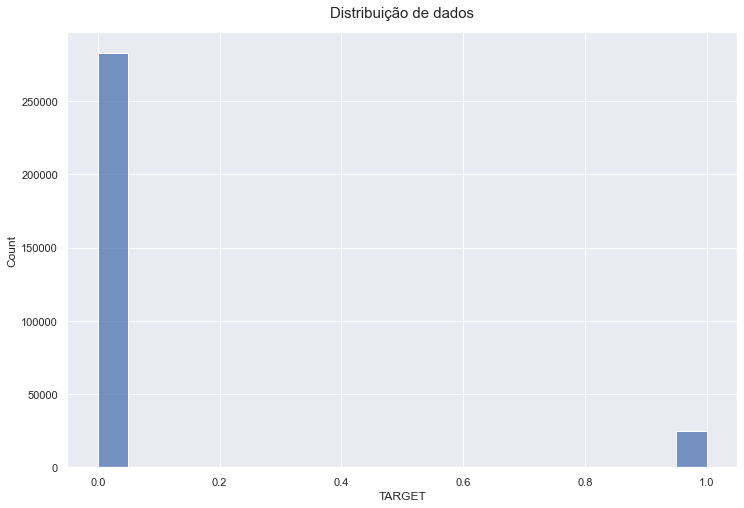

In [98]:
sns.histplot(data['TARGET'])
plt.title('Distribuição de dados',size=15,pad=15);

Nota-se um claro desbalanceamento nos dados em relação à variável alvo.

#### 3.1.2 Variáveis Numéricas

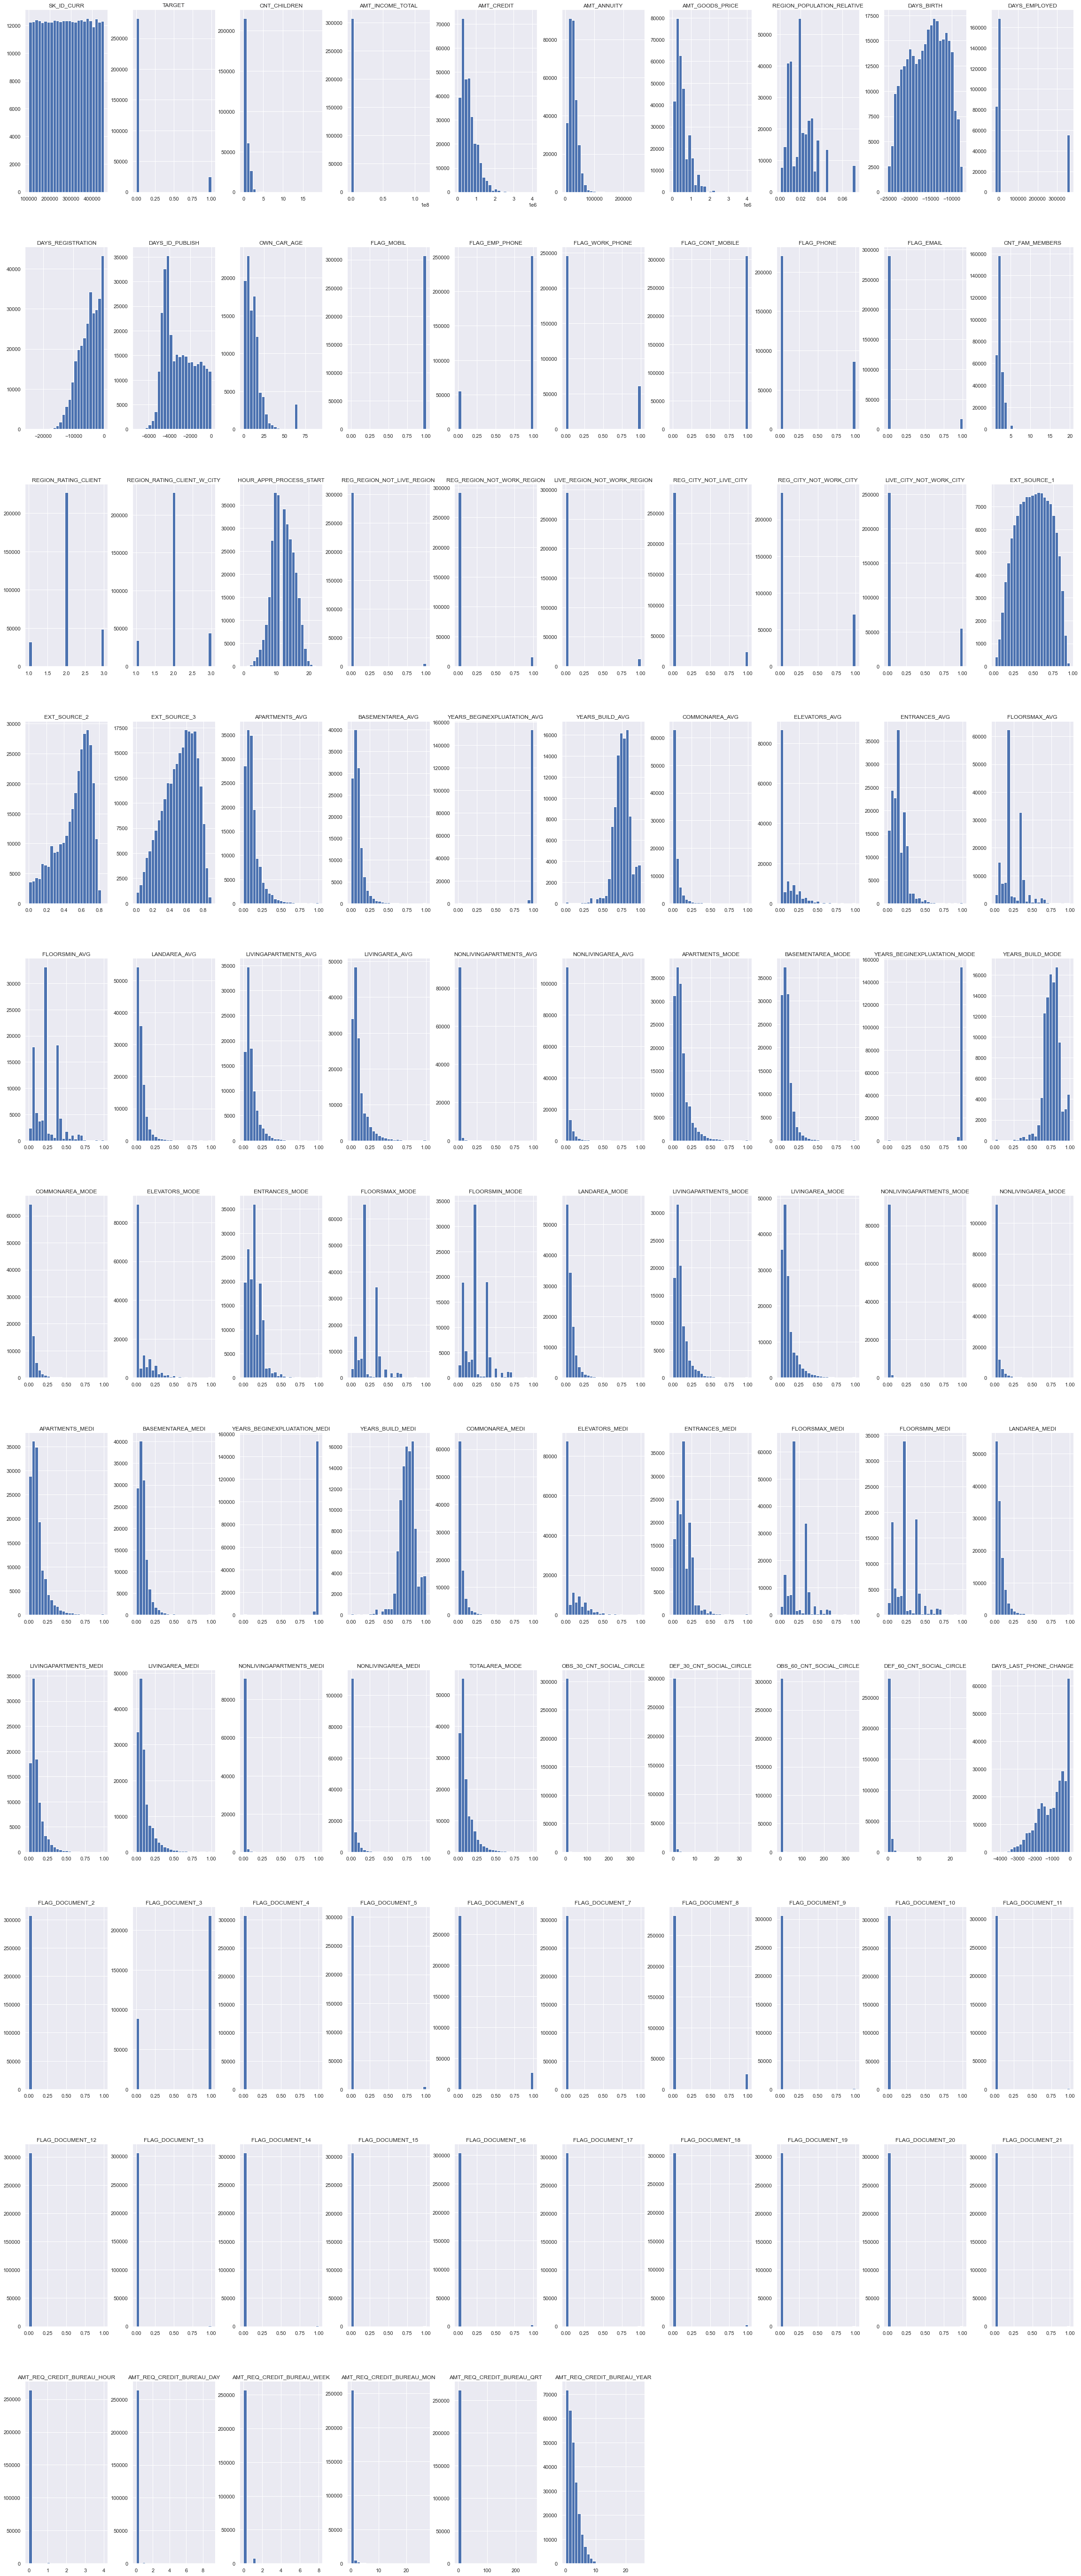

In [99]:
num_attributes.hist(figsize=(40,100), bins=25);

### 3.2 Correlação

O coeficiente de correlação de Pearson avalia o grau e a direção da correlação linear entre duas variáveis. Deste modo, quanto mais próximos de 1 ou -1, maior a intensidade da correlação, o sinal indica apenas a direção (positivamente correlacionados ou negativamente correlacionados). Deve-se mencionar também que quanto mais próximo de 0 menor a força da correlação.

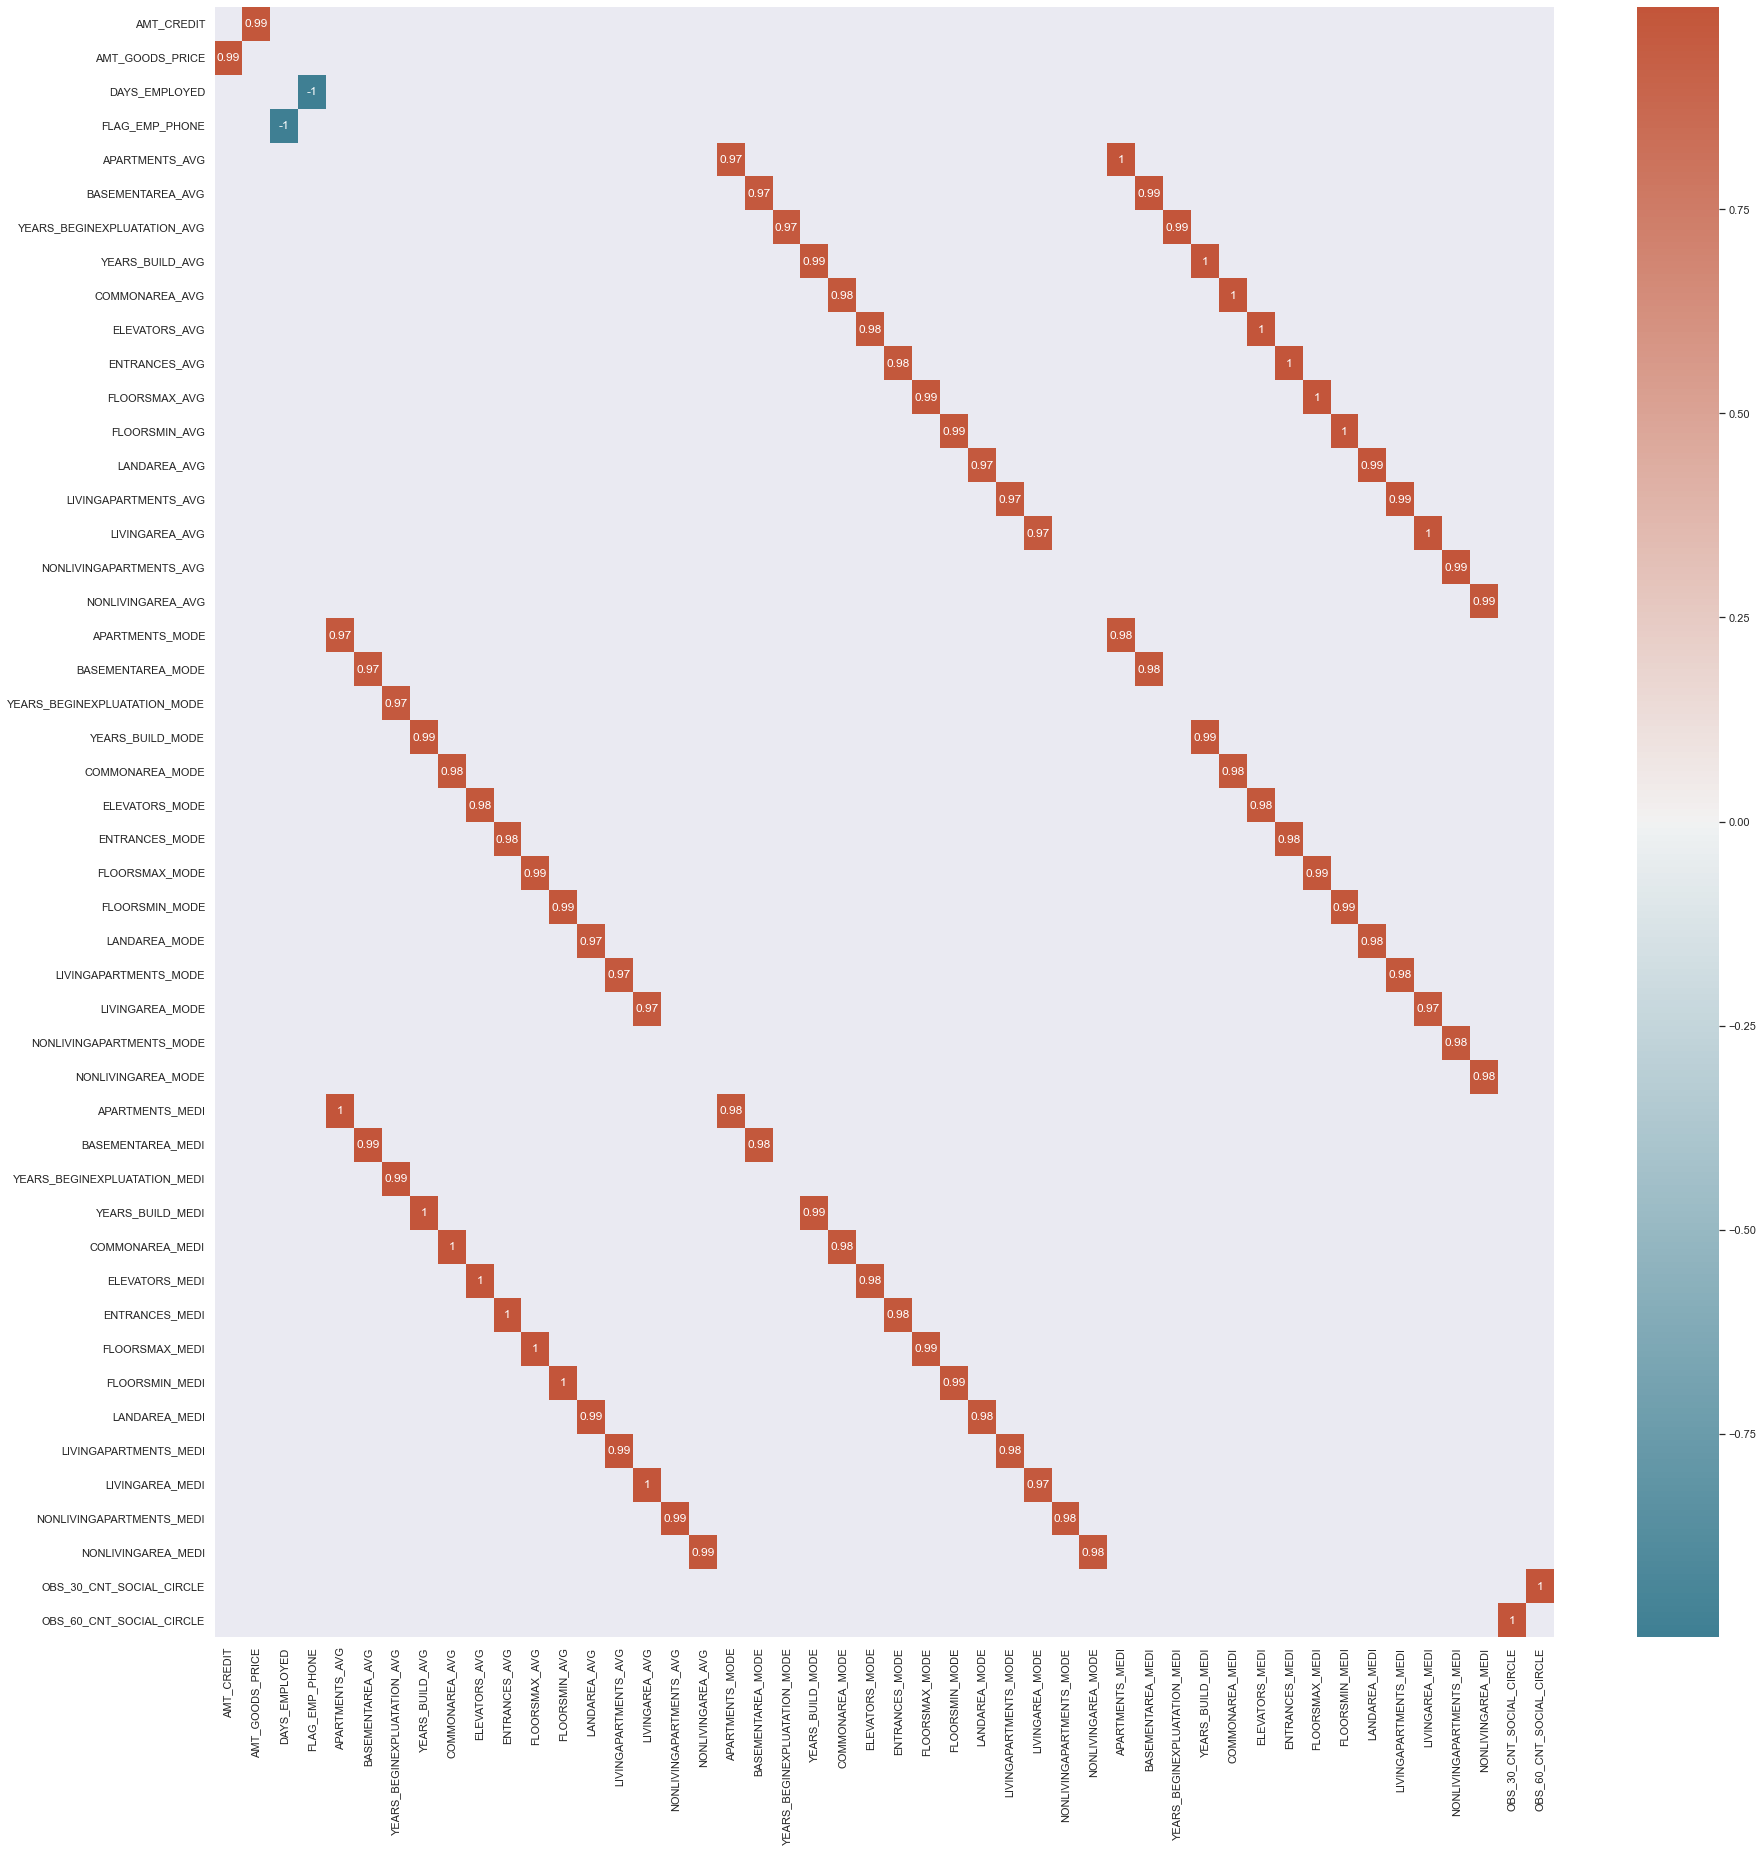

In [100]:
plt.figure(figsize=(30,30))
corr_data = data.corr()
corr_data = pd.DataFrame(data.corr(), columns=corr_data.columns)
corr_data = corr_data[((corr_data!=1)) & ((corr_data > 0.97) | (corr_data < -0.85))]
corr_data.dropna(axis=1, how='all',inplace=True) 
corr_data.dropna(axis=0, how='all',inplace=True) 
sns.heatmap(corr_data,xticklabels=corr_data.columns,yticklabels=corr_data.columns,annot=True,cmap=sns.diverging_palette(220,20, as_cmap=True));

Podem-se identificar diversas correlações lineares entre algumas variáveis.



In [101]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

### 3.3 Análise Bivariada


TypeError: Could not convert FMFMMFMFMFFFMFMMFFFMFFFMFMMMFFFMFFFMFMFFMFFFFMFMMFMFFMMMFMMFMMFMFMMMMMFFFMFFFMMFMFFFFFFMFMFFFFFFMFFMFMMFFFFFMMFMFFMMFFMFFMMFMMMFMMFFFFFFFFFFFFMFFFFFMFFFMFFFMFFMFFFFFFFMFMFMFFFFMMFFFMFMFFFMFFFMFMFMMMMFFFFMFMMFFMMFMFFFFMFMFFMFFMMFFMFFFMMFFFFMMFFFFFMMMFMFMFFFFFMMMMFFMFFFFMFFFMFMMMMFFFFFFFFFMFFMFMFFFFMFFFFFFFMMMFMFFMMFMFFMMMMFFFFMMFFFMFMFMFFFFFFMFFFFMFFFFFFFFFFFFFFFMMFMFFMFFMFMMFFMFFMMFMFMMMFFMFMMFFFFMMFFMFFFMMMFFFFMFFFFFFFMMMMFFFFFMMFMFFMMFFFFMFFFFFFMFFMFMFFFMFFMMFFMMFFMMFMFFFMFFFFFFMMFFMFFMFFFFFFFFFMFMFFFFFFMMFFFMFFFFFMFMFFFFMFFFFMMFFMFMMFMFFMFMMFFFFMMMMFMFFMFFMFMFMFFFFMFMFMMMMFFFFFMFFFMFFFFFFFFMFFFMFFMFFFFFFFMFMMMMMMFFMFMFFMMMFFMFFMFFMMFFFFFFMFMFMMFFFMFMFMFMFFFFFFFFMMFFFMFMMFMMFMMMFMMFFMFMMMFFFFFFFFMFFFFFFFMFFFFFFFFFFMFFFMFFFFFFFFFFFMMMFFFFMFFFMFFFMFFFFFMMMFFFFFMMMMFFMFFFFFFFMFFFMFFFFFFFFFFFFMMMFMMFFFMMFMFFFFFFFMFFMFMFFMMFMFFFFFMFMFMFFFFFMMFFFFFMMFFMFFFMMMFMFMFFMFFMFMFFMFFFFMFFFFMMMFFFFFMFFMMFFFFFMFFFFMFFFFFMMFMFFFFMMFMMFFMFFFFFFMMFMFFMMMFFFFFFFFMMMMMMFFFMMMFFMFFMMFFFFFFMFMFFMFFMMFMFFFFFFFMMMFMFFFFFFFFMFFMFMFFFFMMFFFMFFFMFFFFFFFMFFFFMFFFMFFFFFFFMMFFFFMFFMFFFFFFFFMFMMMFFMFFFMMMMFMFFFMMFMFMMMMFFFMFFFMFFFMMFMMMMFFFFFFFFFFFMMFFMFFMFFFMFFMMMMFMFMFFFMFMMMMFFMFFMMMFMFFMFFFFFFMFMFMFMFFMFFMFMFFFMFFFMMFFFFFFFFFFMFFFFFMMMFFFFMMFFFFFMFFFFMFFMMFMMFFFMFFFFMFFMFFFMFMFFFFMMMFFMFFFFMFFFFMMMMMFMMFFFFFFMMFFFFFFMFFFFFMFFMMMMFMFFFFFFFFFFMFMFFFMFFFFFFMMFFMFMFFFFFMFFFMFFMMFFMMFFFMFMFFFFFFMFFFFFFMMMFMFFFMMFMFFFMFMMMFFFFFFFFFMFFMMFFFMMMFFFMFFMMMFFFMFFMMFMMFFMFFFFFFFFFMFFFFFFFFFFFFFMMMMFMMFFFMFFMMFMFFMMFMFMMMFFFFMMFFMFFFFFFFFFFFFFFMFMMFFMFFFFMFFMFFFMMFFFFFFFFFFFFFFMFMFFFFMFMFMMFMMFMMFFFFMFFFFFFFFFFFMFFMFFFFFFMMFFFMFFFFMFMMFFFFFFFFFFFFFFFMFFFFMFMFFFFFFFFMMFFMMMFFFMFMFMMFMFMFMFMFMMFFFMFMFFMMFFFFMMFFMMFFFFMFFFMFFMMMFFFFFMFFFFFFFFFFMFMMFFFFMFFMFMFMFMMMFFFMFFMMMFFMMMFFFFFMMFFFFMMFMMMMMFMMFFFFFFFFFFMFMMFFFMMFFMFMFMFFFMFFMFMMMFFFMFFFFMMMFFFFFFFMFMFFFFMMMFFMFFFMMFFFFMMFFFFFMMFFMFFFMFMFFMMFFFFFFFMMMFFFFMMFMFMMMFFFFFMMFFFFMFFFMFMMFFFFFMFMFFFFFFFFFFFFFFFMMMFMFMFFFFFFMMFMMFFMFFFFMFFFMMFMFMFMMMFFFFMFFMFFMFFFMMFFFFFMFFMFFMFFFMFMFFFMMFMFFFMFFFMFFFFMFMFMFMFMFMFFMFFFMFFMFFFFFMFMFMMMFMMFMFFMFFFMFMMFFFMMFFFFMFFMMMMFFFMFFFFMFFFFFFFFMFFFFFMFFMFFFMMFMFFMFFFMFMFMFFFMFFFFMFFMMFFMFFFFFFFFFFFFFFFFMFMFFFFFFMFFMFMFFFFFFFFMFFFFFMFFFMMFFMFMFFMFFFFFMMMMMMFMFMFMFFFFMMFFFFFMFFMMMFMMFFMFFFFFFFMMFFFFMFMMFFMFFFFFMFMFMFFFMFFMFMMFMFFFFFFFMFFMFFMFFFFFFFMFMFMFFFMFFFMFFMFMMFFMMMFFFFFFMFFFFFFFMMMFMFMFFMFFMMFMFFMMMFFFMFFMFMFMFFFFFMMMFFFFFFFFMMFMMMFFMMFMFMFMFFFFMFFMMFFFFFFFMMMMFMFFMFMFFFMFMFFMFFMFMFFFMFFFMFFFFFFFFMMFMMFFFMFFMMFFFFMFMFMFMMMFMMFFMFFMMFMFMFFFMFFFFMMMMMMMFMFFFMFFFFFFFFFFFFMFFFFFFMFFMMFFFMFFMFFMFMFFFFFFMFMMFFFFFMMFFFFFFMMFFFFFFMMFMFMFFMFFFFFMFFFFMFFFFFMFMFMFFFMMFMMFMMFFFMMFFFFMFFFFFFFFFFFFFFFFFFFMMFFFFMMMFFMFFFMFFFMMFMFFFFFMFFFFFMMMMFMFFFFMMFFFMFFFMFFMFMFFFFFFMFFMFFFMMFFFFFMFMMMFFFFFFMMMMFFFMFFMFFFFMFFFFMFFMFMFFMFFFFFMFFFFMFFFMFMFFFMFMFMFFFFFMMFMFFFMFMMFFFFFFFFMFFMFMFFMFFFFFFFFMFFFFFFFFMFFFFFFMMMFFMFFMFFFMMFFFFFFFMFFFFFMMMFMFFFFFFFFFFMFMFFMFFFFMMFMFMFFMFFFFFFFFFFFFFMMFFFFMFMFMFFFMFFFFMFFFMMFMFFMMFFFFFMFFMMFFMFMMMFFFFFFFFFFFMFFFFMFFMMFFFMFMFFFFMFFFMMFFMFFMMMFFFMFFFFMMFFFMMFFFMFFMFFFFMMFFMFFFMFFMFMFFFFMMFFFFFFFFFFFMFMFFFMMMFMFFMMFMFFMMFMFMMMFFFFFFFMFFFMMFMFMFFMFFFMMMMFFFMFFMFMFFMFFFFMFFMFFMMMMFFFFFFFFFMFFFFFMFFFMFFFFFFFFMFFFMFFFMFFFFFFMFFFFFMFFFFMFFMFMFMMFFFFFMFFFMFMFFMFFMFFMFFFMFFFFMMMFMFFMFMFFFFFMFFFFFFFMFFFMMFFFFMFFMFFMFFMMFFFFMFFFFFMFMFFFFFMMFMFFMMMMMFFFMMFFFFFFFMFFFMFFMFMFMFFFFMMFFFMFFFMFMMFMMFMMFMFFFFMFMMFFFFFFMMMMFFFFFMFFFMFFFFFFMFFFFMFFMFFFFFFFFFFFFFFFFMMFFMFMMMMMMMFFFFFFFFFMMFFFMFMMMFMFFFMMFMFMFFFFFFFFFMFFMFMFMFFFMMMFMMMMFFFFFMMFFMMFFFFMFMFFFMMFFFMFFFFFFFMMFMFFMMMMMMFMFMFFFFMFFFMMFFFFMMFMMMFMFMFMMFFMMFFFFFMFMMFFFFMFFFMFFFFFMFFFMFMMFMMFFFMMFMMFFFFFFFFMFFFFFFMFFMFFFFFMFMFMMMFFMMFFFFFMFFMFMFMFFFMFMMMFFFFFFMFFFFMFFFMMFFFFFFFFMFFFFFFFFFFFFMMFFFFFFMFFFFMFFFMFFFMFFFFFFFMFFFFFFFFFFFMFFFMFMFFMFFMFFFFFFMFMFFMFMFFFFMMMFMFFFMFFFFMMMFFFMFFFFFFFFMMFMMFFFMMFFFFFMFFMFFMMFFFFFMFFMFFFMFFFFFFMFMFFFFFMFFFMFFMFFFFFMMMFMFFFMFMFFFMFFMFFFMFFMMMFMMFFFFFFFFMFFFMFFFFFFFFFFMFFFFFMMFMMFFFFMFFFFFFFFFFMMMFMFFFFFFFMFFMFFFMFFFMFMMFFFFFFFFFFFFMMFFMFMFFFFFFFMFFMMFFMMMFFFMFFMMFFFFFFFFFFFFFFFFFMFMMMFMFMFMFFFMFFMFMFMMFFFFMFFMMMFFFFMMFFMMMFMFMFFFMFFFMMMFMMMMMFFFFFFFMFMFFFFMFFFFMFMFMFFMFFFFFFMFFFFMMFFMFFFFFFMMFMFFFFFMFFFFFMFFFFFFMFFMMMMMMFMFFFFFFMFFFFFMMFMMFMFFMFFFFMMMMFFFMFFFMFFFFFFMFMFMFMFFMFMFMFFFFFFFFFFFMFFFFFMMFFFFFFFFFMMFMFMFFFFFFFFFFMMMMFFMFFFMFMFFFMMMFFFMFFFFMMMFFMFFFFMMFMFMFFMMMMFFFMFFFFMMFFMFFFFMMFMFFMMMFMMMFFFMFMMFMMMFFFMMFFFFFFMMMMFFMFMFFFFMFFFMFFMFMFFMFFFMFFMFMMFMFMFMMFFMMFFMFMFFFMFFFFFMFFFMFMMMFMFFFFMMMFFFFFFFFFMFFFFMMMMFMFFFMFMFFFFFMMFMMFMFFFMFFFFFMMMFFFFFFMFFFFFMFFFMFFMMMFFFFMFMFMMFMMFFFFFFFFMFFMMFMMFMMFFFFFMFFFMFMFMFFFFFFFFMMMMMFMFFFFFMMFFFFMFMFFMFFMFFFFFFMFMMMFMFFFMFFFFFFFMMMFMMMMFFMMFFFFFFFFFFMFFMMFFFFFFMMFFMFFFMFMFFFFMFFFMFMFFFMFFFFFFFMMFMMFMFFMFFFMFFMFFMMFFFFFFFFMFFMMFFFFFFMMFFFFFFFMFMFFFMFFFFFMFMFMMFMFFFFMMMFMMMFMFMFFFFFMFFMFMFFMFFFFFFFMFFMFMFMFFMFMMMFFFFFMMMFFFFFFFFMFMFMFMFFFFFMFFFFFFFMFFFFMFFFFFFMMFFFFFMFFFFMMMMMMFFMMFFFFFFMFFFMFFMMFFFFFFFMFFFFFFFMFMFMFFFFFFFMFFFMFFFFFFFMMMFFMFFFFFMMMFFFFFFMMFMFFFFMFFMFFFFMFFMFMMMMMFFFMFMFFMFMFFFFFFFMMFMFFFFFMFMFMFMMMMFFMMMFFFFMFMFFFFFFFMMFFFFFMMFFFFFMFMFMFFFFMFFMMFFMFFFMFFFMFFFMFFFFFFFFFMMFMFFFMMFFFFFFFMFFFFFFFMFFFFFFFFFFMFMFFMFFMMFFMFMMFMFFFFFFFFFMFMFFFMMMMMMFFFFFFFFFMMFFMFMFMMFMMFFFFMFMFMMFMFMFMFFFMFFMMFMFFFFMFFFFFMFFFFMFMFMMMFMFMMMMFFFMFFFFMMMMFMFFMFFMMFFMFFMFFMMMFFFFMFMFFFFFFMFFFMFMMFMFFFFFFMFFMFFMFMFFFFMFFMMFMFFMFFFMFFFMFFMFFFMFFFFFFFFFFFFFFFFFMMFFFFFFFFFMFFFMFMFMFFFFFFFFFFFFFFMFMMMFFFFMFMFFFFFFFFFFMFFMFMFFFFFMMFFFFFFFMFFFFFMMFFMFFFMMFFMMMFFFMMFFFMFFFFMMFMFFFMMFMFFFFMFFMMMMMFFFFFFFFMMFFFMFMMFMMFFMFFMFFFFFFMFFMFMMFFFFFFFMMFMFMFMMFMFFFFFFFFFFFFMMMFFMFMFFFFFFMFMMFFFFMFFMMFFMFFFFMMMFFMFFFMFMMFMMFFFFFFMFFMMMMFFFMFFFFFMFFFFMFFFFFFMFMMFMFFMMMFFMFMMMFFMMMFFMFFFFFFFFMFFFFFFFMFFFFMFFFFFFFFMMFMFFMFFFMMFFFFFFFFMFFFFFMFMMFFFMMFFFMFMMFFMFFMMMFFMMFFFFFFFFFFMFFMMMMFFMFFFMFMFFFMMFFMFFFFFFFMMFFMMMFFFFFMFFFMFMMFFMMFFMFFFMFFFFFMFFFFFFFFFFFFFFFFFMFFFFMFFFMFMMFFFFFFFMMFFFFMMFFFFFFFFFFMFMFMMFMFFFFMFMFFFFFFFFMFFMFFFMFMMMFMFMFMMFFFFFMFFFMMFFFFFFMFFFFFFMMMFMMFMMFMFFFFFMFFFMFFFMMFFFFFFFMFFFFFMFFFFMFFFFMMFFMMFFMFFFMFFFMMMMMMFFFMFMFMMFMMMFFMFFMFFMMFFFFFMMFFFMMFFFMMFFMFFMMFFFFFFFFFFMMFFFFMFFMFFFFMMMMFMFMFMMFFFMFFMFFFMMFFFMMMMFFFFFFFMMFFFMFMFFFFMFFFFFMMFMFFMFFFFFFMFFFFFFMFFFMMMFMFFFMFFMFMFMFMFFMFMFFMMFMFMFFMMFMMFFFFFFMMFFMMFMFFFMFFFMFFFFMFMMFMFFMMFFMFMFFFFFFFFMMMFFMFFMMFMMFFFFFMMFFMFFFFFMFFFFMFMFMMFFFMFFFFFFMFMFFFMFFFFMFFFFFMMFFFFFFMMFFMMMFMMFFFMFFFFFMFFMFFFFFFFFFFFMMFFMMFFFMMFFFMFFMFMFFFFFFFFFFMFMFFFFMFFMFMFFFMFFFFFMMMFMFFFFFFFFFFFMFFMMMFMMFFFFFFFMFFFFFFMFMFFFMMFMFFMMFFFMMFMFMMFMFMFMFFFFFMMMMFFMFFMFMFFMFFFFFMFMMMFFFFFMMMMFFFMMMFMFFFFFMFFFMMMFFFFMFMFFFFFMMMFFFFFFFFMMMFFMFMMMFFFFMFFFFMFFMFFMMMFFFFFMFFFMFFFFFMFFMMMFFMMFFFFFFFMFFFFFMFMFMMFFFFMFFFMFMFFFFFFFFFFMMFFFFMFMFFFFMFFFFFFFFFFFMFMFFMFMMMFMMFMMMMFFFFFFFFFFFFMMFFFMMFFFFFFFFMMFFFFMMMMFFFFFFMFMMFMFMFFFFFFFFFFFMMFMFMMFMFFFMFMMMFMMMMFMFFFFFFMMFMFFFFMMFMMFFFFMMFMFFFFFMMFFFMFMFFMFFFFFFMFFFFFMFFMFMFFFMFFMMFMFFFFMMMFMFMFMFFFFMFFFMFFFFMFFFFFFMFFFFMFMFMFMMMFFFFFMFFFFFFFFFFMFFFMFFMFMFMFMFFFMMFMMMFFFFFMFMFFFFMMMMMMFFFFFFFFFMMFFMFFMFFFMMMMFMFFFFFFFMFFFMFFFFFFFFFFMFFFFMFMFFMFFFFFFMMFFFMMFMFFMFFFMMFFMMFFFFFFFFMFMMMMMMMFFFFMMMFMMMFFMFMFFFFMMMFFFFFMFFFFMFFMFFMFFFFFFMMFFFFMMFFFFFMFMMMFMMMFFFFFMFFFFFFFMMFFFFFFFMMMFFMFMFFFFFFFFMMFFMFMMMFFFFMMFFMFFFFFFFMFFFFMMFFFMMFFFFMFFMMMFFFFFMMFFFFFFMFFFFFFFFFMFMFFMFFMMFFMFMFMFFFMMFFMFFFFFFMMFFFFMFFFFFMFFFFFFFFFMFFMFMMFFFMFFFMFMFFFFFMFMMFFFFMFMMMMFFFFFFMFFMFMFFFFMFFFMFMFFMFFFMMFFMFMFFFMFMFMFFMMFFMFFMMFFFFMFMFFFMFMFFFFMMMMFFFFFFMFFFFFFFMFFMFMFMFFFFFFMFFFFFFFFMFFFMFFFFFMMMFFFFMFFMFMFMMFFFFFFMFFFMMMFFFFMFFFMMFFMFFFMFMFFFMFMMFFFMFMFMMFMMMMFMFFFMFFFFMFFFFFFFFFFMMFMFMFFFFFMFMFFFFMFMFFMFFFFFFMFFFFFMMFMFMFFMMFFFFFMFMMFFFFFFFFMMMMMMFFMMMFFMFMMFFFFFFFFFMFFMFMMFFMMMMFMMFFMFMFMFMMFFMFMMFMMMFFFMFFFFFFFMFFMMFFFFFMFMFFFFFFFFMFMFFFFMFMFFFFFMFMFFFFMFFMFMFMMFFMFFFFMFFFMMMFMFMFMFMFMFMFFMMFFFMFFFFMFFFFFFFFMMMFFFMMMFMFFMFFFFFMFFMFFFMFMFFFMFMFMMFFFFFMFMMMFFFFFMFFFMFFFFFMFFFMMMMFFFFMFFMFFFFMFFFFFFFMMFFFMMMMMFMFMFFFFFMFMFMFMMFFFFFFMMMFMFFMFMMFFMFMFFFFFFMFFMFFMFFMFFMFFFFFFFFFFFFFFFMMFMFFFMFMMFFMFMFFFFFFMMFMMFMFFMFFFMMMFFFFFFMFFFMFFFMFMFFFFFMFMMFFFFMFMMFMFFMFMFFMFFFFMFMMFFFMFFFFFFMFMFMFFFFFFFMFFFFFMFFMMFFFFFFFFMMFMFMMFFMFFFFFFFFFFFFMMMFFFMFFMFFFFFFMFFFFFFMFFMFMMMFFMFFFFFFFFFFMFMFFFMFFFFFFFFMMFFMFFMFFMFFFFFFFFFFFFFMFFFFFFFFFFFMMFMMFFMFFFFMMFFFFFFFFFFMFFMFMFFFMFMFFFFFFFMFFFFFMMMFFFMFFFFFMFFMMFFFFMMFMMFFFMFMFMFFMFMFMFFFFFFFMMFMFMMFFMFFFFFFMFMFMFMMFFMMFMFFFFFFFMFMFFFFMFFFFMFMFMMMFMMFFMMFFFFFMFMFFFFFMFFFFMFFMFFMFMFFMMFFFFMMMFFFFFFFFFMFFFMMFMFMMFMFMFFFMFMFFFFMFFFMFFMFFMFFMFFFFFFFFMFMFMFMFMFFFMMFMMFMMFFMFMFFFMMFFFMFFFMFFFFMFMFFMFMFMFFFFFFMMFFMMMFFFMMMFMFFMMFFMFMFMFFFMMMFMFFMFFMMMFFMMFMMFFMMFFMFFMFFFMMMFFFFFFMFFFFFFFMMMMFFMMFMFFMMFFMFMMFFFFFMFMMMFMFFFMFFMFMFMMFMFMFMFFFFMFFMFFFFFFFFMMFFMMFFFFFFFMFFMFFMFFFFFMFMMFFMFMFFFFFFFFFMFFFFFMFFFFFMFFFMFFMMFMFFFFMMMFFFFMMMMFMFFMFFFFFMMMFFMFFFFFFMFMMMFMMFFFFFFFFMFFFFFFMMMMFFMMFFMFFMMMMFMFFFFMFFFFFFFFFFMFFFMFFFFMFFFMFMMMFMFMFFFMFMFFMFMFFMFFMMFFFFMFMFFFMFFFFMFMMMFMMFMMMMMMFFFFFFFFFMFFMFFFMFFFMMMFFFMFMFFFMFFMFMFFMFMFMFFFFMFFFMMFFFFMFMFMFMMFFMFMFFFFMFFFFFFMFFMMFMFFMMMFFMMFFFMFMMMFFMFFMFMFMMFMFMFFMFMFFFMMFFMFMFMFFFFFMFFMFFFFMMMFFMMMFFMFMFMFFMFMFFFFFFMMMFFFMFFMFFMFFMMFMFMFFFMFMMFMMFFFMFMFFFFFFFFMMFMFFFFFFMFFFMFFFFMMFFFFMFMMFFMMMFFMFMMMFFFFMFMFFMFFFMFFFFMFMMFMFFMMMMFFFMMMMFFFFFFFFFMFFFMMFFFFFFFFFFMMMFFMFFFMFFFFMMFMMFFFFFFFMMMMFFFFFFFFFMFFMFFMFMFMMMFMFFFFFFFFFFFFFMFFFFFFFFFFMFFFMMMFFMMMMFFMFFFFFFMMFMMFFFFFMMFFFFMMMFMFFFMFMFMFMFFFMFFMMFFFFFMMFMFFFMFFFFFFMFMMFFFMFFFFFMFMFMMMFMFMMMMMFFFMFMFFFMFFMMFFMFFFMFFMMFFFFFMFFMFFMFMFFFFFFFFFFMFFFMFFFFFFMMFFFMFFMFMFMFMMMFFMFFFFMFMFFFFFFFMMMMFMMFMFFFFMFFMMFFFMFMFFFFMFFFMMFFFMFMMMFMFFFFMMFFFMFMMMFMFFFFMFFFFFFFMFMFFMFFFMFMFFFFMFFMFFFFFFFFFFMMFFFFMMFMFFMFFMFFMFFFFFMFFFFFMMMFFFFFFFFMFFFFFFFFFFFFMFFFFFMFFFMMFMFFFFMFFMFFFFMFFMMMFFMFFFFFFFMFFFMFFFFFFFMFFFFFFFMMMMFFMFMFFFFFFFFFFMFMMMFFMFMMFFFMFMFFFMMMFMMFFMMFMMFFFFFMFMMFFFMMMFFFFFFFFMMFMFFMFMFFMFFMMFFMMFFFMFFFMFMMMFFMFFFFFMFFMFFMFMMFMMFFFFMFMMMFFFMMFFMFFMFFFMFMFMFMMMMFFMMMFFFFFFMFFFFFFFMFFMFFMFFFFFFFFMFFFMFFFFMFFFMMFFFFFMFFFMFMFFMFFFMFMFMMMFFFMFFFFFMFMFFMFMFFMFFMFFFFFFFMFFMFMFMMMMFMFFMFFMFMFFFFFFFMMFFFMFFMFFMFMFFMMFMFFMFFFFFMFFFMMFMFFMMFMFFFFMFFFFFFFFFMFMFMFMMFFMMFFMFMFFMFFFFMFFMFMFFMFMMMMMMMMMFFFFMFFMMMMFFFFMFFFFFFFMMMMFFFFFFFFFFMFFMFMMFFMFMMMMFFFMMFFFFMFFFFMFMFFFFFMFFFMFFMMFFFMFFFFFMFMFMMFFMFMFFFFFFMMFFFFFMMMFMFFFMFFMFFMFFFFFFFMMMMMFMFMMFMFFFMFFMMFFFMFMFMFFMMFMMFFMMMFFFFMFFMFMFMMFFFMFFFFFFFFMMFFFMFMFFFFFMFFFMFFFMMMMFFFFMFMMFMMFFFFMFMFFMMFFFFMMMFFFFMFFMFFFFFFFMFMMFFFMMFFFFFFFMFFFMMMMFMFMFFFMFFFMFMFFFFFFFFMMFFFMFFFFMMFFMFFMFMFFFFFMFMMMMFFFMMFFFFFMFFFMFMFFFFMMFFFMFMMFFMFMFFFFFFFFMMMFMFFFMFFMMFMFFFMFMFFFMMFMMMFFFFFFFMFFMFFFMFMMMFFFFMFMMFFFFFMFFFFFFMFFMFMMFFFFMFFFMMFMFFFFFFMMFFFFFMFMFMFMFFFFFFFFFMFFMMFFFMMFMFMMMFMMFFFFMMMMMFFFMFMFMFMFFMFFMMFFMMFMMMFFFFMFFMFFFFMFFMMFMMFMFMFMFFFFFMFFFMMMFFFMFMFFFFFFMFMMFMFMFFMFFMFFFMFMMFFFFMMFMMMMFFFFMFFMFFMFFMMFMFMMFFMFMMMMMFFFMMFMFMMFMMFFMMMFFMFFFFFFFMFFMMFMFFFFFFMMFFFMFFMFMFFFFMFMFMMMMFFFMFMFMMFFMMFFFFFFFMMMFMFMMFMFFFFMFMFFFFMFFMFFFFFFMMFFFFFMMFFFFMFFFMFFFMMFFFFFFFFMFFFFFFMMFFFFMMMMFMMFFFFFMMFFFMFFFFMMMFFMFFFFFFFMMMFFFFFMMFMFFMFFMFFFMFFMMMMMMFFFMFFMMFFFMFFFMFFMFMFFFFFFFFFMFFFFFFFFFFFFFMFFFMFMMMFFMFFMFFFFFFMFFFFFFMFFMMFFFFFFFMMFFFFFFFFFFFFMFMFFMMFMFMMFMMFFFMMFMFMFMMMMFFFFMFMMMMFMFFFFFMFFFMMMFMFFMMFFMFMMFMFMFFMMFFMFMFMFFMFFFFFFFMFFFMMFMMFFFFMFFFMMFFMMFMMFFFMMFFFFFFFFFFMMMMMFFFFFFFFFFFFFFFFMFFFMMMMFFFMFFFMMMFMMMFFMFMFFMFFFMFMFMFFFFFFFFFFMFFFMFFFFFFFFFFFFFFMFMMMMFFMFMFMFFFFMMMFMFFFFMFMMFFMFFMFFFFMFFFMFFFMFMFMFFMFFFFFFFFFFMFMFFFFFMFFFMFFFMMFFFFMMMFFFFFFFMMFFFFFFMFMFMMFMFFFFFFFMFFMMFFMMFMFFFFFFFFFFMMFMFFFFFMFFMMFFFFFMFFMFFFMFMMFFFFMFMMFMFMMFMFFFFFFMMFFFFFMFFFFFFFFFMMMFFFFMMMFFFMFFFMFMMFFFMMFFMFMMFFFFMFFFFFMMFMMMFFMMFFFFMFFFFMMFMMFFMMFMFMFMFFFFFFMFFMFFFMFMFFFFFFMFFFFFFFFMMMMFMFMFFFFFFFFFMFFFMFFMFMMFFFFFMMFFFFMFMFFMFFFFFFMFFFFFFMFFFFMFMFMFMFMFMFFMMMMFFFFMMFFFFMFMMFFMFFFFMFFMFFFFFFFFFFFMFFMFFFMFMFFFMMFMFMFFMMFMFFMFFFMFFFFMFFMFFFMMMMFMFFMMMFFMFMFMFFFFFFMMMFMFMFFMMFFFMMFFFMFFFMFFFFMFFFFMFMFFFMFMMFMMFFMFFMFFFMFFMMFFMFFMFFFFFMFFMMFMFFFMMMFMFFFFMFFMMFMFMMMFFMFMFFMMFMMFFFFFMFFMFMMFMFFFFMFMFFMFMFFFFFMFMMMFFFFFFFFFFFFFFFFFMFFFFFFFMMFMMMFFFMMMFFFFMFFMFMFFFFMFFFMFMFFMMFMFFMMFFFMFFMFMMMFFFFFMMFFFFFMFFFFMFFFFFFMFMMFFFFFFFFFMMFFMMMMFFFFFFFMFFFMFFFMMMFFMFFFFMMFMFMFFMMFFMFFFFFMMFFFFFMMMFMFMFFFMMFMFFMMFMFFMFFFFFFFFFMFFFMFFFMFMMMFFFFMFFFFFMFMFFFFFMFFMFFFMFFFFFMMMMMFFFFFFMFMFMFFMFFMFFFFFFMFFFFFMFFFFMFMFMFFMFFFFFFFFFMFMMMFMFFFMMFFFFMFMMMFFFFMFFFMMFFMFMFFFFFMMMMFFFMFFFMFFMMFFFFFFMFMMMFFFFFFMMFFFFFFMFFMMFFFFFFMFMFFMFFFFMMMFFFFFFFFFFMMFFFFFFMFMMFFFFMFFFFFFFMMFFMFMFFFFFMMFFMFMFFFMFFFFFMFFFFFFFFFFMMFFFMFMMMMMFFFFMMFMFMMFFMFFFFFFFFFFFFFFFFFFMFFFFMFMMFFFFFFFFFMFMFMMMMFMFFMMMFFFFFFFFMFMFFFMFFFMMFFMMMMFFMFMFFFFMFFFMFMMFFMFFMFFFFFFFMMFFFFMMMFMFMFMMMFFFFMMFFMFFMFFMFFMMMMFFMFMFFFFFFMFFFFFMMFFFFFFFFFFFMFFFFFFMFMMFFFFFFMMFFFFMFFFMFFMFFFFMFFFMFFFFMMMFFMFFMFMFFFMFFFFFFMFFMMFFFFFFFFMFFFMFMFFMMMFFFMMMFFFMMFFFFFFFMFMFMFFFFFFFFFMFFFFMMFFFMFFMFFFMFMFFFFFFFMFMMFMFMFMFFFMMFMFFMFFFMFMFFFFFFMFMMMFMFFFFFFFFMMMMFFMMMFFFMFMFFFFFFMFMMFMFMFMMMMFMFMFMMFFFFMFFMFFMFFFMMMFFFFFFMMFFFMMFFMFFFFMFFMMMFFMFFFFMFFFMFFFFFFFFMFFFFFMFMFFMFFMFFFMMFFFFFMFFMFFFMMMFMFFFMFMMMFMFMFFMMFFFFMFMFMMFFFFMFFFMFMFMMMFFFFFFFFFFFFFFFMMFFFFMFFFFFFMFFFFFFFFFFFFFFFMFMFFMMFMMFMMMFFFFFFFFFMMFFFFFFFFFFFFFMFMMFFFFFFFMFMMMFFMMFFMFFFMFFMFMMFMFFFFMMMMFFMFFFFFFFMFMFFFFMFFFFFFMMFFFMFFFMMFMMFFFMMFFFFFMFFFMFFFMFFFFFFFFFFMFFFFFMFMFFFFMFFFFFMMFFFFFMFFFFFFFFFMFMFMFFMMFFMFFFFFFMFFFMMFFMFMFMMFMMFFFMFFFMFMFMFMFMFMFMFFFMMFFMMFFFMMFFMFFMMFFFMFMFMMFMFFFFMFFFMFMFFFFMFFFFFFFFMFFMFMMMMFFFMMFFFMFFFFFFFFFFFFFFFFMFFFFFMFFFFMFFFFMMMMMMMMFFFFFFMFFFFMFFMFFFMFMFMFFFFFMFFFFMMMFFFFMMFFMFFFFFFFMMMMMFMFFFFFFFMFMMFFFFMMFFMMFFMFMFFFMFMFMFFMMFMMMFFMFMMFFMMFFFMFMMFMFFMFFFFFMFFMMFMMFFFFMFFFMFMMFFMFFFFMFFMMFFMFFMFFFFFFFMMMFMFFMFFFFFFFFFMFFMMMMMFFFMFMFFFFMFMFFFMFFMMFMMMMFFMFMFMMFFFFMFFMMFMMMFFFFFMFFMFFFFFFMFMFMFFFFMMMFMFFFFFFFMFMMFFFFFMMFMFFFFFFFFFMFFFMFFMMFMFFMMFFFMFFFMFFMMMMMFFFMMFFFFMFFFFMFFFMFFFFMFFFMFMMFFMFMMMFFMFFMMMFMFMFFMFMFMFMFMFFFFFFFMMFFFFMFFMMFFMFMFMFMFMFMFFMFMMFFFFFFMMMFMFMFFFMMFFFMFMMFMMMMMFFMMFMFFFMFFFFFMFFFFMFMFMMFFFFFFFFMFMFFMFMFFMFFMFMFFFFMFFMMMMFFFFMFMMMFFFFFFMFFMFFFMFFFFMMFMFMFFFFMFMMFFMFFFFMMFFFMMMFFFFMFFFFFMMFFFFMFMFMFMMFMFFFFFFFFFFFFFMFFFFMMFFMFFMMFFFMMFMMFFMFFFFFFFFFFFFFMMFFFFFMFFFFFFMMFFFFFFFFMMFMMFMFFFFFFMFFFMFFMFMMFFFMFFMFFFFFFFMFFFMFMMFFFMFMFMFFFFFFMMFMMFFFMFMMMMFFFMFFFFMMFFFFFFFFFMFFFFFFMFFMFMFFMFMFFFFFFFFFMMFFFFMFFFFFFFFMFFMFFFFMFMMFFMFFMFFFFMFFFFFFFFFFFFFFFFFFFFMFFMFMFFFFFFFMFMFMFFFFFFFFFFMFFFFMFFFFFFMFMFFFFFFMFFFMFFMFMFMMFMFFFFFFFMFFFFFMFFFMMFFFMMFMFFMFFMFFFFFMFFMMFMMFFFMFFFFMFMFMMMFMFMMFMFMFMFFFFFFMMFFFMMMFMFFFFFFFFMMMFFFMMMFFMFMMFMFMMFFFFFFMMFFFFFFFFMMFFFFMFMMFMMFFFMMMFMFFFMFFMFFMFFFMFFFMFFMFMMFFFMMMMFFFFFFFMFFFMMMFFFFFFFFMFFMFFMMFFFFMFFFFFFMFFFFMFFFFMMMFFFFFFFFFFFFFMFFMFFFMFFMFFFFFFFFFFMFFFMFMMFFFFFFFMFMFFFFMMFMMFFFMFFFFMFFFMFMFFMFFFFMFFFFFFFFMFFMFFMMFMFMFMMFMFFMFFFFFMFFMFMFMFMFFMFFMMFMFFFMFFMFFMFFFMFMFFMMFMFFFFFFFFFFFFMMMFMFFFFFFMFFFFFFFFMFFFFFFMFFFFMMMFMFMMMFFMFFFMMMMMFFFFMFFMFFFFFFFMMMMFFFFMFFMFFFFMFMFMFMFFFFFFMFFFFFFMFFMFFFMFFMMMFMMFMFFFFFFFFMFFMMMFFFMFFFFFFMFFFMFFFFFFFFFFFFFFMFFMMFMFFFMMMFFMFMMMMFFMFFFFMFFFMFMMFMFMMMMFMFFMFFFMFFFFMFFMFFMFMFFMMMMMFFFFFFFFFMFMFFFFFMMFFMFFFMFMFFMFMFFFMMFFFMMFMMFFFFFFFFMFFFMMFFMFFFFFFFMFFMFFMFMFFFFMFFFFFFFFFMFFFFMMFMFFFMMFFMFMFFMMMMFMFMFMFFFFMFMFFFFFMMFFFFFFFMFFFFMFFFMFFFMFMMFFFFFMFFFFFFFFFMFMFFMMMFFFMFFFMFFFFMMFFFFFFFFFFMFFMFMMMMMFFFMMFMFMMFFMMFFMMFFMFFFFFMFMMFFFFFMFMFMFMMFFMFFFFMFFMFFFFMFFFFFFFFMFMFMMFFFFFMFFMFFMFFFMFFFFFMFMFFMFFFFFFFFFMFFMFMMFFMFFFMMMFFMMFFMFMFMFMMMFFMFMFFFFMMFFFFMMMFMFMFMFFFFFMFMFFFMFMFFFFMFFFMFFFFFMFFFFMFFFMFFMFFFFMFFFFFMFFMMFMMFMMFFFMMFFFMFMFFMMFFMMFFFMFMFFMFFFMFFFFMMFFMFFMFFFFMMMFFFFMFFMFFFFMFFFFMFFFMMMFMFFFMFFMFFFFMFMMMFFMMFFMFFFFMFFFMFMMFFMMMFFFFFMMMMFFFFMMFMFMMFFFFMFMFMFFFFMFFFFMFMFFMFFFMMFMMFFMMMFFMFMMFFFMFMMFFFFFFFFFFMFMFFFFFFMFFFFFFFMFFMFFFMFFMFFFFMFFFMFFFFFFFFFFFMMMFMFFMFFFFMMMMFFFFFMFMFMFFFFFFMMFFFMMFMFMMFMFMFMMFFMFFFFMMFMMMFFMFMFFFFFFFFMMMMFFMMFFFMMFFFMFFMMMFFFFMFMFFFMMFFFFFMFFFFFMMFFFFMFFMFFFMMFFFFFFMMMFMMMMFMFFFMMMFFFFFFFFFFFMFMMFMMFFMFMMMFFFFFMFFMFFFFFFFFMFFFFMFFMFFFMMFFFFFFMFFFMFFFFMFMFFFFFFFMFFFFFFFFMFFFMFFFMMFFFMFFFMMMFMFMFMFFFFFMFFMMFMFFFMFMMFFFFMFFFMFFMMFFMFFMMFMFMMFFFMFFMMFFMMFFMFMFFFFMFMFFFFFFMFFMMMFFFFMFFFFFMFMMMFMFMMFFFFFFMMMMFMFFFMFFMMFMMFFMFFMFFFMFMFFFFFFMFFFFFMMMFFFFMFMFFFFFMFFMFFFMMFFMFFMFFMMFMMFFFFFMFFFFFFFMMFMMFMFFFMMMFFFMMFFFFFFMFMMFFFFMFFFMFFFFFFFMMMFFFMMFMFFFFMMFFMMFMMMFMFFFFFFFFMFMFFMMFMFMFFMMFFFMFFFMFFMFFMFFFFFMFFFMMFFFMFFMFFMMFFFFMMFFFFMFFFMFFMFMFFMFMMMFMFMFMMFFFFFFFFMFFFMFMFFFFMFFFFFFMFMMFFFFFMFFMFFFFMMMFFFFFFMFFMFFFFFFMFFFFFFMMFFMFMFMFMFFFFFMMFMFFFMFFFFFFFMFFMFFMMFFMMFMMFFFMMFFFFFMFFFMFFFMFMFMFFMFMFFFFMMFMFFMMFFFMMFFMFFMFFMFFFFFFFFFFFMFMMFMMFFMFFFMMFFFFFMFMFFFFFMMFFMFFFFFFFFFFFFMMMFFFMFMFFFFFFFMMMMFMFFFFMFFFMMFFFFFFFFFFFMMMMFFMFFMMFMFFMFMFFMFFFMFFFFFMFFFMMFFFFMMFMMFMFFFFFFMFFFFFFFMFMFMFFFMMFFFFMFFFFFFFFFMFMMFFFFFFFFFMFMFMFFFFFFFFFFFFFFFFFFFMFMFMMFFFFFFFFMMFFFMMMMMFFFMFFFMFFFFMFFFFFFMFFFFFFMFMFFMMMFFFMFFMMMFFMMFMFMMMFFFFMFFFFMMFFFFMFMFFFFFFFMFFFFFMFMFFFFFFFMMMFMMFMFFFFMFFMFFFFFFMMMMFFMFFFMMMFMMMFFFFFFFFMFFFFFMMFFMMMFFMFFMFFMMMFFMFFMFFFFMMFFMFFFMFFMMFFFFFMFFMFFFMMMMFFMFFFMFFMFFMFMFFMMFFMFMFFFMFFFMFMMFMFFFMFFFMMFMMFFFMFFMFFMFFMFFMFMMFMFMFFFFMFMFFMFFMMFFMMFFFMFFFFFMFFFFMFFFFFMFFMFMFFFFMMMFFFMFFMMFFFFFMFMFFFMMFMFFMFFFMFFFFMFFFFFMMFFMFMFFMFMMFFFMFMFMMFMMFFFFMMMMFFFMMFMMFFFMMMFFFMFFMFFFFMFFFMFFFFFFMMMMFMFMFMMMFMFFFFFFMFFFMFMFMMFFFMFFFMMFFMMMFMFFFFFFFFFFFFFMFMMMFMFFFMFFFMFFFFFFFFMFFFFMFFFMMFMMFMFMFFFMFFFFFMFMFMFFFFMFFMMFFFMMFMFFFFFFFMMMFMMFFFFFMFMFFFFMFFMMMMMFMFFFMFMFFMFMMMFFMFFMFFFFMFMFFFFMMFMMMFFMMFMMFFFFFMFMMMMFFMMMMFMMFFMFMMFFFMFFMFFMFMFMFFFMMMFMMFMFFMMFFMMFFFFFFFFMFFFMFFFFFMMFFMFFFFFFFFFFFFMFFMMMMFFFFFFFFFMMFFFMFFFFMMMMFFMMMMFMFFFMFFMFFFFFMFMMFMFMMMMFFFFFFFFFFMFFFMFFFFMMFMFFMFFFFFMMFFFFFFFFFMFMMFMMFFMMFFMFMMFMMFFFMMFFMFFMFMFFFFFFFMFMFFMFFFFFFFFMMFFFFFFFFFMMMFFFFMFFFMMFMMMFFFFFFFFFMFFMFFMFMFFFFFFMFFFFMFFFFFFFFMFFMFFFFFFMMFFMFMFFMMFFMMFFMFFMFMFMFFMFFMMFFFMMFFMFFFMFFFFFFFFFFFFFFFFFFFFFFMFMFMFFFMFFFFFMFFMMFFMFFMFMFFFFMFFFFMMFMMFFFFFFMFFFFFFFFFFFFFFFFFFMFFMMMFMFFFMFFMFMFFFFFMFFMFMMFMFMFFMFFFFFFFMMFFFFFFFFFMMFFMFFMFMFMMFMFFMFFFMFFFMFFFMFFFFFMFFFMFFMFFFFMFFMFFFMMFMFFFFFFMFFFFFMFFMFMFFMFFFFFFMFFFMFFFFFMMMFFFFFFMMMMFMFFFFFMMFMFMFFFMFFFFFFFFFFFMFFFFFFFMFMFMMFMFFFMMMMFFMMMFMFFFFFMFFMFFFMFMFFMMFFMFFFFFFFMMMFFFMFFMMFFFFFFMFFFFFFFFMFFFMMMFMFMFFFFFFFMFFMMFFFMFFFFFFMFFMMFMFFMMFFFFFFMFFMFMFFFMMMFFFFFFFMMFFFFFFMFFMMFFMFFFMFFFFMFFFFMMFFFFMMMMFMFFMFFMFFFFFFFFMFMMFFMMFFMFMFFFFFFFMFMFMMMMMFFFMMFFFFFMMFFFMMFFMMMFFFMFMFMFFFFMFMFMFFFMFMFFFMMFFMFFFMFFFFFMMFFMMFMFFFFMFFFFMFFMMFFFFFMFMMFMFMFFMFFFFMFMFFFFFFMFFMMFMMFFFFFFFMFMMFMMFMMMMFFMFFFFFFFMFFMFFMFFMFFFMFMFFMFMMFFMFFMFFFFFMFFFFFFMFFFFMMFFFMMMFFMFMMMFMFMFFFFFFMFFFMFFFFFMFFFFFFMFFFFMFFFFFMFFMMFMFFFMFFMFMFFFFFFFFFFMFMFMFFFFFMMFMMMFFFFMMFFMMFMFFFMFFMFFMMFFMFFFFFFFMFFFMMFFFMFMFFMFFFFFMMFFMFFFFMFMFMMFFFMFFFMFFFFMFFFFFFFFMFMFFMMFFFFFFFFMFFFFMFMMFFMMMMMFFFFFFFFMMFFFMFFFFFMFFFFFMFMFMMFMMFFFMFMFFFFMFFFMFFFFFFFFFFFFFFFFFFFMFFFFMFFMFFMFFFMFMFFFFFFFMFFFFFMMMMFFFFMFMFMFMFFFMMMFFMFFMFFMFFMMFMFFFFFMFFMMMMFFFFMFMFFFMFFFFFMFFFFFMMMFFMFMFFFFFFFMMFFFMMMMMFFMFFFFFMMFFFFFMMFFFFMFFFFFFFFFFMMMFFFMMFMFFFMMMFMMFMFFFMFFMFMFFMMMFFFFMFFFFFMMFMMFFFMMFFFMFFMFMFFFFFFFFMFFFFMFFFFFFFFMMFFMFFMMMMFMFFFFFFFMMFFFFMFFFMFFFFFFMFFMMMMMMMFFFFFFFFMMMFMMFFMFFFFMFFFMFMFFFFFFMFFMFFFFFFFFFFFFFMFMMFMFFFFFFMFMFMFMFFFFFFMFFFFMFFFMMFFFFFMFMFFFFFMFFFFFFFFMFFMFFFFFMFMFFFFFFMFFFFFMMFFMMMMMFFFFFFFFFFFFMFFFMFFMMMFFFFFMFFFFMFMFFFFMMMFFMMFFMFMFFMFMMMMFFFFMFMMFFFFFFMFMFMFMFFFFFFMFMMMFFFFFFFFFFFFFFMMMMFFFFFFFFFFFFMMMFMFFMMFFFFFFFFMFFFFFFFFFMMFFMFFFMFFFFFFFFFFFFMFMMFFMFMFMFFFFFFFFMMMFFFFFFMFFMFMFFMFFMFFFFFFMFFFFFMMFMMFFFMFFFFFFFMMMFFFMFFFFFFMMFFFFFMFMFFMFMMFFFFFFMMFFFFFFFFMFMFFFMFMMMFMFMMFFMMMMMFFFFFMFMFFFMFFFFFFFMFMFFMFMFMFFFFFFMMMFFMFFMMFFFFFMFMFMMMMFFFMFFFMFFFFMFFFFMFFFMFFMFFFFFFMFFFFFMMFFFFFFFMFFMMMMFFFMFFMMMFMFFFFMFFFFFFMFMFMFMMMFFMFFFFFMFMFFMMMMFMMFFFFFFFFMFFMMFMFFMMFMMMFFMMMFFFFMFFFMMFFFFFFMMFFMFFFFMMMFFMFFMMFFMFMFFFFMMMMFFFFMFMMFFFFFMFFMMFFMFFFFFMFMMMFMMMFFFMMMMFFFFFMMMFFMFMFFMMFMFFFFFFFFFMFMFFMFFFMFFFFFMFFFMMMFFFFMFFMFMFMFFFFMFFMFMMFFFMFMFFMFFMMFFFMFFFMFFFFFFMMMFFMFMFMFFMFFFFFFFFFFMMMFMFMFMFMFFMFMFFMFMFMMFFFFMMMFMFFMFMFFFFFMMFFMMMMFFFFMFFFMFFFFFMFFMMFMFFFFMFMMMMFFFFFFFMFFMFMFMMMFMMFFFFFMFFFFFMFFFFFFFMFMFFMMMMMMMFFFFFFFFFFMFMFFMMMFFFMFFFFFFFMFFMFFFMFFMFFFMMMFFFFMMFMMMFFFFFFFMFMMFFFMFFMFFFMMFFFFFFFFFMFFFFMFFFFFMMFMFFMMMFFMFFMFFFFMFFMFMFMFMMMFFMMFMMMFMMMFFMFFMFFMFFFMFMFFFMFFFFFFFFFFFFFMMMMFMFFFMFFMMFFFMFMFMFFMFMFFFMFFMMFFFMFFFFMFMFFFFFFMFFFFMFMFFMMFFFFFFFMFFFFFFFFFFMMFFMFFMMFFFFFFFMFFFFMMFFFFMMFFFFFFFFFFFFFFMMFFFMFFFMMMFMFFFFFFFFFFFFMFFFMFMFFFMFFMMFMMFFFFFFFFFFFMFFMFMFFFMFFFFMFMFMFFFMMFFFMFMFMMFFFMMFFFFMMFFFFFFFFFFFFFFMFFMFMMMFFFFFFFFFFMFMFFFFFFFFFFMFFFMFFFFFFFFFFMMFFMFFMFFFMFFFFFFFFMMMFFFFFFFFFFFFMFMMFMFMFMMFMFMFFFFMFFFFMMMMFFFFFMFFMMMFMFFFMFFFFMMFMFMFMFFFMFMFFFFFMFMFFMFFFMFFMFFFFFFMMFMFFFFFFFMFFFFMFMFMMMFFFFMMFFFMFMFMFMFFFFMFFMMFMFMMFMFMFFFFMMMFFFMFMFFFFFFFMFMMFMFMFMMMFFFFFFMFMFMMFFFFFFMFFFFFMMFFMFFMFFFFFMMFFMMFFFMFFMMFFFFFFMFFMMFMFMFMFMFFFFMFFMFFFFMFFFFMMFMMMMFFMFMMFFFFFMMFMFMMMFFFFFMFFFMMFFFFFFMFFFFFFFFMFFMFFFMMMFFFMFMMMFFFFFFMFMFFFMFMFFMFMFFMFMFMFMMFFFMFFMFFFFMMMFFMMMFMMFFFFMFFFMFMFFFFMFFMFFMFFMFFMMFMFFFMMMFFFFMFFFFFMFFFFMMFFMFMFMFMFFFMFMFFFFFMFFFFMFMFMMMFFFFFFFFMFFFMMFFFFFFFFFMFFFFFFFFFMFMFMMMFMMMFFFMMFFFFFFFMMMMMMMFMFFFFFFMFFMFFFFMMFMFFFMFFFMFFMFFFFMFFMMFMMFMFFFFMFMFMFFFFMMFFFMFMMMFFMFMMFFMMFFMFFFMMFMFFMFFFFFFFFMMFMMMFMFMFFMFFFFFFMFFFFMFFFFFFFFMFMFMMFFMFFMMFMMFFFFFMMMFFFMFFFFFFFFFFMFFFMFMMFFFFFFFFFFMMFFFFMMMFFMFFMMMMFFFFMFFFMFFFFFFFFFFMMMMFMFMMFFFMFFMFMMFFMFMMMFMFFMFMFFMFFMFMFMFFFMFFFMFFMMFFFMMMMFFFMMMMMFFFMMMFFFFMFFMFFMFFFFFFMFMFFFFFFFFMFFMFFMFMFMFMFFFMFFFFFFFFFMMFMFFFFFMFMMFFFMFFFMFMMFMMFFMFFFFMFFFFFMFMFFFMFFMMFFMMFMFMMFFFFFFFFFFFFFFMMMMFFFMFFMMMFFFMFFFFFMFFMFMMFFFFFFFFFFFMFMFFFFMFFFMMFMMMFFFFFFMMFFMFMFFFMFFFMMFFFMMFFFFFMFFMFFMFFMFFMMFFFMFFFFMFFFFMFMFFMMFMMMFFMFMMFFFFFFMMFFFMFFMFFMFFFMFMFFFFMFMFFFMMFFFFMFFFFMFMMFFFMFFMMMFMMFFMFMFFFMFFFFFFFFMMFFFMFFMFFFMFFFFFFFFMMMFFMFMMFFFFFFMFMFFMMMFFFFFFMMFMFMMFFMMMMMMFMFMMFFMFMFFMFMFFMFFFFMFMFMMFFMFFFFFFFFMFMFFMMFFFMFFFFMFFMFMFMFFMMMMFMFMFFFFMFMFMFFFFFMFFFFFFMFMMFFMMMMMFFFFMFFFFFFFMMFFFFFFFMMFMFFMFMMMFFFFMFMFMMMMFFMFFFFFMFFMMFMFFFFFMMFFFFMFFMFFFFMFFFFFFFFFFMMMFFFMFFMFFMMFFFFMMMMMFFFMFFFFMFMFMFFFFFMFMFFFMFFFFMFFMMFFFMMFFFFMMMFFFFMFMFMFFFFFFFFMFFMFFMMMMMFMMFFMFFFFFFFMFFFFFFFMFFFMFFMFMMMMMFFMMMFMFFFMMFMFFFFFMMFFFFFFFFFMFFFFFFFFMMFFMMMMFMFMMFFMFFMFFFFFMFFMFMFFFMFFFFFFFFFFMFMFFFFFFFFFMFFMMMMFFMFFMFFFFFFFFFFMMMMFMMFFFFFFMFMFFFFMMFMFFMMMFFFFFFFFFFFFFFFFMFFFFFFFMMFFMFFFFFMFMFMMMMFFMFMMMFFFMFFFFFMFFFFMFMFFMFFFMFFMFFFMMFMFMFMFFMFMFFFFFMMFFFMFFFFFFMMMFFFMFFFFFMFMFMFFFFMFFMFFMFFFFFFFFFFFFMFMFFFMMFMMFFFFFFFFMMMMMFFFFFMMFFFMFMFFFMFFFMMMMFFFFFFMMFMFMFFMFMMMFMFFFFMMFMFFFFFMMMFFFFFFFFFFMFFFFFFMFFFFMFMFFFFFFFMFMFFFFFMMFMFFFMMFMFFFMFMMFFMMFFFFMFFFMFFMFFMFFFFMFFFMFFFFMMFFFFMFFFFFFMFFFMFMFMFMMMFFMFFFFFFFFMFFFMMMMFFFMFFFFFFMMMFMFFFFFFFFFFFFFFFFFFFFMFMFFMFFMMMFMFFFFFFFFFFMMFMFFMFFFFMFMMFFMMFFFFFFMFFFFFMFFFFFFFMMMMFMFMFFFFFFMFFFFFMFFMMFFFFMMMFFFFFFMFMFMMFMMFFMMFMMFFMMFMFMFFFFFMFMFFFMMMMFFMFFMFFFFFFFFMFFFFFFMFMFFFFMFFMMFFFMFMFFFFFFMFFMFMFMMFFMMFFMFFFFFMMMFMFFMFMMFFFFFFFMFMFMFFFFMMFFFFFFMMFMFFFFFFFMFFFFFFFMFFFFMFFMMFFFMFFFFMFMMFFMFFFMMFMFMMMFFFMMFFMMFFMFMMMFFFMFFMMMFFMFMMFMFFFMFFFMFMFFMFMFFFFMFMMFMMFFFMMFFMMMFFFMMMFFFFFMFMFMMMFFFMFFFMMMMFFFMFFFFMFFFFFMMFFMFFFMFFMFFFFMFMMFFFFFMFFFMFFFFFFFFFFFFFMFFFFFFFMMFFFFMFFFMMFMFFFMMFFMFFFFMFFFMMFFMFFFFMMMFMFFFFMFMMFFMFMFFFFFFFFFFFMFFFFFFFMFFFFFFFFFFMMFFFFFMMFFFFFMFFFFMFFFFMFMMFFFFFFMFMFMFFMFFFFFMMFMFFMMFMFFMFFMMMFFFMFFFFMMMFFFFMFFFMMMFFFMFFMFMFFMMFFMFMFFFFMMFFFFFFFMFFFFMFFFFMMFFFFFFMFFMMMMFFMFFFFFFFFFFMMMFFMMMMFMMFMFFFMFFFFMFFFFMFFFFMFFMMMFMMFMMMFMMMMFFMFMMFFFFFMMMMFMFFFFMFFMMMMFFFMFFMMFFFFMFMFFMFMMMFFMFMFFMFMFFMFFMMMFFFFMFMFFMMFFFFFMFFFFMFFFFFFFFMFMMMMMFFFFFMMFMFFFFMMMMMFFFFFFFFFFMMFMFFMMMFFFMMFFFFFMFFFMFFFMFFFFMMMFMFFFFMFFFMFFFFMFFMMFMFMFMFFMFFFMMFFMFFFFMMFFMMMMFFFMFMMFFMFFFMFFFFMFFFFFMMFFMFFFMFMFFMFMFFMMMMMFFFMFFFFMMFFFFMFFMFFFFFFFFFFFMFFFFFFFFFMMFFMFMFFFMMFFFFMFFFFFFMFFMMFFMFFFFFFFFMMMMMFFMFFFFFMFFFMMFMFFMFFFFFFFFFFFFFFFFFFFMFFFMFFFMFFFMFFFFFFFMMFFFMFFMFMMFFFFFMFFFMFFFMFMMFFFFFFFFFMMMFFFFFFFFFFFFFFFFFMFMMMFMMMFFFFFMFMMFMFFFFFMMFFMFMFMFMMFFMMFFFFFFMMMFMFFFMMFFFFFFMMFFFFFMMFFFFFMFFFMFFFFFMFFFFFMFFMFFMMFFMFMMMMFFFFFFFFMFFFFFFMFMFFMFMFFFMFFFFFFFFFFFMFFFFFMFMMFFFFFFMMFMMFMMFFFMFMFFMMFFFFMFFMFFMFFFMFFFFFMFFMFFMFFFMFFFMMMMFFMFFFMFMFFMMMFMFMFMFFMFFMMFMFFMMFFMFMMMMFFFMFFFMFFFFFFMFMFMFFMMFMFFFMFFMFFFFFFMFMFFMFFFFFMFFFFFFFFFFFFFFMFMMMFFFMMFMMFMFMFFFFMFFFFFMFMMFFFMFFFFFFFFFFFMMFFFFFMFFFFMFFMMMMFFMMFFFFFMMMFFFFFMFFFFMMFMFMFMFFFFMFFMFFMMMFFMMFFFFFFFFFFFMFFMFFFFMFFMFFFMFMMFMFFMFFMFMFFFFFFMFFFFMFMFFFFFFMFFFFFFFFFFFMFFFFFFFMMFFFFFMFFFMFFFFFMMFFFFMMFMMFFFFFFFFMFMFMFFFFMMFFFMFFMFFFFFFFFFFFFMFFFFMFFFFFFFFFMFFFMMMFFFFFMMFMFFFFMFMFMFMMFMFFFMMFFFMFFMFFMFMMFFMMMFFFFMMFFFMFFMMFFFFMFFFFFFFMFFMMFMFFMMFFFMFFFFFFMMMMFMFMFFMMMFFFMFFFFMFFFFMMMMFFFFFFMFMMFFFMFMMFFMFFFFFFMMFFMFMMMFMMFFFMMMFMMFFMFMMFMMFMFFFFMFFFMFFFFFFFFFFFMMMMFFMFMFFFFMMFFMFMMFMFMFMMFFFFMMFFFFFMFFMFMMMFMFFFMFFMFMFFFMMFFFMFMFMFFFFFFMMMFMFFFMMMFMFFMFFFFMMMFMFFMFFMMFFMFFFFFFFMFFFFMFFFFFFMFFMFFMMFFFMMMFFFFMFFFMFFMFMFMFFFFFFFMFFFFFFFFMMMMFMFMFMMFFFFFMFFFFFMFFMFMMMFMFFFFFFFFFFFFFMFMFFMMMFFMMFFMFFFFFFFMMFMFFFMFMFMMMFFFFMFFFMFFMFFFMMFFMMFFFFFMFMFMFMMFMFMFMFFFMMMMFFFFFMMMMFFMFMFMFFFFFFFFFMFFFFFMFFMFMFMFFFMFFMMMFFFFFFMFMMMMFFFMMMFFFFMFFFMFFFFMFMFFMFMMMMMFFFFFMFFFFFFMFFFFFMFFMMFFFMFMFMMFFFMFFFMFFMFMFFFFFFFFMFFFFMFFMMFMFFMMMFMMFFFFFFMMFFMMFFFFFFFMMFMMFMFFFMMFMMFMFFFFFFMFFMFFFFFMFMFFMFFFFFMFFMMMFFMFFFMFMMFMFMFFMMFFFFMMFFFFMFFMFFMMFMMFFFFFFMFMFFFFFMMMFFFMFFMFMMFFFFFFFMFFFMFFFMFFFFMFFFMMMMMFMFFFFMFMFMFFFFFFFMMFFFMFMFMFFMMFMMFFFFFFMFFMMFMFFMMMMMMFFFMMFFFMFMMMFFMFMMMMMMFMMMFMFFMFFMFMFMMMMMMMFFFFFFFFMFFMFFFMMFFMMMMFFFMFFFMMFFFFFFFFFFFFFMFFMMMMFMMFFFFFMMFMFMMFFFFMFFFMMMFFFMFFMFMMMMMFMFMFFFFFFFMFFFMMMFFFMFMFMFFMMFFFFMFFMFMFFFMFFFFMFFFFFFFFFMFMFMFFMMMMMFFFFFMFFFFFMMFFFFFFFMFMFFFFFMFFFFFFMFFMMMFMFFFFMFMMFFMMFFFFFFFFFFFFMFFFMFMMFMMFFFFFFFFMMMMFMFFFFFMMFFFFFFFFMFFFFFFFFFMFMFFFFMMFFFMFMFFFFMMFFFFFMFMFFMMFMFFMMMFFFFFMMMFFFFMFMFMMMFFMMFFMFFFFFFFFMMFMFFMFFFMFFFFFMMFFFFFMFMFMFMFFFFMMFFFFMFFMMMFMFFMFMFMFMFFFMMFFMMFMFFFMMMFMMMFFFMMMMMMMFMFFMFFFFMFFFMFMFFFFMFFFFFFMFMFMFMFFMFMFFFFMFFFMFMFMFFFFFFMFMFFMFFFMFFFFFFFFFMFFMFMFFFFFMFFFFFFFFFFFMMFFFMFMFMMFMFFMFFMMFFMMMFFMFFMFFMMFFFMMMMMFFFFFMMMFMFFFFFMFFFFFMMFMFMMMFMFFFFMFMMFFMMFFFFFMFFMFMMMMFMFMFMFFMFMFFFFFFFFFFFFFMFFMFFMMFFFFMFFFMFFFMMFFFMFFMFFFFFMFFFFMMFFFFFFFMFMFFFMFFFFFMFFFMFFFMFFMMMFFMMMMFFFMFFFMFMFMFFFFFFFFMFFMMFMFFFFFFMFFFFFMFMFFMMFFMFMFFMFFFFFMMMFFFFFFFFMFFFFFFFMFFFFMFFMFFFMFMFMFMMFFFMMMFMFFFMFFFFFFFFFFMFFFFMFFMFMFFFFMFFFFFMFFMFFMFFFMFFFFMFMMMMFMFMMFMFFMFMFMFFFFFFMFFMFFFMFMFFFMFMFFMFFFFMMMFMMFMMFMFMFMFFFFFFMFMMFFFFMFMFFFFFMFFFFMFFFFFMFFFFFFFFMFMFFMFFMFFMFMFFMFFMFFMMMMFFMMMFFMFFMFFFMFFFFMFMMMMFFMFMFMFMMFFMFFFFMFFFFMMFMMFFMFFMFMFMFFFFFFFFFFMMFMMFFMMFFMFFFMFFFMMFMFMFFMMFFMMFMFMFFFFFMFFFFFFFFMMMMMFMFFFFFFFMFFMMFMFFFMFMMFMFMFFMFMMMMMFFMFFFMFFFFFFFMFFFFFFFFFFFMFFFFMMFFFMFMFFFFFFFFFMFFMFFMFFFFFFFMFFFFFMFFFFFFFFFFFMFMMFFFFFFFMMFFMMMFFFFMFFMFFFMFMFFFFMFFMFFMMFFFFFFFFMMFFMFFFMFFFMFFMMFFFFMFMFFMFFFFFFMFFFFFFFFFFFFMMFFMFFFFFMMFFFFFFMFFMFFFFMMFFFMMMFFFMFFFFMMMMFFMFMFFMMMFFFFFFFFFMFFFMFFFFMFFFFFFFFFMFMFMMFFFMFMFFMMMFFMFMFMFFFFFMFFMFMFFFMMMMMMFMMMFFFMFMMMMFFFMMMFMFFFFMFFMFFFFFFFMFMFFFMFMMFFFFFFMFFMFFMFMFFMFFFFMMFFFFMFMMFFFFFFMFMFFMMFFFMFMFFFMMFMMMFFFMFFFFFMMFMFFFMFFFMMMFFMFFFFFFFMFFMFMMFFMMFFFMFFFFFFFFMFFMMFMFFMFFFMFFFFFMMFFMMFFFFFFMFMMFFFFFFFFFFFFFMFFFFMFFFFMMFFFMFMFMMFMFFFFFMMFFMFFMFMMFFFMFFFFMMFMMMFMFMFMFFMFFFFMFFFMFFMFMFFMFFFMFFFMMMFFFMMMFFFMFFFFMFFMFFMFMFFFFFFMFMFMFFFMFMMMMFFFMMFFFFFFFFMMFFFFMFMFFMFMFFFFFFFFFFFFFFFMFMFMMFMFMFFFMFMMFMMFMFFMFFMFFMFFMFFFFMMMFMFFFFMFFFFMFFFMFMFFFMFFFMMMFFFFFFFFFMFFMMFFFFFFMFFMFFMMFFFMFFMMMFMFFFFFFFFFFMFMFFFMFMMFFFFMFFFMMFFMMMFMFFFMFMFFFFMMFMFFMFMFFFFFFFFFFFMMMFMMMMFMFMMMMFFFMFFFFFFMFMFFFFFFFFFMMMMFFMFFMMFFMFFMFFFFMFFFMFMFFFFMMMMFFFFFFFFFFFFFMFFFMFFFFFMFMMFFFFFFMFFFFMMFFFFFMFFFMMFFFFMMMMFFFMMMFFFMMFFFFMMFFMFFMMMFFFFFFMFFMFMFFMFMFFMMMFFFFFFFFMMFFMFMFFFMFFMFFFFMFFFFFMFMFMFFFFFFFFMFFMFMFFFFMFMFMFFMFFFMFFFMFFMMFFFMFFFFFMFFFFMFMMMFFFMMFFFFFFMFFMMFMFFFFFFMFMMFFFMMMFFMFFFMFMMFFMMFFFMFFMFFFFMFFFMMFFMFFFFFFFFMFFFFFMFFMFFFFFMFFFFMFFFMFMFMFFMFFFFFMFMFMFMMFMFFFFFFFMFFMMFFFFFFMFFFMMFMFMMMMMMFMFMFFMFMMFFFFMFMFMMFFFFMMMMMMMMMMFFMFMFFFFFMFFFMFFFFFFMMFFFFMMFFFFFFFMMFFMFFFMFFMFFFFFFMFMMFFFFFFFFFFFFMFFMFMFFFFFMFFFMFFFFFMMMMMFFFFFFFFFFFFMFMFFFFFFMFMFMFMFMMMFMFFMFMFMFFFMMFFFMFMMFFFFMMMFMMMFFFMMFMFMFFMMFFFMMFFFFFFFMFFFFFFFFMFFFFFFFFMFFMMFMFFFMFFMFMMFMFFMFMMFFFFFMMFMFMFMMMFMMFFMMMMMMMFFMFMMMFMMFFFFFMFFFMMMFMFMFFFFFFMFMFFMFMMFFFFFFFFMFFFMFFFFFFFFFFMFMFMFFFFFFMFFFMFMFFFFFFFFMFFMFFFMFMFMFFMFFFFFMFMMFFMFMMFFFMMFFMFFFMFMFFFFMMFFFFFFMMMFFMMFFFFMFFFFFMFMFMFFMFFMFMMFMFFFFMFFMFFMFFMFMMFMFMMFFFMMFMFFFMFFFFMMFFMFMFMFFFMMFFFMFFMFFFFFFMFMFMFMFFFFMFMFMFMFMFMMMFFMMFMFFFFMFFFFMFMFFFMFFFFFMFFFMFMFFFMMFMFFMFFFFMMMMFFFFFFMFMFFMFFMFFFMMFFMFMMMMFFFFFFFFFFFFMMFFMFFFMMFMMFFMMMMFFFFFFFFFFFFMFFFFFMFFMMFFMMMFMFMFMFFMMFMFFMFFMMFMMMMFFFFMMMFFFFFFFFFFFFFFFFFFFFFFMFFMFFFMMFFMFFFFFFMFFMMFMFFFFFFMMMMMMFFFFFFFFMMFMFMFFFMFFMMFFMFFMMMFFFMFFFFFMFFFMFFFMMFFFFFFFFFFFFFFMFMFMFMMFFFFFMFMFFMFMFFFFFMFFFMFFFMFFFFFFMMFMFFMMFFFFFMMFFFFFFMFMFFFMMMFFMMFFMFFMFFFFFFFFFFFFMFFMMMMFFFMFFMMMFFFMFFMMMFFFFFFMFFMMMFMFMMMMFMFMFMMMFMFFMFFFFFMFMFFFMFMFFFMFMFMFFFFFMFFMFFFMMFFMFFFFMMMFMMMFMFFFFMMMFFMFMFMFMFFFFFMMFFFFFFFFFFFFMMMMMMFFMFFMFFFMFFMMFFMFFFFMFMFFMMMFFFFFMFFMFFMMMMFMFFMFMFFFMFMFFFFFMFMFMFFFFFFFFFFFFMMMMMFFFFFFMFFMFFFFMMMMFMMFFFFMMFFMFFFFFMFMFMMFMFMMFMFFFFFMFMFFFFFFMMMMMFFFFFFMMFMFFFMFMMMFMMFFFMFFMMFFFFMMFMFFFFFFFFFFFFFFMMFFFMMFMFFMFFFFFMMMFFMMMFMFFFFMFFMFMMMFFMFFFFMMFFMMMFFFFFMMFFFMFMFFFFFFFMFFFFFFMMMFFFMFFFFFFMFFMFFFFMMMMFFMMMFFFFFFMFFFFMFMFMFFMFFFFFFFMMFFMFFFFFMFFFFFFMMMFFFMFFMFFFFFMFFMFMFFFFMMMFMFFFFFFMFMFMFFMMFMFFFFFFFFFFFFFMMMFFMMFFMFFMMMFMFFFMFFFMFMMFMFMFFFMFMMFFFFFFMFFFFMFMFMFFFMMMFFFMFMFMFMMFFFFMMFMMFFFMFMFMFMFFMMFFFFMFFFMFMFFMFFMFFMFFFFFMMFFMMMFFFMMFFFMMFMFFFFFFFFMMMMFFFMFMMFFFFMFMFFMFFFFFMFFFMFFFFMMFMFMFFFFFFFFFMFFFFFFFMFMFMFFMFFMMMMMMFMFFFFFMMMFFFFMFFFMMFFMFMFFFMMFFFMFFFFFFFMFFMFFFMFFFFMFFFFMMMMFFFFMMMMFFMFFMFFFFFFFFFMMMFFMMFFFFFMFFFMFMFFFFMFFMFMFMMFFMFFMFFMFFFMFFMMFFFMFMFFMFFFFFFMFFMFFFFFMMFFFMFFFMFFFMMFFFMMFMFFFMFMMFMFFFFFFMFFFMMFFFFFFMFFFMFFFFFMFFFMFFFMMMFMMFMFFFFFFMFMFMFFMFFFMFFFFMMFFFMFFFFFFFMFMFFMFFMMMFFFFFMFFFFFFFFFFFMMMMFFFFMMFFMFMMFFFFFMFFFFFFFMMMFFFFFFMFFFFMFFFFFFFFFMFFFFFFFFFMFFFFMFFMFFFMFFMFFMFFFFFFFFMFFMFFFMFFFFMFFMFFMMFFFFMFMMMFMMFMMMFFMFMFFMMMFFMFFFFFFFMMFFFMMMFFFMFMMFMMMFMFFMMFFMFFMFFFMFMMMMFFFFFMFFFMFFFFFMFFMMFFFFMMMFFFFFFFFMFMFFFMMFMFMFFMMFMFFFFFFFFFFMFFFMFMFFFFFFFMFFFFFMFFFMMFMFFFFMFFFFMFFFMMFFFFMMMMMMFMMMMMFMFMFFFMFFFFMFFMFMMFFFFFMFFFFFMFFFMMFMMFFFFFFFMFFMMFFMMFFFFFFFFFMMFMMFMMMFFMMFMFFMFFFMFMFFMFFFMMFFMMFFFFMFFFMMFMFFFFFMMFFMFFFFMFMFMFMFFFFFFFFFFFFFFFFMFMMFMFMFFFFFFFFMFFFMFMFFFFFFMMFFFFFFMFFFMFMMFMFFFFMMMFFMMMMFMFFFFFMFFMFFFMMFMFMFMMFMFFFMFFFFFFMFFFFFFFFMFFFFMMFFFFFFFMFFMFFFFFMFMFFFMMFFMFFFFFFFMFMFFFFMFMFFMFFFMMFFFMFMFFFFFFMFFMFMFFMFFFMMMMFMMFFFFFFFFFMFFFMMFFFFFFFFMFMFFFFFFFFFMMMFFFFFMMFMMFMFMMMFFFFFFFFFMFMFFFFFFMMMFFMMFFFFFFFFFFFFMMFMFFMMFFFMMMFFFFMFFFMFMFFMFMFFMMMFFMFFFFFFFFMMFFMMMFMFFFMFFMMFMMFMMMMFFFFFFFFMMFFMFFMFMFMFFFFFMFFFFMFFFMMMMMMMFFMFFFFFFFFFFFFMFFMMMMFFMMFFFFMMFMMMMFFFFFFFFFFFFMFMMFFFMMFMMFFFFFFFMFFFFFMFFMMFFFFFFFFFMFMFFFFMFMFMMFFFFFFMFFFFFMFFMFFFFFFFFMMFFFFFMFMFFFFFMFFMMMFFMFMMMFFMMFFFFFMFFFFFMFFMFFFFMMFFFFMFFFFMMFFMMFMMFMFFFFFFFFMMFFFFMFMFFMFMFFFMFMMFMFMMMMFFMFFFMFFMFFFFMFFFMMFFFFFFFFFFMFFFMMFFMMFFFMMMFFMFFFFMFFMMFFFFMMFFFMFFFFMMMFMMFFFMFMFFFFFFMMFMFMFMFFFFFFFFMFMFFFFFFFFFFFFFMMMMFMMFFFFMFFFMMMFMMMFFMMFFMFFMMFFFMMFMFFMMMFFFFMFFFFFFFFFMMFFFMFFFFFFFMMFFFMMMMFFFFMMFMMFMFFFFFFFMFMFMFFFFFFFFFMFFFFMFFFFFFFFFMFFMFFFFMFFMFFMFFFFMFFFFFFMMFFFFFMMFFFFFFFMMFFFFFMFMFFFFFFMFFFFFFFFFFMFFMMMMMFMFFMFFFFFMMFMMMFMMFFMFFFFFFMMFMMFMFFFMFMMFMMFFFFFMFMMFFFFMFFFFFFFFFMFFFFMMMMMFFFFFFFFMFFFFFFMFMFMMMFFFFMFFFFMFMFMFFFMFFFMFFFMFMMFFFFFMMMFMFMFFFMMFFFFMFMFFFMFFFMFMMFFFFMFMFFMMMFMMFMMMMMFMFMFMFFFMMFMFFFFFFMFFFFFFFFFMMFMFFFMMMFFFFFMFMMMFMFMFFMMFFFFFMMFMFFFMFMFFFFFFMMMFMFMMFFFFFMMMFFMFFFFFFFMMFMFMFFFMFMFFFFFFFMMMMMFMMMFFFFFFMMFFMFMMFMMFFFFFMFMMMFMFMMMFMFMMFFFFMMFFFFFFMFFFFFMFMFMFMMFFFFMFMFMFMFFFFFMMFFFFFMFMMMMFMMFFFFFMFMFMFFFMMFMMFFFFMMMFFFMFMFFMMFFFMFFFFFMMMMFFFMMMMFMMFFMMFMMMFFFFFFMMMMFFFFFFFFFFMMFFFMFFMMFFFMFFFMFMMFFMFMFFFMFFFFFMMFMFFFMMFFFFMMFFFFMFFFMMMFMFFMFFFFFMFMMFFFFFMFMFFFFMFFFFFFFFFFFFFFFFFFMFFFMMFFFFFFFMFMFFMMFMMFMFFMFMFFFFMFMFFFFFFFMFFMMMFFFMMMFFMMFFFFMFFFFMFFFFFMFMMFFFMFFMFFFFFFFFMFFFFFMFMFMMFFMMMFFFFMMFFFFFMFFMFFFMMFFFFMFMMFFFMMFFFMFMFMFMFFMMFFFFFFMFFMMFFFFFFFMMMMFFFMMFFFFMFMFFFMFFMFFMFFMMFMFFFFFFFMFFMFMFFFFMFFFFMFMMMMFMMFMFFFMMFMFFFFFFMMFFFFFMMMFFFFFMFMFFFFFMMFFFMFMMFMMMFMFFMFMFFFFFFMFFFFFFFFFMMFFMFFMFFMFMFMFMFMFFMMFFMFFMFMFMFMFFMFMMFFFFFFFFFMFFMMFFFMFFFMFFMMFFFFFMFFFFMMFFMFMMFMFFMFFFFFMFFFMMFFFFFFMMFFFFFMFFFFFMFFFMFFFMMFMFFMFFFMFFFMFFFMFFFFFFFFFMFMFMFMFFFFMMFMFFMMFFFFMMFFFFFFFMFFMFFMMFMFFMFMFFFFMMFMFFFMFFFMMFMMMFFMMFFFFMMFFFMMFFMFFMFFMFMFFFFFFFMMFFFFFMFFMFFFFMFMFFFFFFFFFFFFFFFFFFFFMFMMFFFFMMMMMFFFFFFFFMFFFMFFFFMFFFFFMFFMMFMMFFMFMFFFFMFFMMMFFFMFMFFFFFMFMFFFFFFFFMMMFMFMFFFMMFFFFMFMFFFFFFMFFMFFFFMFFMFFFMFFFFFFFMFFFFFFFMFFMFMFFFMMFMFFMFFFFFFMMFFFMMMFFMMMMFMFFFFMFMFFFFMMFFFMFFMMFFFFFFXNAFMFFMFFFMFFMMMMFMMMMMMMFFFFFMMMFFFFFFFFFFFFMFMFMFFMFFFFFFMFFFMFMMMMFFFFFFMMFMMFFFMFFFFFFFMFFMFMFFFFFFMMFFFMFFFFMFFFMFFMFFMFFMFFFFMFFMFMFFFFMFFFFMFFMFFMMFFFMMFFFFFMFMMFFFFFFMFMFFFFMMFFFFFFMFFMFFFFMFFFMFFMFFFFMFFFMFFMFFMFFFFMFFMFFFFMFMMFFMFMMFFFMFFMFMFMFFFMFFFFFFFFMFFMFFFFFMFFFFFFFFFFFFFMFMFMMFFMMMFFFMFFMMFFFFMFFFFMFFFMFFFFFFFFFMFFFFFFFMFMMFFFMFMMMMFFFFMMFFMMFMFMFFFFFMMFFMMFFMFMFFMMMFMFMFMFFFMMFFMFMFFMFFMFFFMFFFFFFFFMFFMFFFFFFMFFMMFMFFFFFMFMFFFMFFMMFFFFMFMFMFFFFFFMFMMFMMMFFFMFFFFMFFFMFFFFFFFFMFFFMMMFFFFFMMMMFFFFFFFMFFFFFFMMMFMMMFMFFFMFFMFFFFFMFFFFFMFFFFFMFFFFMFFFMFFMFMFFMFMFMFFFFFFFFFFFFMFFFFFFMMFFMFFMFFMMFFFFFFFFFMMMMMFFFFFFFFMMFFFFFMFMFFMFMFFFFFMMMMMMFMMFFFMMFMFFFFFMMFMFFFMFFFMFMFFFMMMFFMMFFFMFFMFMMFMFFMFFMFFFFMFMFMFMFFFFFMMFFMFFMFMMFMFMFFFFFFFFMMFFMMFFFFFFFFMFFFFFFFFMMMFFMFMFFMFMFFFFFMFFFMMFFFMFMFMFFFFFMMMFFFMFFMFMFMFFMMFFMFMMFMFMFFMFMFMMFMMFMFFFMFFFFFFFFFFFFFFFFMMFFMFFFFFFFFFFFFMFFFFFFMFFMFFFMMFFFFFFFFFMMMFFFMFFFMFMFMFMFFFMMFFFFMFMFFFMFFFFFMFFMFMFFMFFFMFMMFFFMMMFMMFMFMFFMFFFFFFMFFMFFFMMMFMFFFFFFFFFMMMFMFFFFMFFMMFFMFMMFFFMFFFFMFFFFFFMMFFMFFFFFFFMFFFFFFMMFFMFFFMMFFMFFMFFFMFFFFMFFFMFFFMFMFMMMMFMMFFMFMMFFMFMMFFMFMMFFMFFFMFFFFFMFMFFFFMMFFFFFFMFMFFFMMFMMFFMFMFFMFMMMMMFFMMFMFFFFFFFFFFMFFFFFFFFFFFFFMFFMFMFFFMFFFMMFMMFFMFMFFFFFFFMFFFFFFFMFFFMMFFMFMFMFFMFFMFFFFFMFFMFMFFFFFMFFFMFMMFFMMFMFFFFFFFFMFMMMMFFFFFFFFMFFFMMFFFFFFMFFFMFFFFMMFMFMMMFFFMFFFFFFFFMMFFFFFFMMFFFFMFFMFFFMFFFFFFFFFMFMMFMFMFFFMFFFMMFFMFMFFFMFFFMMFMMFFFFMFMMFFFFFFFMFFFFFFMMMFFFMFFMMMFFMFFFFFFFFFMFFMFMMMMFFFFMFFFFFFMFMFMMFFFMMFFMFFMFFFFFFFMMFFFFFFMFMMMFFFFFMFMFFMFMFFFFMFFFFMMFMFFMMFFFMFFMMFFMFFFFFFFFFMFMFMMFFFMFFFMMFFFFMFFMFFFMFMMFFMFFFMMFMMMFFFFFFMMMFFFFFFMFMFFMMFMMMFFFMFFMFMFFMFFFMFFFFMFFFFFFFMFMFFFMFFFFFFFMFMMFMFFMMMMFFMMFMFFFFFFFMFMMFFFFFFFFFFMFFFFMFFFFFMMFFMMMFFFFFMFMFFFFMFFFMFMFMFFFFMFFMFFMFFFFFMFFMMFMFMMMMMMFFMMFFMFFFFFFMMFFMFFFFMMFFMFFFMMMFMFFFFFFFFMMMFFMFFFFMMFFFMMMMFFFMFFFFFMFFFFMFFMMFFFMFFFFFFMFFFMFFMMMMMMMMFFFFFMMMFFFFFFFMFFFFFFFFMMMFFFFMFFMFFFFFFFFFMFFFFFFFMFMMFMFFFMMMFFFFFFFFMMMMMFMFMFFFFMFFMMMFFFMFFFFFMMMFFFFMMFFFFFFMFMFFFFFFMFFMMFMMMFFFMFFFFFFFFMFFMMFMMMFFFFFFMFFFFMFFFFMMFMMFFFMFFFMFFFFFFMFFFFFFFFFFFFFFFMFFFMFFFFFFFMFFFMFMFFFFMMMFFFFFFFFFMMFMMFMMFMFMFFMMMMMFMFFFFFFMFFMMMFFMFFFMMFMFFMFMFMMMMMFFFMMFFFMMFFFFFMMMFMMMFFFFFFFMMFMMFFFMMFFMMFFFFFFFFFFFMFFMFFFMFFFFFMFMFFFFFFFFFFFMFFMFMFMMFMFFFMFMFFFMFFFFMMFMFFMFMFFMFFFFFMMMMMFMFMFFFMFFFMFFFMFMFFFFMFFFMFFMMFMMMMFFFFFMFFMFFFFMFFFFFFMFFFFFMMFFFMFFFFFMMFFMMFMFMFMFFFMMFMFFFFMFFFMMFFMFFFFFFFFMFMFFFFMMFFFFMMMMFFMMFMFMMMFFMFMFFMFMMFFFFMFFMFFFFFMFMMFFMFFFFFFFMFMFFMMFFMFFFFFFFFMFFMMFFFFFMMFFFFMFFMMFFFFMFFMFMFFFMFMFFFFMFMFFFMMMFMFFFMFMFFMMFFMFMMFFFFFFFFFFMMFFFMFMMFFFMFMMFFMFMFFFFMFMFMFMFFMMFMMMFFFFFFFFMFMFFFMFFFFFFFFFFMMMFFFFXNAFFFMMFFFFMFMFFMFFFFMFFMFFFMMMFFFFMMFFMFMFFMFFFFFFFFMFFFFFFFMFFMFFFMFMFFFMFMFMMMMFFMFFMMFFFMFFFMFFFFFMMMFFFMMFFMFFFFFFFMMFMMMFMMFFFMFFMFFMMMMFFMMMFFFMFFMFMMFFFFFFMMFMMFFFFMFMFFFFFFMMFMFFMFMFFFMMFFFMMMFMFFFMMFFMFFFFFFFMFFFFMFFFFFFFFFFMMFFFFMMFMMFMFFFFFFMFFFFFFFFFFFFFFFFFFFFFFFFMFFFFFFFFMFFMFFFFMMMMFFFFFFMMFFFFMFFFMFMMMMFFFFFFFFFFMFMFFFMFFFFFMMMFFFFMMFMFFMFFFMMMMFMFFFFMFFFFFMFFFFFFMMFFFFFFFMFFMMMFMFFFFFFMFFFFFFFMMFFMFMFFFFMFMMMFFFFFMFFFFMFFMFMFFFFFMFFMMFMMFFFFFFFMFFFFMFMMMFMFFFFFFFMMFMMMFFMMMFFFFFMFMFMFFFMFFFFMFFMMFMMFFFFFFFMFFFFFFMFFMFFMFFMFMFMFMMFFMMFMFFFFFMFFFMMMMFMMFFMFFFFFMFMMFFMFMFFFFFFMFFFMFFFFFFFMMFFFMMMMMFMFFFMMMFFFFFMMFFFFMMFFMFFFFMFFFFFMFMMMFFFMFMFFMFFFMFMFMFMFMMFMFMFFFFFFFFFMFFMFFFMFFFMFFFFFFMFFFFFFMFFFMFFFMFFMMMMFMMMMFFFFMFMMFMFFFMFFFMFFMFFFMMFFMMMMFMFMFFFFFFMMMMFMFFFFFMMFFMFFFFFFFMFFFFMFFFFFFFMFFFFFMFFMFFFFMMFFFFMMFMFFMFFFFMFMFMFMFFFMMMFFFMFMFFFFMFFFFFMFMMFFFFMFFFFMFFFMFMFFFFMFFFFFFFFFMMFFFMFFFMFFMFFFFMFMMFFFFFMMFFFFFFMFFFMFFMFFFMMMMFMFFMFFFMFMMFMMMMFFFFFFFMFFMMFFFFMFMMFMFMMFMFFFFFFFMMFFFFMMMMFFMFMFFMFMFFFFMMFMFMMFFFMFFFFMFFFMFMFFMFMFMFFMMMMFMFMFFFFFFFFFFMMFMMFMFFFFFFMMFFMMMMFMMFFFMFFFMMFFFMFFMFMFMMFFFFFFFFMFFFFFMFMMFFFMFFFMFMFFFMFFFFFFFFFFFFFFFMFFFFMFFMFMMMFFFFMFFFMFMFMFFMMMMMMFFFFFMFFFFFMMMFFFFFFFFFMMFFFFMFFFFFFFFMFFMMFFFMMFMFFFMFFFFMFFFMFFFFFFMMFMMFFFFFFMMFFFFFFFMMFFFFMMMFMMMFFFFFMFFFMFFMMMFFFFFFFFMMFFMFFMMFMFFMFFFMMFFFFMFFFMFFFFFMFMFFFMFFMMFMFFMMFMFFMMFFFFFFFFFMMFFFMFMFFFFFMMFFMFFFMFFMFFFFFMMFMMMFFFFFFFMFFFFMFFFFMFFMFFFFMFFMFFFFFFFFFFFFFFFFMFFMMFFMMFFMFMFFFMFFMFMMFFFMFMFFFFFFFFFFFFMFFFMMMFFMMFFFFFFMMFMFFMMFMFFFFFFFFFMFFFMFFMFMFMMMMFFMFMMMFMFFMMFFFFMMFMMFFFFFMMFFFFMFFFFMFFFMMFFFMMMFFFFFFFFFFFFFMMFFFFFFFFFMFMMFMFFFFFMMMFMMFFFMFMFFFMFFFFMMFMMFFMFMFMFMFFMFFMFMFFMFFFFFFMFMMMMFFFFFFFFFMMFMMMMFMFFFFFFFFFMFFFFMFFFMMFFFMMFMMFFMFFFMFMFFFFFMFFFFMFMFMFFMFFFFMMFMMFFFFFMFMFFMMFMMFFFMMFMMFMFMMFMFFMFFMFFFMFFMFFMFMFFFFFFFFFFFFMMMFFMFFFFMMMFFMFFFFFFFFMMFFMFFMMFMFMFFMFMFFFFMMMFFMFFFFMFFMFFFMMMFFFMFMFFFFFFFMMFFMMFFFFFMFFFFFFMFFFMFMFFFFFFMMMFMMFMFMMMFFFFFFFFFFFMFMMFFFMFFFMFMFFFFFFMFFFFFMFFMFMMFFFFMMMMFFFFMMMFMMFMFMMFFFFFMMFFFFFFMMFFFFFFFFFFMMFFFMFFFFFMMMFFFFFFMFFFFFMFFFFMFFMFFFFFFFFMFFFFMFFFFFMFFFMMFMMMFFFFFMFFFMFMFMMFFMMFMFMFFMFMFMFFMMMMFFFMMFFFFMFFFFFFMFFFMFFMFFFMFFFMMFMFFFFMFFFFFFMMMFMFFFFFMMFFMFFFFMMMFFFFFFFMFFFFMMFMFFFFMMMFMFMFMFMFFMFMMMFFFFMFFMFFMFMFFFFFFFFMFFFFFMFMFFFMFMMFFMFFFMFFMFMFFMFFFMFFFFFFFMFMFFFFFFFMFFMMFMFFFMMMMFFFMFFFMFFFMFMMMFMFFFFFMMFFMFFFFMFFFMMFFMFFFFMMFFFMMMMMFFFFFFFMFMFFMMFFMMMFFFFFFFFFMFFFMFFFFFFFFMMMFMFFMFFFFFMFFMFFMFMMFMMFFMFMMMFMFMFFFFMFMFMFMMMFFMFFFFFFMFFFMMMFFFFMFFFMFMFFMFFFFMFFFFFFFMMMFFFFFMFMMFFFFMMFFFFFMMFFFMFMMFMFFMFFFFFFFFFFMFMMFMFMFFFFFMMMFFMMMFMMMFFFFFFFFFFFMFMFFMFFFMFFFFFMFFFFFFFFMMFFMFMMMFFMMFFFMFFFFFFFMFFFMMFMFMFFMFMMFMFFMFFMFMFFFFMFFFFFFFMFFMFMFFFMFFMFFFFMMMFFFFFMMFFMFFFMFMFFFMMFFFFFFFFMFMFFMFFFFMFFFFFMFFFFFFFFFMFFFFMFFMFFFFMFFMMFFFFFMMFMMMMMFMFMFMFFMFFFMFMMFFFFFFFFMMMFFFFFMMFMFFFFFFFMFMFFFMMFMMMFFFFMFMFFFFMFFFFFFFFFFMFFFMMMFMMFFFMMFFFMFFFFMFMFFMFFMFFMFMMFFFFMFFFFFFFFMMFFFFFFMFMMFMMFFMFFMFFMFFFFFMFMFMFFMFFMMFFMFMFMMFFMFFFFFFFFFFMMFFMMMMFMFMMFMMFFFFFFFFFMMFMFFFFFFFFFMMFFFMMFMFFMMFMFFFFFMFMMMFFMFMMFFFMFMFFMMFFMFFFFFFMFFFFFFFFFMFMMFFFMFFMFFFFMMMFFFFFMMFFFFMFFFFFFFMFFFFMFFFFFMFFFFFFMFMFFMFMMFMMFMFMMFFMMMFMFFMMFFFFMFFFFFFFFMMFFMFMFFFFFFFMFMMMFMMFMMFFFFFFFFFMFFMFMFFFMMFMMFMFFFMMFFFMMFFFFMFFFFMFFFMFFMMFFMFFFFFFMFMFMFMFMFMFFFFMFMFFMMFMFFFMMFFMMFFFFFMFFFMFFFFFFFMFMFFFFMFFMFFFMFFFFMFMMMMMFMMMMMFMFMFFFFFFMFFFFMFFMFFFFFFMMFFFFMMFFFFMMFMFFFMFMMMFMFFMFMFFFFMFFFMFFFFMFMFFFMMFFMMFFFFFFMFFFMMFMFFMMMFMFFMFFFMFFMFMFFFMMFFFFFFMMMFFFMFFFFMMFFFFFMMMFFMMFFMFMFFFFFFFFFFFFFFFFFMMMFMFFMFMMFMFFFMFMFFFFFFFMFMFFFFMMFMFFMFMFMMFFFMFMMFFFFFMMFMFFMMFMFFFFMFFMFFFFFFFFFFFFFMFFFFFMFFFFMMMFMFMMFFMMFFFFFFFFFFMMFFMFFMFFMFFFFFFMFMFMFFMFMFMFFMFFFFFFFFMFFMMMFMFFFFFMFMMMMFFFFFFFFMFFFMFFFMFMFMMMFFFFFMMMMFMFFFMMFMFFMMMFFMFFMFMMFMMFMFMMMFFFMMFMFFFFFMMFFFFFMMFFFFFFFMMFFFFFFFFFFFMFMMFFFFFMFFFFMFMFFFMFMFFMFFFMFFFMFFMFMFMFFFFFFMFMFFFFFMFFFFFMMFFFMFFFMFFFMFFFMMFFMMFFMMFFMFFFFFFFMFFFFFMFFFMFFFFFFFFFFMFMMMFFFFFMFFFFFMFMMMMFFFMFFFMFFFFFFFMFMFMFFFMFMFFFFMFFMMFFFFFMFFFFFFMFFMFFMMFFMMFMFMMFFMMFMMFFMFFFFMFFMFFMMMFMFFFFFFFFMFMMMFFMMMFMFFFFMFFMFMFMMMFFFFMMFFFFMFFMFFMFFMFFFFFMFMFFFMMMFMMMMFMFFMFFFFFFMMMMFFMMMMFFFFFFFFFMFMFMMMMMFFFMFMMFFFFFFFMFMMFMFMFMFFMFFFMMMFMMMMFFFMFFFFMFMFMFFMFFFMFMFFFFMMFFFMMMMFFFMFFFMMFFFMMFMFMFMMFFFMFFFMFFFMMFMMMFMMMFFMMMFMFMMMMFFMFFFMFFFFFMFFMMFFMMFFFFMFFFMFMFFMMFFFFFMMMFFFFFFFFMMFMFMFMMFFFFMMFMMFMFFMMFFMFFFFMFMFMFFFFMFMFFFFFFMFFMMFMMFFFFFFMFFFMFFFFMFMFFMFFFFFMFFMMMFFFFMMFFFFMFMFMFFFFFMFMFFFFMMFMMFMFFMFFFMFFMMFFMFMFFFMMFFMFFFFFFFFFFMFMFMFFFFMFMMMFFMFMMFFFFMMFFFMMMFMFFMFFFFFFMFFFFFFMFFFFFFMFMMFFFFMMFMMMFMFFMFFFMMFMMFFFMFFFFFMFFFFFFMFFFFFFFMFFFFMFFMFFFFMFMFMMMFFMMFFMFFFMFFFMFFFMFFFMFFFFFFFFFMMMFFMFFFFFMFFMMMFFFFFFFFFFMFFMMFFFMFMMFFMFFFFFFFFFFMMMFFFMFFMFMFFFMMFMFMFFMFFFMMFFFFFFMFFFFMMFMMFMFFFFMFFMMMMFMFFFFMFFFFFFMFFMFMFFMMFFMMMFFMFFMMFFMMMFMMFMFMMMFMFFFFMMFFFMFFFFFFMMMFMFFFFMFMFFFFFMFMFMFFFFFFFFFMMMFFMMFFMMFFMFFMFFFMFFFFFMMMFFFFFMMFFFMFFFFFFFMFFFFFMFFFFMMFMMFFFMMFFFFFFFMFFFFFFMMFFFFFFMFFMMMFMFFFFFMFMMFFFFFMMFMFMMMMFMMFMMMMFFMMFFMFFFFFMMFFFMFFMFMFFFFFFMFFFMMMFMMFMMFFMFFFMFMMFMFFFMFFFFMFFFMFFFFFFMMFFFFMMFMFFMMFFFFMMFFFFFFFFFFFFMMFMFFFFFMMMFFFFFFMMMFMFFFMMMFFMFFFMFFFFFMFFFMFFFFFFFFFFFFMFMFFFFMFMFMMFMFMFFMFFMFFMFFMFFFFFFMFFFMFMFFMMMMFMFFMMFFMFFMMFFFMMFMMFFFFFMMMFMFFMFFFMFMMMMFFFFMMFMFFFFFFMFFFFFFMMMMFMMFFFFFMMFFFFFFMMFFMFMFFMMMMFFMMMMFFFFFFMFFMFFFFFFFFFFFMFFFMFMFFMMMFFFFFFFFFFMMFFMFFFFFFFFMFMFFFFMFFMFFMFMFMMFFFFFFFFFFFFFFFMMFFMMMFFFFMFMFMFFMFFFFFFFMFFFFFMFFMFFFMFFFFMFMMFFFMFFMFMMMFFMMFFFFFMMFMMFMFMFMMMFFFFMFMFFFFFFFFFFMMFFFFFMMFMFMMFFFMFFMFFFFFFFMFMMMFFFFFFFFMFFFFFFMMMMFFMFFFFMFMFFFFFFFMFFFFFMMFFFFFMMFFMFFMMFFMMFMMFFMFFFMMFMMMMFFMFFMFFFMFFMFMFFMMFFFFFFFFMFFFFFFMFMFFMFFFFFFFFFFMMMFMFMFFMMFMMFFMFMFFFFFMFFFFFFMFFFFMFMMFFMMFFFMFFMFMFMFFMMFFFMMMMFMMFFFFMMMMFMFFFFFFFFFFMFFFMMMMFMMFFFFMFFMMMFFFFFMFFFFFFFFFMMFFFMFFMFFFFFFMMFFFFFFFMFFFFFFMFFFFFFFMMFMFMMFMFFFFMMFMFFMMFMFFFFFFMFFFFFFFMFMFFFFFFMMMFFFFFFFMMFMFMFMFMMMMFMFFFFFMFFFFMFFFMFMMFMFMMFFFFFFMMFMMFFMFMFFMFMMFFMFFFMMMFFFMFFFFFFMFMFFFFMFMFFMMFFMFFFFFFMFFMFMMFMMMMMMFMFFFMFFFFFFFFFFFFMFMMFFFFFMMFFMMFMMMMFFFMFFFFFMFMFFFFFMFFFFFFMFMMFFMMMFFMFMFFFMMFFMFMMFFFMFFFFFMMFMFMMMMFFMFMFFFMFFMFFMMFFFFFFFMFMMFFFFFFMMMMFFMFFFFMMFMMFMFFFMFFFFFFFFFFFMFMMFFFMMMMFMFMFMFFMMMFMMFMMFMFFMMFFFFFFFFMMFMFMFMFMFFFFFFMFFFFMMFFFFMMFFMFMFMFFFMMMMMFFFMFMFFFFFFMFMMFFMFFFFMFFMFFMFFMMFMMFFFMMFFFFFFFFFFMMMFMMMFFFFFFFFFMMFMMMFFMFFFFFFFFMFFMFFFFFFFFMFFFFMFFFFFFFMFMMFMFFFMMMFFFFFFFFFMFMFFFFFFFFFFFFFFFMFFMFFFFFMFFFFFFFFMFMFMMFFFFMFMFMMFFMMMFFFFFFFFFMFMFFFMMMMFFMFFFFFFMFFMMMMMMMFFFFFFMFMMMFFMFFFMMFFMFMFMFFMFMMFMFFMFFFFFFFFMFFFMFMMFMFFFFFFFFFFMFFMFFFFFMMMFFMMFFMFFFMMFMFFFFFMFMFFMMFMMFFMMFFFFMFFFFFFFFFFMMFFFFMMFMMFFFFMFMFMFMFFFMFFMMMMFFMMFFFFFMMFFFMFMFFMMFFMFMFMFMFFFFFFFMFMFFFFMFMFFMFFFMFMFFFMFMFMFMFMFFFFFMFFFFFMMFFFMMFFFFFMMMFFFFFFFMFMMFMFFFMMFFFFFFFFMFFFFMMFMFFMFFMFMFMMFFMFMMFFFFFFFFFFMFFMMMFFFMFMFFFMMFMFMMFFFMFFFFMMMFMFFFFMFMFMFFFFFFMFFMFFFFMFMFMFMFMMFFFMFFMMMMFFFFFFFFFFFFFMMMFMMFMFMFFMFFFFFFMFMFMFFMFMMFFMMFMFFFMFFMFFFFFFFFMFFMMMFFFMFFFFFFMMMMFMFMFMFFFFFFFMFFFFFFMFFFMFFMFFMMFMFMFMFFFMFFFFFFFMFFFFFMFFFFMMFFFFFFFFFMFFFMFMMFFFMMFFMFFFMFFFFMMFMMMMMFMFFFFFFMFFFMFMMMMFMFFFMMMFMFMMFMFFFFFMMFFFFFMFFFFMFFFFFMFFMMMMFFFFFMMFFFFFFFFFMMFFFFFMFMFFFMFMFMFFFFMFFFFFFFFMMMFFMFMFMFFFFFFFMMFFMFMFFFFFFFMMMFMMFFFMFFMFFFMMFMMMMFMFFFFMMFMFFFFFFFFFFFFMFMFMMFFFMFFFMFFFMFFMFFMFMFMMMFFMFFFFFMFMMMMMFFFFMFMMFMFMMFFFFFMFFMFFFFFFFMFFFMFMMFFFMFMFMMFFFFMFFFFFFFMFMMFFFFMMFFFMFFFMMMMFFFMMMMFFFFFFFMFFFFMMFFMFFFFFMFFFFMFFFFFFFFFMFFFMMFMFFMFMFFMMMFMFFFFFFFFMFFMFFMFFMFFFMMFMFMMFMFMMFFMFFMFFFMFMMFFFFFMFMFFMFMFFFFMFMFMFFFMMMFMFFMFFMFFMMFMFFFFMFMFMMMFFFFMFFMMFMMFFFFMMFMFFFFMMFFFFMFFFFFFFFFFFFMMFFMFFMMFMFFMMFFFFFFMFFFMFMFFFFFMFFFMFMFFFFFMFMFFFMMMMFFMMMFFFMMFMFMFFFFFFFFFFFFMMMFMFFFFFMMFFFMFMFMFMFFMMFMFFFFMFFFFFFMFFFFFFFFFMMMMMFMFFFFFFFMFMFFFFFFMMFFFFMFMFFMMFFFMFFMFFFMFFFFFFMFMFFFFFFFFMFFMFMFMFFFFFFFFMFFFMFMFFFFFFFFFFFMFFFMFMFFFMFMMFFFFFFFFMMFFFFMFFFMMMMMMMFFFFMMFMFMFFMFFMMFFFFMFMMFMMMFMMFFMFFMMMFFFMFFFFFFFFFFFMFMMFFMFFMMFFMFFMMFMFFFFFFMFFFFFMFFFFFMFMMFMFFMFMFFMMFMFFMMFFFMFFFMFFFFFFFMMMFMMFFFFMMFFFFMFMFFFFMFFMMFFFFFFFFFMFMMFFFFMFFFFMFFFMFFFFFMFFFFFFMFFFMMFFMFFFMMFFMMMMMFFFFFMFFFMFMFFFFFFFMMMFFFFMFFFMFFFFFFFMFFMMFFMMFFMFFMFMMMMFMFFFFFMFFMFFMFFMFFFFFFFFFMFMFFMFMMFFFFFMFFFFMMFMMMFFFMFMFFFFFFMFFFFFMFFMFMFFFFFFMFMFFFMMFFFFFFMMMFFFFMFFFMFMFMFFMFMFMFFFFMMFFMFFFFFFFFMMMFFFFFMFFFMFFMFFFFFFFFFFFFFMFMFFMMFFFFMMMFFMFFFFMMMFFFMFFMFFFFFFFMFMFFFFMMFMFFFFMFMFMFFFFMFFFFMFFFFFFMMFFFFMFFMFFFMMMFFFFFFFFFFFFMMFFMFFMFFFMFFFMFMFMMMMMFMFFFMMFMMMMFFFMFMMFMFFFMMFFFMFMFFFFMFFFMMMMFFFFMFFFMMMMMFFMMFFFMFMFMMFMMFFFMMFMMFMMFFMFFMFFFMFFMMFMMMMFFMFMMFMFFFFFFMMMFMFFFFFFFFFFMFMMFFFFFFMFMFFFFFMFFMMFFFFFFFFMFFMFFFFMFMFFMFMMFFFMFFMMFFFMFFMMFFFFFFMFMMFFMFFFMMFFMMFMFMFFMFMFFFFMFFFFFFFMMFFFFFFMFFMMFFFFFMMFMMMFFFFFMFFMMFMFFMMFFMFMFFMFMMFFMMFFMMFFFMMMMFFFFFMFFFFFMMMFFMFFFFMFFMMFFMMFFFMFMFMFMFFFFMFFFFMFMMFFFFFFFFFFMFMMFFMFMMFFFFFMMMFFMFFMFFMFFMFFFFFFFFMFFFFFMFFFFFFFFFMMMMMFFFFMMFMMFFFFFFFFMFMFFMFMFFFFFFFMFFFMMFMFFMFFFMFFMFFMMFFFMFFFFFFFFFFMFFMFFFMMFMFMFFMFMMFFFMFFFFMMFMMFFMFFMFFMFFFFFMFFMFMMMFFFFFMFMFMFFFFMFFFFFFMMFFFFMFFFFMFFMFMMMFFFFMFFMFFFMFMMMFFFFFFFFFFFMMFFFFFFFFFFFFFMFFFMFMFMMFFFFFFFMMFMFFFMMFMFMFFMMMMFFFFFFMFFMMMMFFFMFFMFFFFFFFMMMMMMFMFFFFFFMFFFFMFMFFMMMMFFMMMMFFMFFFMFFMFFFFMFFMFMMFMFMMMFMFFFFFFFMFFMFMFFFFFFFFMMMFFMFFFFMFFFFMFFMFMMFMMMMFFFFFMFMFMFMFMFFFFFFFMMFFMFFFMMMFFFFFFMFMFFMFFFMMFFFFFFFFFMMMFMFMMFMMMFFFMFFFFFFFFFMFFFMFFFFFFFFMFFFFFMFFMFFFFFFMFFFFMFFMMMMFFMFMFFMMFFFFMMMFFFFFMMFMFFFMMMMFFFFMFFFMFFFFFMFFMMFFFFMFFFFMFMFFMFFMFMFMMMFFFFFMMMFFMFFFFFMFMFFFFFFMFFFMMMFFFFMMFMFFFMFMFMMFFFFFFFMFFMFFFFFFFFMFMMFMMFFFMFFFFFMFFMFFFFFFMFMFFFFFFFFMFMMFFMMFFFFFFFMMFFMFFFFFMFFFFMFMMMMFFMFFFMFFFFMMFMFMFFFFMMFMFFFFFMMMFFMFFFFMFFFFFMFMFFFFFMFMFFFMFMMFMFMMFFFFMMFFFMMFFFFFFFFFFFFFMMMFFFMFMFFFMFFFFFFFFFFFFMMFFFFMMFFMFMFFFFFFFFMFMFFMFMFFMFMFFMMMFMMMFFMFFFMMFFFFFFFMFMFFMFMFMFFMFFFFFFMMMMFFFFFFFFFFFFFFFFMFMFMMFFMMFFFMFMMMFFFMMFFFFFFFMFFFMFFFFFMFFFMMFFFMFFMFFFMFFMMFMMFFFFMFMFMFMMMFMMFMFFFFFMFMFFFMFFFFFFFMMMFFFMFMFFMFMMFFFMFMFFFFFMMMFMFFFFFFFFMFFFMFFFMFMFMFFFFFFMFFMFFMFFFMFMMMFMFMFFMMFFMMFFMFMFFFFFFFMMFMMFFFMFMFFFFMFFFFMFFMFMMMFFFMFMMFFMFMFMFFFFMMMMFMFFMFFFFFFMMMFMFFMFFFFFMFMFMFFFFFFFFFFFFMFMFFMFMFMFFMMFFMFMFFMFMFFFMFFFFFFMFMFMMMFMFFMMMFFMFMMFFMMMMFMFMMMFFMFFFFFFMFFMMFFFFMFFFFMFFFMFFMFFFFMMMMFMMFFFMMMMFMFFMMFMFFFFFMFFFFFFMFFFMFFMFFFFFMFMMMFFFFMFMFMFFFFFFFFFFMMMFMMFFFMFFFFFFMFFMMFFFFMMFMFMMFMFFFFMMFMFFFFFFMFFFMMFFFFMFFFMMFFFMFFFFMFMFFFMFFFFFFFMMMMFMFFFFFFFFFFFMFMFMFFFMMFFFMMMMFFFFFFFFFMFFFFFFMFMFMMFFFMFFFFMFFMFFFMMFFFMFMFFFMMMFFFFFFFMMMFFMFFFFMFMFFMFFFFMFMFFFFFMMMFMFFFMFMFMFMFFMFMFMFFMMMFFFFMFFFMFFFFFFMFFFFFFFFFFMFFFMFFFFFFFMMFFFMMFFFFMMFFFFFFFFMFFFMMFFFFFMMFFFFFMMMMFFFFFFFFMFFFFFMFFMFMMMFFFMFFMFFFMFMFMMFMFFMMMFFFFFFMFFFFFMFFFMFFFMFMFFMMFFFFFFFFFMFFMFFFMMFFFMMMMMFFFMFFFFFMFMFFFMFFMFFMMFFFFFFMFFMFFFFFMMFFFMFFFMFMFFFFFFFFFMMFFFMFMFFFFFMFFMFFMMMFFFFFMFMFMFMFFFFFMMMFFFFMFFFFFMMFFFMMMFMFFMFFMMMFFMFFFFFMFFFFFFMFMFFMMFFMFFMMMFMFMMFFFMFFFFFMMFFFFMFFMFMFFMMMFMFMMFMFMFMFFMFFFFFFMFFFFFFFMFMMFFMMFFFFMFFMFMFFMFFFFMFFFMFMMMFFFMFFFFFFMMFMFFFMMFFFFFFFFFFFFFFFFFMFMMFMFFFFMFFFMMMMMMFFFFMFFMFFFMFFFFFFFFFFFFFMFMFFFMFFMFFFMFMMFFFMFFFFMFFFMFMMFFFFFFFFMFMMFMMFMMFMMMMMFMMFMFFFMMFMFMFFMFMFFFMMFFFMFFMFFMFFMFFFMFFFFMFMFFFFFMFMFFFFFMFFFFFFMFMFFFFFFMFFFFFMFFFMMMFFFFFFFMFFFFFMFFMFFMFMMFFFFFMFMFFFFMFFFMFFFMMMFMFFFMMFFFMMFMFMMFFFMMMFFFFFFFMFFMFFFFMMMMMFFMMFFMFMMFFMFFFMMFFMFMFMFFFMFFFFMFFMFMFFFFMFFMFMFFFMMMFMMFMFMFFMMFMFFMFMFFFFFFMFFMFFFFFFFFMFFFMMMFFFFMFMMMMMFFFFMFFMFFMMMFFFFFFMFFFFFFMFFFFMMMFMFFFFMFFFMFFFFMFFFMFFFMFFFFMFFFFMFFFFFMFFMFFMMFFFFFFFFFMMFFMFMMFMFFFMFMMFFFMMFFFFFFFFFFFFFFMFMFFFMFFMFFMFMFMFMMFMFMFFFMMFMFFFFMMMMMMFFFFFFFMMMFMFFMFMMMFMFFMFMFFFFFFFMFFFFMFMFFFFFFFFFFFFFMFFMFMFMFFFFFFFFFFFFFFMFFMMFMMFMMMFMFMFMMFMFFMFFMFFMMFFMFFFFFFMFFFMFFMFFMFMFFFMFFMMMMFFMFFFFMFMFFFFFMFFFMFFMFFMFFFFFFFFFFFFMMMFFFMFFFFMMFFMFMMMFMFFFFFMFFMFMMFFFFMFFFFFMMMMMFFFFFFFFFFMMFFFFMMFFFFFFFFFFMFFFFFFMFMFFFMFFFFFMFFMMMMMFMMFFFFMFFMFFFFFMFFMFFFFFFFMMFMMFMFFMFFFFFFFMMFFFFFMFFFFFMFFFMFMFFMFFFFMFFMMFFMFFFFFFFFMFMFFFMMMMFFMMFFFFFMFMFMFMMFMMFFMFFMMMMFFMFFFFFFMFFFFFFFFMFMFMFMFFFFFFFFFMMMFMMFFFFFFFMFFFFFFFFFFMFFMMFFFMMFMMMFMFFFFMFMFMFFFMFFFMFMFFFMMFFMFFMMFFFFFFMMMFFFFFFMFFFMFFFFFFFFFMMFFMFFFMFFFFFMFMMMFMMMMFMFFMFFFFFMFFMFMMFFFFFFFFFFFFFFMFMMMFFFMFMMMFFFMFMFFFFMMMMFFFMMFMMFFFFFFMFFMFFFFFFFFFFFMFFFFFFMFFFFMFFMMFFMMFFFFMFFMFMFFFFFMFFMFFFMMFMFFFFMFFFMFFFMMFFFFMFFFMFFFFFMMFMFMMMFMFFFFFFMFFMFMMFFFMMFFFMFFFMFFFFMFMMFMFFMFMMFMMFFFFMFFFFFFFFFFMFFMFFMMMFFMMFFFMFMMFFFFFFMFFMFFMFFFMMFMFMFFFMFMFFMFFFFFMFFFMMFFMFMMFFMFMMMMFMFFFFFFFFMFFFFFMFFMMMFFMFFFFFFMFMMMFFFMFFFFFMFMMMMFFMMFFMMFMMMFMMFFFFFFMFMMMMMMFFMFFFFMFFFMMMMFFFFMMFFFFFFMFMMMMFFMFFMMMMFFMFFFFFFFFMFMFFFFFFFFFFMMMMMFMFMMMFFFFMFFFFFMFMFMMFMFFMFFMFMMFFMFMFMMFMMFFMFFMFFMFFFFFFMMMMFFFFFFFFFFFMMFFFFFFMFMFMFFFFFFFFFFMFFFFFFFMFFFFFMFFFFMFFFFFMFFMFFMMMMFFMMFFFFFFFFFFMFMFFFFMMFFFFFFMMFFFMFMMFMMMFMMMMMFFFFFFFMFMFFFFMFFFFFMMFFFMFFFFFFFFMFMMFFFFMFFFFFFFFMMMFFFFFFFMMMMFFFMFFFFFFMMFMFFMFFFFFFFFFFFFFFFMFMFFMFMFFMFMMMMFFMFFMFMMFFMMFMFFFFFFFFFFFFFMFFFMMMFFFFFMFMFFMMMFFFMMMMMFFMMFMFFMFFMMFFFMMFFMMFFMFMFMFFFFMMMMFFMMFMFFFFMFMFMFFFFFFFFFFMFFFFFFMFMFFFMMMFFFFMFFFFMMFFMMMMFFMFFFFFMMFMFFFFFMMFMMFFMFFFFFFFMMMFFFMMMFFFFFFMMFMFFFMFFFFFFFMMFFFMFFFFFFFMFFFFFFMFMMFFFFFFFFFFFFMFMFFFFFFFMFFFMMMFMFFFFFFFMFFMFFFMFFFFMMFFMFFMFFFMMFFMMFFFMFFFMMMFFFFFFMFFMFFMFFFFFFFFMMMFMFFFMFMFMFMFFMMFMFFFMMFFFMFMFFFMFMMFMFMFMMFMMFFFFFFFFMMFFMFFFMFFFFFFMFMMFFMFMFFFFFFFFMFFFFFFMFMFMFMMFMFFMFFFFFFFFMFMFFMMFMFFFMMMFMMMFMMMFFMFFFFFFFMFFMFFFFFFMFFFMMMFFFFFFFFFFMMFMMFMFMFMFFFMFMFFFFFFMMFFFMFMMMMFFFMFMFFMFFMFFFFFMFFFFMMFFFFMFMFFFFFFMFFMMFMFMMMFFMFFMMFMFFMFMMFFFFFFMFMMMFFFFMMFMFFFMFFFFMMMMFMFFFFMFFFMMFFFFFFFFFFMFFFMMMFFMFFFFFFFFMFMMMMMFMMFFFFFFMFFMMFMFMFFFMMFFMFFFMMFMFFFFMFFFFFFMFFFFMFMFFMFFMFFFFFFFFMFFFFFFFFFFMMMFFMFFFFFFMMFFMFFMFMFFMFMFFFFMMFMFFFFFFMMMMFFFFFFFFFFFFFFMFFFFFMFFFFMMMMFFFMFFFFMFFMMMMFFFFFFFFFMMMFFFFFFMFFFFFFMMFMFMFFFFMMMFMFFFFFFMFFFFMFFFFFMMFFFFFFMFMFFMFFFMFFMFFMFFFMFFFFFMMFMMFMMMFFFFMFMMFFMFFFFFFFMFFMMFMMMFFFFFFMMMMFFFFMFMFMMFMFFMFFFFFMFFFMMFMFFFFFFFFMMFFFMFFFMFFFFMMFMFFMFFMFFFMFFFMFMMMFFFMFMMFMMFFMMFFFFFFFMMMMMFFFFFMFMFMMFMFMFFFFFMFMFFFMFFFMFFFFMFFFFFFMMFFFFMMFMFFFFMMFFFFMFMMFFFMFMFFFFFMMMFFMMFFFFFMFFMMFMFFFMFFFMFFFFFFFMMFFFFFMMMFMFFFFFFFFMFMMFMFFFFFFFFFMFFFFMFMFFFMFMFFMMMFMFFFFMFFFMMFFFFFFMFMMFMMMFFFFFFFMFFFMFFFFFFMMMFMFFFFFFFFMMFFFFFFMFFFFFMFFMFFMMFFFFMFFMFFFMFFFFFMFMFFFFMFFFFFFFFFFMFMMMFMFMMFFFFMMMMMFFFFFFFMMFFMFMFFFFFMFFMMFMFFFFFFFMMFFMFMFFFFFFFFMMFMMFMFFFMFFMFFFFFFFFFFFMMFMFFFFMFFFFFFFFMFMFFFMMFMFMFMMMMFMFFMMFFMFFFFFFMFFFFFFFMMFMFFFMMFFFFFMFMFMFFMFFMFFMMMFFFFFMFFFMFFMMMFMFFFMFFFFMMFMFMFMMFMFFMMFFFFFFMFFMMFMMMMMFMMFFMFFFFMMMFFFMMFMFFFMFFFFFFFFMMFMFMMMFMMFFMFFFMFFFFMFMFMFMMFMMFFFMFMFFFFFFFFFFFFMMFMFMFMMFFFFFMMFMMFFFFFMFFFFFFMFFFFFMMMMFFFFFFMFFFFMMFMFFFFFMFFFFFFFFMFFMMMFFFFMFFFMFFFFFFFMFFFMMFMFFMMFMFMFFMMFFFFFFMFFFFMFFMFFMMMFFFFFFFFFMFFFFFFFFFFFFMMFFFFMFFFFFFFFFFFMMFFFFFMFMMFMFMFFFMFMMFFFFFMMMFFMFFFFMMFMFFFFFMFFMMMMFFFMFMMFMMMMFFFMFFFFFMMMFFFFFFFFFFFFFFFMFFFFFFFFFFMMFMFFMFFMMMMFMFFMMFFFFFMFFMFFFFFFFMMFMFMMFMMFFMFFMFFFMFMFFMFFFMFFFFFFFMMMFFMFMFFFFFMFMMMFMFMFFFMFMFFFFFMFFFFFMFMFFFFMFFMMFMFMFFFFMFFFMFMFFFMMFFFFMFFFFFFFMFMFFMFFFMFFMMFFMFFFFMFFFFFFMFFMFMFMMMFFFFMMFMFMFFMFFMFMFFFMFMMFFFFFFFMFMMFFMMMFMFFMFFFFFMMFFFMFFMFFFFFFFMFMFFMFFFMFFFFMFFFMFFMFFFFFFFFFMFFFFMFMMFFMFFFFFFMFMMMFFFMFFMFFFMMMMFMFFMMFFFFMFFMFMMFFFMFFFFMFFFFFFFFFFMMFFFFMFFFMMFMFMFFFMMMFMFFFMFFMFFMMFMFFMFMFFMFMFFFFFMFFMFFMMMFFFMFFMFFMMFFMFFFMFFMMFMFMFFMFMMFFMMMMFFMFFFMFFFMFFFFMMFFFFMFMFFFFMMMMFFMFFFFMFFMFFMFFFMFFMMFMFFMFMFFFFFFFFFMFFMFMFFFFMFMFFFFFMFFFMFMFFFFMFFFFFFMFFMMFFFMFMMFFFMMFMFFMMMMFFFFMMMFFFFMFFFMFMMMFFFFFFMMFMFMFMFFMMFFFFMFMFMMMMFFMFFMFFFFFMFFFFMFFFFFFFFFMFMFFMFFMMFFFFFFFMFFFMFFFFMMFFMFFFMFFFFMMFFMMFFFMMMMMFFFMFFMMFFFFFFMFFFMFFFMFMFMMFFFFMFFFFMFMFMMMFFMFFFMMMFMFFFFMMFFFFFMMMMFMMMFMFFFFMFFFFFFFFMFFFFFMFFMFMMFMMMMFFFFFFFFFFFMFFFMMFMMFFFFFFMFMFMMFMFFFFFFFFFFMMFFFFFFFFFFMMMFFFFMFFFFFFFFFMMFFFFFMFFFFMFMFFFFMFMFFFFMFFMFMFFFFMFFFFMMFFFFFMFMMFMMMFMMMFFMFFFFFMFFFMMFFFFMFFFFFFFMFFMFFFMFMFFMFFMFMMMFFFMFMFFFFMMMFMFMFFFFFFFMMMMMFMFFFFFFFFFFFMFFFMMMMFMFFMFMMFFMFMFFFFMFMFFMFMFFMFFFFMMMMMFFFFFMFFFMFFFFFMFMFFFFFMMFMMFMFFFFFMFMFFFFMMFFFFFFFFFFMFFMFFFMFFMFFFFMMFFFFFFFMFFMFFMFFFFMMFMFMFFFFFFMFFFMFFFFFFFFFFMFMMFFFFMMFFFFFFFFFFMFMMMMFFFMFMFMFMMFMMMFFFFMMFFMFFFFFFFFMMMMMFFFFFMFFMMMFFMMFFFMMFMMMFMFMFMFFMMMFFFMMFFMMMFMMFFFFMFMFFFFFFFFFMFMFFFFMFFFMFFFMFMFFFFFFMMFFFFMMFFMMFFMFFFFMFFMFFFFMMMFMFMFFMFFMFMFFFFFMFMFFMFMFFMFFMFMFFFMFFFFFMFMFFMFFFFFFFFMFFFMFFMFFMMMFFMFMFMMFFFMMFFFMMMFFMFFFMFMFFFFFMMFFMFFFFFFMMFFFFMFFFFFFMMMMFFFMMFFFMFFFMMFFFFFMMFMMMMFMFFMFMFMFFFFFFFFFFFMFFFFFFMFFMFFFMFMFMFFFMFFMMFFMFFFFFFFFFFMFFFFFFMMFFFFMFFFFMFMMFFMFFMMFFFFFMMFMFFFFMFFFFMFMFFFMFFMMFFFMMMFMFFFMMMFFFFFMFFFFFFFFMFMMMMFFFFFFMMFFMMFMMMFFFFFFFFFMFFFFMFFFMFFFFFFFMFMFFFFFFFFFFMFFFFMFFFFMMMFFMFMFMMFMFFMFFFMFMMFFFFFFMFMFFFFFMFFFFFFMFFMMFMMFMFFFFFFMMFFFFMMFFFFFMMMFFMFFMFFMMFFFMFFFFFFFMMMFFMFFFMFFFFFFFFFFFMMFFFFMFMMFMFFMFFFFFFFFFFFFFMMFMMFFFMFFMFMFFFFFFFFMFMMFFMMFMFFMFMMFFMFFMFFFMFFFFFFMFFFFFMMFFFFFMFFMFMMFFMFFFMMFFFFMFFMFFFFFMFFFFMFMMFFFMFFFMFFFFMFFMFFMFMFFMMFFFMFMFFFMMMFFFMMMFFFFFFFMFFFFFFFFFFMMFFFMMFFMFMFFMFMMMFFFFMMFFMMMFFFMMMFFFFFMMFMFMMFMFFMFFFMMFMFMMMFFFMFFMFMMFFFFFMFFFFFMFMFFMFFMFFMMFMMFFFMFFFFFFFMFMFMFMMFFFMMMMFFMFMFFMFFFFMFFMFMFMFFFFFMFFMMFMFFFFFMFFFMMFMFFMMFFMFFFMFMFMFFFFMMFFMFFFFFMFMFMFMFFFMMMFMFFFMFFFFFFFFFMFMFMFMMFFMFMFFMFFFFMFMFMFMFFMMFMMFMFFFFFMFMFFFFFFFFFFMMFFMMMFMFFFFMFFFFFFFFFFFMFMFFFFFMFMFFMMFFFMFFMMMMFFFFFFFFFFFFMFFMMFFFMMMMMMFFFMMMMMFFMMFFMFMFFFFFFFMFMFFFFMFFFMFFFFFFFFMFFFFFFFFMMMFFFMFFFFFFFFMFMFMFFMMMFMMFMFFFFFFFMFFMFFMMFFMFFFFMFFFFFFFFFFFMMFMMFMFMFFMFFFMFFMFFMMMFFMFFMFFFFFMFMFFFFFMFFFFMFFMFFMFFFFFMFMFMMMMMFMFMFMMFMMMFFMFFFFFMFMMFFFMFFFFFFFFFMMMFMMMMFFFFFFFFFMMFFMMFFMFMMFFMMFFFFMMMFFMMMMFFFMFFMFFFMMFMFFMMFFFFFFFFMFFFFMMMFFMFFFMFFFMFFFFFMMFMFMFFFFFFFFFMFFFFFFFMFFFFFMFFFMMMFFFFFFFFMFFFFMFFFFFFFMFMMFFFFMFFMFFFMFFFFFFFFMMFFMMMFMFMFFFFMFMMFFMMFFMFMFFFMFFFFFFFFFFFMFFFFMFFFMFFFFMFFFFFFFFFMMFFMMFFFFFFFFMFMFFMFFFMFFFFFFFMFFFFFMMFFFFMMFFMFFFFFMFFFFMFMFFFFFFFMMFMFMMFMFMMMMMFFFMFFMFMMMFMFFFMFFMFFMFFMFMFFMMFFMMFMMFFFFFMFFFMMFFFMFFFFMMFFFFFFMFFMFFFFFFFFFMFFFFMFFFMFMMMFFFMMFMFMMFMFMMFFFMMMMMFFFFMMFFFFMMMMMMFFFMFFFFMFMFFMFFMMMMFFMMFFMFMFFMFFFMMMMFMMFFMFFFFMFFFFMFFMFFMFFMFMFFMFFFFFFMFMFMFFFFMMMFFFFMMMFFMFMMMFFFMFFFFFMFFMFFFFFFFFFMMMFMMMMFMFMFMFFFFFMMFFMFFFMFFFFFMMMFFFFFFMMMFFMFFFFMMFFFFMFMFFFFFFFFFFFFFFMFMFFFFMFFMFFFFMMFFFFFFMFMFMMMFMMFFMFFFFFMFMMMFMFFFFMFFMFFFFMMMMFFFMMFFFFMFMFFMMMFMFFFFFMFFMMMFFFFFFFFFMFFFFFFMMMFFFFFFFFFMFMFFFFMFMFFFFMFFMFFFFFFMMMFMFFFFFFFFMMFMFFFFFMFFMMFMFFMMFFMMFMFMFMFFMFFFFFFMFFFFMMMFFMFFFFFFFMFFMMFFFFFMMMFFMFFFFFMFFMFFMFMMFMMFMFFFFFFFFMFMMFFMFFFFMFFFMFFFMFFMFFMFFMFFFFFMFFMMFMFFFMFFMFFMFFFFFFFMFFFFMFFMFFMMFFMFFFFFMFFFFFMFMFMMFMFFMFFMFFMFFFFMMMFFMFFFMFFMFFFMFFMMFMFMFFMFFFFFMMFMFMFMMFMFFFMMFFFFFFFFFFFMFFMFFFFMMFFFMFMMFFMFMMFFFFMFMFMFMFMFMMFFFFMMFFMFFFFMMFFFFMMMMFFMFFFFFMFFFFMFMMFFFFMFFFFFMMMFFMFMFFMFFMFFFFFMFMFFFFFFFMMMFFFFMFFMFFMMMFFFFFMFFFMFMFMMFFMMMMFFFFMFMFFFFMMFMFFFFMFFFMMFFFFFFFFFMMFFMFFFFFFFFFFMMFMFMFMMMMFFFFFMFFMFFMMMFFFMMFMMMFFMMFMMMFMMMMFFFFMFFFMFMFFFMFFFFFFMMFFFFFFMMFFFFFFFMFMFMMFFMFFFFFFMMFFMFFFFFMMFFFFFFFMFFFFMFFFFMFMFMFFMMFFFFMFFMFFFFFFFMFFFFFFFMMFMFFMFFMFMFMMFFFFFFFFMMFFFMFMMFFFMFMMFFFMFFFFFFMFFMMMMFFMFFFMFFFFMMFMFFFFMFFFMMFFFFFFMMFMMFMFMFFMFFFFMFFFFFFFFFFFFFFMFFMFFFFMFMFFMFFMFFFFMFFFFFFFFFMFFFMFFFFMFFMFFFFMFMMMMMMFMMMFMFFFFFFFMMFFFFMMMFMFFFFMFFFMMFFFFMFFFMFMMFFMFFFFFMFMMMMFMFFFFFMMMFMFFMFFFFMFFMMMFFMFMFMMFMFMMFMFFMFMFMMFFFMMFMFFFMMFFMFFFMMFFMFFFFFFFMFFFFFFFMFFMFFFMMFFMFMFMFMMMMMFFFFFMMFMFFFFFFFFFMFFFMFFFFMFMFFMFFMFFMFFMFFFFFFFFMMMFFFFFFFFFMMFFFFFFFFFMFMMFMMFFMFFMFFMFMMMFMMFMFFMFFFMFFFMFFFFMFFFFFFFFMFMFMMFFMFFFMFFFFMFFFFFMFFFFFMMFFFMMFFMFFFFFMFFFMFMFFFFFFMFFMFFMMFMFMFMMFFMFFFFMMMFFMFMMMFMFMFFMFMFMFMFMFFMMFFFFMMMFMMFFMFFFMMFMMFMFFFFFMMFFMMFFMFFFFFMFMFMMFFFFFFFFFMFMFFFMMFFMFFFFFMFFFFMFMMMMMFFFFMFFFMFFFFFFFMFFMFFFFFFFMFFFFFMFFMMFMMFMFFFMMFFMFMFMMFMFMFFFFMMFFFFFFFFFFFFFFFFMFMMMFFMFFFFFFFMFFFFFMFFMFFMFFFMFMFFFMMFFMFFMFFMFMFMFFFFMFFMFFFMMMFFMMMFFFFFFFMFMMMFMFFMFFMMFFFFFFFMMFFFFMFFFFFMFFMMFMFMFMMFFFMFMFFFFFMFMFFFFFFMFFMMFFMFFMFFFFFFFFFMFFMFFFMFFMFFMFFFFFMMFFFFFMFMFMMFFMFMFMMFFMFMFFFFFFFFMFMMFFMMMMFMMFFFFFFMMMMMMFFFMFFMFFMFFMFMMFFMFFMFFMFFMFFMFFFFMMMFMMFFMFFFFFMMFFFFMFMMMFMFFMFFFMFFMFFMFFMMFFFFFFFMFFFFFMFFFFMFFFMMMMMFFFFFMFFMFFMFMFFMMFFMFFFFFFFFFFMFFMFMFFFMFFFFMMFFMFFFFFFFFFFMFFMMFMFMFMFFFFFMMMMFMFMFFFFMFFFMFFMMFFMFMMMFFFFFFFFFFFFFFFFMFFFFFFFFFMMFFFFFMFMFMFMMMFMFMMFFFFMFMMMFFFFFFMFFFFFMMMFFMFFFFFMMMFFMFMFMFFFFFMFFFMFMMFFFFFMMMFMFFFFMMFFFFMFFFMFFFMFFFFMMMFMFFFFFFFFMFFMFFMFFFFMFFFFFMFMFFMFMFFFFFFFMFFFFMFFMFFFFFFFFFMFMFMFMFMMFFMFFMFFFMFFFMFFFFMFFMMMMFFMMMMFFFMMFMMMFMFFFFFFFMFFMMFMFFMFFFFFFFFMFFMMFMMMFFFFFMFFFFFFMMMFFFMFFFFFFFFFMMFMFFMMFFFFFFMFFFFMFFFMMFFMMFFFFFMFFFFFMFFMMFFFFFFFMMMFFMFFFFMFFFFFFFMMFMMMMMFFFFFFFFMFFFFMFFFFFFMFFMFFMFFMMFMFMFFFMMFMMFFMFMFFMMMFFFFMFFMFMMFFFFMMFFFFFMFFMFFMFFMFFMFFMMFFFFFFFMFFFMFFFMFFMFMFFFMMFMMMFMFFFFFMFMFFMFMFFFFMMFFFFMFMMFFFFFFFFMFMMFFMFFMFMFFFMFMMMFMFFMMMFMFMFFMMFMFMFFMFFMFFMMFFFFFFFMFFFMFMFFMFMFFFFMMFFFFMFMMMFFFFMFFFFFFFFMMMMFFFFFMFFFFFMFFFFFFMFFMMFMFFFFFFFMFMMMFMFFFMMMFFFFMFFFFMFFFFFMFMFMFFFMFFFFFMFFFFFMFFFFFFFFFFFFMFMMFMMMMMFMMMFFFMFFFFFMFFFMMFMFFMMMMFMFMFFFFFFMMMFMMFFFFMFMMFMFFFFMMFFMMFFFFMFFMMMFMFFFFFFFMMMFFFFFFFFFFMFFFFMFMMFFFFFFFFMFFMFFFFFFFFFFFMFMFFFFFFFFFMFMFFFMFFMFFFFMFMMFFMFFFFFFFMMMFMFFMFFMFFFFMFFFFFMFMFMMFFMMFMFMFMFFFFFMFFFFFFMMFFFFFFFFFFFFFFMFFMFFMMFFFMFFFFMFFFFFFFMFFMMFFMFMFMFFFFFFFFFMMFFFFFFFFMFFFMMFFFMMMFFFFFMFFFMMFFFFFMFFMFFFFFFMFFMFFMMFFFMFFFMFFFMFFFFMFFFFFMFFMMFFFMFMMMFMMFFFMFFMMFFFMMFFMMMFFFFFMFFFFFFFMMFFMMFMFFFFMFFFMFFMFMFFMFFMFFFFFFFMFFFFFFMFMMMFFFFMFMFFMMFFFFFFMFFFFFMFFFMMFFFMFFFMFFFMMFFMFFMMFMFFFMFFFFFMMFMMFFFFMFMFFFMFFMFMMFFFMMMFFFMFFFFFFMFFFFFFFMMFFFFFFFFFFFMFFFMFMFFFMFFMMMMFFFMFFFMMFFFFFFFFFMMMFFFFFMFFMFFFFMFFFFFMFFFMFFMFMFMMFFMFFMFFFFMMMFMMFFFFMFMFFFFMMFFMFFFMFFFFFFMMFFMFMFFFMFFFFFFMFMFMFFFFFFFFMMFMMFFFFMMMFMMFMFFMFMFMFMFMFFFFFMFFFFMFMFMFMFFFFFFFMFMMFMFFMMMFFMFMMMFFFMFMFFFMMMFFMFMMMMFMFFMFFFMFMMFMFFFMFFMFFMFFMFMFFFFFFFFMFFFMFFMMFMFFFFFFFFMFMFMFFFFMFFFFFFFFFFMMFFFFMFMMFMFFFMFFFFMFMFFMFFFFMFFMFFFFFMFFFFFMMMFFFFFFFFMMFFFMFFFFMFFFMMMFFFFFFMMFFFFFMMMMFFFFMMFMFFFFFFFFFFFMFFFFFMFFMFFFMFFFMMMFMFFFMFFFFFFMFMFMFFFMFMMMMFFFMFMFFFMFFMFFFMMFMFFMMFMFFFMFMFFFMMFFFFMFMFFFFFFFMFFFFFFFMMFFFMMFFMFMMMMMFFFFFMFFFFFFFFFFMFFMFFMFMFFFMFFFMMFMMFMFMFMFMFFFFFMFFFFFFFFMFMFFFFFMMFFMFFFFMMFFFFFFFFFFMFFMFMFFFMFFMFFFFFMMFFFMFMFFFFFFFFMFFFFFFMFFFFMFMFFMMFFFFMFFFFMFMMFFFFMMMMMFFFMFMFFFFFMMFMFFFFFMFMMFFFFMFFFMFFFMMMFFFMMFFFMFFMFFFMFFMFMFFMMFMMFMMFFFMMMFFMMFFFFFFFFFFFFFFFFFMFFFFMMMFFMMFFMFFMFFMFFFFMFFFFFFFFMFMFMFFMFMFFFFFFFFFFFMFMFFMFFMFFFFFMMMMMFFFFFFMFMMMFMFFFFFMFMFMMMMFMFFFMFFFFFFFFFMFFFMFFFMFFFMFFFFFFFFMFMFMMFFMFFFFFFFMFMFFFFFFFFMFMFFMFFFMMMFMFFFFFFMFFMFMMFFFFFFMMFFFMFFFFFMFMFMFMFMFFMFFMFFMMMFMMFFFFFMFFFMMFFFMMFFFFFFMFMFMFFMFFMMFMMFFFFMFFMFFFFMFFFMFFMMFMFMFFFMFFFFFFFFFFMFFMFFFFFFMMMFMFFMMFFFMFFMMFFFFFMFMFMFMMMFFFFFMFFFFMMFMMFFFFFFFFFFMFFFMFMFFFMMFFFFFMFFMMFFFMFFFFFMFFMFMFFFMFFFMFFFMFFFMFMMMFMMFFFFMFFFFFFMMFFMFFFMFFFMFMMMFFMMFFFFFMFFFMFFFFFFMFMFMFMFFFMFFMFFMFFFFFMFFMFFMMFFFMFMFFFFFFFMFFMFFFFMFFFMFFFMFFFFFFFFFFMFMMMFFMFFMFFMMMFMMFFFFFFFFMFFFFFMMMMFFMFFFFFMFFFFFMMFFFFFFMFMFFFMFMFFFMFFFFMMMMFFFFFFFFFFMFMFMFFMMMFFFFFFFFMFFFMFFFMFMFFMMMMMFFMFMFMFMMMFFFFMFMFFFMMMFFMFMFFFFFFFMFMMFFFFFMMMFMFMFFMFMFFMFFMFFFMMMMMFFFFFFFMFFFFFFFFMMMFFFFFFFFFFFFFMFFFFFMFFMMFFMFFFFMFMFMFMFFFFMMMFFFFMFFFMFMFMMMMFFMFFMMFFMFFMMFMFFFFMMMMMFFMFFMFFMMMFFMFMFFFFMMMFFFFFFFFMMFFFMFFFFMFFFFMFFFFMMFFMFFFFFFMFFFMMFFFFMMFMFMMFFMMMMFFMFFMMFMFMFMFFMFFFFFFFFMFFFFFFFFFFFMFMFFMMMFFFFMFMFFMMFFFFFFMFMMMFMFFFFFFFFFFMFFFFFMMFFFFMMMFFMFFFFFFFMFMFMFFFFMFMFFFFFMMFFFMFFFFFMFFFMFFFFFFMFFMMMFFFMMFMFMMFMFFFFFFMMFMMFFFMFFFFFMFFMMFMMFFFFFMFMMFMMFFFFMFMFFFFFFMFFFFFFMFFFFFMFFMMMFFFFFFFMFFMFFMMFFFMMFMFFFFFMMMMFFMMFMFFFFMMMFFFMFFMMMMMFMFFMFFMFFMFFMFFMFFFMFFFFMFFMFFFFFFMFFFFFFFMFFFFMFFFFFMMMFFFMFFFFMFMFFFMFMFFFFFFMFFFFMMFFFMMFFFFFFFFFFFFFMFFMFFFFMFMFFFMMFFFFFFFFFFMFFMFFMFMMFFFFFMFMFMFMFMMFFFFMMMFMFFFMMFFMFMFFFMFFMFMFMFFFFFFFFMFMFMFMFFFMMFMFMMFFMFFMFMFFFFFFFMFMMFMFMFMFFFMFFFMFFMFFFMMFMFMFFMFFFFMFMMFFFMFMFFMFFFMFFFFMMMFMMMFMFFFMFMFFFMFFFMFFMFMFFFFMFMMFFFMFFFFFFFFFFMMMFMFFFMFFFMFFMFFFFMFMFMFMFFFFFMMFFMFMFFMMFFMFMFMFFFFMFMFFFMMMFFFMMFFFFFFFMMFMFMMFMFFFFFFFMFMFMFMFFFFFMFMFFMMMFFFFMFMFMFFFFFFFFFFFMMMFFMFFFFFMFFFFFMMFFMFFMFFMMFFFMFFMFFMFMFFFFMFFMFFMFMFMFMMMMMFFMFFMFFFMMFFMFMFMMFFMMFFMFMFMFFMFFFMMFFMFFFFMFMMMMFMFFMFMMMFFMFFMFFFMFMFFFFFFFMFFFFFFMFMFFMFMFFFMFFFFFFFFMMFFFMFFFFFFFFFFFMFFFMMFFFFMMMFMFFFMFFMFFMFFFFFFFMFFMFMFMMFFFMFMMFMFFFFFFFFFMFFMMMFFFMFFMFFMFMFMFMFMMMFFFFFFFFMFMMFFMMMMMMFFFFMFMFFMFFFFFMFMFFFMFMFFFMMMMMMMMFMMFMFMFFMMFFFFFMMMMMFMFFFFFMMFFFMFMMMFMFFFMMFMFFMFFFFFMFFFMFFFMMMFFFFFMMFMFMFMMFMFMFMMFMFMMFFFMFFFFFFFFMFFMMFMFFFFFMMFFMMFMFFMMMFFMMMFFMFMFFMFFFFFFMMMFMFMFFFFFFFFFFFFMMFMFFFFFMFMFMFFFMFFFFMFFMMFFFFMFFMMMFFFMMFMFFFFFMFFMFFFFFFFFFMFFFFFFFFMMFMMMFFFFMFFFFFMFFFFFFFMFFFMFMFFMFMFFMFFFFFFMMFMFFMFMMMMFFMMMFFFMFFFFMFFFMFFFMFFFFFFFMMFFMFFFFFFFFMMMFFFMFFMFFMMFFMFMMMFFFFFFFFFMMMFFMMMMMMFMMFMFMFFFFFMFFMFMFMMMMMFMFFFMMFFFFFFFFMMFFFFMMFFFFFFFMMFFMMFFMFFMMFFFFFFFFMFFFMFMFMMFMFFMFFFFMMMFFFFMFMFFMFFFFFFFFMFFMMFFFFFFMMFFMFMFFFFMMMFFFMFFMFFFFFFMFMFFMMFFFFFFMMFFFFMMFFFFFMFMFFFMFMFFFMFMFMFFFMFFMFMMMFMFFFFMMFFFFMMMMMFMFFMFFMMFFMMMFFFFFFMMMFFMFFFMMFFMFFFFFMMMFFFFFMFFMFMMMFFFFFFMMFFMFFFFFFFMFFFFFFFFFMFFMFMMFMFFMFMFFMFFFFMFMFFFMFFFMMFFFFFFFFMMFFFFFFFMFFFFFFFMFFFFMFFMMMFFFFMFFFFMFMMMFMFFMFFMFFMFMFFFFMFMFFMMMMMMFFMFFFMMFMMMFMFFFFMFFMFFMFMFFFFFFFMFFFFMFFMFFFMFMFMMMFMMMFFFMFMMMFMFFMFFFFMFMMMMFFFFFFFMFMFFMMFFFMFFMFMMMFFMFFFFFFFFFMFMMFFFMFFMMMFMMMFFFMFFFFFFFFFFMFFFMMMMFFMMMFMFFMFFMFFMFMFMFFFMFMMFFMFFFMMFFFFMMFFFFFFFFFMFMFMMFFMMFFFFMFMMFFFMMMMFFMMFFFMFMFFFMFMFFFFMFFFMFFFFFMFFMFMFMMFFFFFFFFMFFMFFFMMFMFMMMFFFFFFFMMMFMMFMFMFFMFFFFFFFFMFFFFFFFMMFFMFFFMFFMFFMFFFMFMMMFFMFFFFFFFFMFMMFFFMFFFFFMMFFFFMFMFFMFFFFFMMMMFMMFFFFFMMFFFFFMFFMMFFFFFMFMFFMMFFMMFFMFFFFFFMFMFFFFFFMFMFFMMFMFFFMMMMMMFFMMFMMFMMMFMFFMMFFMFFFFFFFFFFMFMFMFMFFFFFMFFFFMMFFMMFFMFFFFFFFFMFFMFFMMMFFFFFFFFFFMFFMMFMFFFFFFFMFFMFFMFFFFFMFMFFMMMFFMFMFFFFFFFMFFFFFFFMFMMFMMMMMFFMFFMMFFFFFMFMFFFFMFFFFFFMFMMFFMMFMFMFMFFMMFFFFFFFFFFMFFFFFFMFFFFFMMFMFFMMFMFFFFFFFFFFFFFMMMMMFFFFFMFFFMFFFMMMFFMMMFFMMMFFFFMMFFFMFFFFFFFFFFFFFFFFFFFFMFMMFFFMMFFFFMFFMMFFMFFFMFFMMMFFFFFMFFFFFFMFMFFFFFFFFFFFFFFFFFMMFMFFFFFMFMFMMMFMMMFMFFFFMFMFMMMFFFFFFMMFMMMFMFFFMFFMFFFMFMFMFFFMFFFFFMFFMFMFMFFFFFMMFMMFMFFMFFMMFMFFFFFMFFFFFMFFMMMFMFMFFMMFMFMFMMFMFFFFMFFFMFMMFFMMMFFFFFMFMFFMFFFMMMFFFMMMFMMFFMMFMFFFFFFFFMFMFFFMMMMFMFFFFMFFMMFMFMFFFFFFFFFMFMFMMFFMMFMFFFFFMFFFFFMFFMFFFFFMMMMFFMMMMFMFFMFFFFFMFMMMFFFMFFFFFFFFFFMFMFFFMFFFFMFMMFFFFFFFMMFMFFFMMFFFFFFMFFMFFFFFFMFFMMMFFFFFMFMMFFMMFFMMFFFFFFFMFMFFFFFMMMFFFFMMFFFFMMMFFFFMFFMMMFFMMMFMFFMMFFMFFFMMFFFMFFFMFFFMFMFFMFFFFFMMFFFMMFFFFFFFFFMFMMMFFFFFFFFFFFFFFMFFFMFMFMMFMFFMFFFMFFFMFMMFMFFMMMFFMFMFFFFFFFFMFFFMFFFFMMFFFMMFFFFFFFFMFMFFFMMFFFFFMMMFMMFFFFFFMMFFMFFFMMFFFMFFMFFMMMFFFFFFFFFFMFMMFMFFFFFMFFFMMFFFFMMMFFFFFFMFMFFFFMFMFFFMMFFFFFFFFFFMFFFMFFMFFFFFFFFFFMFFMFFFMMFFMMFFFFFFFMFFFFMFMMMFFMFMFFFFMFFFFMFFFFFMFFMMMFFFMMFMMMFFMFMFFMMFMFMFMMFMFMFMMFFFMFFFFMMFFFFMFFMMMFMFFFMMFMFMFFMFFFFMFMFFFMFMMFFFMFFFMFMFFFMFMFMFFMFMMFFFFFFMMFFFMFFFFFFFFMFFMMMFMMFFMFMFFMFFMFFMFFMFFFFMMFMFFFMFFMFFFMMMFFFMFFMFMFFMFMFFFFMFFFFFFMFFFFMFMFMFFFMMMFFFMFMFMMMFMFFMMFMFFMFFFFFFFMMFFFMFFMFFFFFMFMFFFFMMFFFFFFFFMFFMFFFFFFMFMFMFFMMMFMFFMFMFMFMMFFFFFMFFFFFFFFMFMMFMFFFMMFMMMMFMFFFFFMFFFFFFFMMMFMFFMFFFMFFFMMMMFFFFMFMFFFFFFMFMFMMMFFFFFFMFFFFMMMMMFFMMMMFFFMFFMMFMFMFFFMFFFMFMMFMFMFFFFFFMMFFFFFMMFFFFMMMMFMFFMMFFFFFMMFMFFFFFFMFMFFFMMFFFFFMMFMFFMMFFFFFFFFMFMMFMMFFFFFFFFMMMFFFFFFMFFFFMFFMFFFFFFFMMFMFFFMFMFMFMFFFFFFFMFFFFFFFFFMFFFFFMFFFMFMFFMFFMMFFMFFFFFFMFFMFFFFFFFMMFMFFFFFMMFMFFFFMFFFFMMFFMFFFMMFFFFMMFFMFFMFMMFFFFFFFMFMFMFFFMFFFMFFMMFFFMMFFFFMMFMFFFFMMMFFMFMFMFFFFMFFFMFFFFFFMFFMFFFFMMMFFFFMFFFFFFMFFMFMMFMFFMFMMFFMFFFFFMMMFFFFMFFMFMMMFFFFFFMFMFFFFFFFFFFFMFFMMFFFFFFMFMMMFMMFFMFFMFMFFFFMFMFMMFFFFFMFFFFMMMFMMFFFFFMFFFMMFFMMFFFFFFFFMMFMMMMFFMFMMMFMMMMFFFFFFFFMFFMFFFFFMMFFMMMMFMFMFFFFFFFFFFMFFMMFFFFFFFFMMMFMFFFMFFMFMMFMFMFFFFFMFMFMFFFMFMFMFFFMFFFFFMMFFFFFFFMMMFFFMFFFMMFMMMMFFFFFFFFFFMFMFMFFFFMMFFFMFFFFFFFFMFFFFFFFMMMFMMMFMFFFFMFFFFFFMFFMMMFMFMFFFMFMMFMFFFFMMFFMMFMMFFMFFFMFFMMMFFFFFMFMMFFFMFFMFMFFFFMFFMMFFMFFFFMFFFFFMFFFFMFMFFFMMMMFFFFMMMMMFFFFFMFMFMFMMFFMFMFMFFFFFMMFFFFMFFFFFMFFFFFFMFFFFMMFMFFFFMFFMFMMMFMFFFMMMFMFFMMMFFFFMFFMMFFFMFFMMFFFFFFMFFFMFFFMMFFFFMFFMFMMMMFFFFFFFMMMMFMFFFFFFMFMFFFFFMMFFFMMFMFMFMFFMFFFMFFMFFFFFMMMFFFFFMMMMMMFFFFMFMFFMFFFFFMFFFFFFFFFMFFFFFMFFFFFMFFMMFMFFMMMMMFFFFFFFMFFFMMFMMFFFFFMMFMFMFFMFFFMFFFMFMFFFFMMFFFFFFMFFFFFMFFFFFMMFMMFFFFFMFFFFFFFFMFFFMFFMFFFMMMMFFFFMFFMMMMFFMMFFMFMFFFMFMMFFFMFMFFFMFMFFMMFFMFFMFFMFFFMMFMMMFMFFFFFMFMFFFMFFFFFMFFFFMMFMFFMFFMMMMFFMMMFMMFMMMFFFFMFFFFFMFFFFMFFFFFMFFFFFFMFMMFFFFMFFFFFFFMMMFFFFFMMFFFFFFMFFFFMFFMMMFFFMFFFFMFMMMMFFFFFFMFFFMMFFFMFFFFFFFFMFMMFMFFMFMFFFFFFFMMFMFFMMFMFFMMFMFMFFFFFMFFFFFMMMFMMFMFFFMFMFFMMMMFMFMMMMMFFFMMFMFFFMMFMMFFFFFFFMFFFFMFMFMFFFFFFMFMFFMFMMFFMMMMFMFFFFFFFFMFFFFFFFFFFFFMMFFFMFFFMFFFFMFFFFFFMFFMFMFMFFMFFFFFFFFFFFFFFFFFMFFFFFFFMFFFFMMFMFFMFFFFMFFMMFFFFFFMFFFMMMMFFFFFMFFFFMFMMFFFMFMFMFMMFMFMMFFFFMMMMFFMFMFFFMFMFFFFMFMFMFFFFFFFFMFFFMFFFFMFFFFFMFFFFMMMFFFFFFMFFFMMFFFMMFMFMFFFFFMFFFMFFFFFFFMFFMFFFMMFFMFFFMMFFMFMMFFFFFFFMMFFFFMMMMMFFFFFFMMFFFFFFFMFMFFFFFMFFMFMFFFFFMFFFFFFFFFFFFMFFMFFFFFFFFFMMFFMMMFFFFMMFMFFFFFFFFFMFMMFMFFFFFFMFFMFMFFFMFFFFFFFMMFMFMMMMFMFFMFFFMMMFFMFMMFFFFMMFFMFMFMFFFMMFFFFFFMFMMFFFFMFFFFFFFMMFMFFFFFFMFMMFFMFFFMMMMFFMFMMMFFFFFMFFFMFMMFMFFFFFFFFFMFFFFFFMFMMFMFFMFFMFFFMFFFMFFFFMFFMFFFFFFFMFFFFMFFFFFFMFFFFMFMMMFMFFFFMMMFMFMFFMFFMFMFFFMMFFFFFFMMFMFFFFFFFMMFFFFFFMFFFFFFMFMFFFMFFFFFMFMFMFMFFFMFMFFFFFFFFFMMMMMFMFMFFFFFFFMFFFFFFFFMFMMMFMFFFMMFFMFFFFMFFFFMFMFFMFMFFMFMMMFFFFFMFFFMFFMFFMFMMFFFMFMFFMFFFMFMFFFMFFMFFFFFFMFMFFMMMFFMFFMFFFFFMFFFMMMFMMFFFFFMFFMFFMFFMFMFFMFFMMFFFFFFMMMMFMFMMMFMFMFFMMFFFFFFFFFFFMMFFFMMFFMMMFFFFFFFFMFFFFFMMFFFFFMFFFMMFFFMFMFFMMFFFFMFMMFMFFMMFFFMFFMFFMMMFFFMFFFFFMFFFFFFMMFFMFFMFMFMFFFMFMFFFMMMFMFFFFFMMFFFFFFMMFMMFFFFMFFFMFFFMFFFFMMFMMFMFFMMMMFMMFMFMFMFMMFFMFFFFFFMMMFFMFFMMMFFFFFFFFMFFFFMFFFFFFFFFFMMFFMMFFFFFFFMFMFFMFFMFMMMFFFMMFFMMMFMMFMFMFFFFMFFMMFFMFFFFFFMFMMFMMMMFFMMFMFFFFFFFFFFMFFFFFFFFMMFFFMFMFFFFMFFFMFFFFMFFFFFFFMMFFFFFFFFMFFFMFFFFFMFFMFMMMFFFMFMFMFMMMFFMMFFFFMMMFFFFMMFFFFFFMMFFFFFMFFFMMFFFFFFFFMMFFFFMMMFFMFMFMFMFFFMMFFFMFFMMFMFFMFFMMMMMFMFMMFMFMFFFFMFMFFFFMFFFFFFFFFMFMFFMMFMMMFMFMFMFFFFFFFFMFFMFFFFMFMFFFFFFFFFFFFFFMMFFFFMFFFFFFFFFMFFMFFMFMFFMMFFMFFMFFFFFMFFFMMMFFMFMFFFMFFMMFFFMMFMFMFFMFMMMMFFFMMFFFMFFFMFMFFMFMMMFFMFMFFFFMFFFMMFFFFMMFFFFFMFFFFFFMMMFFFFMFMFMMFMFMFMMMFMFFFMFFFFMMFMFMFFFFFMMFMMFMFMFFFFMMFFFMFFMFFFFFMFFFFMFMMMFFFMFFMMFFFFFMFMFFFFFMFFFFMFFFFFMFFFFFMFFFFFFMMMFMFFMFFFMFFFFFFMMFMFFFFFMFFFFFMFFFFMMFMFFFFMFFFFFFFFFMFFMFFFFFFFMFMFFMFFFMMFMFFFFFFFMFFFFFMFFFMMMMMFFFFFMFFFFMFMMFFFMMFFMFFFMMFFFMMFFMMMMFFMFFFFMFMMMFFMMFMFFFFFFFFFFFMFFFMMFFMFFFFFFMFFFFMFFMMMFFMFFFFFFFMFFMFFMMFFFFFMFMFFFFFFFFFFFFFMFMMFFMFFFFMFFFFMMFFFFFFFFFFMFMMMFMFMMMFMFFFFMMFFFFMFFMFFFFMFFFFFFFFFMFMFFFFFMMMFFFMFFFMFFFFFFFMFMFFFFMMFMFFFFFMFFFFFFMFFMFFMMFFMFFFMMFFMMFMFFFMMFFMFFMMFMFFMFMMFMFFFMMMFMMFMFMMMMMFMFMMMFFFFMMFFFFFMFFFFMFMFFFMFFFMFFMFFMMFMFFMFFMMFFFMMMFMFMFFFMMFFFFFFMFFFMMFFFFFFMFFMFFFFFMFFFFMMMFFFFMMMMMFMFMMFFFFMFMFFFFFMMFMMFFFFFFFMFFFFFFMMMMFMFFMMMMMMMFFFFFFFMMFFFMFFFFMMFMFFMFMFFFFMFFMFFFMFMMFMFFFMMFMFFFFFFFFFMFFFFFFFMFFMFMFFFFFMFFMFMMMMFMFMMFFFFMFFFFFFMFMFMMFFFMMMMMMFMFFFFFFFMFMFFMFMFFFFFFFFMFFFMFMFFMFFFFMFMMMFMMFMFFMFFFFFFFFFMMFFFFMFFMFFMFMFFFFFFFMFFMFFFMFFFMFFFMFFMFFFFMFFFFMFMFMMMFFFFMFFFFFFMMMMFFFMFMMMFFMFFFFFFMMMMFMMFFMFFMMFFFMFFFMFMFFFFFFFFFFFFFFMFFFMFFFFFMMFMFMMFFFFFFFFMMMFMFMFFMFFFMFFFFFFFFMFMMFMMFFMFMFMFFMMFMMMFFFFFMFFMFMFFFMFMMMFFFMMMFFFFMMFFFMFFFFFMFMFFFMMFMFFFFFFFMFFFFFFFFFFFFFFFMMMFFFFFMFMFFFFMFFFFFMFMFFFFMFFFMFMMFFFMFMFFFMMFFFMMMFFFMFMFFFFFFFFFFFMFFFMFFFMFFFMFMFFFFFFFFFFMMFMFMFFMFFFFMFFMFFFMFFMFFMFFFMMFMMFFMFFFFFFFFMMFFFFMFFFFFMMMFFFFFMMFFFFMFFFMFMFFFFFMMFMMFMFFFFFMMFFMFFFFMFFFFMFFMFFFMMFFMFFFFFMFFFMFFFMFMMMMFFFFFMMMMMMFMMFMMFFMMFFFFMFMFFFMFMMFFFMFFFFMMMMFFFMMMMMFFFMMFFFMFFFFFFFFFFFFFFMMFFMFFMFFMMMFMFMFFFMMMFFFFMFFFMFFFFFFFFMFFFFFMFMFFMFMFFMMFMFFFFMFMFFMFFMFFFFFFFMMFFMFMFFFFFFFFFFFMFMFFFFMMFFFFMMFFFFFMFFFFFMFFFFFFFMFFFFFFMMMFFFFFFFFMFFFMFFFMFFFMFFMMFFMMMFFFFFFFMMMFMMMFFMMMFMFFMFFFFMFFFFMFFMFFFFFFFMFFFFFMFFFFMMFFFFFFFMFFFMMFFFFFMMFMFFMFFFFMFMMFMFFMMFFFFFFMMFFFFFMMMMFFMFFMFFFFFFFFFFMFFFFMFFFMFMMFFFFMFMMFFFMFMFFFMMFMFMFFMMFFMMFFFFMMMMFFFFMMMMMFMFFFFFFFFMMMFMFFFMFFFFFFMFFFFFFMFFFFMFFFMMMFFMMMFMFFMMFFFMMMMFFFMFFMFFMFFFFFFFFFFFFFFFMFFMFFFFMFFFMFFFFFMFMFFFMMFMFFFFFFMFMFFMMMFFMFFFFMFFMMFMFFFFFFFFFMFFFFFMFFMMFFMMFFFFMFFFFFFFFFMFFFFMMMFFMFFFMMMFFMFFFFMFFFFFFFFFFFFMMMFMFMMMMFFFFFMMFFFFFFFMFFFMFFFFMMMMFMMMFFFFFFFFFFFFMFMFMFFFMMFFFFFMMFFMMFFFFFMFFFFFFMFMFFMMFMMFMFMFFFFFFMFMFFMFMMFFFMFFFFMMFFFFFFFFMFFFFFMMMFFMFFMFFFMMFFFFFFMMFFFFFFFMMFFMFMFFFMFFFMFFMFFFMFFFFFFMFFFFFFFFFMFFFFFMFMFMFFFFFFFFMFFFFMMFFFMFFFFMMFFMFMFMMFFFFFMFFMFFFMFFMMFFMFMFMMMFFFFMMFFFFFMFFMFFFFFMFFMFFFFMMMMMMMMMFMMMMFFMFFMFFMFFFFFMFMMFMFFFFFFFFFMMMFFFFFFMFMMMFMFFFFFMMFFFFMFFFMMFFFFFFMFFFMMFFMFFMFFFFMFMFFFFMFFFMFMFFMFFFFFMFFFFFMFFFFFMFMMMFFFMFFFFMFMFFFFFFFFFMFFFFMFFMMFFFFFFFMFFMFFFMMMFMFFFMFMMFFFFFFMMFFFMFMFFMFFFMFFFFFFMMFMMFMFMMFFFFFMMFFFFFFFFFFFMFMMMMMFFFFFFFMFFFFFFFFFFFFFFFFMMFFFFFFMFMFMFFMFMMFMMFMFFFFMMMFFFFFFFFFFFFMFFFMFMMFMMFFFMMFMFFMFMFMFFFFFFFFFFFFFMFMFMFMFFMFMFFMMFFFFFMMFFFFFMFFFMMMMMFMFFFFFFMFFFFFFFMFFFFMFFMFMFFFFFFMMFMFMFFFFFFFFFFFFFFFFMMMMMFFMFMMFFFFMFMFMMMFMFMFMFMMFMFFFFFMMMFMFFFMMFFMMFMFMFMFFMFMMFMFFFFFFFFMFFFFFMMMMMFFFFFMFFMFFMMFFFMMFFFMFFFMFMMFFFMFFFFMFFFFFMFMFMFMMMFFFFMMMMFFFMFFFFMMMMFMMFFFFMFFFFFFFMFFMMFFMFMMFFMFFMFMFMMFFFMFFFFFFFFMFFMFMFFFFMFMFFFFMMMMFMFFFMMFMFFFFFFMMFFMFMFMFMFFMFFFFFMMFFFFFFFFFFFFFFMFMMMMMFFFFFFFFFMFMFFFFMFMFFFFFFMFMFFFFFFFFFFFFFFFFFMFFFFMFFMMFFFFFMFFMMFFMFFFMMFFFFFFMFFMMFMFMFFFFMMMFFMFMFFMMMFFFMFFFMFFMFFMFMMFFFFFFMMFFMFFFFFMMFMFMFFFMFFFMFFMFFFMMFMFFMFFFMMMMMMMFMFFMFFMMMFMMFFFFFFMFFFMFFMFFFMFMMFMFFFFFMFMMFFMFFMFMMFFFMFFFFFMMFFMFMFMFFMFMFFMFMFFFFFMFMMMMFFFMFMFMFFFMFFFMMMMMMFMFMFMFFMMMFMFMFFFMFMFFFMMMFMMFMFFFFMMMFFMMFMFFMFFFMFMFMFFFMMMMFFFMMFFMFFMMFFFFFFMMFFFMMFFFFFFFFFFMFFMFMFFFMMMMFFFMMFFMMFFFMFMFFFFMMFMMMFFMMFFFFMMFMFFMFFFMFMMMMFFMFMFMFMMFFMFFFFMMMMFFFFFMFFMMMFFFMFFFFMMFFFFFFFMFFFFFFFFFFFMFMMMFMFFMMMFFMFMFFMMFFMMFMFFFFMMFMMFMFMFMFFFFFMFFFFFMFMFFFFFMFFFFFFFMFFFFFMFFFFMFMMFMMFMMMFFFFMFFFMMFMMFFFFFFFFFFMMMFFMMFFMFFMMFMFMMFFFFFFFMFFMFFFMFFFFMFFFMFFFFFMFMFFFFMFFMFFFMFMFFFMMFMMFMMMFFMFFFMMMMMFFFMFMFFMFFFMFFMFFFFFFFFFMMFMFFMFFFMFFMFFFFFFMFMFFFFFFFFMFFFMMFFFFMFFFFFMFFMMMMFFMFFFFFFFFMMMMFFMMFFFMFFFMFFFMFFFFFMFFMFFFMFMFMFFMFMMFFFFFFFMFFFFFFMFMMFMFFMFMFFFMMFFMMFMMFFFFFMMFMFMFFFFFMFFFFFMFFFFFFMFMMFFFMFMFMFFMFFFFFMMFFFFMFMFFFFFMMFFFFMMFMMFFFMFFMMMMFFMMFFFFFFFMMFFMMMMFFFFMFMFFMMFFFMMFFFMMMMFMFMFFFMMFMFFMFFFFMFMMFFMFFFMFFFFFMFFMMMFMMFFFFFFFMFFMFMFFMMMFFFMFFFFFMMFFFFMMFMFFFMMFFFMMFMFMFMMMFFFFFFFFFMMMMFFFFFMFFMFFFMFMFFMFFFFFFMFFFFMFFMFFMFMFFMFFFFFMFMFMFMFMFFFMMFFFFMFMFFFFFMFFFFFMMMFFFMMFMFFFMFFFFFMFFMFFFMFMMMFFFFMMMMMFFFFFFFFFMFMFMMFFFFFFMMFMMMMFFMFMFMFFMFFMFFFFFFFFFMMMMMFFFMFFMFFFMFMMFMFFMFMFFFMFMFFFFMFMFMFMMMMMFFMFFFFFMMFFFFFFMFFFMFFFMFFFMFFFFFFMFFFFMFFFMFFFFFFMFMFFMMFFMFMFFFFFMFFMFMMFFFMFFMFFMMMFFFFFFFFFFFMFFMFFFMMFMFFFMFFFFFFMFMFFFFFMMFMMMMFFFMFFFMFMFFFMFFMFFMFFFFMMFMFMMFMFFMFFFFFFMMMFMFMFFMMFFFFFFMFFMMFMFFFMFFFMFMMFFFFFFMFFFMFMFFMMFFFFMFFFFMFFMFFFMFFFFMFFMMMMFMFFMFFFMFFFFMMFMFFFFMFMFMFFFMFFFMFMFFFFFFFFFFFFMFFFFFMFFMMFFFFMFFFMFFFMFMMFMFFFFFFFFFMFFMFMMMMFFFFFFFFMFFMFFFMMFFFFFFFMFFFFFFMFFFFMFFMFFFFMFMFFFFFFMFMFFMFFFFFFFFFFFFFMMFFMFFFFMMMFFFFFFMMMFFFFMFMFFFFMFFFMFMFFFMMFFFFMFMFMFFFMFFMFFFMFFMFFMFFMMFFMFMFFFFMMFFFFMFMFFFFFMFMMFMFFFFFFMFFFFFFFMFMMFFFFMFFFMFFFFFMFFFMFFMFFMMMFMFFMFFFMFFFMMFFFMFFFFMFFMFMFFMFFMFMFMFFFFFFFFMFFFFFFMFMMFFFFFMMFFFMFMMMMMFFMFMMFMFMMFMMMFFMFFMMMFFMMFFFFFFFFMFMFFMMFFMMMMFMFMMMMMMFFMMMFFFFFFFFFFFFMFFMFFFFFMFMFMFFFFFFFMMMFFFFFFMFFMMFFFFFFFMFFFFFMFMMFMMFMFFMFMMFFFMFFMMFFMMFMFMFFFFFFFMFFMFFFFFMFFFFFFMFMMFFFMFMMMMMMFFFFMFMFMFMFMFMFFFMMFMFFFFMFFFMFMMFFFMMFFMFFMMMFMMFFMFFMFFFFFFFMFFFFMFFFFFFFFMMMMFFMFMFFFMFFFFFFFFFFFFFFFFFFFFFFMFMFFMFFFFFFMFFMFFMFMFFFFFMMFMFFFMMFFFMFFMMMFMFFFFFFMMFMFFFFFFMFFFFMFFMFFFMFFMFMMFMFMMFFFFFFMFFFFFFFFMMFFFMMFFMFFMFFFFMFFFFMFFFMFFMMMFFFFMFMFFFFFFFFFFMMMFMFFFFMFFFFMMMFFFFFMFFFFMFFFFFFFFFMFFFFFFMMMFMMFFFFFFFFFFMFFMFMFFFFFFFFFFFMFFFFFFMFFFFFMFFFFFMFFFFFFFFFFFMFFMFMFMFFMFMMFFFMMFFMFFMFFFMFFMFFFFFMFFFFMFFFMFFFFMMMMFMFFFFMFFMMFFFMMFMFFMFFFFFFFFFFFFFFFFFFMMMFFMFFMFFMFFFFFFFFMFFFMFFMMFFFMMMFMFMFMFMFFFFFFFFFFFFFMFFMFMFFMFFMFFFFFFMFMFFFFMMMFFFFFFFFFFFMFFMFFFFFMFFFFFFFMMFMFFFFMFMFFMFMFMFMFFFFFFFFFFFMFFFFFFFMFFFFFFFFMMMFFFMFFMFFFFFFFFFMFFFMFMFMFFFFFMFFFMMFFMFFFFFFFFMMMFMFFMFFFFMFFMMFFMFFMFFMFFFMMFFFMFFMFFMFMMFMFFFMFFFMFFFFFFFFMFMMMMFFFFMMMFMMMFFFMFMMFFFMMMFFFMMFFFMMMFMFFFFMMMFFFFFFFFFFFMFMFFFFFMFFFFFFFFFMFFMFFFMFMFFFMMMMFMMFMMFFFMFFMFFFFFMFMFFFFFFFFMFFMFFFFFFFFMFFFFFFMFFFFMMFMFFMFMMFMFFMFMFMFMFFFMFFFMMFMFFFFFFMFMMFMMFFMMFFFFFFFFFMFFFFMFFFFMFFMMMMMFMFFFFFFFMFMFFFFMFMFMFMFFMFFFFFFMFFFFMFMMFFMFFMMFMFMMFFFMFFFMMFFFMFFFMMMFMFFFFFFFFFFMFFFFFFFMFMFFMFMFFMMFFFFFMMFFMMFFFFFMMFMFMMFFFFMMFFFFMFFMFFMFMFFFMFFFFFFMFFFFFFMFFMFMFMMFFFMFFMMMFFMFMFMFFFMFFMFMFFMFMFFFMFMMFFMFFFFFFFMMMMFFFMMMFFMFMFFMFMMFFFMMMMFFFFFMMMFFFFFFFMMFFFMMFMFMFMFMFMFFFFFMFFFFMMFFMFMFFMMMFMFFFMMFFMFFFMMMMMFFFFFFFFFFFFFMMFFFFFFMFFFFFMFFFFMFFFFFMFFFFFMMFMFFMFMFMFMMMFFMFMMFFFFMMFMMFMMMFFMFFFFMMFMFMMFMFFMMFMFFFMFFFFMFFMFFFFMMMFFFFFMFFFFFFMFMFFFFFMFMFFMFFFFMMFFMMMMFMMFFFMFFFMFFMMFFFFMMMFMMFFFFFFFFMMFFFMMFMFFMFFMMFMMFFMMFFMMMMFMFFMFFFMFMFMFFFFMFFFMFFFFFFFMFMFMFFMFFFMFFMMFMFFMFFFMFMFMMMMFFFFFFMFFFFFFFFMFMMFFFFFFFMMFFMFFMFFFFMMMFMMMMFFFMFMMMMMMMFFFFFFMMFFFMMFFFFFFFFFMFFFFMFFFMFFFMFFFMFFMFFFMFFFFMFMMFMFFFFFFMFMFMFFMFMFFMFFFFMMFFFMFFMFMFMFFFMMMMFFFFFFFMFFMMFFFMFMFFFMFMFMFMMFFFMMFMFFFMFMFFFFFFMFFMMFFMMMMFMFFMFFFMFMFFFFFMFFMMFFMFFMFFFFFFFFMMFFMMMMMFMFFFFMMFMFMFFMFMFMFFFFMFFFMFFMMMFMFMFMFMMFFFFFFFMFFFFFFMMMMMFFFFMFFFMFMMFFFFFFMFFFFMFFFFMFMFFFFFFFMFFFMMFMFMFMMFMMMFFMFMFFMMMFMFFFMFFMFFMMFFMMFFFFMFMMFFFFFFFFFFFMFMMMFFFMFFFFFMMFMMFMMFFFFMFMMMFMMFMMFFMFFMMMFMFFFMFFFMMMFMMFFFMFFFFFFFFFFFFFFFFFFMFFFFFFMMFFFMMFFMMFMMMMFMMMMFFFMMFFFFFFMFFFFFMMFFMFMFMFFMFMMFFFFMFFFFMMFFMFFFFMMMMMFMMFMFFFMFMMMFFFMMMMMMFMFFFMFFFFFMMFFFFFFFMMMFFFFFFFFMFFFMFMMFFMMFMFFFFMFFFFFFFFFFFFFFFMFFMMMFFFFFFFFFMFFFFFFFFFFFFMFMFFFFFMMFFMFFFFFFFMFMMFFFMFMMFFFFFMFFMFFMFMFFFFMFFMMMMFFFMFFFFFFFFMFFFFFFFMMFFFFMFFMFMFFMFFMFFMFFMFFMMMFMMFFFFFFFFFFFFFFFFFMFFFFMFFFFFFMFFMFFFMFFMFFFFFMFFFFFFFFFMFFMMFFMFFMFFFFMFMFFFMFFFFFFMFFFFFFMFFMFMMMMFFFMFFMFFFFMFMMFFFFFMFFFFMFMFMMFFMFFFMMMMFFFFFMFFFMFFFMMFMMMFFFFFFMFFFMMFFFFFFFMMMFFFFMFFFFFFFFMFFFFFMFFMFFFMFMMFMFFFFFFFFFFMFMMMFFMFMMFFFFFMMFFFFMMFMMMMFMFFFFFMMFFFFMMFFMFFMMFFFFMFMFMFFMMFFFMFMMFFFFFFFFMFFFMFFFMMFFFFFMMMFFFFFFFMMFFFFFMFFFFFMFFFFFFFFFFMFFFFMFMMFMMFFFFMFFFFMMFFFFFFMFMFFFMFFMMFFMFFFFFFMFFFFFMFFFFFMFFFFFFFFFFMMFMFMFFFFFFFMFMFMFMFFMFFMMMFFFMFMFFFFMFMFMMFFFFMFMFFMMFFFMFFMMFFMFFFMFMMFFFFFFFFFFFMFFFFFFFFFFFMFFFFFMMMMMFFFFMFFFMMFFMFFFFMFMFFMMMFFFFFFMFFFFFFFFFFMMFFMMFFFFMFMFMFMFFFFFFMFFFFMFMMMMFFMFFMFMMFFFFFMFFFFFFFFFMMFFMFFMFFFFMFMFMFFFFMFFFMMFMMFFFFFMFFFFFFMFFFFFFFMMFFFMFFFFFFFFFFMFMMFFMFFFMMFFFFFFFFFFFMMFFFMFFFMMFFFFMMMFFFFMMMMFFFFFFMFMFMFFMFMMFFFFFMFMMMMMMFFFFFMFFMFMMFFFFFFFFFMMMMFFFFMFFFMMFMMFMMFMFMFMFFFFFMMFMMFFFMFFFFFFFFFMFMFFFFMMFMMMFFMFFMFFMFFFFFFFFFFMFMFFFFFMMFFFMMFFFFFFFMFMFMFFFFMMFFMMMFFFMFFMFMMFFFMFMFMFFFMFFMMMFFMFMFMFMFFFFFFFMMFMFFFFMMMFFMFFFMFMMFFFMFMFFMMMMMMFMMMMMFMMMFFMFFFMFFMFMFFMFFFMFMFFFMFFMFMMFFFFMMFMFFMMFFFMFFMMFFFFMFFFMMFFFFMMMFMFFMFFFFFFMFFMFFMMFFFFMFFFFFMMFFFFMFFFMFMFFMFFFFFMMFMFFFMMFFFFFFFFMFMFFFFFFFFMFMFFFMFFFFFFMFFMFFFMMMFMFFFFFMMFFFMMMFFMFFFFFFMFMFMFFFMFFMMFFFFFFFMFFMFFMFMMMMFFMFFMFFFMFFFFMFFFFMFMMMMMFFMFFFMFMMFMMFFMMFMFMMFFFFMMFFFFFMFFFFFMMMMFFMMFFMMFMFFFFFMFFFFFFFFFMFMFFMMFFMFMFFFFFFMMFFFFFFFFFFFFFFFFFFFFFFFFFFMMMMFMFFFFFFMFFMFFFFMMFFFFFMMFMFFFMFFMFMMFFFFMFFFFMFFMFMMMFFFFFFFFFFFFFFMFFMFFFFMMFFMFMMFFFFFMFFFFMFMFFMFFMMFFFFFFFFMFFMFFFFMFFFFFFMFMFFMMFMMFFFMFMFFFFFFMMMFFFFFFMMMFFMFFFMFFFMFFFFMFFFFFFFFFMMFMFFFFFFMFFFFMFFFFFFFFFFFMFMMMFFMFFFMFFMFFFFFFMMFMMFFFMFFMFFFMMFFMFFMFFMMFMFFFMFMFFFFMMFFMMMMFFFFFFFMFMMMFFMFFMFFMMFFFFMFFFFMFFFFFFMFMFFFMFFMMMMFMFFFFFFFMMMFFFMFFFMFFFMMFMFMFFFFFFMFFFFMMFFFFMMMFMMFMFFMFFFMMFFFFMFMFMFFFFMMFMFFFFFFFMMFFFFMFMFFFFFFFFFMFFFFFFMMFFMMFMMFFFFFFMMFMMFFFMFFMFMFFMFMFFFFFFMMMFFFMFFFFFFFMFFFMFMMFFFMFFFFFMFFMFMFMFFFFFFMFFMMFFFFFMFFFFMFFFFMMMFFFMFFMFFFFMFMFFMFFMFFMMFMFMFFMFFFFMFFFFFFFFMFFFFFMMFFFFFFFMFMFFFFFMMFMMFFFFMMFFFFFFFMFMFFFMFMFFFFFFFFFFFFFFFFFFMFFFFFMFMFFFFFFFFMMFFFFMMFMMFFMMFFFFMFFFFFMFMFMFFFFFFMFFFFFMMMMMFFFFFMMMMFFMFMMFMFFFFMFFMMFFMFMFFFMFFMFFFFMMMMFFFFMFFMFMFFFFFFFFMMFMMMMMFMFFFFMMFFFMFFFFMMFFFMFFMFFFFMFFMMFFFFFMFMFFMMFFMFFFMFFFFMMFFFFFFMFFFFFFFFMFFFFMMMMFMFFFFFFMFFFFFMFFFFFMFMFFFFFFFMFFMMMFFMFFFFFMMMMMMFFMFMMFFFMFMMMFFFFFFFFMFFFFFMFMFMMFFFFFFFFFMFMFFFFFFFFFMFFFFFMFFFFFFFFFMFFFFMMFFFFFFFMFFMFFFFFMFFFMFFMFFFFFFFFFFFFFFMFFFFFFFFFMFFFFFFMMMFMFFFFMFFMFFFFFFFMMMFMFFFMMFFFFFFFFFFMFFFFMMMFFMMFFMFFFMMFMMFFFMFMFFFFMMFMFMMFMFFFMFFMFFMFFFFFFFFMFMFMMFFMFMFFFFFMFMFFFFFFFFFFFFFFFFFFFFFFFFFFFFMMFFFFMFFFMFMMFFFMMFMMMFMFFMFFMFMFMFMFMFFFFFFFMMFFFFFMMFMFMFFFFMFMMFMFFMFMFFMFFFFFFMFMFFFMFMMMFFFFMMFFMFMMFFFFFFFMFFFFFFFFFFFFFFMFMFFMMMFFMFMFFMFFMFFFFMFMMMMFFMFMFFMMFMFFFFMFMMMMMFFMFFFMMFMFMFFMFFFFFMMMFMMFMFFMFMMFFFFFFMMMFFMFFFMFFFFFFFFFFMFFFFFFFFMFFFMMFMFMFMMFFFFFMMFFFFFFFMMFFFFFFFFMFMMFFFFMMFFMFFMFFFFFFFFFFMMFFMFFFFFFFFFFFMFFFFFFFFFMFFMFFFMFMMFMFFFFFFMFFMFMFMFFMMFFFFFMFFFMFMFFFFFMFFFMMFFFMFMFFFFFMFMFFFFMMFMFFFFMFFFMMFMMFMFFFFMMMFFMMMFFFFFFFFFFMFFFFMFFFMMFMFFFFFMMFFFFFFMFFMMFMMFFFFFFFFFMFFFMFMFFFFMFFMMMFFMFMFFMMFFFFFFFFFFFMMFFMFMFFFFFMMFFFFMFMFFFFMMMFFMFMMFFMFFFFFFMFFFMFFMFFMFFFFFFFMFMFFFFMMFFFFFMFFFFFFFMMFMFFFFFFFFFFFFMMFMFFFMMFFFFMMFFMFFMMMFFFFFMFMMMFFMMMMFFFFFFMFFFFFFMFFMFFFFFMFMFMFFMFFMFFFFFFFFMMMFFFMMMFFFFMFFFFFFMMMFFFFFFFMFFFFFFFFFMFFFFFFFMFFMFFFMFFFFFFFFFFMFFFFFFMMFFMFFFFFMFMFFMFFFMFMFMMFFMFFMMFFFMFMFFFFMFFMMMFFFFMMFMFFFFFFMFFFMFMMFFMFFFFFFFFMFMFMFFFFMFMFMFMMMFFFFFFFMFFFFFMFMFMFMFMMFFFMFFFMFFFFFFFFFMFFMMFMFFMFMFFFFFMMFMMFFFFFFMFFFFFFFMMFMFFMFFMMFMFFFFFMMMFMFFFFFMFFFFFFMFXNAFMFFFFFMFFMFMMFMFFMMFMFMFFFFMFFFMFMFFFFMMFMMFFFFFMMFFMFFFFFFFFFFMMFMFFFFMFFFFFFMMMFFMMFMMFFFFFFMMFFFMMFFFFFFFFFFFFFFFFMMMFFMFFFFFFFFMFFMFFFMMMMFMFFFFFMFFFFFMMMFFMMFMFFFMFFFMFFMFFFMFFFFFMFFFMFMMMFFFFFMFMMFFMMFFFFFMFFFFFMFFFFMFMFMFFFFMMMFFFFFFFMFFMFFFFFFFFFMFFMFFMFFFFFMFMFMFFFFMMMFFFFFMFFFMFFFFFFFFFMFMFFFFFMFMFFMMFMFMFFFFMFFFFFMMFFFFFFFFFFFFFMMFFFMFFFMMFFFMFFMMFFFFFFMMFFFMFFFFMFMFMFFMFFMFFFMFMFFMMFFMFFMFFFFMFFFFFFFMFFMFFFMFMMMFMFMFMFFMFFFFMMFMFFFFFFFFFMFFMMFMFFMFFMFFFFFMMMMFFFMFMFFFMMMFMMFFFFFMFFMMFMFFFMFMFMMFFMMFMMFFFFFMFFFMMMFMFFFMMMMMMFMMFFMFFFFFMFFFFFMFFMFFFFFFMFFFMFMMFFFMMMFMMMFFFFFFFMFFMFMMFFMFMFFMFFFMFFMFFFFFFFFFFFFMMMFMFMMFFMMMFFFFMMFFFFFFFMFMMMMFMMFMMFMFMMFMMFFFMFFMFMFMFFFFFFFFFFFFFFMFFFMFMMFFFFFFFFFFFMFMFFFFFFFFFMFFMFFFFMFFFMFMFMFFFFFMMFFFFMMMMFFMFMFMFMFFFFFFMMFFFFFFFMFFFMFMFFMFFFFFMFMMMFFFFFFFFFMMMFFFFFMFMFFFFFMFFMFFFMFFFFFMFFFMFFFMFFMMFFFMFMFFMFFFFFFMFFFFMFFMFMFFFMMFMFFFFFFMFFFFFMFMFMFFFFFFFFFFFFMFFMFMMMMFMMFFFMFMFFFFMFMFFFFFFMFFFFMMFFFFFMMFFMFMMFMMFMFFFFMFFFMFMFFMMFMMFFFMFFFMFMFFFMFFMFFMFFFFFFMMFFFFMFFFFFMFMMMMMFFFFMFMFFMFFFMMFFFFMMFMFMFFFFMFFFMMMFMFMFMMFFFFFMFFFMMFFFFFFFMMMMMFMMMFMFMFFMFFFFFMMFFFFFMMFFFFFFFMMMMMFFFFMFFMFMFFFFMFMFMMFFFMMFFFFFFFFFFFMFFFMFFMMFMFMFMFFFFFFMFFMFFFFFFFMFFMFFFFMFFMFMFFMMMMFMMFMFFFMMFFFFMFFFMFFFFFMFFFFFFFMFMFFFFFMFMMFFFFMMMFMMMFFFMFMMMMFFFFFFFMFFMFFMFMMMFFMMFFFFMFFFFMFMFFMFMMFFMMFFMFMFFFMFMMMFFMFMFFMFFFFMFMFFFMFFFFMFFFMMFFFMFMMFFMMFFFFFFFMMFFFMFMFFMFFFFMMFMMMFFMFMMFFFFMFMMMMFFFFFFFFFFFFMFMFMFFFMFFFFMFFMFMMFFFFMFFFFFFMFFFFMMMMMFMFFFMMFFFFFMMFMFMFMFMFMFMFFMFFFFMFFFMFFFFFFFFFMFMFFMFFMMFFFFMFFFMFMFMFMMFMMFMFMMFMFFMFFMMMFFFMFMFFMFFFFFFFFMMMMMFMFFFFMMFMMFFMFFFFFMMFMFFFMMFFFFMFMMMMFFFFFFFMMFFMMFFFMMFFFFFMFMFFFFFFFMMFMFFFFFMFFMFFFFFFFFFFFFFFFMFMMFFFFMFFMFMFMFMFFMFMFFFFMMMFFFFFFMMMFFFMFFFFFFFFMFMMFFFFFMFFMFFFFFFFFFFFFFFMFFMFMMFMFMFMFFMMFFFFFMFFFMFFFFFFFMMFMMMMFFFFFFFFMMFFMFFFFMFFMMMFFFFFMFMMFFFMFMFFFFMMFFMFMFMMMMMMMFFMFFMFFFMMFMFFFFMFFFMMFFFFFFFFFMFMFMFMFFFMFMMFFFFFMMMFFMFMFFMFFFMFFFFMFFMFFFFMFFFFFFFFFFMMFMFMFFFMFFFFFFFMMFFFMFFFMFFFMFFFMFMFFFFFFFFFMFMFFFFFFFFMMFMFFFFFFFFFFMFMMFFMFFFMFFMFFFMFFFFFFMFMMFFMMMMMFFFFMMFMMFMMFMMFFMMFMFFMFFFMFFFFFMMFMFFFMFMFMFFMFFFMFFFMMFFFMFFMFFFFFFFMMFFFFFFMFFFMFFFFFMMMFFFFFMFFFFFFFMFFFFFFFMFFFFFFMFFFFMFMFMFMFMMMMFMMMMFMMMMMMMFMFMFFMFMFMFFMMFFMFFFMFMMMFFMMFMFFMMMFFMMMFMMFMFMFFMFMFMMFFFFMMFMFFMFMMFFFFFFFFMFMFMFFFMMFMFFMFFMFFFFFFMFFFFFFMMFMMFFMFFFFMMMFMFFFFFFMMFFFFFMMFMMFFFFFFFMFFMFFFFFFMFFFFFMFFFFMFFFMFMFMFFMFMFFFFFMMFMMMFMFMFMFFMFFFMMFFFFFFFMFMFFMMFFFMFFFFFFFFFFMFFFFMMFMFMMFFFFMFMFMFFMFFFFFFFFFFFFFMFFMMFFMFFMFFFFFFFFFFFFFMFFMMMFFMFMFFFFMMFMMMFFMFFFFMFFFFFMMMFMFFMFFMFFFFFFFMFMFFMFFFFFMFFFFMMFFFFFFFMFFFMFMFMMMMFFMFFMFMMFFFFFFMFFMMFFFFFMMMFFFFMFFFMFMMFMMFFFFMMFMFFFFFFFMFFFMFFMMFMMFFFMMFMFFFFFMMFFFFFFMFFFFFFMMFFFFFFFMMFFMMMFFFFFFMMFFFFFFFMFFMMFFMFMMFFFFFFMFFFFMFMFFFFFMFFMFFFFFFFMMFMFMFFFMFMFFFMFFMFMFFFFFFFMFMFFMMFMMFFFFFMMMFFFMFFMFMMMMMMFMFFFFFMMFFFFFFMMMFMFFFFMFMMFMFFMFFFFMFMFFFFFMFFFMFFMFFFFMMFMFMFMFFMFFMFFMMFFFFFMFFMFFFMMFFMFFMFMFFFMFFMFFMFFFFFFMMMMFFFFMFFFFFFFMFFFMMFMFFFFFMFFMFFFFMFFMMFFMFMFFMFFFMFFFFFMFMFFFFMFFFMFMFFFMFFMFFFFMFMMFMMMFFMFFMMFFMFFFFFMFFFMFMFFFMMFFFMFFMFFMFMFFMMMMFFFFFFFFFMFFFFFMMFFMMFFFMFFFFFFFMMFFFFFFMMMFMMMMFMFFMMFFMFFFFMMFFFFMMMMMFFFFFFFMMMMMFMMFFFFFMFMMFFFFMFFFMMFFMFFFFFMFFFFFMFFFFFFMFFMFMFFFFFFMMFMFFMMMFFFFFFFMFFFFFFMFFFMFFFFFFFFMMMFFFMFMFMMFFFFFMFFMFFFFFFMMFFFFFFFMFFFFFFFFFFFMFFFFFFMMFFFFFFMFFMFMFMMFMFMMFMFFFFFFMMFMFMFFFFFFFFMFFMFFFMFMMFFFMFFFFMFFMFMFFFFFFFMFFFFFFFMFFMFFFFMMFMFFFFFFFFFMFMFFFFFFFMFFMFFMFFFMMFFFFFFFMMFMFFFFMFMMFMFFFFMFFMFMFFFFFFMFFMFFFFMMMFFFFFMFMMFFFFFMFMFFMFFFMFFFFMMMMFFFFFFFFFFMFFMFMFFMFFMMFFFFMMFMMMFFFFFFFFMMMMFFMFFFFFFMFMFMMMFFMFFMMFMFFFFMMMFMFFMFMMFFFFFFFFMFMFFMMMMFMFMFMFMMFFFMFMFFMMFMFMFMFFMMFFFMFMFFFMMMFMFFMFMMMFFFMMFFFFMFMFFFFFMFFFFFFFFFMFMFFFFFMFFFFMMMFMFMFFMFFFFMMMMMFFFFFFMFFFMFFFFFMMFMMMFFFFMFMFFFFMMFFMFFMFFFMFMFFMFFMFFFMFFFFMFMFMFFMFMFMFMMFMMFFFFFMFMFMFMMMFMFFFFMFFFFFMFMMFMFFFMFFMFFFFMMFMMFMMFFMFMFMMFMFFFFFFFFFMFMMFMMFFFFFFFFMFMMFFFFMMFFMFFFMMFMMFFMMMFFFMMFFFMMMFMFFFFMFMFFFFFFFMFFMFMFFFFMFFFMMMFFFFFFMFFFMMMFFMFFFFMFMFFFFFFFMFFFFFMFFMMMFFFFFFFMMFMMFFFFFMFFFFFFFMMMFFFMFMMMFFFFFMMFFFFFFFFFMMFFFFFFFFMMMMFFFFFFFFFFMFMFFFFFFFFFMFMMMMFFMFMFMFFFMFMFFMFFFFFFFMMMFFFFFFMFFMFFFFFMFFMFFFFFFFFFMFFFFFMFFFFMMFMFFFFFFMFFFFFFFMMFFFMFMFMMMFFFFFMMFFFMMMFMFFFFFMMFFMFMFFFFFFMMFFFFFMFMMFFMFMMFMFMFFFFFMFMFFFMFMFFFMFFMFFFFFFFFMFFFFFFFMMFMMFMFFFFMMMFFFMMFFFFMFFMMFMFMFFFFFMFFFFFFMFFFFMMFFFFMMMFFMFFMMMMFFMFFFMFFFMFFFFFMFFFFFFFFMFMFFFFMFMFMFFFMFFMMFFFFFMFMMFMFFFFFFFFFFFMMFMMFFMFMFFMFMFMFMFMFFMFMFMFMFFMMFFFMFMFFFFFFFFMFFMFFFFFFFFMFMFFFMFMMFFMFMFFFMFMFFFFFFFMFFMFMMFFFMFMMFFFFFFMFMFFFFFMFFMFFMMFMMFMFMFFFFFFFFFMFMMFFFMMMFMFMMFFMFFMMMFMFFMFMFMFFMFFFFFMFFMMMFFFMMFFFMFFFFFFFMMFFFFMFFFMMFMFMMFFFFMFFFFFFFFFFFFFFMFFFMMFMMMFFMFFMMFFFFMFFFFMFFMFMFFFMMMFFFFFFMFMFMFFFMFMMMFFFMFFFFFFMFFFFMMMFFFFMMFMFFFMMFFFMFFFFFFMFFFFFFFFFFFFFMFMFFMFMFFFFFMFFFMFFMMFFFFFFFMFFFMFMFFFFMFFFFMFFFFFFFFMFFFFMFMMFMMMFFFFFMMFFMFMFFFFFFFFFFMMMFFFFMMMFFFMMFFMFMMFMMFFFFMFFFFFFFFMFMFFFFMFFFFFMFFMFFFFMFFFFFMMFFMMFMFFFMFFMFFFMFFFMMMFMFFMMMMMFFFFFMFMFFFFFFFFFFFFFMFFMFMMFMMFFFFMMMFMMFMFFMMFMFFFFFFFFFFFMFFFFMFMMFMFFFFFFFFFFFMFFFFFMFFFFFFMMFFFFFFMFFFMMMFFMMFFMMMMFFFFFFFFFFMFFMFFFMMMFFFMMMFFFFFFFMMFFFFMFMFMFMFFFMFMFFMMMFFFFMMFFMMFFFFFFFFFMMFFFFMFMMFMFMFFFMMFMMFFMFFFMMMMMFFFMFFFFFMFMFFMFMFFMFFFMFMFMFFFFFFFMFMFMFMFFFFFMMMFFFMFMMFFMFMFFMFMMMMFFFFMMFFFMFFFMFMFFFFMFFMMMFFFFMFFFFMFMFMFMFFFFMMMMMFMMFMFFMFMFFFMMFFFFMFFFMFFFFFFFFFMFFFFFMFMMFFFFMFMMFMMFFFFMMMFFFMMFFFMFMMMFMFFFFFFFFFFMMFFFFFMFFMFMMFFFFMMMMMFMFFMFFFFFMFMMMFMFMFMFFFFFMFFFFMMFMFFMFFFFFFFFMFFMMMMFMFFFFFFFMFFFFFFFFFMMMFFMMFFMFMFFMFMFFMMMFFFMFMMFFMMFFMFFFMMFFFFMFFMFFFFMFMFMFMFFFFMMMFMFFFMFFMFFFFFFFFMFFMFFFFFFFMFFMFMFFFFFFMFFFMFFFFFFMMFMFMFFMMMMFFFFFFFMMMFFFFFFMFFMFMFFMFFMFMFMMFFFFMFFFMFFFFFMMMFFFFMFFFMMFFMFFMFFFMFMFFFMFFMMFFMFFFFFMFFMFMFMMMMFMMFFMFFFFFFFFMMMFMMFMMFFFFFFMFFFFMFFMFFMFMMFMFFFFFFFFFFFFFFFMFFMFFFFFFMMMFMMFFFMFFFFFFFFMFFMFFFFFFMMFFFFMFMFFMFMFMFFMFMFMFMFFMFFMFFMMFFFFFMFMFMFFMFFFFMFFMMFFFFFFMFFFFMMFMMMFMFFFFFMFMMMFMFFFFFMFFMMMMFMMFFFFMMFMFFFFFFFFFFFFMFMMFMFFMFFFFFFFFFFFFFFFMFFFFFFFMMFMFMMMFFFFFFFFMFFFFFFFFFMMMFFMMFMFFFFFFFFMFFFMFMFFFFFMMFFFFMFFFMFFMFFFFMMFMMFMFMFFMFFMFFMMFFMMFFMMMFMFFMMFMFFFFMFFFMMMFFFFFFFFMMFFFFMFFFFFFFMFFFFFFFFMFFFMMMMFFFFFFFMFFFFFFMMMFFFFFMFFMFMFMFMMFFFFMMFFFFFFMFFFFFMFFFMMMFMMFMMFMMFMMFFFFFFFFFMMMFMMFMFFFFMFFMMFFFMMFMMFFMFFFFMFMMFMFMFFFFMMFFMFFMFFFFFFMMFFFFFFFFFFMFMFFFMFFFFFMFFFFMFFMFFFFMMMMMFFFFFFFFFFMFFFFFFFFMMFFMFFMFFFFMMFMMMMMFFFMFMFFFFFMMMMFMFFMMFMFFFFMFFMFFMFFFFFFFMMFMFFFMMFFFFFMFMFFFFFMFMFMFMFFMFFFFFFFMMFFFFMMMFMFFFMMFMFFFFFMMFFFMMFMFFFMFFMFFFMFMFMMFFMFMFFFFFMMFFMFFFMFMMFFFFFFMFFFMFFFMFMFMFFFFFFFFFFFFMFFFFFMFFMFFFFFFMMMMFMMMFFMFFFFMMFMFMFFFMFFMMMFFFFFFFMMFFFFFMFFFMMMFFMMFFMFFFMMFFFFFMMMFMFFMFFFFFFFFFMMMFFMMFMMMFMFFFFFMFMFFMFFFFFMFFMMFFMFFFMMFFFMMFFMFFFFFFFFFFFMFFFMFMMMFFFMMMFFFFFFFFFFFFFFFFFFFMFFFFFFFFFMFFMFFFFMMMFFFFMMFFFFFFFFMMMMFFFFMFFMFFFMFMFMMFFMFFMMMFFFFMMFFFFFFFFFMMMFFFMFFFFFFFMFFFMFMFMFMFFFFMFFFFFFFFFMFMMMFMFMMFMFFMMFMMFMMFFMFMFMFFFFFFMMFMFFMMFFMFMFFMFMMFFMMFFFMFFMFMFFFFFFMMFFFMFMMMMMFMFMFMMFMMMMMFMMFFFMMFFFFFFMMFMFMMFFFMFMMMFFFMFFMMFFFMFFFFFFFMMFMMFFFFMFFFMFMFMMFFFMFMMFFFFMMFFFFMFFFMMFFFFMMFMFMFFFMFFFFMFFMMFMMFFFFFFFFMFFFFFFMFMFFFFFFFFFFFMMFFMFMFFMFFFFFFMFFFFFFFMMFMMMFMFFFFMFMFMFFMFMMFFMFMFFFMMFMFFMFFFFMFMMFFFMFFMFMFMMMFFFMFMFMFFFFFFFFFMFFFFMFMMFFFFFFMFFMFMFFFMFFFMFMFMMMMFMFMFFMFFFFFFMFFMFFFMMFMMMFMFFFFMFFFFMMFFFFFMFFFFFFFFMFMFMMFFFMFMFFMFMFFMMFFFFFMMFFMFMFMFFMFMMFFMFFFMFFFFFFMFMMMMFFFFMMFFFFFMMFMFMFFMMMFMFFMMFMFFFFFMFFMFFFMMFMFFFFFFFFMMMMMMMMFMFFFFFMFFFMFMMMFFMMFMFFMMFMFFFMFFFFMFFFFFFFMFFMMMFMMMMMFMMFMFFFMMFFFFMFFMFFFMFFMFFFMFMFFMFFFFMMMMFMFFMFFFFMFMMFMMMFMFFFMMFMMFFMFMMFMMFFFFMMFMMMFFFMMFMMFMMFMFFFFMFFFFMFFMMFMMFMMMFFFMMFFFMFFFMFMMFFMMFFFMMFFFMMFMFFMFFFFFFFFFFFFMMMFFFFMFMFMFMFFFFFFMMMFFMFMFMFFFFFFFMFFFFMFFFFFFFMMFFFMMFFFFMMMFMMMFFFFFFMMFFFFFFFFMFFFMMFFFMMFFFFFMFMFFMFFFFFMFFFMFFFFFFMMFFFMFFFMMMFFMFFFFFFMFMMFFFMFFFFFFFFFFFFMMFFMFFFMMMFFMFFFFMMFFMFMMFMMMFFFMFMMFMFFFFFMFMFFMFFFMFMMFMFMFFFMFMMFFMFFFFMMMMFMMFFFFMFFFMMFFFFMFMFMMFMFFFMFFFFMFFFMFFFFMFMFMFMFFFFMFMFMFFMMMFFFFMMFMMMMFFFFMFMMFFFFFFMFFMFFFFMMMMFFFFFMFFFFFFMFFFFFFMFFFMFFFMFFFMFFFMFFFFMFFMMFFFFFFFMFFFFFFFFFFFFFFFMMFMFFMFFMFFMMMFMFFFFFMFFFFFFMMFFMFFMFFFFFMMMMMMMFFFFFMFFFMMMFMFFFFFFMFFMFFMFFFFFFFFFMFMFFFFFMFFFFMMFFMMFFFFFFFFFFMMFFMFFMFMFMFFMMFFFFFFMMFFMMMFMMFFFMMMFMFFMFFFMMMFFMFMFFFFMFFMFMMFFFMFMFFFFFFMMFFFFFFFFMFFFFMFMFFMFFFFFFFFFFMFFMFFFFFFMFFFFMFMMMMMFMFFFFMFFFFFFFFFFFMFFMFMFFFMFFFFFFFFFMFFFFMMFFMMFFMMFFFFFMFFFFFMFFFFFFMFFFFFFFMMFFFFFFMFFMFFFMFFFFMFFFFMMFMMMFMMMFMMFFMFMMFFFMMFFFFMFFFFFFMMMFMFMFFMMFFFFFFMFFMFFFFFFFMFFFMFMFFFMFMMMFMFFFMFFFFFFMMFFFFFFMFFFFFFFMFMFFFFMFFFFFMMFFFMFFFFMFFFFFFMFFMFMFFFMFMFMMFFFMMFFMMFFFFFFMFFFFFFFFMFFMFFFMFMFMMFFMMFFFMFFMFFMFMMMFFFFMMFFMFMMMFMFFMFFMMMFFFFFFFFFFFFFFFFMFFMFFFFFFFMMMFMFFFFFMMFMMMFFFFFFMFMFMFMMFMFMMFFFFFFFMMMFMFMMFMFFFMFFFFFFFFFFFFMFFFFMFFFMMMFFMMMMMFMFMMMFMMMMFMFFFMMMMFMFFMFFFFMFFFFMFFFFFFMMFFFMMFFMFMMFFFMFFMFFMFFFMFFFMFFFFMMMMFFMFMMFFMMFFMFMFMFFMFFFMFFMFMFFFFFMMFFFFFFFFFMFMFMMMFMFFFFFFFFFFMFMFFMMMMFFFFFFMFFFFFMFFFFFFFFMFFMFFFFFMMFFFMFFFFFFMFFFFFFFFFFFMMFFFFMFFFMMMMFMFFMMFFMFFMFMFFFMFFFMFFFMFMFMMMFFMFMFFFFFFFFMMMMFFMFFMMFFFMFFMFFFFFFFFFMFFFMMFFFMMFMFFMFMFMFFMMMFFFFFMFMMMFFFFFMMFFFMMFFFFMMMFFFFFFFFMFFMFFFFMFMMMMMFFFMFFFFMMMMFFFFFFMFMFMFFFFMFFFFMMMFFMFFMFFFFMFFFFFFMFMMFFFMMFFMFMFMFFFMFFFFMMFMMFMFFFFMFFFFFFMFMFFMFFFFFMFFFFFFFMMMMFMMFMFFFMFMFFFMMFMMFFFMMFFFFFFFFFMFFMFFFFMMMFMFFFFFFFMFFFMFFFMFFMMFFFFFFMFFFFFMFFMFFFFFMFFFMMFFFFMFFFMMFMMFFFFFFFFFMFFFFMFMFFFMMMFFMFFFMFMMFFFFMFFMFMFMMFFMMFFMFFFMFFFFFMFFFMFMMFFMFFFFFFMMFMMFFFMFFFFFFMFFMFFMFMFMFMFFFFFFFFMFFFFFFMMFMFMFFFFFFFFMFFMFFFFMFFFFFFFFMFFFMFFFFMMFMMFMFFMMMFMFFMFFFFFFFFMFFFFFMFMFMFFFFMMFFMFFFFMMFMMFFMFMFFFFFFFFMMMMFMFFMMMMFMFFMFFMFFMFFFMMMFMFFFMFFFMMMFFFMMFMFFFFFFMMFMMMFMFFMFFFFFFFMMFFFMFMFMFFFMMFMFFMFFFMMMFFFFMMFFFMFFMFMFMMMFFFMMFFMFFFMFFFFFMMFFMFFFFFMFFMFMFFMFMFFFFFMFMFFFMMMFFMFFFFFFMFFFFFFFFMFMFFFMFFFFFMMMFFMMMMMMFMFFMMMFFFMMFMMFMFFFFMMFFFFFFFFFMMFFFMFFMMFFFMMFFFMFFFMMFFFMFMFFFMFFMMFFFMFMFFMFFFMMFMMFFFFFMFMFMFMFFMFFFFFMMMFMFFMMFMFFFFFFFFFFFMFFFFMFFFMFFMMFFFMFFFFMFMMFMFFMMFMFMFFFFMFMFMFFFMMFFFMFFFMFMFMFMFFFFFFFFFFFMMFFFMFFFMFFFMMMMFFFMFMFFFMMFFFFMFFFMFFFFMFFMMFFFFFMMFFMFMMMFFFFFMFFFFFFFFFFFMMFMMFMFMFMFMFFFFMFFFFMFMMFFMMMFMMFMFFFFFMMMFMFFFMMFMFFMFMMFFMMFFFFFMFMFMMFMMFFMFMFMMFFMFFFMFFFMFMFFFFFFFFFMMFFFFMMMFMFFFFFFFFFFMFFFMFFFMFFFMFFFFFFFFMMFMFMFFFFFFMMMFMFMMMFMFFFFFMMFFFMFFFFFFMMMMMFMMFMFMFFMFFFMFMFFFMFMMMFFFFFFMFMMMFMFMMFFMFFMFFMFFMFFMFFFMFFFFFFMFFFMMFFFFFFMFFFFFFFFFMMMFFFFFFFFFMMFFFMFFMFFFFFFMFFFMMFFFMMFFFFMFFFFFFFMMMFFMFFFFFMFFFFFFMFFMMFFMFFFFMFFFFMMFFFFFMMFFFFMFMFMFMFFFFFFMMMFMMFFFFFMMMFFMMFFMFMFFMFMFFFFFFMMMFFFFFFFMFFFMMMFMMFMFFMFMFMFMFFFFFFMFFMFFMFFFMFMMFFFMFFFMFMFFFMFMMFFFMFFMMFMFMFFFFFMFFFMFFMMMFFMFFMMFMMFMFFFFFMMFFMMMMFFFFFFMMFMFFFFFMFFFMFFFFFFFMFFFFFFFFFFFMFFMFFMMFFMFFMMMFFMFFFFFFMMFMFFFMFFMFFFFMFMFFFFMMMMMFFFFMFFFMMMFFFFFFFFFMMFFFFMFMFMFMFMFMFFMFFFFMFFMMMFFMMFFFFFFFMMFFFFMMFFFFFFFFMFFMFFMFFFFFFMMMMFFFFMFMFFFMMFMFFFFFFFFFFFFMMMMFMFMMFFFMMFFFMMMFFFMFFMMFFMFFMMFFFFFFMMMFFFFMFFFFFFFFMFFMFMMFFMFMFMMMMFMFMFFFFFFFFMFFFFMFFMFFMFFFFFFMFFFFFMFMFFFFFFFMMMMMMFFFMFFFFMFFFFFFFFFMFFFFMFMFFFMMFMFFFFFFFFFFFFFMFMFMMMFFFFFFFFMMMFFMFFFMMMMFFMFFFFMFFMMMFMFFFFMFFFFMMFFFMFFFFFMFFFFFMMFMFFFFMFFFFFFMFFFMMFMMMFMFFFFFMFMFFFFFFFMFFFFFMFMFFFFMFMFFFFMFFFMFFMFFMFFFFMFFMFFMMFFFFFFFFFMFFMFMMFFFFFMFFFFFFFFFFFFFFFFFFFMFFFFFMFFMFFFFMFFFFFFMMFMFFMFMMMMMMMFFFMFFFFFFFMMFFFFFFMFFFFFFFFFMMFMMFFMFFMFFMFMMMFFFFMFFFFFMFMMFMFMFMFMMMFFMFMFFFMFFFMFMFFFMMFFMFFMMMMMMMMFFFMFMFFMFFFFFFFFFFFFFMMMFFMMMFFFMFMMFFMMFFMFMMFFMFFMFFMFMMFMMMMMFFFMFMFFFMFFFFFFFMMFFFFFFFMMMFMFMFFMFFFMMFFMFMMFMMMFFFFFMMFMMFMMFFMMFFFFFFFMFFFMFFFFMMFFMFMFFFMMMFMFMMMFFMFFFFFFFFFFFFFFMFMMFMFFFMFMMFFMFFMFFFFMFFFMFFFFFMFFMMMFMMFFFFFFMFMMFFFMFFFFFFFFFFFFMFMMMMMMMMFFFFMMMFMFMFFFMMMFMFFFFFFFMFMMFFFFFMFFFFFFFFFFFFMMFMFMMFMMMFMFFMFMMMFFFMFFFMFMFFFFFMFFMMFFFMFFFFFMFMFMMFFMFFFFMMMFFFMFFFFMFFFMFMFFFFFMMMMFFMMFFFMFFFFFFFMFFFFMFFFFMMFMFFMFFFMMMFFMMFMFFFFMMFFFFMFMFMFFMMFFFFFFFMFFFFFFMMFFFFFFMFMMMFMFFFFFMMFFFMFFMMMMMFFMFFFFFMFFFFFMMMFFMFFFFFFFFFMMFFFMFFFFFFFFFFFMFMFFFFFMFFMFFMFFFMFFMFFFFFFFFMFFMMFMMFFMFMFMMFFFFFFFMFFFFFMFFFFFFFFFMFFFFMFMFMFMFFMMMMMFFFFMFMFMMFFFFFFMFFFFMMFMFFFFMFMFFMMFFMMFFFMFFMFFFFMFFFFFFMFFFFFMFFMMFFFFMFFFFMMFFMFFFFFMMFFFMFFFFFMFFFFFFFFFFFMFFMFMFFMFFFFFFFFFFMFFFFMFFMMMFFMFFFFFMFFFMFMFMFMMFFFFFFMFFMFFFFFFMFMFFFFFFFFMFFFMFFMFFFFFFFFFFFMFFFFFMFFMFFFFFFFMFMFMFFMMFFFFMFMMFFMMFFFFFFMFFFFMFFFMMFFFMFFMFFFMFFFFMMFFFMFFMMFMMFFFFFMFFMMFFFFMMMFMFMMFMFFMMFFFMFFFMFFFFFFFFFFFMFFMMMFFMFFFMMMFMFFFFFMFMFFFFFFMFFMFFFFMMFMFMFFFFFFFMFFFFFMFFMMMFFFFFMFMMMFMFFFFMFFFMMMMFFFFFFFFMFFMMFFFMFMMMFMFMFMFFFFFFFFMFMMFFMMFFFFFFFMFMFMMMFFFMFMMFMFFMMFMFFFFFMFFFFFFMFMMMFFFFMFMFFMFFMMMMFMFMFFFFFMFMFMFFFFMFFMFFFFMFMFFMFFFFMMMMFFFFFFFFFFMMFMMFFFFFFFFMMFMMFMFFFMFFFMFFMMFFFFFFMFFFFFFMFFFMMMFMFFMFMMFFMFFMFFFFMMFFMFFFMMFMFFFMFFMFFFFMMFFMFFFMFMFFFMMFFFFFFMFMFFMFFFFMFMFFFFMFFFFFMFFFFFFFFFFFMFFFMMMFFMMFFFFMFMFFFMFFFMMFFMMFFFFMFFFFFFMFFFFMMFMFFFFMFMMFFMMFMFFFFFMMFFFMMFFFFFFFFFFFFFFFMFMFFMMFMFFFFMMFFMFMFMFFFFFFMFMFFMMMFFMFMFMFFFMMFFFFFFFFFMFMFFFMMMFMFFFFFMMFFFFFMFMMFFMFFFFFMFMMMMFFFFFMFFFMFMMMMMMFMMFFMFMFMMMFFFFMFFFFMFFMMFMFFMMFMMFFFMMMFFMFFFFMMMFFFFFFFFFFFMMFFFFFFFMFFMMFFMFFMMFMMFFFFFMFFMMMFMMFMFFMMMMMFMMFFMFFFMFMFFMMFMFMFMFFMFFMMMFMFFFMFFFFFFFFFMFFMFFFMMFFFMFFFFMFFMFMFFFMFFFFMFFFFMMFFFFFFMMMFFFMMFFMFFFFFFFMFFMFMMMMMFFMFMFMFFFMFFFMFMFFMMFMFMFMFMFMFFMFFMMFFFFFFFFFFMFFFFFMMFMMMFMMFFFFFFFFFMMFMFMFMFMFFFMMMFFFMFMFMFMMMFFMMMMFFMMFFFFFFFFFFFMFFFMFMFMMMFFFFFMMFMFMMFFMMFMMFFFFFMFFFFFFMMFFMFFFFFFFMMFFFFFMMFFFFFFFFMMMFMFFFFFFMMMMFMFFFMFFMMMMFFFFFMMFMFFMFMFFFFMMFMMFFFMMMFFFFFFFMMFMFFMFMFFMFFMFFMMFFFFFFMFFFFFFFFFFFFFFMFMMFFFMFMMMFMFFFMFMMFFFFFFMMFFFFFMMMFFFFMFMFFFFFFFMFFFFMMFMFMFFFFFMMMFFFFMFMFMMMFFFMFFFFMFFFFMMFFMMFMFFFFFFMFMMFFFMMMFFFFMMFMFFMFFFMFFFFFMMFFMFMFFFFFFFFMFMFMFFFFMFMFFFFMMFFMMFFMFFFFMFFMFFFFMFFFMMFMFFFFMMFFMFMFFFFMMFFFFFFFFFFMMMFMMFFFFMFFMFFFFMMFFFMFFMMFFFFFFMFMFFMFFFFFFFFFFFMMFFFFFFFFFFFFFFFFFMFFFFFFFFFMFFFFFFFFMMMFMFMFFFFFFFFFFFFFFMFFMFFMMFMFFFMMFFFFFMFFFMFMFFFFFFFFFFMFMFFFFFFFFMFMFFMFFFMMMMFMFMFMFMMFFMFFFMFMFFFFFMFFMMMFFFFFMMFFMMMFFMFFMFFFMFFMFFMFMMMMFFFFFFFFFFFMFMMMMFFMMFMFFMFMMMMMMMFMMMFFFMMMFFFMMFFFFMFFFMMFMFFFMFMMMFFMFFMFFFFFFMMFFFMMFMFFFFFFFMFFFFMFFFFFMFMFFFFFFMFMFFFMFFMFFFFFFMMMMFFMFMFMFMFFFFFFFFFFFMFFFFFFMFFFFFFFMFMFMFFFFMFFFFMFMFMFFFFMFFMFFFMMFFMMFFMFFFMFMFMFMMFMFMFMMMMMFFFFMFFFFFFMMFFMFFMMFMFMFFFFFFFMMFMFFFMMFFMFFFFMFFFFFFFFFFFMMFMFFFFMFFFMFFFFFFMFFFFFMFFFFFFFFFMFFFFFMFMFFFFFMMFFFMMFFFMFFMFMFFMFMMFFFFFFFFFFFFMFFFMFMFFFFMFFFFFMFFFFFMFFMFFFFFFFMMFMFFFFMMFFFFMFFFFMFFFMFFFFMFFFFMFMMMFFFFFFFMMFFFMFMFMFFMFFFFFFFFMMFMMFFFFFMMFMMFFFFFMFFMFFFMFFFFFMMFFMMFMMFFFFFMMFMFFFMFMFFFFMFMFMFFFFMMMMFFFMFFFFMMFFFFMFMFMFMFFFMFFFFFFFMMMFFFMFFFMFFFFFMMMMMMMMFFFMFFMMFFMFFFFFMFFMFMFMFFFFFMMMMMFFMFMFFFFFFFFFMFFFMMFMFFMMFFFMFFFMMFFMFFFFMMMFFMFFFMMMMMFFFMMMFFFMFFFMMMFFFMMMFMFFMMMFFFFFFFFMFFFFFMMFFFMFMFFFFFFFFMMFMFFMFMMFMMFMFFFFFMFFFFFFFFFFFFFFFFFFFFFFFMFFFFFFMFFFFFFFFFFFFFMFFMFMFFFMFFMFFFFMFMFFFFMMFMMFFFFFFFMMMFMFMMFFFMFFFMFFFFFMFMFFFMMFFMMFMFFFFFFFFFFFFFMFFMFFMFMFFFMFFFFFFMFFFFFMFMFMFFMMMFFMFMFFMFFMFFMMMFFMFMFMMMFFMFFFFMMMFMFMFFMFFFFFFFFFFMMFFMMFFFFMMMFFFFMFMFFFMFFFFFMFFFMFFFMFMFFFMFFMFFMFMFFFFMMFFFFMFMFFFFFFMFFMMFFFFMFFFFFFMMFFFMFFFFFMFFMFFFFFFFFMFMFMMFFMMFFFFMMMFFFFMFFMMFFFMFFMFMMFFFFFFFMFMMFFFMFFMMFFFMFFFFFFFMMMMFFMFFFFFMFFFMFFFMMFFFFFFFMFFFFMMMFFMFMFMMMMFFMFMFFMMMFFFFFFFFFMMFFFMMMMFFMFMFMMMFFMFFFFMFMMFFFFFFMMFMFFFFMMFMMMMFMMFMMFFMFFFMFFMFFMFFFFFFMFMMFFMFFFFFMFFFMMFFMFMMMMMFFFFFFFFFFFMFFMMFMFFFFFFMMMMFFMFFMFFFFMFFFFFFFMFMFFMFFFFFMFMFMFFMMMMFFFMMFFFFFMFMMMFMFFFMFFFFFFFFFMFMMFFMFFFMMFFFMMFFMFFFFMMFFFMMMFFFMFFMMFMMMFFMFFFFMMMFFFMMFFMFFMFFFFFFFFMMFFFMFFMMMFFFMFMFFMMMMMMMFMFFFFFFFFMMFFMMFMFMFFFFMMFFFFFFFFFFMFMFFFFFMFFFFFFFFMMMFFMFFFMMMFFFFMFMMMFFMFFMMMFFMMMFFFFFFMMFFMMMFMFMMMFMFMFMFFFFMFMFMMFFFFMFMFMFFFFMFMMMFFFFFFFFFFFMMMMMMMFFMFFFMFMMMFFMFMFFMFFFMFFMMFFMFFMMFFFFFMFMFMFFMFFFFFFFMMFFFFFFFFFMFFMMFFMFMFFFFFFFFFFFFFFMFMFFFFFFFFMMMFFFFFFFFFMFFMMMFFFMMMMFFMFFFMFMMMMFFFFMMMMMMFMMFFFFFFFFFFMFFMMMMFFMFMFFMFMMMMMFFFMFMFFFFMMMFFMFFFFMMMFFFFFFMFMMFMMFFMMFFFFFFFFMFMFFFMFFFFFFMFMFMFFFFFMFFFMFMFFFFFMMFMMMMFMFFFMMMFMFMMMFMMFMFMFMFMFMMMMFMFMFFFMFFFFMMMFFMFFFFFFFMFMMFFFFFMFFFFMFFMMMFFMFFFMFFFFFFMFFFFMFMMFFFFFFMFMFFFFFFFFMMMMMMFFFMFFMFFFFFFMFMMMFFMFFFFFFFFFFFFFMFFMFFFFMFFFFFFFFFMFMFFFFFFFFFFFMFFFMFMMFFFFMFFFFMMMMFMFFFFFFMFFFFMFFFFFFMFFFFFFFMFFMFFMMMFFFMFFMFMMFFFFMFMFFFMFMFFFFMFMFFFMFMFMMMFMFMFFFFMFFFMMFFFFFFFFFMMFFMMMFFFFFFFMMFFFMFFFMFMMFFFFFFFMFMMFMFFMFMMFFFMFFMMFMMFFFMMFFFFFMMFFFFMFMFFFFFFFMFFFMMMFFMFMFFFFFFFFMFFMMFFFMMMFFFFFMFMFFMFMFFFMFFFFFFMMFFFMMFFFFFFMFFFFMFMFFMFFFFMFMFFFMMFFMFMFFMFMMFMFMFMMFFMFFFFMFMFFMMFMFFFFMFMFFFFFFFMMMMFFFFFFFFFFFMFFMFMFMFFFMMFFFFFFFMFFFFFMMFMFFMMFMMMFFFFFFMFFMMFMMFFFFFFMFMFFFMFMFFMFFMFMMMFFMFFMMMFMFFFFFFFFMFMFFFFMFFFFMFMFMMFFFFFFMFFFFMMFFFMFMMMFFFMFFFFFFFFFFMMMFFMFMFFFFFFFFFFMFFFFFFFFFFFFMMFFFFFFFFFFFMFFFFMFMMFMMMFFMFMMMMFMFFMFFFMFMFFFFFFMMFFMFFMMFFFMMFMFMMMMFFFMMMMFMMFMFMFFFFFFFMFMMMFMFMFMMFFMFMFFFFFFFFFFFFFFFMFFFMFMFMMFFFMFFFFFMFFFFFMFFFMFMFFFFFFMMFFFFMMFFFMMFFFMMFMFMFMMFFMFFFFFMMFMFMMMMMMMMFMFFMMFMFFFFMFFFFFMFMFFFFFFFFFMFFMFFFMMFFFFFFFFFFFFFMFMFFFFFFMFFFFFMMFFFMFFMFFMFMFFFFFMMFFFFMMFMFFMFFMFFMMMFMMMFFFFFMFFFFMMMFFFFFFMFMFFFFFFFFFMFFMMMMMMFFMFFFMMMFMFFMMFFFFFFFMFFMFMFFMFFFFFFFMMFMMMFFMFFFFMFFFFFMFFFMMFFFFFFFMFFFFFFMMFMMFFFFFFFMFMFFFMMFMFFFFFFMFMMFFFFFFMMFFMMMMFMMFFFMFFMFMFFMFFFMMMFFFFFMMFFFFMMFFFFMFFFFMMFFMFMMFFFFFFFFMFFFFFMMMFFFFFMMFMMFFMFMMFMFFFFFFMFFFFFMFFMMFFMFMMMMMMMMFFFFFFFMMFMFMFFFFFMFMFMMFFMMMFFFFFMMFMFMMFMMFFFMFFFMFFFFFFMFFFMFFFMMFMMFFMFFFFFFFMFFFFMFFFFFFFFFFFFMFFFMFFMFFMMFFFFFFFMMFFFMFMFFFMMFMMFMFFFFFFMFFFMFFFMFFFFMFFMMMFFFMFMFFFFMFFFMFFMMFMFFMMFFMFFFMFMFFFFFMFMFFFFFFFFMMFMFFMFFFFFMFFMFFFMFFFFFMFFFMFFFFFMFFFFMFFFMFFFFMFFMFMFFFMFFMMMMFFFFMFFMMFMFFFFFFFFFFMFFFFMMMFFFMFFMMFMFMFFFFMFMMFFMFFFMFFFFFMFMMFMFFFFFMFFMMFFFMFFFFMFFMFMFFFFFFFFFFMMFMFFFFFMMMFFMFFMFMMFFFFFFMMFFFFMFMFFFMMFFMFFMMFFFMFFFMFMFFFMFFMFFMFFFMFFFFFFMMFFMFMMMFMMFFMMFFFMFMFFFMMFMFMFFMFMFMMFFMFFMFFMMFMFMFMMFFFFFFMFMMFFMFMFFMFMFMFFMFMFMFFFFFFFMMFFMMFMMFFFFMMMMMMMMFFFFMFFFFFFFFFMFFMMMMFFFMFFMFMFMMFFFFFFFFFFMFFMFFFFFMFMFMMFFFFFMFFFFMFFFMMMFMFFFFFMFMMFFFFMFMFFFFFFFFMFMFMFFFFFMFFMFFMMFMFFFFMFMMFFFFFFFFFFFFFFFFMMMMMMFFFFFFMFFMFMFFMMFFFFFFFFFMMFFFFMMFFFFFMFFMMMMFFMFFFFMMMMFMFFMFFFFFMFMFFFMFFMFFFFFMFFFFMMFFFFFFFFFMFMMFFFFMFFMFFFFMFFMFMMFFFFMFMMFFFFMFFMFFFFFFFFMFMFFFMFFMFMFFFFFFMMFFFMFFFMFFFMMMFFFFFMFMFFMMMMFFMFFMFFMFFMFMFMFFFFMFMMFFFFFFFFMMMFFFFMFFFFFFFFMMFFMFMMFFMMFMFFFFFMMFMMFFMFFMFFFFFFFFFFMFFFMFFFFFFFMMMFMMFMFFMFFFFMFFMFFMFMMFFFMFFFFFFFFFFFFMMFMMMFFMMFFMFFFFFFFFFMMFFMMMMMMFFMFFFFMFFFMFFFFMFMFFMFMFFFMMMFFFMMFFFFFMFFMFMMMFMFFFFFFFFMFFFFFFMFFFMMFFFMFFFFFFFMFMFMFMFMFFFFFFFFMFMMFMMFFMFFMFMMFMMFFMFMMMMFFFFFFFFMFMMFFFFFMFFMFMFFMMMFFFFFFFFFFFFMFFFMFFFFFFFMFFFFFFFFFFMFFFFFMFMFMMFMFFFMMMFFMFMMFFFMFFMMFFMMFMFFFMFFFMMMMMMMMFFFMFFFFFFFFFFFFMFFFFFFFMFFFMFFFMFMFFFFMFFMFMMFFFMFFMFMMMMFFFMFFFFFMFFFMMFFFFFFFFMFFFFFMFMFMMFFMFMFMFFMMFMFFFMFMFFFFMFFFMFMFFMFFMMFFFFFFFFFMMFFMMFFMMFFFFFFFFMFMFFFMMMMFFMFFFFMFFFFMMFMFFFMFMFFFMMMFFFFFFFFFFFMFMFFFFMFFFFFFMFMFFFMFFFFFMMMFFFFMFMFMFFFMFMFFMMFFFFMMFMFFFMFMFMFFFFFMFFMFMMFFFFFFFFFMFFFMFFFMFFMMFFFFFFMFMFFMMFFFFMFFFMFMFMFFFMFFFFFFMFFFFMFFFFFFMMMFFFFMFFFMFMMFFFFMFMFFMFMFFFFFMFFFFMFFMFFFMFMFFFMFFFMMFFFMMFFMFFFMFFFFFMFFFFMFMFMFFFFFFMFFFMFFFMFFMMFFMFMFFFMFMMFFMMMMFMFFFMMFFFMFFFFFFFFFMFFFFFMFMFMFMFFMFFFFFFMFMFFFMFFFMFFFMFMFFFFFFFMFFFMFMMFMMFMFFMFMFFFFFMFFFFFFFFFFFFMMFFFFMFFMFMFFMFFFFFMFFMMFFFFFFFFFFFFMFFFFFFFFFFFMMMFFMFMMMFFFMMFMMFFFMMFFFFFFFMMFFFFMFFMFMMFFFFFFFMFFMFMFMFFFFFFFFFFMMFFFFFFFMFMFFFMMFMMMMMMMFFMFMFFFFFFMFMMFFMFFFMFMMFFFMFFMFFFMFFFFFMFMMFFFFFMFFMMFMMFFMFFMFFFFMFMMFFMFMFFFMMMFFFMFFFFMMMMFMMFMFFFFFFFMFFMMMFMMFFMFMMFFMMFFFMFMFFFMMFFFFFFFFMMFFMMMMFFFMFMFMFFMFMFFFFFMFMMFFFMMFMFFMMMFMFMMFFFMMMFFMFMFMFFFMMFFFFMFFMFMFFFFFFFFFFFFFFMMFFMFFFFFFFFFFFMFFMFMFMFFMFFFFFFFFFFMMFFFMFFFFFMFFMMFFFMFFMMFFFFFFMFFFFFFFFFFFMFFMMFMFFMFMFFFMFFFFFFMMFFMFFFFFFFFMFFFFMFFMFFFFMMFMMMMFFFFFFMFFMMMMMFFFFFMMFFFMFFFFMMFFMFFFMFFFFFFFFMFFFFMFFFFMFMFFFFFFMFMFFFFMFMFMMMFMMMFMFFFFFFFFFFFMMMFFMMFFMMFFFMMMMFFMFMFFMMFFFFFMFFFFFFFFFMMMMMFFMFFMMFMMMMFFMMFFFMMFFFMMMFMFFFFFMMFFFFFMMFFMFMFMFFFFFMFMMFFMFMFMFFFMFFFMMFFFMFMFMMFFFMFFMMMMMMFFFMFMFMMMFFFFMFMFFMFMFFFFFFFMFFFMMFFFFFFFMFFFFFFMMMMFMMMFFFMFMFFFFFFFFFMFFFFMFMFFFFFMMFFFMFFMMFFFMMFFFMFFFFFFMMFFMMFMMFFFFFFFFFFFMFMFMMFFMFMFFMFFMFFMFMMFFFMFMFMFMFFMFFFMFFFFFMMFFFMFFFFFFMFFFFFFMFMMMFMFMMMMFFFMFMMMFFFFFFFFFMFFFFFFFMFFMMMMFMFMFFMFFFFMFFMFFMFFFFFMMFFFFFFFMFMMFMFFFFFFFFFMFFFFFFFFFFFMMFMFFMFMMMMFFMMFMFFMFFFFMFMFFFMFMFFFFFFMFMFMMFFFFMFMMFFFFFMFMMFFFMFFFMFMFFFFFMFFMMFFFMFFMFFMFFFMMMFFFFMFFFFFFFFFFMFFMFFFFFFMFMFMFFFMFFFMFFFFMFMFMMFFFFFFFFFFFFFMFMMMMFFFMFFFFMFFFFFFFFMFMFFFFFMFFMMFFFFFMFMMFMMFFMMFFFFFMMMMFFFMFFFFMFMFFFFFFFMFFFMFFMFMFMFMFFFMFMMMMFMFMFMMFFMFFFFMFFFMMFFFFFMFFFMFFFFFMFMFFMFFFFMFFFMMMFFFFFFMFMMMFMFFFMMFFMFFFMMFFFMFFFMFMMMMFMFMMMFMMFMMFMFFMFMFFFMFFFFFFFFFFFFMMFMMMMMMMFMMFMMFFMFFFMMFFFFMMMFMFFFMFFMFMFMFFMMFMFFFFFFFFFFFFFMMFMMFFFFFFMMFMFFFFFMFFFFFFMFFMFFFFFFFFMFFMMMMMMFFMMFFMFMFFMMMFFFMMFFMFFFFFMMFMFFMFFMMMMFMFFFFFMFMMMMMFFFFFMFMMFMFFFFMFFMMMMFFMMFMFMMFFMMFMFFFFFMFFFMMMMMFFFFMMFFFMFFFMFFFMFMFFFFFFMMFFFFFFFMFFFFMMFFMMFFFFFFFFFFFMMMFFMFMFFMFFFFFFFFFFMMMFMMMFFFFFFFFFMMMFMFFFFFMFMMMFFFMFMMFMFMFMFMFMMMFFFFMMFMFMFFFFMFMFMFFMFFFFFMFFFFFFFFFFMMFMFMMFFFFFFMMMFFFFMFFFFMFFFFFFMFMFFFMFFMFMMFFFMMFMFFMMFFFMMMFFMFFMFFFMFFMFFMFFFFFMMFFFMFFFMFMFFFFFFMFMFMFFMFMFFFMFFMFFFMFFFFFFFFMFFFFFMMMFFMFMMMFFFFFMFFFFMFMFFFMFFFFFFMMFFFFMFFMMMMFMFFFFMMFFFFFFFMMFMFFMMMMMFFFFMFFMFFFFFFFFMFMFMFFFFFFFFFFFMMMFFFFMFFFMFFFFFMFMMFFMMMFMMMFMMFFMMFMMMMFFFFFFFFFFMFMMMFFMFFMFFFFFFFMMFFFMMFFFFFFFFFFFFMFFMFFFFMMMFFMMFFMFFFMMFMFFMFMFFFFMFMFFFFFFFMFFFFMFMFFFFFFMFFFFFFFMFFFFFFFFFFFFFMMFFMFFFFFMMMFMFMFFFFFFMFFMFMMFFFMFMFFMFFFFMFFFMFMFFFFFFFFFFFMFMFMFFFFFFMMFFMMFMFFFFFFMFFFFFFMFFFFMFFMFFFFFFFFMMMFFFFFFMMFFMFMFFFMFMFFMFFFFFMFFFFMFMFFMFFFFMMFMMFFFFFFFFFFFFFFFFFMMMFFFMFFFFMFFFFFMFFFFFFFFFFFFFMFFFFMFFFFMFFFFMFMFFFFFMMMFMMFFMFFMFFMFMMMFFFMMFFFFFMFMFMFFFFFFMFFFFFFFFFFFFFFFFFFFMMMMFFFMFFMFFFFFFFMFFFFMFFFMFFMMFFFMMMFMFFFFFFMMFMMFMMMFMMMMFMFFMFFFFFFFFFMFFFFMFFFMFMMFFMMFFFMFMFFFMMMMFFFMMFFMFMFMFFFFFFFMFFMFFFMMFMFFFFFMMFMMMFFFFFFMFFMFFFMFFFFFFMFMMMFFFFFFFMFMFFFFMFMFMFFMMFFFMFFMFMFMFFFFFFFMFMFMFFFFFFMMFMMFFFFMFFMFFFMFFFFFFMFFFFFMFFFFFMMFMMMFFMMFMMFFMFMFFMFFMFFFMMMFMFFMFFFMMFFMMFMFFFFFFFFFMFFFFFFFFFFFFMMFFFFMFFFFMFMFFFMMFFFFFFMFMFFFMMFFFMFMFFFFFMFMFFFMMMFFMFFFFFFMFFFMFFFFMFMFFMFFMFFFFFFFFFFFMFMFMFMMMMMFFFFMMFFMMFFFFFFMMFMFFFFMMFMFMMFMFMFMFFFFFFMMMFFFFFFFFFFMMFMFFFMFFFFFMFFMMMFFFFFFFFFFFFMFMFFFMFFMFFMFFFFFFFFFFMFMMFFMMFFMFMMFFFFFMMFFFFFMFMFFMMFFFFFFFMMFMFFFFFFFFMMFMMMMFFFMFFMFMFMMMFFMMFMMFMFMMFMMMFMFMFFMFFFMFMMFMMFFMMMFFFFFFFFFFMFFMMMMMFFFMFFFFFFFFFFMFFFMFMFFFFMMFFFMMFFFFMMMFFMFFMFMFMFFFFMFMMFFFFFFMFMFMFMMFMMMFMFFFMMFMFFFMMFFFFFFFFFFFFFFFMFMFMFFFFFFFMFMFMFFMFFFFFMMFMMMFFFMMFMFFFMFFMFFFFFFFFFMFMFFMMFFFMMFFFFFFMMFFMFMFFMFFMFFMFFFFFMFFFFMFMMFFFMFFFMMFFMFFFMMMFMFMFFFFMFFFMMFFFFFFFFFFMFFMFFFFFMFFMFMFFMMFFMFFFMFFFFMMFFFFFFFMMFFFFFFFMFMFFFMMFMFFFFFFMFFFFFMMFMFMFFFFFFFFFFFFFFMFMMFFFFFFFFFFMFFMFMMMMFFMFMMMFFFFFFMFMFMFMMFMFFFFMFMFMFFFFFFFMMFFMMMFFMMFMMMFFFFMMFFFFFFMMFMFMMMMMMFFFFFFFFFFMMMFFMMFFMMMFFMFFFMFFFFFFFFFFFMMFFFMMFFFFMFFFMFMFFMMFMFFMMFFFFMMMFFMMFFFFFMFMFMMMFFFMMMFFMFFFFFFMFFFFFMFFFFMMMMFFFMFFFMFFMMFMMMFMMFMMFMFMFMFFFMMFFFFFMMMFFFFFFFFFFMFFMMMMFFFFMMFMMMMFFFFMFFMMFFFMFFFMFFFMFFMFMFFMMFFMFMMFFFMFMFFMFFFFFMMMFFFMFFFFFFFFFFMMFMFMMFMMFFFMMFFFFFFMMFFFFMMMMMFFFFMFFFFFMMFMFFMFFFFMFFFMFMMFFFFFFFMFFFFMFMFMFFFMMMMMFMFFMFFFFFMFFMFFFFMFMFFMMMFFFMFFFFMMFFFFMFFFFFFFFMFFMFFMFMFFFFFMFFFMFFFFMFFFFFMMFFFMFMFFMMFFFFFFFFFFMFFMFFFFFFFFFFFFFFFFFFFMFMMFFFFMMFMFFMMFFMFFFFFFFMMFFFFMFFFFFFFMFFFFFFMFFMFMFMFFMMFFMFFMFMFFFFFMFFFMFMFMFFFFFFMFMFFFFMFFFFMFFFFMFFMMFFFFFFFFFMFMFFMFMFMFFFFMFFMFMFMMMMFFFMMMFFMMFMMFFFFFFFMMFMFMMFFFFFFMMFFFFFMMFMFFFFMMFMFFFFMFFFFFFFFFMMFFFFMFMMFFFFFFFMFMFMFMMFMMMFFFFFFFFFFFFFFFFFFFFFFFFFFFMMMMFMFFMFFFFFFMMFFMFMMMMFMMMMFFFMMFFMMMMFMMFFFFMFFMMFFMMFMFFFFFFFFFMFMMFFFFFMMMFMFMMMMFMFMFFFFFFFFFMFFMMFFFMFMFFMFFFFMFFMFFFFFFFMFMMMFFFFFFMFMMFMFFFFFFFMFMMMFMFFFFMMMFFFFFFMFFMMFFFFFMMFMFFFFFMFFMMMFFMFFFFFMFFFFMFMMMMFFFFFMFFMFFFFFFMFMMMMMFFMFMFFFFMFFFFMFFFFFFFMMFFFFFFMFMFFFMFFFFFFFFFFFFFFMFFMFFFMMFFFFMFMFFMFFFFMMMFFMFFMFFMFMMMFFFFMMFFFMMMFFMFMFFFFMMMMFFMFFFMMFFFMMFFMFFFFFFFFMMFMMFFFFFMFMFMMFFFFMFFFFMFMFFFFFMFMFMMMFFFFFMFFFFFMFMMMMFFFFFFFMFFMFFMFMMFFFFMMMFFFFFMFMFMMMMFFFMFMMFFFFMFMMFMMMMMMFMMFMFFFMFFMMFFFFFMMFFFMFMFMFMFFFFMFFFFMFFFFMMFFMMFFMFFFMMFFMFFFMFFFMMFFMFMMMFFMFMFMFMFMMMFMFFFFFMFFFFFMFFFFMFFFFFFFFMMMMMFFFFFFMMFFMFFMMMFFFMFFMFFMMFMFMMMFFFFMFFFFMFMFMFFFMFFFFFFFFMFFFMMFMFFFMMMMFFFFFFFFFFMMFFFFMFFFMMFFMMFFFMMFFMFMFFMFMFFFFFFFFFFFFFFFFFFFMFFFFFFFFMMMFFMFFFFFFMFMFFFMFFFFMFFMMFFFFFFFFFFMFMMFFFFFFFFMMFFMMFFMFFMFFMMFMMMFFFFFFFFFFFFFFMFMFMMFFFMFFMMFFFFFMMMFMFMMFFFMFMFFFFFFFFFFMMMMMFFFFFMFFMFFFFFMFMMMFMFFMMFMMMFMFFFFMFFMFMMFMFMMFFFFMMFFFMFFFMFFMMFMMMMFMFFMFFFFFFFFMFMFFMFFMFMMFMFFMFFFMMMFFMMFFMFMFFFMFFFFMFFFMFFMMMMFFFMMMMFFFMMFMMMFFFFFFFFFMFMFFFMFFFFFFMFMMFFMMMFFMFMFFFFFFFFMFFFMFMMMMFFFFFMFFFFMFMFFFFFMFMFFFMFFMFFFMFFFMFMFMFFMMFFFMFMFFMFFFFMFFMFFFFFFFFFFFFMFMMFMFMMMMFMFFFFFFFFFMFMFFFMFMFFFFMMMMFFMFMMFFMMFMFFFFFFFFFFFMMMFFMMFMFFFFFMFMFFFMMFFFFFMFFFMMMFFMFFFMFMFMFFFFMFFFFMFFFMFMFFMFMFFMFFMFMFFFFFFMMFFMMMMFFMMMFMFFFFFFFFFFMMFFMFMMFFMMFFMMMFMMMFMFFFFMFMFFFFFFFFFMMFFFMFFMMMFFFMFMMFFFMMFFFFMFFFFMFMMFFFFFFFMFFFFFFMFFFFMMMFFFMFFFFMFFFMFMFFFFFFMFMMFFFFMFMMFMMFFFFMFFFMFMFFFMFFMFMMMMMMFFFFFMFFFMFMFMFMFFFFMMMMFFFMMFFMFFFMFFFFFFMFMFFFFFMMMMMMFMMMFFFMMMFFMMFFFFFFFFFFFFFFFFFFFFFFMFFMMMFFMFFMFFMFFMFFFFMMMFFFFFFMFFMFMMFFFFMMFMFMFMFFFFFFFMFFFMMFMFMFFMFFMFFFFFFFFFFMFFFFFFFFFFMMMMMMFFFFMMFFFFFFMFFFFMFMMFMFMMMFMMMFFFFFFFFFFFFMFFFFMFFMFFMFFFMFFFMFFFFFFFFFFFFFMMFMMFFFFMFFFFMFFMFFFMFFFMFMMMFFFFFFMFFMMFFMMFFMFMMFFFMMFMFMFFFFFFFFFFFMFFFFFMMFFFMFFMMMFFFFFFMFFMMMFFFMMMFMMMFFMMFFMFMMFFFFMFFFFMMFMFMFMMMMMMFMFMFFFMFMMFMFMFFMMFFFMFMFFFMFFMMFFFFFFFFFFMFFFFFFMMMFFFFFFMFFMFFFFFFFFFFFFMFMFMFFFMFMFFFFMFMMMFFFMFMFFFFFFMFMFMFMFFMMMFFFFMFFFFFFFFFFFFFFFFFFMFFMFMMMFFMMMFFMMFFFFMFFFMFFFMFFFMMFMFMFMFFMFFFMFFFMFMFFFFMMMFFMMFMFMMMFMMFMFMFFMMFMFMFFFFMMMMFFFFFFFFMFFMMFFMFFMMFFFFFMFFFMFFMFFMFMFFFFFMFFFFMFMFFFFMFFFMMFFFFFMMMFFFFFFFFFFFMFFFFFFFFFFMMFMFFFFFMFFMFMMMMFMFFMMFFMFFMFMFFFFFFFFFMFMFFMFFMFFFFFFFFFFFFMFMFMFMMMFMMFFFMMMFFFFFFMFMFFMFMMMFFFFFFMFMFMFFFFFFFFFFFFFFFFFFFFFFMFFFMFMFMMFFFMFFFFFFFMMMFMFMMMFMFFFMFFFFFMFMFMMFFMFFFMFFFMFFFMFFFFFMFFFMMFFFMFMMMMMMFFFMMFFFFMMFMFFMFFFFMMFFMFMFFFMMFFFFMFFMMFMFFFFFFFMMFFFFFFFFMMMFFFFFFFFFFFFMFMMFFMFFFMFFMFMMMFFFMFFFFFFMMFFMFFFFFMFMMMFMMFFFFFMFMMMFFFMMFMMFMMFFFFMMFMFFFFMFMFFFFFFFFFMMMFMFMMMFFFFMFFFMMFFFMFFMMFFMFFMFFMMMMFFMFFFFMFFFMFFMFMFFFFFMMFFMMFMMFFFMFMFFMFFFFFFMFMFFFFMMFFFFFMFFMMFFMFFMFFFFMFFMFMMMFFFFFFFFMFFFFFFFMFMFMFMFMMFMFFFFFFFFFFFFFFFFFMFMMMFFFFMFMFFMFFFFFMMFFMFFMFFFMMFMFFMFFMFMFMFFFMMMFFFMMFFMMFFMFMFFFFFMMFFFMFFFMFFFFFFFFFFFFFMFMFMMFFMFFFFMFFFMFFFFMFFFMFFMFFFFFMFFMFFFFFFFFFMMMFMMMMFFFMFMFMMMFFFFMFFFFMMMMFFMMMFFFFMFFFFMMMFFMMFFFFMFFFFMFFFFFMMFFMFMFMFMFFFMMMMFMMMMFFFFMMFFMFFFFMFFFFFFFFFMMFFMMMFFMFFMMFFMFFFFFMMFFMFFFFFFMFFMMFFMFFFMFMFFMFFFFMFMMMMFFMFFMFMFMMMMFFMFMMFMMFMFMFFFFFMFMFMFFMFMMFFFMMMFMMFFFFFFFFFMFFFFMFMFFFFFFFFFFFMFFFFMFFFFFFMFMMMFFFMMFFMMFMFMFFFFMMFMFMMMFFFFFMFMFFFFMFFMMFFMFMMFMMFFFFFFFFFMFMFFMFFFMFFFFFFMFFFMFFMFFFMFMFFFFMMMMFMFFMFFMMMFMMMFFFFFFFMMMMFFFFMFFMFFMFMFFFFMFFFMMFFFFMMFFFMFMMFFFFFMFMFFFFMMMMFFFMFMMMFMMFFMFMMFFMMFMFFFFMFFMFMMMFFFFFMFFFMMFFFFFFFMMFFFFMFMFFMMMFFFFFFFFFMFMFFFFFMMFMFFFFFMFFFFFMMFFMFFMFFMMFMFMMFMFFFMFFFFFFFMMFMMFMFFFFMMFMFFMFMFFFMMFMMMMFFFFMFFFMFFFMFMFFFMFFMFFMFFFFFMFFFFFMFFFFFFFFFFFFMFMMFMFMMFFFFMFFFMMFFFFMFMMFMMMMMFMFFFFMMMFFFFMMFFMFFFFMFFFFFFMFFFMFMMFFMFFFMFFFFFMFFFFMFFMFFFFMFMFFFFFMMMFFFMFFFFFFFMMFMMFMMMFFFMFFFFMFFMMFFFFMFMMMFFFFFMFFFFFMMMFMMMMFMFFFMMMFMMFFMFMFFFFFMFFFFMFFMMMFFFFFFFFFMMMMFFFFFFFFFFMFFFFFFFMFMFFFFFMMFMFFFFFMFMFFFFFMMFFMFMMFFMFFMFFMFFFFMFFFFFFMFMFMMFFFMFMMMFMMMMFFFMFFMMFFFFMFFFFMMMFFFFFMMMFFMFFMMFMFFMFMFMFFFMFFFMFFMFFMFFFFMFFMFMMFMFFMMMFFFFFMFMFFFFMFFFFFMFFMFFFFFMMFMFMFMFFFFFFMFFFFMMFFFMFFFFMMMFFFFFMFFFMFMFMFMFFFFFFFFMFFMFMMMMFMFMFMFFFFFFFFFFMFFMFMFMFMFFMFMFMFFFMMFFFFFFFFFMFFFMFFFFFFMFFMFFMMMMFFMFMFFMMMFFFMFFFMMFFFMFFMMMMFFFMMFFMFFFFFFFFMFFFFMMFFFFFFMFFMFFFMFMMFFMFMFMFFMFFFMFFFMMMMFFFFMFMMFFMFFFMFFFFMMFFFFMFMFFMFFFFFFFMFFFMMFFFFFMMFMMFFFFFFMMMMMFFMMMFMFMFMFFFFFFFMFFFFFMFFFFFMFFFMFFFFFFFFMFFFFFFMFFFMFMFMMFFFFMFFMMMFMFFFFMFFMFFMFMFFMMFMMFFFFMFFFFFFFMFFFFMFMFFMFFFFFFFFMFFMFMFFMFFFFFFFFFFFMFMFMMMFFFMFMFFMFFFMMFFFFMMFFFFFFFMMMFFFMMFFMFFFMMFMFMFMMFFFFFFFFFFFMFMFMFMMFFMMMFFFFFFFFFFFFFFFFFFFFFMFFMMFFFMFFFMFMFFFFFFFMMFMMFFFMFMMFFFMMMFFFFFFMMMFFFMFFMFMMMFMFMFFFMFMMFMFFFFMFFMFFFMMFFFMFMFFMFFMFFFFMMFFFFFFFFFFMFFMMMFMFFMFFFFFMFFMFMMFMMMMMFFFMMFFMFMFFFFFFFMMMFMFFMFFMFMFMFFFMFMMFFFFMMFMMMFFMFFFFFMFFFFFFFFFMMFFFMMMFFFMFFFFFFFFFFFFMFFFFFFFFFFFFMFFFMMFFFMFMFFMMMFFFMFMFFFFFMFFFMMFMMFFMFFFFFFFFFFFFMFFFFMFFFFMFFMMFMFFFFFFMMFFFMFFFFMMFMFFMFFFFFFFFFFFFFFFFMFMFFMMFFFFFFFFFMFFMFMMFMMFFFMMFMMMMFFFFMMFFFMFMFFFFFFFFFFFMMMFFMFFMFFFFMFFFMFFFFFMFMFFFFMFFMFFMMFFFMFMMFMFFFFFMFFFFFFFFMFFFFFMFFFFFFMFMFFFFFMMFFFMMFFFMFFFFMFFMFFFFFMFMMMMFFFMFFMFFFMFMMFFMFFMMFFFFFFFMFFMMFFFMFFFFFMMFFFFMMFMFFFFFFFFFMMMFMFMFFFFMMFMMMFFFFFFFMMFFMMMFFMFFMFFFMFMMFFFFFFMFFMMMFFMFMMMMFMMFMFFFMFFFFFFFFFFFFFFFMMFFMFFMFMMFFFFFMFFFMFMMFFFMMMFFFFFMFFFFMMMFMMFFMMFMMFFMMFFFMFMFFMMMFMFFFMFFFMMFMMFMMFFFFFFFMFMMFFFFMFMFFMMFMMFFMFFMMFMFMMFFFFFFFFMFFFFFFFFFFFMMFFFFMFMFMMFFFFFFMFMFFFFFFFFFFFFFFFMFFFFMFFFMFFFFMFFFFMMFFFFFFMFMFFFFFFFFMMMFMFFMMMFFMFFFFMFFMFFFFMFFFFFFFFFFMFFFFFFFFMFFFMFMFMFMMFFFFFMFFMMFMMFMFMFFFMMMFFFFFFFMFFFMFMMMMFMFMFFFFFFFFFFFMFFMFMFMFFFFFFMMFFFFMFMFMFFFFFFMFFFMFFFFFFMMFMFFMFFMMFFFFFMFFFMFFFFFMMFFFMMFFFFFFFMFFFMMFFMMFFMMFFFFMFMFMMMFMFFMMFFFFFFFFFMMMMFFMFFMFFMFFMMFFMFFFFFMMMFFMFFMFMFMFFFMFMFFFMFMFFFFFFMFFFMMFFMMMFFMFMFFFFFFFFFFFFMFFFFFMMFFMMFFFFFFFFFMMFFFFFMFFFFMMFFFMMMFFFMFFFMFFMFFFMFMMFFMFFFFFFFMFMFFFFMFMMMFMMFFFMFFFFMMMMMMMMFFFFFFFMFFMFMFFMFMMMFFFFMFFFFFFFFFMFFFFFFFMFFFFFFFFFFFFFFFFFFFMFFFMFMMMFFMFFMMFMFFFFFFMFFFMFFFMFMMMFMFFMFFMMMMMFFMFMMMFFFFMMFFMMMFFMFFMFMFFFFFFMFFFFFFFFFMFFFFFFFFFMFFFFMFFFMFMFFMMMMFFFFFFFFFFMFFFFFMMFFFMFFMMFFMFFFFFFMFFMMFFFFFFMMMFFMFFMFMFFFFMFFMMFFMMFFFMMFFFMFFFMMFMFFFMMFFFMFMFFFFFFFFFMMFMMMMFFFMFMFFMFFFFFFFFMFFFMFMFFFMMFFMFFMFFMFMFMMFFFFMFFFFFMMFFFMMMFFMFMFFFFMMMMFMFFFFMFFMMFFMFFFFFMFMFMFFFMFFMFMMFMFFFFMFMFFFFFFFFMMFFFMMMFMFMMMMMFMFFFMMFFMFFMFFFMFMFMMFMFMMMFFFFFFMFFFFFMFFFFFMFMFMFFFFFFMFFMMFFFFFMMMMMFFMMFFFFMFFMMFFFMFMMMFFMFFFMFMFFFFFFFFFFFFMFFFMMMFMMMMFMFFFFFFFMMFMFFMFFMFFMFMFFMFFFMFFMMFFFMMFFFMMMMFFMMFFFFFFFFFFFFFFFMFMFFFMFFMFMFMFMFMFFFFMMMMFMMFFMFFFFFMFMFFMFFFFFFMFFFFMMFMFFFFFFFFFMFFFFFFFFFFMFFFMMFFFMMMMMMMMFFFFFFMFMFMFMMFFFFMFFFFMMMFMFMFFFFFFFFFFMMFFFMFFFFFFMFFFFFFFMMMFMFFFFFFMFFFFFMMMMMFFFFMMFFMMFFMMFFFMFFMMFFFFFMFFMMFFFFFFFFFFFMFMFFFFMFFMFFMFFFFFFMFFFFFFFMFFMFFFFFMFFFFFFFMFFMMFFFFMFMMFMFFFMMFFMFMFFFFMFMFFFFMMFFFFFMMMMFFFFFFMFFMMMFMFMFMMMFFFFFMFFFFFMFMMFFFFFFFMFMFFFFFFMFFMFMFFFMFMMFFMFFMFMMMFMFFFMFFFMFMMFFFFFMFMMMFFMMFFMFFMFFFFFFFMFFMMMFMMMFMMFFFFFFFFFFFMFFFFFMFFFFMFMMFFFFMFMFMFFMFFFMMFMMFFFFFFFFFFFFFFFMMFFFMFMFMFFMFFFFMFMFFMFFFFFFMMMMFMMFFFMMFFFFMMMFMFMFFFFMFFFFMFFFFMFFFFMMFFMFFFFMFFMFFFMMFFFMFFMFFFFFMFMFFFMMFMFMFFFMFFFFFFMMFMMFFFMFFFMMFMFMFFFFFFMFFFMFMFFFMMMFFMFFMFFFMMMMFFFMMFFFFFFMFMFMFFFFFMFFFFFFFFFFFFMFFFFFFMFMMFFMFFFFFFFFFFFMMFFFMFFMFMFFFFMMFFFFFFFFFFFFFFFFFFMFFMMFFFMFFFFFMFFMMMMFFMFFFMFFFFFFFFMFFFFFFMMFFFFFMFMMFFFFFFFMMFMMMFMMFMMFFMFFMFFFFMFFFFFFFFFFFFMMFMFFMMFMMMFFFMFFFFFFFMMFFFFFFFMFFFFFFMMMFFMFMFFFFMFFFMMFFMMFMFFFMFFFFFFFFMFMMMMFMFFMFMFMMFFFFFFFFFFMFMFFFFFMMFFFFFFMFFMFMFFFFMFMFFMFFFFMFFFMMFMFFFMFMFMFMFFFFFFFFMFFFMMMMMFFFMFMMFFFFFFMFFMFMFFFFMFFMFMFMMFFFFFMMMFMFMMFFFFFMFFFFFFFMFFFFFFFFFFFFFFFFFFMMFFFFMFFFMFFFFFFFFFFFFMFFFMFMFMFMFFFFMFFFMFFFFFMMFFMFFMFFFMFFFMFFFFMMFMMFFFMFFFFFFMFMFFFMFFFFMFMFMFFFMFFMFFFFFFMMFFMFFFMFMMMMFFMMFFFFFMMFFFMFMMFFFMMFFMFFMMMFFMFFFFFFFMMFMMFMFFMFFFFFFFFFFFMMFMFFFFFFFFFMMFFFFFMFMFFMMMMFFFMMMFFMFFFMFMMFFFFMFFFMFFFMFMFMFFFFFFFFFMFFFFFMMFFFFFFMFFMFFFFFFFFFFFFMFMFFFFMFFFFMMMFFFFFFFMMMFFMMMMFMFMMFMFFFFFFFFFFFMMMFFFFMFFMMMFFFFMFMFMFMMMFMFFFFFFFFFMFFFMFMFFFFFFFFFFFFFFFFFFMFFFFFFMFMFFFMMFFFFFFFMFFFFFFFFFFFMFFFFFMFMFMFFMFFMFFMFFFMFFMMMFMFMFFFFFFFFFFMFFFFFMMFMFMFFMFFFFFFFFFMFFMFFMFFMFFMFFFMMMFFFFFFFFFFFFFFMFMMMMFMFFFMFFMFMFMFFFFMFFMFFFMMMFMFMFFFFMFFFMFFFMFFFFMFFFFFMFFFFMMFFMFFMFFFFFFFMMFFFFFMFFMFFMFMFFMMFFFFFMMFMFMFFFFMFFFFFFFMFFFFMMFFFFFMFMFFFFFFFFFFFFMFFFFMFFFFFFMMMFMFMMFFFFFFMFFFFFMMFFMMFFFMFMFMFMFFMFMFFFMMFFFMMFMFMMMMFMFFFFFFFFFFMMFFFFMFFMFFFMMFFFFFFFFMFMMFFFMMFFFMFFFMFFMFFFFMFFFMMFMFFMFFFMFFFFFFFMMFFFMMFMFFFMMFFFFFMFMMMFFMFMMFMFMFMFMFFFMFFMFFMFFMFFMMMMFFFFFFFFFFFMFFMMFFMMMMFFMFFMFFFFMFMFMFFFFMMFFFFMFFFFFFFFFMMMMFFFFMMFFFFFFFFMMFMFFMFFFMFFFMMMMFFFFMFFFMMFFFFFFFMFFFFFFMFFFMMMFFMMFMFMMFMFFFFFFFMFFFMFMFMFFFMFFFFFMFFFMFFFFFFMFFFMFFMFFFFFFMFFMFFFFFFFMMFFFMFMFFFFFFFMMFFFFFFFFFFFMMFMFFFFFMFFFMFMFMMFMMFMFMMFFMFFMMMFFFFFMFMFFFFFFFFFMMFMFMMMFFFFMFMFFFFFFFFFMFFFFFMMFFFMFFMMFFFFFMMMFMMFFFFMFFFFFFFFFFFMMMFFFMMFFMFMMMFMFFMMFFFFMFFFMMMFMFFFMMMMMFMMFMFMFFFFMFFFFFFFFFMMFFMMMMMFMFFFFFFFFFFMFFFMFFMFFFFFFFMMFFMMMMMFFFFFFFMFFFFMFFFMFFMMFFFFFMFFMMFMFFMFFMMMFFFFFFFFMMMMFFFMMFFFMFFMFFMFFMFFFFFMFMFFFMMFFMFFFMFMMFMFMMFFMFFFMFFFFFMMFFFFFFFFMFFMFFFFMFFMMMMMFFFFFMFMFMFFFFFFFFMMMFFMFFFFFMFFFMFFMFFFMFMFMMMFFFFFFMFFFMFMFFFFFMFFFFFMFMMFMFFFFMMFFMFFFFFFMFMMFFMFMFFFMFFMFMMMMFMFFFFMMFFMMFMMMFFFFFFFFFFFFFFFFFFFMFFMFFMFFFFFFFFFFFMFFMFMFFFMFFFMMMFFFFFFFFFFFFFMFMFFFFFMFFFFFFMFFFFFMFFFMFFFFFFFFFFMMFFFMFFMFFFFMFFMMFMMMFFFFFFMFFFFMFFFFFFMFMMMFFFFFFFFFFMMFMFFMFFFMMFMFFMMMFMFMFFFMFMFFFFFFFFMFMFMMMFFFFFMFFFMFFFFFFMMFFFMFFMFFMMFMFFFMFMFFFMMFFFFFFFFMFMFFFMFFFMMMFMMFFFFFMFMFFFMMMFFMFMMFFFFFFFFFFMFFFFFFFMFFMMMFFFMFFFMFFFMFFFMFMFFFMFFMFMFMFFMMFFFFMMMMFMMFFFFMMFMMFFFFFMFFFMFFMMFFMMFMFFMFFFMFFFFFFMFMFFMFFFMFMFMFFFFMMMFFFMFMFMFFMMFFMFFFMFFFFFMMFMFFFFFFMFFFFFMMFMFFMFFFMMMFFMFFFMFFFMFFFFFMFFFMFFMFFFFFMFFFFFFFFFMFMMFMMFFFFFMFFFFMFFMFMFFFFMFFMFFFFMMFMMMFFMMFFMFFMMFFMMFMFFFMFFFFFFMFMMFMMFFMFFFMFFFFFFMMFFFFFFFFFFFFFFMFMMMMMFFFFMFMMFFFFFFMMMFMFMFFMFMFFMFFFMFFFMFMFMMFFFFFFMMFFFFFFMFFMMMMFFMMMMFFFMFFFMFFFFMFFFMFFMFFMMFMFMFFFFMFFFFMFFFFMFFFFFMMMFFMFFFFMMMMFMFFFFMMFFFMFMFMFFFMFMFFFFMFMMMFFMMMMFMMFFFFFMFFFFMFFMFFFFFFFFMFMFFMMFMMMMFFMFFMFFFFFMMFFFFFFMFMFFFFFMMMFMMMFFMFFFMFFFFMMFFMFFMMFFFMFFFMFMFMMMFFMFFFFFFFFFFFFFMMFFFFMFFFFFMMFMMMFFFFMFFFFMFFMFFMFFMMFFMFFFMFFMFFFFMFFMFFMMFFFFMFFFMFFFMFMMMFMFFMFFMMMFMFFMFFFMFFMMFFFFFFFMFFFFFMFFFFFFFMMFFFMFMFFMFFMFMFMFFFFMMFFMMMMMFFMFFFFMFFMFMFMFFFMFMMFFFFFMFFFFMMFFFFFFMMFFFMFFFMFFFFMMFFMFFFMFFFFFMMFFFFFFFFFMFMFFMFFMFFFFMMFMFFFMMMFFMFMFMFMMMFFFFMFMMFFFFFMFMMFMMMFFMMMMFFFMFFFMFFFFFMMMFFFFFFFFFMMMFFFMFMFMFFMMFMMFFFFFFMFMFFFFMFFMFFMFFMFMFFFFFFFMFFMMFMMFFFFFFFMFFMMFMFFFFFMFFFFFFFMFFFFFFMFFFFFFFFMMFFFFFFFFFFMMMFFFFMFFFFFFFFFFMFMFFFMFFFFMFFFFMFMFFFMFFFFMMFFFMMMFFMMFMMFFFFFMFFFFMMFMFMFFFFFMMFFFFMMMFFFFFMMMFMFFMFFMMMMMMFFFFFFMFFFFMMMMFFFFFFFMFMFFFFFFMMMFMFMMMMMFMMFMMMMFFMFMMMFFFMMFFFFFFFFMMMMFFFMFFFFFFFFFMFFFMFFMMFFFFMMFFFFMMFMFMMFFFMFFFFFFFMFMMFFFFMFFFFFFFFMFMFFMFFFFFFFMMFFMFFMFFMMFFMMMFMFFMMMFMFMFMFMMFMMFFFMFMMFFFFFMFMMFFFFMMFFFMFMMFFFFMMMFFFMFMFFFFMFMMMFFFFMMMFFFFMFFFFMFFFFFFFFMFMFMFFFFFMFFMFMFMMFMMMFFFMFFMFFMFFFFMFFFFFFFFMFFMFFMMFFFMFFFFFFMFMMMFMMFFMMFFFFFMMFFFMFFMFMFFFFFFFFMFMFMFFMFFFFFMFMFFFMMMFFFFFFMFFFFFMFFFMFMFFMFMMMMMMFMFMFMMMFFMFMMFFMMFFFFFMFFMFFFFMMMFMFMMMMFFFFFMFFFFFFFFFFFFFMFFFFFMFMFFFFFFMFFMMFFMFFFFFMFFFMFFMMMFFFFFFFFFFFFMFMFFFFFMFMFFFFFMFFFMMMFMFMFMFMFMFFFFMFFMMMMFFFFFFFFMFFFFFFMFFMFFFMFFFMFFMFFFFFMFFMFMFFFMFFMFMFFFMFFFMFMMFFFMFFFFFMMFFFFFMMFFFMFFMFFMMMFFFMMFFMFFFFFFFFMFFFFFFFFFMMFFFFFFFFFFFFMFFFFFMMMMFFFFFFFMFFFFFFFFMMFMFFMMFFMMFMFMMMMMFFFFFFFFFMFFFMMFFFFFFFFMMMFMMFFFFFMMMFFFFFFMFMMFFMMFFMMFFMFMFFFFFFMFFFMMMFMFMMFMFFMMFMFMMFFMMFMMMFFMFFMFFFFFFMFFFFMFFFMFMMMFFFFMMMFFFFFFFFFFMFFMFMFMMFFMFFFFMMFFFFFFFFFFMMMFMMFMMFFFFFFFFFMMFFMFMMFFMFFFFMFMMFFMFFFFMMMMMMMMMMMMFMMMFFFFFFFFFFFFFMFFMFMMMMFMFFFFFFMMFMFFFFFMMMFFMFFFFFMFFFMFFMFFMFMMFFMMFFFFMMMMFFMMMFMFFFFFFFFMFMMMMFFFFFFFFMFFFMMFFFFMMFFFMFFMFMFMFMMMFFMFMFFFFFMFMFMFFFFMFFMMMFMFFMFFMMFFFFMMMFMFFMMFFFFMFMFFFMMMFMFFFMFFFFFFFFFFFMFFFFFMFMFFFFFFFFFMFMFFMFMFFFMMFFFFFMFFFFFFFFMFMFMMFMMFFFFFFFFFFFFMFFMMFFFMFFFMMFFFFFMMMMFFFMMFFFFFMFFMFMFFFFMFFFFFMFMMFMFFFFMMFFMMFMFMFFFMMMMFMMMFMMMFFMFMFFFFMFFFFFMFFMFFFFFFFFFFMFFFMMFFFFMMFFFMFFFFFMFFFFFFFFFFMFFMFMMMMFFFFMMFMFFFMFFMFFFMFFFFFMMFMMFFFMMFFFMMFMFMFMFMFFFMFFFFFFMMMMFFFFFMFMMMFFFFMFFMFMFFMMFFFMFMFMMFFMFFFFFFMMMMMFFMFFMFFMFFFFMMFFMMMFFMMMMFFMFFMFFFFFFFFMFFMFFFMMFFFMFMMFMFMFMMFFMMFMFFFFFFFFFFMFMMFFFFFFFMFMMFFFMMFFFFFMFFMMFMFMFFFFFFFFFMMMFMMFFFMFFFFMFFMMFFFMMFMFMFMFFMFFFFFFMFMMFFMFFMFFMFFMFFFMFMFFMFMFMMFMFMFFMFMMMFMFFFMMFMMFFFMMMMFMMFFFMFMFMFFFFFFFFFMFFMFFFMFMFFMFMMFMMFFMFFMFFMFFFFMMMMFMMMFMMMMMFFMFFFFFMFFFMFFFMFMFMFMFMFFMFFFFFFMMFMFFFFFMFFMFMMFFMFFMMFFFFFFFFMFFFFFFFFFMMFFFFFFFFFFFFFFFMFFMFMFFFFMMMFFFFMFMFFFFFFFMFFFFMMFFFFMFMFFMFMMFFFFMMFFMFMFFFFMFFFFFMFMFFMFFMFFMFFFFFFFMMFMFMFMFFMFFFFMFFFFFFFFFMFFMFMMFFFMFFFFFFFMFMMFMMMFFFFMMFFFFFFFMMFMFFFFMMMFMFMMMMMMMMMFFFMMFMFFFMFFFMFMMMFFFFFFMFFFFFFFMFMFFFFMFMFFFMFFFFMFFFFFFMFFMMMFFMMFFFMFFFMFFFFFMFMFFFMMFFMMFMFFFFMFFMMMFMFFMFFMFFFMMMFMFFFMFFFMFFMFMFFMMFFFFMMFMFFFMMMFFFFFFFMFFMMFFFFFFMFFMFFFFMFMFMFFMMFFFMMFFMFMMFFMFFMFMFFFFFMMMFFFMMMFFFFMMFMFFFFMFFFFFMFFFFMMFFMMFFFFMMFFFFFFFMFFFMFMFFFMFMFFFFMMMMMFMFFFMFFFFFMFFFFFFFFFFFFFFFFMFMFFFMFMFFFMFMFMFFFFFFFFMFFMMFFFFFFMMMFMMFMFMFFFFFMFMFFFMFMFFFMFMFFFMFFMFMMMMFFMFFFFFMMMMFFFMMMMFFMFFMFFFMFFMFFMFFMMMFMFMFFMFMFMFFFMMFMMFFFFFFMFFFFFFFMFFFFFFMFFMFMFMMFMFFMFMMFMFFMMFFFMMFMMFMFMFMFFFMFFFMFFMMMMFFMFFMFFFFFFMFMMFMMMFFMFMFFMFFFFFMMFFMMFFFFFMMMFFMFFFFFMFFFFFMFFFMMFMMMFFMMMFFFFMFFMMFFFMMFMFMFFMMMMFFFMMFFFFMFFFFFFMFFMMFMMMMMFFMFFMMMFFMFFMFFFMMMFFMFMMMFFFMMFMFFMFFFFFMFMMMMMMFFFFMMFFFFFFFFFFMMFMMMMFFFFFFFMMMMMFMFFFMFMMFFMMFMFFFMMFFFFFMFFMMFFFFFMMFMMMMMFFFFMFMFMFMMFMFMFMFFFMMFFFFMFFFMMMFFMFFMFFFMFFMMFFMMFFFMFFMMMFMMFFMMMMFMFFMFFMFFMFFFFFMMMMFMFFFFMFFFFFMFFFFMFFMMFFFFFMFMFMMFMFFFFFFMFFFFMFMFFFFFFFFMFFFFFMMFFFFFMFMMFFFFFFFFFFMFFFMFMFMFFFMFFFFFMFFMFFFMFMFFFFFMFFMMFFFFFMMFFFFMMFMFMMFMFFFFMFFMFFFFMFFFFFMFFFFFMFFMMFFMFMFMFFFMMFMFMMMFMMMMFFFFFFFMFFMMFMMFFFFFMFMFFFMFFMMFMMMFFFMFFMFFFFMMFMFFFMFMFMFFFMFFFFMFFFFFFMFFMFFFFMFMFFFFFFFFFFFMFMFFFFFFFFMFFMFFMFFFFFMFFFMMFFMMFFFFFFFMFFFMFFMFFFFFFFFMFFMMFFFFMFFFMMFFFFFFMFFFMFFFFMFFFFMFMFMMFMFFFFFFFFFFFMFFFFMFFFFFFFMFFMFMFFFFFFFFMFMFFFMFFFMFFFFFMMFFMFFFFMFMFFFMMFFFFFFFFFMFFFMFFFFFMFMMFFFFMFFMFFMFFMMFFFMFMFMFMFFFMFMMFFFFMFFFMFFMFFFMMMFFMMFFMFFFMFFFMFFMFMFFFFFFFMFFFFFMFMFFFFFFFFMFFFFMFFMFFMFMFFMMMMMMFMFFMFFMFFFFFMFFMFFFMFMMFFMFMFFMMFFFMFFFMMFFMFFMFFMMFFFFFMFMFFFMFFFFFMMFMMMMMMFFFMFFFFFFFMFFMFMMFFMFFMFFFFFMFFFMMFFMFMFFFMFFFFMFFFFFMFFFMFFMMFFFMMFFFFFFFMFFFFFFFMFFFFFFFFMMFMFFFMMMFMMMFMMFMFFFFMFMMMMFMMFMFFFFMMMFMMMFFFMMMFFFMFFFMFFFFFMFFFFFMFMMFFFFFFFFFFMFFFMMMFFFFFMMFFFFMMMMFFMFMMFMMMFFFFFMMFMMFMFFFMFFFFFMFFFFMMFMMFMFFMFFFFMFFFMFMMFFFMMMFFMMFFFFMMFFFFFFFMFFFMFMMFFFFFFMFFFFMFFFFFFFMFMFFFFFFMFFFFFFFFFMMMFMFMFFMFMMFFFFFMFFFFFMFMFFFFMFFFFMFFFFFFMMFFFMFFFFFMMFMFMFFFMFMFFMMMFMMFFFMFFMFMFFFFFMFFFMFFFMFMMFMFFFFFFFMMFFFFMMFFFMFFFMMFFMFFFFFFMFFFMFFMFMFFFFFMFMFMFMFMMMFFFMFFFMFFMFMMMFFFMFFMMFFMMFMFFFFFFFFFFFFFFFFFFFFMFMFFFMFMMMMMFFMMFMMFMFMMFFMFFFFMMFMFFMFFFFFFMFFFMFMMFMFMFFFFMFMFFMFFMFMFFFFMFFMFMFFFFFMFFFMFFFFMFFFMFFFFFFFFFFMFMFFMMFFMFMFMMFFMFMMFFFFFFMMFFFFFFMMFFMFMFFMFFFFMFFMFFMFMMFMFMFFFMMFMMMMMMFMMFFFFMFFFMFMMMMFMFFFFFFMMFFFFFFFFMFMMFFFMFFFMFFFMMFMFMFFFFMFFFMFFFFFMMFFFFFMFFMFMMFMFFMMFFMMFFFFFMMMMFMMFFFFFFFFMFFFFFFMFMFFMFFFFMFFFFFMFMFMMFMFMMFFFFFFFFFMFFMFFFFMFFMFFFFFFMFMFFMFMFFMFFFMFFFFFMMMMFFFFFFMFFFFMFFMFFMFMFMMMFFFFFFFMFFFFFFFMMFFMFMFFMFFMFFFFFFMFFMFFFMMFFFFFFMFFFMFFFFFMFMFFMFMFMFFFFFFFFFMMFFMFFMFMMFFFFFMMMFFMFFFFMFFFFMMFMFMFFMFMFMFFMFMMFFMFMFMMFMMMFMFFFMMFFFFFMFMFFFFMFFFMMMMFFFFFFFFFFFFFMMFFFMFFMMMMFFFMFFFMMFFFMMFFFFMMFMFMFFFMFFFFFFFFFMFFFFMFFFFFFMMFFFMFFMFFMFFMFFMFFFFFFFFMMFFFFMMFMMFMFFMFFMMMFFFFFMFFFFFMFFFFFFMMFFFFFFFFMMFFFMFMMFMFMFFFFFFFFFFFFFFFFFMMMMFMMMFFFFFFFMFFMFFFMFMFFFMMFFFFFFMMFFFFFMFMFMMFMFMMFFMFFFFFFMFFFFFFFFMMMFMMFMFFMFFMFMMFMMFFFFFFFMFFFMMMFFMFMFFFMFFMMFFMFFMFFFFFMFMFMFMFFFFMFFFMFFMFFMFFMMFFMFFMFFMFFMFMMFFFMFFMFFFFFFMFFFFFFFFFMMMMFMMFFFFMFMFMFFFMFFFFFFFMMFFMFMFFFFMFFMFFFMMMFMFMFFFMFFFMMMFMFFMMMFFFMMFFFFFFMFMMFFMFFFFMFFFFMFMFFMFFMFFFFFMFFFFFMFMMFFFFFFFFMFMFFFMFFFFFMFFFMMFFMMMMFFMMFMFFMFFFMFMFFFMMFMFFMFMMMMFMFFFFFFMFFFFMFFFMFMFFMFFFFFMFFMFMFFFMMFMFMMMFFFMFFMFFFFFFMFFFMMFFFFMFFMFFMMFFFFFFFFFFFFMFFMFMMFMMFFFMFFFFFFMMFMMMMMMMFFFMFFFFMMFMFFMFFMMFMMMMFMFFFFFFFFFFFMFMMFMFFFFFFMFFFFFMMFFMFFFFFFMFFFFFFMMFFFFMFFFFMFFMFFMFFMFFMMMFFFFFMMFFFMFFFFFMFFFMFFFFFFFFFFFFMMFFMMFFMMFFFMMMMMFFFFMMFMFFFFMFMFFFMFFMFFFFFMFFMMFMFFMFFMFFFFMMFFFFFFMMMMMFFFFMFMMMMFFFMFMMMFMFFMMFFMMMFFMFFFMFFMFMFFFMFFMFMMFFFFFFMFFFFFFFFFFFFFFFFFFMFFMFFMMFFMFFFMFMMFFFFMFMFFFFFFFFFFFFFFMFFFMFFMFFFFMMFFFMMMFMFFMFFFMFFMFMFMFMFMFMFFFFFMFFMFMFFMFFMFFFFFFMFFMMFFMMFFFFFMMMFFMFFMMFFFFFMFFFMMMFMFFFFFFFFFFMMFMFFFFMMFMMFMFMFFFFFFFFFFMFFFFMFFFMFFFFFFFFFMFFMFFFFFMFFFMFFFMFMFFMFFMFFFFMMMMFMFFFMFMFMFFFFFMFMFMFFFFFFFFMFFFFFMMMFFMFMMFFMMMFFMFFMFFMFFFFFMFFFFFMFFFFMFFFMFFFFMFFFFFFFMMFFFFMFFFMMMFFFFFMFFMFMFFFFMFFFFFFFFMFFMMFFFFMFFMMFMMFFFFFMMFMMFFFFMFMMMFMFFFFMFMFMFMFFMFFMFMMFFMFFFFFMMMMFFFMFFFMMMFFFFFFMFMMFFFFFMMMFFFFFFMMFFFMFFMMMFFMMMFMFFFFFFMFFFMMFMFMMMFFFFFFFMFFMMFFMFFMMFFFFFFFFMFMFFFMMFFMFMFMMFFMFFMMFFMFFMFFFFFFFMFFFFFFFFFFFFFMMFFFMFFMMMFMFFFMFMMMFMMMFMMFMMFFFFMMFFFFFMFFFFMFFFMFFFMFFFFFFFMFMFMFMMFFFMFFFFFMFMFFFFMFFFFFFFMMFMFFMMMFMFMMFFMFMFFMFMMFFFFMFFFFFFFFFFFFMMFMFFFFFFFFFFMMFFFFFFFMMMFMMFFFMFFFMFMFMFMFFMFMMMMFMFMFFFMFFMFFMMMMFFMMFMMFFMFFFFFMMMMFMMFFFFFFMFMFFFFFMFMFMFFFFMFFFFMFMMFFFFMFFMMMFFFFFFMMMFFFFFFMFMFMFMMFFMFFFMMFMMFMMMFFFMFFFMFFFMMFMFMFFMFFFFFFFFFFMMFFFMFMFFFFFFFMFFFMFFFMFFFFFMFFFMMFFFFMFFFFFFFMFFFFFFFFMFFFFFFMFFFFMFFFMFFFFFMFFFFMFMMFMMFFFFFFFFMFFFMFFMMMFFFFFFFFMFMMFMFFFFMFFMMMMFFMFFMMFFFFFFFFFFFFMFMMFFFFMFFFMFFFFMFMMMFFFFFFFFFFFMFFFMFMFFFFFFFFFFMMFFMFFMMFFFMMMMFFMFMFFFFFFMFFFMFMFFFFFMFMFMFFFFMFFFFFFMFFFFFFMFFFFMFFMMMFFFFFMMFMFFFFFFMFMMFMMFMFFMMMFFMMFFFMFMFMFFMMFFFFMFMFFMMMFFFMMFMMFFFFFMFMMFFFMMFMFFFMMMFFFFMFMFFFFFFMFFMFFFMMMMFFFMFFFFFFFFFFMFFFMFFMMMFFMFFMFFFFFFMFFMFMFFMMMFMMMMMMMFFMMFFFFFFFFFFFFFFFMMMFFFMMMFMFFFFFFFFFFMFMFFFFFFFFMFFFMFFFMMFFFFFFFFFFMMFFMFMFFFFMFMMFFMFMMFFMFFFMFFFMFMMMFMFFMFMMMMFMFFFMMFFMFFFFFFFFFMMFFFMFFFMMFFFFMFFMFMMFFFFMMMMFFFMFFFMFMMFMFFFFFFFFMFFFFFMFFMFFMFFFFMFFMFFFMMMMMFFFFMFFFFFFMMFFMMFFFFMFFFMMFMMFFMMFFFFMFFFFMFFMMFFFFFFFMMFFMMFFMFFFFFFFFMFFMFMFFFMFMFFFMFFFMFFMFFFFFMMFFMFFFFFFFMFFFMFMFFFMMFMFMFFMFFFFMMFMMFFFFFFMFMFMMFFMMFMFMFFFMFFFFMMFFFFMMFFMFFMFMMMFFMFFMFFFMFMFFFFMMFFFMFFFMFFFFFMFFFMMFFFMFMMFFFMMFMFFMMFFFMFFFFFFMMMFFFFFFMFFFFFFFFFFMFFFFMFMFFFMFFFFFMFFFFFMMMFMMMFFMFFFFMFMFFMFMFMFMMFMMMFFFFMFMMMFFFMMFFMFMFFMMFMFFMFFFFMFFFFFFFFFFFFFMFFMFFMFFFFMFFFFMFFFMMFFFFFFMFMFMFMFFMMMMFFFFFMFMFFMFFMMFMMMMFFMFFFFFFFFMMFFFFMFFFFFFMFMMFFFFFFMFFMFMFFFMFFMMFFFFFFFFFFFMFMFFFFFFFMFMFMFFFFFMFMFMMMMMFMFFFFFFFMFMFFFMFFFFFFFMMFMMFMFFFFFFFFMFFFMFMMMFFMFFFFFMFFMMMFMFFFFMFMFMFMFMMFMFFFMFFFFFFMFMFMFFMFMFFFMFFFFFFFMFFFFMMFFFFMMFFFMFFFFFFMFFFFMFFFFFMFFFFFFMFMMFFMFFFFFFFMMFMFFMMFFFFFFFFFMFFFFMFMMFFFFFFFMMFFMFFFFFFMFFFMFFMFMFFMMMFFMFFFMFFMMFMFMFMFFFFMFFMMFMFFFMFFFFFFMFFFFMMFFFFFFFFFFFMFMFMMFFFMFFMFFFFFMMFFFMMFFFMMFMMFFFMFMMFMFMFMMMMMFFFFFFFMFFMMMFMFMFFMFFFFFMFFFFFFMFFFFMFFFFFFMFFFMFMMFFFFFFFFFFMMMMFFFFFFFFMMFFFMFFMMFMFFFFFMMFMMFMFFFMFFMFMFFFFMMMFMFMMFFFFFMFMMFMMFMMFFFFFFMMFFMFFMFFMFFFFFMFFMFFFFMFFFFFFFMFFFMFMFMMMFMFFMMMFFFMFFMMFFMMMMFFMMFFMMFMFFMFFFFFFFFFFMMFMFFMMFMFFFMFMMFMFMFFMMMFFMFMFMFMMFMFFFFMFMMFMFMFFFMFMFFMFFFFFMFFFFFFFMFFFFFFMMFFFFFFMFMFMFMMMFFFMFFFMFMMFFFMFMFFFMMFMFMMFFMMFFFFFFFFFMFFMFMFFFFMMMFFMFFFFFFFFFFMFFFMMFMFFMMFMMFFMMFMMFMFFFMFFFMFFMFMFFMMMMFFFFFMFFFFFMFFFFFFFMMMFFMMMMFFMMMFMMMFFFFMMMFFMFFMMMMFFFFMFMFMMFFFFFFMFFFMFFMMFMFFMFMMFMMFMFFMFMFFFMMFFMFMFFMMMFMMFFFMMMFFMMFMFMMMFFFFMMFFFFMMFFMFFMMFMMFFFFFFFFMFFFFMFFFFMMFMFMFFMMFMFFMFFFFFMFMFFMMFFFMFFFFMFFFMFFFFFFFMFMMFFFFFMFMFFMMMFMFMFFFMMMFMMFMFFFFFMFFMMFMFFFFFMFMFFMFMFFFFFFMMFFMMFFFFFFMFMFFFFFFMFMFMFFFFFMFFMMFFFFFFFMFFFFFMFMFFFFFFFFFMMFFMMFFMFMFFFFMFMFFFFMFFFFFFFFFFFMFFFMMMFFFFMFFFFFMMFFFMFMMFFMMFMFFFMMFFMFFMMFFFMMFFMFMFFMFFFFFFFMFMFFFFFFMMFMFFFMMFMMFFMFMFFMFFMMFFFFFFFFFMFMMMFFFFFFFMFFFFMFMFFFMMFFFMMFFFFFFFFFFFFFMMMFMFFFFMFFMFMFMFFFFFMFFFMFFMFMFMMMMMFFFFFFMFFMFFFFFMFFFMFFMFFFFMFFFFFFFMMFMMFFFMFMMMMMFFMFFFMFFFFFFFFMFFFMFFFFFMFFFMMFFMMMFMFFFFFFMFFFFFFFFFMFMMFMMFMFFMFFFFMMFMFFFFFFFFFMMMMFFFMFFFMFFFFFFFMFMFFFFMMFFFMMMFFFFFFMFMMMMFMFFFMFFFFFFMMFMMMFMMMFFFFFFMMMFFFFFFFFFFFMFFFFFFMMMFFFFFFFFFFFMFMFFFMFFFFFFFFMFMFFFMFMFFMMFFMMFFMFFFFFMFFMFFFFFFMFFFMFFMMMFMMMFFFFMFFFFFFFMMFFFFMFFFFMFMFMFFFFFFMMMFFFMFFMMFFMMFFFFFMFFFFFMMMMFMFFMFMFFMFFMMFMMMMFFFFFFFMFFMFMMFFFFFMMMMFMMFMFFFFFFMMFFFFMMFFFFFMFFFFFFMFFMFMFFFFFMFFMMFFFMFFFMFMFFFFFFFFFFFFFFFFFFFFMMFFFFFFFFFFFFFFMMFFFFMFFFFFMFFMFMFFMMFFFFFFMMFFMMMMFFFFFFFFFMMFFFFFMFMFMFFMMMFFFFFMMFFFMFMFFFFMFFFFMMFFFFFMFFFMMFFFMFFFFFMMMMMFFFMFMMFMMFMMFFFMMFFFMMMFFMFMMMFMFMFFFMFFFMFMMFFMMFMFFFMMMFFMFFFMFFFFMFFFMFFFMMFFMFMFFFFFFFFFFFFFFFFFFMFMFMFMFFFMFMFMMMMFMMFFFMMMFMFFFMFFMFFFFMFFMFMMFMFFFFFFMFFMMMFMFMFFFFMFFFMMFMFFFFFFMMMMFFFMFFMFFFFMFFFMMFFFFFFFFFMFFMFFFMFFFFFFFFMFFMFFMFMFFFFFFFMFMFFFMMFMMFFFFFMFFFFFMFMMMFFFFFFMFFFMFFFFFFMFFFMFMMFFFFFMMFFMMFMFFFMFFFFMMFMMMFMFMFFMMMFMFFFFFMFMFFFFFFFMFFMFFFFMFFMFFFFMFFFFMMMFFMFFFFMFFFFFFMMFFFFMFFFMFFMMFFFMFFMFFFFFMFMFMFMMMMMFMFMFFMFFMFFMFMFMFFFFFMMMFMFMFFFFFMFFFFFFMFFFMMMFMFFFMMFFFFFFFFFFMMFFMFFFFFFFFFFFFMFFFMMFFFMFFFMFFFFMFMMFFMFFFFMFFMFFFFFMFMMMMFMFMMFFMFFFFFFFMMMMMFFFFFMFFFMMFMFMFFFFFFFFFMFMFFMMMMFMMFFFFFFMMFFFFMMMMFFMMFFMMFFFFFFFFFFMMFFFFMFFFFFFFFFFMFFFFFMMMMFMFFMFMFMFFFFFFFMFMFMMFFFFMMFFMFMFMFFFMFFMFFMFMFFFMFMFFMFFMMMFMFFFFMMMMFFFMMFFFFFFFFMFMFFFFFFFMFFMMFFFFFFFMFFMMMFMFMFFMMFMFFFFMMFFFFFMFMFFMMMFMFFFFMMFMFFMMFFFFFFFMFMFMFFFFFFMFMMFFFFMMFFMMMFMFFFFMFFMFFFMFMFFFFFMFFFMFMMMMFFFMFFFFFFMMFMFFFFMMFFMFMFMFFMFFMFFFFFMFFMFFFMMMFMMMFFFMMMFFFMFFMMFFFMMMFMFMFFMFFFFMFFFFFFMFMFFFFFFFMFMMFMFFMFFMMMFFFMMMMFFMFMFFMFMFFFMFFFFFMFFFFFFMFFMFFFFMMFFFMMMFFFFFMMFFFFMFFFMFFFFFFFFFFFFFFFFMFMFFFFMFMFFFFFFFFFFMFFFMMMFFFFFMFFFFFFFFFFFFFFFMFMFMMFFFMFFMFMFMFFFMFMFMFFFFMFFFMMFFMFMFFFFMFMMFFMFFFMFFFMFFFFFMFMFFMFMFFFFFFMFMMFFFMFFFFFFMFFFFFFMMMMFFFFFMFFFFFFFFFMFMFFFFFFMFFFMMFFMMMFMFFMFFMFFFFFFMFMMFFFMFFFMFMFFFFFFFFFMMFMMFFMMFMFFFMMFFFMMFFFFFFFFMMFFFMFMFFFFFMFFMFMMMFFMFMFFMFFMFMFMMMFFMMFMFFMFMFFFFMFFFFFFMFFFMFFMMFMMMFFMMFFFFMFFFFFFMFFFMFMFFFMFFMFFFMFMFMFFMMFFFFFMFFFFMFFFFFFMFFFMFFFFFMMFFMMFFMFMFFFMMMFFFFFFFFMFFMFFMFFMFMFMFFFMFFFFFFFFFFFMMFMFFFMMFMMMFMMMFFFFMFMFFFFFFFFFFFMFFFFFFFFFFMMFFFFFFMFMMMFFFMFMFMFFMFFFFFFFMFFMFMMMMFFFMFMFFFFMFFFFMFFMFFMMFMFFFFFMMFFFMFMMMFFMFMFFFMFFFFFMFFFFMMFFFFFFFMMFFMMMFFFFFFFFFFMFFMFFFFFMMMMFFFFMFFFFMFMMMMFFFFFFFFFFFFFMMMMFMFFFMMFFFFMFMFFMFFMFFMFFFFMFFFFFMFFMFMMFFMFFFFMMFFFFFFFFFMFFMFFFFMMFFFMFMFFFFFMFMFFMFFFFMFMFFMFMMFMMFFMFMFFFMMFFFFMMFFMFFFMFFMFFMFFFMMMFFFFFMMFMFFMMFFFMMFMFFFFFFFFFMFFFFMMMMFFMFMFFMMMFFFMMFMMMFFFFFFMFMFFFFMFFMMFFMMMMFFFFFMMFMFFMFFFMFFFFFMFFFMFFMFMFMMFFFFMFFMFFFMMFFFFFFFFMFFMFFFFMFMMFFFFMMMFMMMFFFFMMFFFFMFMFMFMFMFFMFFFMFMFFMFFFFFFFMMMFFFMFFFFFMFMMMMFFFFMMMFFFFFFFFFFMFFFMFFMMFMFMFFFFFMFFFFMFMFMMMFFMMFFMFFFFMFFMFMMFFFFFFFMFFFMFMFFMMFMMFMMFFFFFMMMFFFFFMFFFFMFFMFFFFFFFFFMFMFMFFFFFFFMMFFMFFMMFMMFFMFFFFFMFMMFMMFMFFFMFFMMFFMMFFFMFFFMFMFFMFFMFMMFFFFMFMMFMFFFFFMFFFFFMFFMMMFFMFFFFFFFFFMFFFFFFFFFMFFFFMFFFMFFFFFFFFMFFMFMFFMFFFFFFMFFFFMMFMMMFFMFFFFFMFFFFMMFFFFFMFFFFFFFFFMFFMMMFMMMMMMMFMFFFFFFFFFFFFFFFFFFMFMMFFFMFFFFFMFFFMMMFFMFFFFFFMFFMFMMMFMFFFFFFFMFFFFFMFFFFMMFFFFMFFMMMFFFFFFFFFFFFMFMMFFMFMMFFMMMFFFFFFFFFMFMFMFFFFMFFMFFFMFMFFFFFFFFFMFFMFFFFFFMMFMFFFFMMFFFFFMFFFFFFFFMFFFFFMMFMMFFMFFFFFFMFFMFMFMFFFFFFMFMFFFMFFMMMMFFFFFFFFFMMFFFMFFMFMFFFFMFFFFMMFFFFFFFFMFFMFFMFMMFFFFFFMFMFMFMFFFFFFMFFMMFFFMFMMFFFFFFFFMFFMMFFFMFFFFFFFFMFFFFMMFFFMFFFMMMFFMFFFMMFFFMFMFMMMFFMFFFMMMFFFMMMMMMFFFFFFFFFMFFFFFFFFFMFFMMFFFFMFFFFFFFMMFFMMFMFMFFMFFFFFFFMMMFMFMFFFMMFFFFFMMMFFFFMFFMFFFFMFMFFFMFFFFFFMFMMMFFMMFMFMFFFMFFFFFMFFMFMFFFMFFFFMFFFFFFFMFFFFFMFFFMFFFMFFFMFFMMFMFFFFMFFFFFMMFMFFFMFFFFFFFFFMFFFFMMMFFMFFMMFFFFFFFFMMMFFFFFMFFMFMMFFFMFFFMMFFFFFMFMMFFFMMFFMFMMMFFFFFFFFMMFFFMMFFFMFFFMMFFMFFFFFFFFMMFFFFFFMMMFMFFMMMFMFFFMMMFMFMFMFFFMFFFFFMFFFFFFFFMMMFFFMFMFMMFFFMMFMMMMFMFFMFFMFFFFFFFMMFMMFFMFFMFFFMFFMMFFFFMFFMMMFMMMMMMFFMFFFMFFFFFFFMFFFMFFMMFFFFMFFMFMMFFFFMMFMMFMFMFFFFFFMMMFMFMFFFMMFMMFMFFFMFMFFFFMMFFFFMMFMFMMMFMMFFFFMMMMMFMMFFFMFMMMFMMFFFMMFFMFFFFFFMMFFFMFFFFMFMFFFMFMFFFFFFFFFFMMMFFFMFFMMFFMFFFFFFFFFMFFFMFFMFFMFFFMMFFFFMMMMMFFMFFFFMFMFMFFMFFMMMMMFMMFMFFFFFFFFFFFFMMMFMFMFFFFFFMMFFFMMMFMFFMFFFMMMFFFFFFMMFFMFFFMFFFFFMFMFFFFFMMMMMMMFFFMFFMMFFFMFMFFFMFFFFFFFFFFMMMMFMFMFFFMMFFMMFFFFFFFMFMFMMFFFMFFMFFMFFFFFFFMMMFFFMFFFFMFFMMMFFFMFMMFFFMMFMFFMMFMFMMMFFFFFMFFFMMFFFMMFFMFFMMFFFFFFFFMFFFMFFMMFMFMMMFFMFMFFFMMMFFMMFFFFFMFMFMFMFFFFFMMMFFMMFFFFFFFFFFFFMMMMFMMFFMMFMFFMMFFMFFMFMFMFFFMMFFFFFMFFMFFMMMFFFMFFMFFFMMFFFFMMFFFFMFFFFFMMFFFFFMFMFFFFFMMMMMMFMFFFFFMMFMMFFFMFMMFFMFMFFFMFFFMFMFMFMMFMFMFFFMMFFFFFFFFMFFFFMFFFMFMFFFMFFMMFMFMFFFFFFMFFFFFFMFMFFMMFFMFMFFFMFFMMFMFMMFFMFMFFMFFFFFFFMFMFFFFFMFFFFMFFFFFMFMMMMMFFFMMFMMFMFFMFFMFFFFFFMFMFFFFFFFFFFFFFMFFFFFMFFFFFFMFMFMFMFMFFFFFMFFMMFFFMFMFFMFFFMFMFFMFMMFMFFFFFMMMFFMFMFFFFFFFMFMFMFMFFFFFMFMFFFMFMFFFMFFFFFMFFFMMMMFMMMFFMMFMMFFFFFMMFMMFMFFFFFFFFFFFFMFMMMFMMFFFFMFFFMMFMFFMMMFMFMFFMMMMFMFMFFFMMFFFFMMFFFFMFMFFFMFFFFFFMFFFFFFFFMFMMFFFFMFMFFFFFFFFFFMMFMFFFFFFFFFMFMFFMFMFFMFMFFFMFFFFFFFMMFFFFFFMMMFMFFFMMFFFFMFFFFMFFFFFMFMMFFFFFFFFMMFMMMFMFFMFFFFFMFFMFFFFMMFMFFMMFFFFFMFMMFFMMMFFFMFFFMMFMFFFFFFMMFFFFMFFFFFMFFFFMFFFFFFFMFFFMFFFMFFFMFFMFFFFFFFMFFFFFMFFMFFMFMFFFFMMFFFFFFFFFFMMMMFFFMFFFMFFMMFFMFFFFFFMMFMMFFFFFFFFFMMFFFMMFFMFMFMFMFFMMMFFFMFMFFMFFMFMFMFFMFMFMMFMFFFMFFFFFMFFMFMMFFFMMMMFMMFFFMMFMFFFMFMFMMFFMFFFMFFMFFFFMMMFMFMFFFFMMFFMMMFFFMFFMFFFFFFFMFMFFFFMFFFMMMMFFFFMMFFFFFMFMMFMMFFFFFFMFFFMFFFMFFFFMFMFFFFMFFFFFFFFFFMMFMFMFFFFFMFFFFFFMMFFMMFMFFMMFFMFMFMFMFMFFFFMMFFFMMFFMFFFFFFMMMMMMFMFFFFMFMFFFFFFFFFFFFFMFFFMMFMFFFFFFFFFFFFFMMMFMFFFMFMFMFFFMFMFFFMFFFFFFFFMMFFFFFFFFFFMFFFFMFFMFFFFMFFMFFMMFFFMFMMFMFFFMFMMMFFFFMMMMFFFMFFFMFMFFFFFMFFFMFFFFFFMFMFMMFFMFFFFMMMFFFFFFMFFFFFFMMFMFMFFFFFMFFFFFMFFMMFMMFFMMMMFMFFFMMMMFFFFFFFFMFFMFMFMMMMFFFMFFFFFFFMMMMFFFFFFMMFMFFFMFFMFFFFFMFFFFFFFMFMFMMFMFMMFMFFMMFMMFMFFMMFMMMFMFFMMFMFFFMMMMMMMFFFFMFFFMFMMFFFFFFMFFFFFMFFFFMMFMFFFFFFFFFFFMFFMFFFMFFFFMFFFFFFFFFFMFFFFFMMMFFMFFMFMFMMFFFFMMFFFFFMMFMMFFFFFFFFFFMFFMMFFMMMFFFMFMFMFFMFFMMFFMMFMFMFFMFFMMFFFFFFMFFFMFMFFFMFMMFFMFFFFFFFFMFFFFMFMMFFFFFMFFFMMMMFMMFMMFFMFFFFFFFFMFFFFFMMMFMMMFFFFFFFFMFFMFMMFMFFFFFMFFMMMFFMFFMFFMFFMFFFFFFFFFFMMFFFMMFFMFFMFFFFMFMFFFMMFMFFFFFFFMFFMFFMFFFMMMFFFFFMFFFFMFFFMMMFFFFFFFFMFFMFFFMMFFFFFFFFFMFFFMFFFFFFFMFFMMMMFFMFFFMFFFMFMFFFMMFMFFMMFFFMFMMFMFFFMFFMFFFFFFMMFFFFFFFFFFFMFFMFFFFFFFFFFMFMMFFFFFMFFFFFMMFMFFFFMFFMFFFFFMMFFMMFFFFFFMMFFFFFFFFFMFMFFFFFFFMFFFFMFFFFFMFFFMFMFMMFFFMFMFFMMFFFFFFFMFMFFMFFFFMFMMFFFFFFFMMFFFFFFMFFFFFFFFMFFFFFFFMFMMFMFFMFMFFFFMFFFFMFFFFMFMFFMMFFFFFFFMMMFMFFMFFFMFMMFFFMMFFFFFMMMFFFFFFFFMMFMMFMFFMFFFFFFFFFMFMFFMMFMMFFMFFMFMFFMFFFFFFFFFMFFFFMFFMFFMFFMFFFFMMFMFMMFFFMMMMFFMMFMFMMFFFFFFFFFFMFFFFFFFMFMFFFMFFMFFFFFFMFMFMFMFMFMMMFFFMFFMMFFFFFFFFFFMFFFMMFMMFFFFFMFFFMFFFFMFMFFMFFFFFFFFFFFFFFFMMFFMFFFFFMMFFFFFFFMFFMFFFFMFMFMMMFFMFFMFMFMMFFFFFFMFMFFMFFFFMFFMFFMMFMFFFFFFMMFFFMFMFMMMFFFFFMFFFFMFFMMFFMFFFFFMFMMFFFFFFMFFMFMFMFFFMFMFFFFMFMMMFMMMFMFFFFFFMFFFFFMFMMMFFFMFMMFFFFFFMMFMFFFFMMFFMFMMFFMFFFMMFFMMMFFMMFMMFMMFFFFFFFFMMFMMMMMFMFMMMFFFFFMFMFFFMMFFMMMFFFFFMMFMFFFFMMMFFFFFMFMFFFMFFFFFFMFMFFMFMFFMMFMMFFFFFFMFFFMFFMFFMMFMFFFFMFFFMMFFMMFMFFMMFFMFFFFFFMFFMMFMMFFFMFFMFFFMFFFMFMFMFFFFFFFFFMFMFFMFMFFFFFMFMMFFFFMFFFMFFMFMMMMMMMFFFFFFFFMMMFFFMMFMFFFFMFFFFMMFFFFMFFMFFMMFFFFMMFFFFFFFMFFFFFFFMFMMFMFMMMMFFFFMMFMFFFMFFFFMFMMFMFMFFFMFFMFFFFFMMFMFMMMFMFFMFFMFFMFFFMFMMFFFMFMMMFMMFFFMFFMFMFFMMFFFFFFMFMFMMFMFFFMFMFMFFMFFMMMFMFFFFFFFFFFMFFMFMFFFFFMMFFMFFFFMFFFMFMFMMMMFMMFFFFFFFFMFFFMFMFMFFFMFFFFFMMFMMFMMFFMMMFFFFFMFFFFMFFMMFFMFFFFFMMFFMFFMMFFFMMFFFFFFFFFFMFMMFFMFMMFFFFFMFFFFFFFMMMFFMFFMMMFFFFFMMFFFFMFFMFFFFFFFFFFMMFMMMFFFFFFMFFFFFFFFFMMFFFMFFFFMFMFMFFMMMFFMFMFFFFFFMFFFFFMMFFFFMFMFFFFMFFMMFFMMFFFMFFFMFFFFFFFFFFMFMMMFFMFFFFFFFFFFMFFFFMMMMMFMFFMFMFMFFFFFFFMMMFMMFFFFFMFFFMFFFMFFMFMFMMMFFMFFFFMMFMMFFMFFFFFFFFMFMFMMFFFFFMFFFMFMMFMFMFFFFFFMFMMMFFMMFFMMFMFFFFFMFFFFFMMFFFFFMFMFFFMFFMMMFFFFMFFMMFFFMFFFFFMMMFMFMMFFFFMFFFMMFFMFFFMFMFFFFFFFFMFMFMMFFFFFFFFFFFFFFFFFMFFFMFMFFFFFMFFFFFFFFFFMMFFFFMFMFMFMFFFFMFMFFFFFFMMFFFFFFFMFFFMFFFFFFFFFFMFMFMMFFMFMMFFFFFFMFFFMMFFFMFFMFMFFFMFFFMFMFMMMMFFFFFFFMFFFMFMFFFFFFFFMFFFFFFFMMMFFMFFFFMFFMFFFMFMFFMFFFMMFFMMFFFFFMMFFFFFMFMMMMFFFFFMFFFMFMMMFMMMMMMFMFMMFMFFMFFFFFFMMFFFFMFFFFFFMMMFFMFFFFMFFMFFFMFFFFMFFFFMFFFFFFFMMFMFMFMFFFMFFMFFMMFFMFFFFFFFFFMFFFFMFFFFFFFMMFFMFMMMFFFFMMFMMFFFFFMFFMFFFFFFFFFFFFFMFFFMFMFFFFMMFMFFFFFFFFMFMFFFMMMFMFFFFMFFFMFFFMFFFFFFMMMMMMFMMMFFFFMFFFFFMFFFMFFMFFFMFFFMFMFFFMFMMFMMFFFMFFMMFFMFFMFFMFFMFFFFFMMFMFFFFFFMFFFFMMMFFMMFMFFMFMMFMMFFFFMFMFMFFMFFMFFFFFFFFFFFMFFFFFFFFFFMFFMFFFFFMMFFMMMMMFFFFFFFMFMFFMFMFFMMFFMMFFFFFFFMMMMFFMMFMMFMFFFFFFFFFMMFFFMFFFFFFFFFMFFFFMMMFFMMFFFFFFFMFFFMMMFFMFFMFFMFMFFMFFFMFFFFFFFMFMMFFFFFFFFFMMFMMFFFFFMFFFFFFFMFMFFMFFFFMMFFFFFFMFFFFMFMFFMFFMFMFFFFFFMFFFMMFMFFMFMFMFFFMFFMMMMFFFMMFFFFFMFFFFFFMMFMFFMFFFMFFFFFFFFFMMFMMFFMFFFMFMMFFFFFFFFFFFFFFFMFFMFFFFFFFFMFFFMFMFFFFMFFMFMFMFFMFMFMMFMMFFFFFMMFMMFFFMFMFFFFFMFFFFFFFFMFMMFFMFFFMFMMFFFMMFFFFFFFMFMFMFMMFFMMFFMFFFMMFFFMFFFFFMMFMFFFMFFFFFFMMFFMFMMFMMFMFMFFMFMFMFFFMMMFMMMFFFFFMMFFFMMFFMFFFFFMFFFMFFMFFMFFMMMFMFMMMFFFFMFFMMFFMFMMFFMFMFFMFFMFFFFFMMMFFMFFFMFFMFFMFMMFFFMFFFFMFMMFFFFMFFMFFMFFMFFFFMFFFFFFMFFFFFMFMFMFFFFFMFMFMFFFFFMFFFFFFFFMFMFMFMMFMFFFFFFMFFFFFFFMMMFMFMFFFMMMFFMFMFFMMFFFFMFMFFFMFFMMFFMFMFMMFFFMFFMMFMFFFMFFFMMFFMFMMMMMFMFFFFMFFMFFFMMFFFFFMFMMFFFFFMMFFFMMFFFFMFFFFFMFMFFFMFFMMFFMFFFFMFFFMMFFFFMFMFFFFFFFFMFFFFMFFMFFFMFFFFFFFMFFFFFFFFFFFFMMFMFMMFMFMFFMFFMMMFMMFFFFMMMFMMFFFMFMMFFMMMMMFMFFMFFFMFMFMFFMMFFMMMMFFFFMFFFFMFMFFMFMFMMMFFFMFFMFMFFMMFFMFFMFMFMFMMFFFFMFFFFFMMFFMMFFFFFFFMFFFMFFFFMFFFFFMFFFMMMFMMFFMMFMFFMMFMFFFFFFFFFFFFFFMFMFFMMMFFMFFMFFFFFFFMFFFFFFFFFMMFFMFFMFMMFMFFMMFMFMMMMMFFMFFFFFMFMFFFFFMFFMFFFFMFMMFMMFFMMFFFFMFMFFFFMFMFFMFFFFFMFMFFFFMMMFFFFFMMMMFFFMMFFFMFMMFFFFMFMMFFFFFMFMMMFFMFFMMFFMFFFFFFFFMFFFFFFMFFFFFFFMFFFFFFFFMFFMFFMFFMFFFFMMMFMFFFMMFFMMMFFFFMFFMFMMFFFFFFMMFFMMMMFFFMMMMMFFFMMFFFMFFFMFMMMMMFFFFMFFFFFFFFFFMFMFFMFMFMMFFMFMFMFFFMFFMMMMFFFMFFFFFFFFMFFFFFFFFFFFMFMFFMMMMMFFFMMFMFMFFMMFFFFMFFFFMMFFFMMMMMFMFFFFMMMMFMFFFFFMMFFFFFFMFFFMFFFFMFFMFFMFFFFFMMFFFFFFFMFMMFMMFFFMFMFFMMFMFMFFFFMFFFMFFFFMFFMMFFFMMFFFFMMFMFFMFFFFFFMMMFFMFFFFFFMMMMFFFMFFMFFFMMMFFMFFMMMFMFFMFMMFMFFMFFFFFFMFFMMFFFFFFMMFFMFFMMFMFMFFMFFMFFFFFFFFFMFFFFMMFFMMFFMMFFFMFMFMFFMFFFFMMFFMFMFFFMMFMMFFFFFFFMMFFFMMFFFFFFFFFFFFMFFFMMFMFFMMMMFFFFFFFFFFFFFFFFMFMFMFFFFFFFFFFMFFMFMFFFMFMFFFFFFMFFFFFMMMFFFFFFMFFMFFFFFMFFFMFFFFMMMFFMFMFFFFMFMFFMFFFMFMMFFFFFMFFFMMMFFMFFFMFFFFFMMFFFFFMMFFMMFMFFFFFFMFFFMFFFFFFFFFFFFMMMFFFMFFMMMFFFMFFFMFFFMFMFFMMFMFFMFFFFMFFFMMFFFFMFFFMFMMFFFMFMMFFFFFFFFFFFFFFFFFFFFFFFMFMFMFFFFFMFFFFFFFMMFMMMMFFFFMFFFFMFFFMMFFFMFFMFMFFMMFFFFFFFFFFFFFFFMMFFMFMFFFFFFFFMFMMMFMMFFMFFMMMFFFFFFFFFFFFFFFMMMFMFFFFMMMMFFMFFFMMFFFFFMFFFFFFFFFMMFFFMFFFMFFFFFFFFFFFMMFFFFMFFFFFFFMFFFMFFFMMFFFFFFFFMMFMFFMMMMFFFFFFFMMMFFFMFFFFFFFFMFFMFFFFMMMFFFFFMFMFFFFFFFMMFFMFFFFMFMFMFFMMMMMMFMMFMMMFFFFFFFFFFMFFFMMMMFFMFFFFMMFFMMFMFFFMFFFFMFMFFFFMFFFFFFFFFFFFFMFFFMFFFMMFFFFMMFMMMFFFMFFMMMMFFFFMFFFFFFMFFFFFFFMFMFFMFFFFMFFFFFFMMFFFMMFFFMFMFFFFFFFFFFFFFFMFFFMFFFFFFMFFFMFMFFFFFFFFFMFFMMFFFMFFFFFFMFFFFFFFFFFMMMMFMMMFFFMMFFFFFFFFFFFFMFMFFFFFFFMFFFFFMMMFFMMMFMFFMMFMFFFFFFMFFMFFFFFFMMFFMFMFFFFMFMMMFFFFFFFFFFFFMFMMFFFFFFFMFMMFFMFFFFFFFFFFFMFFFFMMFFFFFFMFFMFMFMMFFMFFFFFFFMFMMFFFFFFFMFFMFMMFMMFFFFFFMFFMMFFMFMFMFFFFMFMFMFMMFMFMMFFFFMFFFFFMFFFFFFFFMMMMFMFFMFFMFMFFMFFMMFFFFFMMMFFMMFMFMMMFFMFMMFFFFMFMMFMFMFMFFFMMFMMMFFFMFFFFFFMFMMFFFFMFFFFFMFFFMFFFFFFFFFFMFFFMFFMFMFFMFFMFMMMFFFFFMFMFFMFMMFFFFFMMMFFFMMFFFFFFFFMFMFMFMFMMFFMFMFMMFFFFMFFFFFFFFFFMMMMMMMMMMFFMFFMFFFFFFMMMMMFFFMFFFFMFMFFFFFFFMMFFFMMFMFFFFFMMMFMFFMFFFMFFFFFFFMMFFMMMMFFFMMFFFFFFMMFFFFMFMFMMMFMFFFMFFFFFMFFMFFFFMMFFFFMFFMMFMMFFFMMFMMMFFMFMFMMMFFFFMFFFMFFFFMMFFFMFFFFFMMFFMFFFMFFMFFMFFFFFFMMFFFMFMMFFFFFFFFFFFFMMFFFFFMMMFFFFMFMFMMFFMFMFMFFFMFFFFFFFFFMFFFFFFMFMMMFFMFFMFFFMMMFFMFMMFFFMFFMFFFMFMFFMFFMFFFMMMFFFFFFFFFFMMFFFFFMFFMFFMFFMFFFFMMFMMFFFFFFMFFFFFFFMFFMFFFFFFFFFFMFMFFFFFFMFMFFFMMMFFMMMMFFMFFFFFFMFMFFFFMFFMFFMFFFFMFFFMMFMMFMFFFFFFMFFFFMFMFFFMFMFFFMFFMFFMMFFFFMMFFFFFMFFFMFFMMFFFFFMFFFMFFFFFFMFFFMMFFFFMFMFFFFFFFFFFFFMFFFFMMMFFFFFFMFMFMMFFFFFFFFMFFFFFMFMFMMFMFMFFFMFFFFMMMFMMFFFMFMMMMFFFMMFFFMFFMMMFMMMFMFMFFFFFFFFFMMFMFMFFMFMFMMMFMFMMFFFFFFFMMFFFMFMFMMMFFFFMFFFFMFMMFFFMFFMMFFFFFFFFFMFFFFMFFFFFFFMMMFMFFFFMFFMMFMFFFFFFMMFFMFFMMMFFFFMFFFMFMFMMFFFFFFFFFFMFFMMFFFMFMFMFFFFFMFFFFMFFMFMFFMMFMFFFFFFMFFFFMFFMFFFMFMFFFFMMMMFFFFMMFFMFFFMFFMFMMMMFMFFMMMFFFFFFFFFMFMFMFMMFFMMFFMFMMMFFFFMMFMMMFMFFMFMMFFMFFMFFFFFMFMMFFMFMFFMMFFFFFMFFFFFFMMFFFMMFMFFFFMFFFMFMFFFMMMFFFFFMFMMFFFFFFMFFFFFFMMFFFMFFFFMMFFMFMFMMFFFMMMFFFFFFFMFMMFFMFMFMMFFFMFFFFFMFFFFFFFFMMFFFFMFFFFMFMFFFMMFFMFMFFFMMFFFMFFMMFFFFFMMMFMFFFFFFFMMMMFFFMMMMMMFMFFFFFFFMMFFMFFFFFMMFFFMMFFMFFFFFFMFFMMFFFFMFFFMMFMMFMMFFFFFMMFMMFMFMMMFMFMFFMFFMMFFFMFMFFFFMMFFMMMFFFFMFMFMFMMFMFMFFFFFFMFFFFFFFFFMMMFFFMFFFMFFFFMFFMFFFMFFMFFFFFFFFMMFMMFMMFFFFFMFMFFFFFFFFMMMMFMFFFFFFMFFMFFMMFFMFFFFMFMFFFMFFFFFFFFMFMFFMFFFMFFMFFMMFFFMFFFFFFFFFFFFFFMFMFFFFFMFMFMFFFMFFMMFFMFMFFFMFMMFFFFMMMFFMFFFFFFFFFMFFMMMFMFMFFFFFMMMFFFFFFMFFFFFMMMMFFFMMFMMFFMFFMFMFFFFFFMFFMFFFFFMFMFMFFFMFFFFMFFFFMFFMMFMFFFFFMMFMMFMMFMFFFFMMFMFFMFFFFMFMFMMMFFFFFFFFFFMFMMFFMFFFFFFMFMFFFMFFFMMFMMFFFFFFMFFMMFMMFFMFMMFMFMMFFMFFFFMFMFFFMMFFFMFFMMMMFFMMFFFFFFFFFFFFFFFFFFFMFFFFFFFMFMFMFMMFFFFMFMFFFFMMMFFFFFFFMFMMMMFMFMFFMFFMFFFFFMMFFFFFMFFMMFFFMFMMFFFFFFFMMMFFMFFFFMFMFFMFFFMFMMFFFMFFFMFFFMMFMFFFFMFFMMFFMFFFFMFFFMFFFFFFMFMMMFFMMFFFMFFMFFFFFFMFFMFMMFFFFFFMFFMMMFMFFMFMFFFMMFFFMMFFMFMFMFFFFMFFMFFFMFMFMFFFMFFMMMFMFFFMFMMFFFFMFFFMFFFMMMMFFFMMFFFFFFFFFFFFFFMFMFFFMFMMFFFMMMFFMFFFMFMFFMMFFFFFMMMFFFFMFMFFMFFMMFMFMFFFFFMFMFFFFFMFFFFFFFMFFMMFFFFMFMFMFFFMFFFMFFMFMFMFFFFMFMFFFFFFFMMFFFFFFFMFFMFMFMMFFFFMMFFMMMFFFMMMFMFMFFMMFMMMFFFMMFFFFFFMFFMFFFFFFFFMFMFFMFFFFFFFMFMFMFFMFMFFFFMFFFFFFFFFFFFMFFFFFMFMFFFMMFFMMFFFFFFFFMFMMFFFMFFFMFFFFFMFFMFMFMFMFMFFFFFMFFMFFFFFMFFMFFFFFFFFFFFMFMFFFFFFFFMFFFFFFFMMFMMMFMMMMFMFFFMFFFFFFMFFFMFMFFMFMFFFFFFFMMFMFFFFFMMFFFFFMFFFFFFFFFFMFFFFFFFFMFFFFMMMFMMFFFFFMFFFMFFFFFFFFFFMFFFMFFMFMMFMMFFMFFMMMFFMFMFFFMFFMMFFMFFFMFFMMFMFFFFFFFMFFFFFFMFFMFFFMFFFFFFFMFFFMFMMFFFFFFMFMMMMFFFMMMFFMMFFMFMFFFFMFFFFFFFFFFFFFFFMMFFFMFFMFFMMFFFMFMFFFFMMFFMFFFMFFFFFFFFFFMFFFMFFMMFFFMFFMFMMMFMFFMFFFFFMFFFFMFFMMFFFMFMFMFFFFFFMFFFFFFMFFFFFFMFFMFMFFMFMMFFFMFMMFMFFFFFFFMFFMFFFMFFMMMFFFFMFMFFMFFFFFFFFMFMMMFFFFFFFFFMFMFFFMFMMFFFFMMMMMMFFFMFFFMFMFMFFFMFFFFMMMFMFFFFMMFFFFMFMFMMFMFFFFMFFMFFMFFFFFMFMMFFFFFFMFFFFFFFMFFFFMMFFMFFFFFFFMMFFFFFMFFMFFMFFFFFFFFMMFFFMFMMMMFMFMFFFMFFMFMFMFMMFFFMMFFMFFMFMFMMFMFMFMMMMFFFMMMMFFFMMFFMMFMFFFFFFFFFFFFFMFFFFMFMFFMFMFMMMFMMMMFMFMFMFFMMMFFMFFMFFFMFFFFFFFFMMFFFFFMFFMFFFFMFMFFFFMFMFMFMFMFFFMFFMFFMMMMFFFMFFMFFFFFFMMFMFFFMFFFMFFFMMMMFFMFFFMFFMFFMFMFFFFFFMFFMMMFFFFFFFFFMFMFMFFFFMMMFMFFFFMFFFFFMFFFFMFMMMMFMFFMFFFFFFFMMMMFFFFMFMFMFFFFFFFFFFFMMMFMMMMMFMFMMMMFFFFFFMMMFFFFFFMFMFMFMFMFMFFFFFFMFMFFFFMMMFMMFMFFMMFFFMMFFFFFMFMMFMFFMMFMFMMFFMMFMFFFMMFFMFFFFFFFFFFFFMFFFMMMFFFFFMMMMFFFMFFFFFFFFMMFFFMFFFMMMFMFMMMMFFMFFFFMFMFMFMFFFFMMMFFFFFMFMFFFFFFMFFFMFFFFMFFFFFFFFMMMFFFFMFFFMMMFFFFMFFFFFMMMFMFFFFFFMMMFMFFFFFFFMFMMFFFFFFFFFFFFFMMMMFFFFFFFFFMFFFFFMMFFFMFFFMFMFFMMFFFMFMFMMFMMFMMFMFMMFFFFFMFFFMMFFMFFMFFMMFFFFFFFFMFFMFFMFFFFMMMMFMFFFFFFFFFFFFMFMFFMMMFMFFMMFMFMFMFMFMMMMMMFMFFMFMFMFFMFFFMFFFFFMMFFFFMMMMMFFFFMFFFFMFMFMFFFFFFFMFFFFMMFMFFFMFFFFFFMFFFFFFMFFMFMFMFFFFFFFFMFFFFMFFMMFMFFFMMFMMFFFFMMMMFFFFFFFMFMFMFMFFFMFMMFFMMFFFMFMFMMMMFFFFFFMFMFMFMFMMFFMMFMFFMFFFFFMFFFMFFMMMFMFFFFFMFFFFFFFFMMMFFFFFFFMFFMFFMFFFMMMFFMMMMFFFFFFMFFMMFMFFMFFFFFMMFFMMMMMFFMFMMMFFMFMFFFFFFFFFFFFMFFFMFFMFFMMFFFFMFFMFFMFFFMMFFFFMFMFMFMFFFFFFFFFMMMMFMFMMMFFFFFMMFFFFMFFFMFFFFFFMMMFFMMMFFFMFFFFMMFFMFFFFMFFFFFMFFMFFFFFMFFFMFMFFFMFMFMFMFFFFMFFFFMFFFFFFFFMFFFFFFFFFMFFMMMFFFFMMFFFFFFFFMMMFFMMFFFFFFFMFMMFFFFFMMFFFMFFFFFFFMMMFFFFFFMFMFMFMFFFFFMMFMFFFFFFMMFMFMFFFMFFFFFMFFMMFFFFMFFFFMFFFFFMFFFFFFFFFMFMMFMMFFFFMFFFFMFFFFMFFFMMMMMFFMFFFFMFFFFMFFFFMFFFFMMFMFFFFFMFFFFMFMMMFFMFFFFFFMFMFFFFFFMFFFFMFFFFFMMFFMMFMFFFFFMMFFFFMFMMMMMFFMFMMMMMFFFMMFMFMFFFMFFFFMFFFMFFFFMFFFFFFFFMFFFFFFFMFFMFFMMMFFFFFMMMMMFFMFFFMMMFFFMFFMFMMFFFMMFFFMMMFFMMFFMFFMFMFFFFFFFMMFFMMFFMFFMFMMFMFFFFFFFFFMMFFFFFMMFFFMFMFFFMFMMMFFFFMFFFMFFFMFFMFFFFFFFFFFMFFFFMFFFFFMFFFFFMFFFFMFFFFMMMFMFFFFFMFFFFMFFFFMFMFFFFMFMFFFFMFFMMMFFFFFFMFFMMMFFFMFMFFFFFFFMMMFFMFFMFFFFFMFFMFFMFFFFFFFFFFFFFFFFFFFFFMFFFMMFMMFFMFMFMFMFFFFFFMFMFFMFFMFMFMFMFMFMFMMFFFFFFFFFFFMFFFFFFMMFMFFMFFMFFFFFFFMMMMFMMMFFMMMFFMFFMFFFFFFFMFFFMMFFFFMFMMMFMFFMFMFFFFFFFMFFMFMFFMMFFMMFFMFMFFFMMFFFMMFMFMFFFMMFFMFFFFFMFFFFMFFFMFFFFFFFFFMFFFFMFFFMFFFFFMFFFFFFFMMFFMFMMFMFMFFFFMMFMFFFMMFFFMFMFFFFMFFFFMMMFMFMFMMFMMMMFFFFFFFFMFMFFFFMFFFFFFFFFFFMMFFFFMFFFMFFFMFFFFMFMMMMFMFFMFFMFFMFFMFMMFFMFMFFFFFFFFFFFFFMMFFMFFMFMMFMFFFMFFMMFFFFFFMFFFFFFMFMFMFFFFMMFFFFMFFMMFMMFFMFFFMFMMFFMFFFMFFFFFFFMFFMFFMFMMFFFFFMFFMMFFFFFMFFFFFFMFFMFFMFFFFFFMFFMMMMMFFMMMFFFFMFMFFMFFFMMFFFFMMMFFMFFMFFFMMMFFMFFMFMFMFMMFMFFMFFFMMMMMFFFFFFMFMFMMMFFFFFMMFFFFMMFFFFFMMFFFFMFMMMMMMMFMFFFMMFFFFFMFFMFMFFMFMMFFFFFMFFFFFFFMFFMFFFMFMFFFMFMMFFMMMFFMFFMFFFFFFFFMFMMFMFFFFFFFMFFMFFMFFFFFFMFMFMFMMMFFFFFFMFMMFMFMFFFFMFMMFFFFMMMFMFMFFFFFMMFMMFFFFFFFFFFMFFFFMMMFFMFFMFFFFFMMFFFFMFFMMFMMMMFMFMFFMMFFFFFMFFMFFFFFFMFFFFFFMFMFMFFFFMFFFFFFFFMMFFFFFFFFFFMFFMFFMFFMFFFFFFFFFMMFMFFFMMMFFFFMFMMFFFFFFFMFFMMMFFMFMFFFFFMFMFFFFFFFFFFFFFFFFMFMMFMMFFFMFMFFFFFFFMMFMFFMFMMMFMMFMMMFMFMFMFFFMFMMFFFFFMFFMMMMMFFFFFFFFFFFFFMFFFFMFFMFFFFMMFMMMFFFFFMFFFFFFFMFFFFMMFFMMFFFMFMMFMFMFMMFMMFMFMFFMFFMFMMFMMFMFFFFMFFFMMFFFMFMMMMFFFFMFFFFFFMFMFMFFMFFFMFMMMFMFMMFFFMMMFFFFMFFFFFFFFFMMFFFMFFFFFMMMFFMFMFMFFMFFMFMFFFFFFFFFFMMFMFFFFFFFFFFFFMFFMFFMFMFMMMFMFFFMFFMFFFFFFFFFMFMMFMFFFFFFFMFFFMFFFFFFMFMMFFFMMMFMFFFMMFMFFFFMFFFFFFFFFFMMMFFFMFFFFFFFMFFFMFFFMMMFFFFFFFMFFFFFMMFMMFFFFFFFFFFMFFFFFMMFFMFFFFFFFFFFMFFFFFFMMFMFFMFMMFFFMFFFFMFFMMFMFMFFFFMFMMFFFMMMMFFMFFFFMFMFFFFMFMFMFFFMFFFFFFFFFFFFFFMFFMFFMMFFFFFMMFFMMFMFMFFFFMFMFFFFMMFMMMFFMFFFFFFFFFFMFFMFMFFFMFFFMMMFFFFMFFMMFFFMMMMFFFMFMFFFFMFFFFMFFMFMFFMMFFMFFMFFMMFFFFFMFFMFFFMFFFMMFFFFMFMFFMMMFFFFFFFFFFFFFMFFMMMFFFFFFMMMFFMFFMFFMMMFFFFFMFFMFFFFMFMFFMFFFFMFFMMFFFMFMMFMFFFFFFFMFFFMFFMFMMFFFFMFFFFFFFFFFFFFFFFFFFFFFFFFFFFMFMFMFFMFFFMFFFMFFMFMMFMMFFMFFFMMFFMFFMFFMMMFMFFFMFFFFFMFFFFFMFFFFMFFFMMMMFFFFFFFMFMFFFMMFFFMFFFMFFFFFFFMFMMFFFFFFMFMMFFMFMFFMFFFFFMMFFFFFFFFFFFFMMFFFFMMFMFMFFFMMFMMMMFFFMFMFMMMFMMMMFFMFFMMFMFMFMMFMFFFFFFFFFFFMMFFMFFMFFMFMFFMFFFFMFFMFFMFFMFFFMFMMMFMFMFFFMMFMFMFFFFFMFFMFMFFMMMMFFFFFMFFFFMMFFFFFFFMFMFMFFFFMFFFMMFFMFFMFFFFFMFFFFFMFMFFMMFFFFFFFFFFFFMMFMFFFFFFFFFFMFFMMFMFMFFFFFMMMFFFFFFFFMFMMFFMMMMFFMFFFFFMMMFFMMFMMMFFFFMFFMMFFMFMMMMFFFFMFFMMFFFFMFFFFMFMFMMFMFMMFFMMFFFMMFFMFFFFFFFFFFMFMFFFFFMFFFMFFMMMFFFFFMFMFFMFFFFFFFFFMFMFMFMFFFMFMFFFFFFMFMMFMFFFFFMMFMFFFFFMFMFMFFMMFMMMFFMFFFMFMFFFFFMFMFMFMFMFFFFMFFFMFFFFMFFFFMFFFFMFFFFFFMFFFMMFMMMMFFMFFFFFFFFFFFFFFFMFFFFFMFFFFFFMFMMFMFFMMFFMMFFFFMMMMMFFFFFFFFMFMFMFMMFFMFFFMMFMFFFMFFFMFFFFMMFMMFMFFFFFFFMFFMFFMMFFMFFFFFFFMMMFMMMMMMFFFMMFMMFMMMFFFMFFMFFFFMFFFMMFFMFMMFFFMFFFMFFMFFMFMMFMMFFFMFMFFMFFFFFMFFFFFFFFFFMFMFMFMMFMFFFMFMMMFFFFFMFFMMFFMFMFFFFFFFFMFFMFFMFFFFFMFFFFMMMFFMFMMFMFFFFFFFFMFMMFMFMMFMMMMFFMMMFMMFFMFFFMFFFFMFMFMFMFFFFFFFFFFFFMFMMFFFFFFFFFFMFFMFMMFFFFFFFMMFMFFMFMFMFMFFMFFFFFMFMMFMFFFFMMFFFFMFFMMFFFFMFMMFFMFMFFFFFMFFFMFFFMFFFFFFFFMFFFFFFFMFFFFFFMMFMFFFFMFMMFMFMFFMFFFFFFFFMMFFFFMFMMMMFFMMFMFFMFMFMMFMFFFFFFFFMMMFFFFMFFMMFFFFFFFMFMMFFMMFFFMFMFFMFMMFFFFMFMMFMMMMMMFFMMFFFMFMFMFMMMFFMFFMFFFFFFFMMFMMMFMMMFMFFMFFFMFFFMFMMFFFMFFFMFFMFFFFFFFFFFMMMFFFFFMFFFMMMFFMMFMFMMMFFMFMFMFFFMMMFMFFFFMFFFFMMFMMFFFFMFMMFFFFFFFFMMMFFFFFFFFFFFFFMFMFFMFFMMFMFMFFFFMFFFMFFFMFFFMFMMFFMMMFFFFFFFFMMMMMFMMMFFFFMFFFFFFMMMMFFFFFMMMMFMFMMMFMMMMFFFFFFMFFFFFFMFFFFFMFFFFFMFFMMFFFFFFFFFFFFFFFMFFFMFFFFMFFMFMMFFMMMFMFFMMMFFMFFFFFMFFMMFFFMFFFFFMFFMFMFFMFFMFFFMFFFFFFMMMMFFFMMFFFMFMMMFFFMFFMFFMMFFFFMFMFFFMFFFFMFFFFMFMMMFMFFMMMFMFMMFFFFMMMMFMFMMMFMMFFFFFFFMMFMFFMFFFFFFFFFMFFMFFMFFFFFFFFFFFFMFMMMFFFFFFFFFFMMFMMMFFFMFFFMFFFFMFMFFFMFFFFFFFFFMFFFMFFFMFFMFMFFMFFFMMMFFFFFFFFFFFMFMMMFMFFFFMFFFFFFFMFMFFFMFMFFFMMFFFMMMFMFFMMFFMFMFFFMFFMMMFFFMFMFFMFMFMMFFMFFFFFMMMFFFFFFMFFMMFMFFMMFFFMFMFMMFMMFFFFFFMFMFMFMFFMMFMFFFMFFFFFFFMFMFFMFMMMMMMMMMMFFFFMFMFFMFFFFFMMMFFFFMFMFFMMFFFFMFFFFMMFFFMFFFFMFMFFFFFMMFFMFMMFFFMFFFMMFFFMFMMFFMMFFFFMFMFFFMFMMFFMFFMFMFFMFFFFFMMFFFMFMFFFMMFFFMFMFFFFMFFFMFFFMMMFFMFMFFFFMFMMFMMFFFFFFFMMFFFFFFFMFMMMMFFFFFFFFFFMFFMFMFMFFFMFFFFFMFFFFFMFFFMFFFMMMFMFFFMFMFFFFFMFMFFFFMMFMFMMFFFFFMFFMFFFMFFFFFFMFFMMFFFMFFFFFFMFFFFFFFFFFMFFMFFMMFFMFFMMFMFFMMFFMFMMMFMFFFFMFFFFFMMMFFFFFFFMFFMFMFMFFFFFFMFMFFMMMFFFFFFMFMMMFMFMFFFFFMFMFFFFFMMFMFFFFFFFFFMMFFMFMFFFMFFFFMFFFFFFMFFFMFFMFFMFFMMFFFFFFMMFMFFFMMFMFMFFFFFFFMFFMMMMFFFMFFFFMMFFFFFMFMFMFMFFMFFFMMMFFFMFFMFFFFFFFFMFFMMFFMMFFFFFFFFMFFFFFMFFMFFFFFMMFFFMFMFMFFFFFFMMFMFMFFFMFFMFFMMFFMMFMFFFFFFFFFFFFFMMFFMFMFMFMFFFFFFFMMFFFFFFMMMFFFFMMFFFFFMFFFFFMFFFFFMMMMFFFMFFFMFFFMFMFMFMFFMFMMFMFMMMFFMFMFFFMFFFFMFFMFFMFFMFFMFFFFFFMFFFFFFMMMFMFFFMFFFMFFMFMMFFMFFFMFFFFFFFFFFFFFFFFMMMMFFFFFFMMFMMFMMMFFFMFMFFFMFFFFFFFFFFFMFMMFFMFFFMMFMMFMMFMMFFFMMMMMFFMFMFMFFFFMMFFFFMMFMFFFMMMFMMFFFMFMMMFFMMFFMMFFFFMFFFFFMFFFMFFMFFMMFFMMFMMMFFFFFMMMFFFFFMFFFMMFMFFFFFFFFFMFMFMFFMFMMFMFFFFFMFFFFFMFFFMFMFFMFFMFMMFFFFFFMFFFFFFFFFFFMFFFFMMFMFMFMMFFMFFMFFMMMMMFMFFMMMFMFFMMFFFMFMFMMFFMMMFMFFFFMFMMFFFFMMFMMFMFMFFFFFFMFMFFMFMFFFMMFFMMFMFFFFFMMFMMFFMFFMFFMFFFFFFFMFFFMMFFMMMFMMMFMFFFMFMMFMFFFMMMMMFFFMMFFFFFFFFFFFMMFMMFMMFFMFFMFFFFMMFFFFMFMFMFMFFMFFMMMMFMFFFMFMFFFFFMFFFMMFMFMFMFFMFFFFMMFMFMFFFFMFFFFMFFFFFMFFFFMFMFFFMFFMMFMMFFMMMMFMMMMMMFMFFFMMFFFFFFMMMFFFFFFFMMFFMMFMFFFFFFFFFFFFFFMMFMMFFFMFFFMFFFMFMFMFMMFFFFFMFMFFFMMMFMFFFMFFFFFFFMFFMFFMFFFFMFFFMFFMFFFMMMFFFMFFFFFFFFFMMFMFMMFFFFFMFFMMFMMMMFMFFMFFFMFMFMFFMFFFFFFFMMFMFFMMFFMFFFFFMMFFMFFMFMFMMFFFFFFFFFFFFFFFFMMMFMMFFFFMFFFMMMFMFFFFFFMMFFFFFMMFMMMMFMMFMMFFFFMFFMFFFMMFMFFMMMMFFMFFFFMFFMFFFFMMFFFMFMFFMMFFFMMMFMFMFFFMFFMFFMFFFMFMFMFMFFFMMMFMMFFFMFMMFFMFMMFMMFFFMFFMMFFFMFFFFFFFFFFMFFFFFMMMMFFFFMFFFFFFMFMFMMMFMFMFFFFFFFFMFFFFMFFMFFMMFFMFMFFFFFMFFMFFFFMFFMMMFFFMMMMFMMMMFFMMMFMFFMMFFFMFFMFFFFMMFMMFFFMFMFMMMFFFFFFFFFFFFFFFFMMMFFMMFFFFMMFMFMFMMMMMFFFMMFFMFFFFFFMFFFMFFFFFFFFMFMFMFMFFMFFMFMFFFFMMMFMMMFFFFMFFMMFFFMFFMFMFFFFFMFFMMMFFMFFFFFFMMFFFMFMFMMFFMFMFMFFMMFMMMFFFMMFFMMFFFFFFFFFFFMFFFMMMFFMFFFMFFFFFFMFFFFFMFFFMMMFFFFFFFFFFFFFFMMFFFMFMFMFMFFMFMFMMMFFFMMFFFMFMFFFFFFFFFFFMFFFFMMFFFFMFFMFFMFFFFFFFFFFMFFFFMFFFFFFMMFFFFMMMMMFFFFMFMFMFFFFFFFMFFFFFFFFFMFFMFFFFFFFMFMMMFFFFFMFFFFFFFFFMMFMFFMFFMFMFMFFMFFFMFMFMMFFFFFFMFFFMFFFMFFMFFFFMFFFFFFFMMMFFMFFMMFFFFMMFFFFMMFFFFMMFFMMFFFFFFMMFMFFFMMFMFFFFMFMFFFFFFFFMMFFFMFFFMFFFMFFFMFMFFFFMMFFFMFFFMMFMFMFFMMFFFMFFMFFFFFFFFMFFFMMMFFFMFFFFMMFMFFFFFFFMFFFFFFMFFFFFFMMFFMFFMFFMFMMMFFFFFFFMFMMFMMMMFFFFFFFFMFMFFFFFMFFFMMFFFMFFFFMFFFMFMFFMFFFFMMFFFFFFFFFFFMFMFMFFMFFFFMMFFFFMFFFFFFFFFFFFFFFFMFFMFFMMFFFFFFMFFMFMFMFFMFMMFFFMMMFFFFFMMMFFFFMFMFFFMMFFMMMMMFMFFFMMFMMFFFFFFFFMMFMFMFFFMFFFFFFFMFMFFMFFMFFFFFFFMFFMFMFMFFFFMFMFMMMFFFMFMMFMMFFFFFFFMFFFFMMFFFFFFMFFMMFMFFMFMFFFMFFFMFMMFMFFMFFFMFFFFMFFFFFFFFFMFFFFFMFFMFMFFFFMFMFFMMFMMFMFFFFMFFFFMFMMMMMFMFMFFFFFFFFFMMMMMFFFFFFMMFFMFFFFMFFFMFFFMFFMFMFMFFFFFFFMFMMFMFMFFFMFMFFMMFMFFFFMFFMMFFFFFFFFMFFFMMFFFMFFFFFFFFFFFFFFFMMFMMMMMFFMFFFFFFFMFMMFMFFFFFMFFFMFFFFMMFFMMFFFFMFFFFFMFMMMFFFMMMFFFFFFFFFMFMMMFFMFFFFMMMFFFFMFFFFFFMMMFFFFMFFFFFFMMMFFFFFFFMFFFFMMFMFFMMMFFMFFMFFFFFFFFFFFFMFFMMMFFMMFFFFFFFMFFFFFFFFFFFFMFMMFFFFFFFMMFMFFMFFFMMMMFFMFFFMFMFFFMMMMFMFMFFFFFFFMFMMFMFFFFFMFMMFMFFMFMFFFMMFMFMFMFMMFFFFFFFFFFMFMFMFMFMFMFFFFFFFMMFFMMMFFFFFMFMFMFFFMMFMFFFFFFFMFMMFFMMMMFMFMFFFFFFMFMFFFFMFFFMFFFMFFFFFFMMMFFFFMFFMMMFMMFFMFFFFFFFFFFMMFFMMFFMMMFFFFMFMMFFFFFFFMFMFMMFFFFFMFMFFFFMMFMFFFFMMFMFFMFFFMFFMFMFFFMMFMFMFFMFFFFFFMMMFFFFMFMFMFFFMMFMFFFFFFMFFMFMFFMMMMFMFFFMFMFMFFMFFMFMFMFFMFMFFFFMFFMMFFMMFFMMFMMFMFMFFMFFMFMMMFFMFMMMMMFFFMFMMFFFMMFFFFFFFFFMFFFFFMFFFFFFFFFFFFFMMFFMMMFMFFFFFFMFFFMMFFFMFFFFFFFFMFMFMFFFFMFMMFFMFFFFMMFMFFFFMMFMFFMMMMFMFMMFFMFMFFMFFMFMMFMFFMFMFMFMFFFFFMFFFFFMFMFFFFFFFMMFMFFMFMFMFFFFMFMMFFMMFFFFMFMFFFFFFFFFFMFMMFFMFFFFFMFFMFMFMFFFFFMFMFFFFMMFFFFFMMFFMFFFMMFFFMFFMFFMMMFFFFFMMFFMFFFMFMFFFMFMFMFFMFFFMFMFFMMFFFMMFMFFFFFFFFFMMFFFFFFFFFFFFFFFFFMFFMFFFFFMFFFFFMMMFFMFMMMFFMMMFFMFFMMFMMFMFFMFMMFFFFFFMFFFFFMFFFMFFFFFMMMMFMFMFMFFFMFFFFFFMMFFMFFFMFFFFFFFMFFFFMFFMFFFFFFMFMFMFFFMMFFFFFFFFFFMFMMMMMFFFFFMFFMFFFFFMFFFFFFFMMFFMFMMFFFFFFFFFFFFMFFFFMMFMMFFMFMFFFFMFFFMFMMMMFMFMMFMFMFFFFFMFFFFFFFFFFMMMFMFFFMFFMMMFFFFFFMMMMMFMFFMFMMFFMFFMFFFMMMFFMFFMMFFFFFFFMFFFFFMMFMMFFFMFFMFMFFMFFFFMMFMFFFFFFMMFFMFFFFFMFFFFFFMFMFMFMFFFMFFFFMMFMFFFMMMMFMFFMFFFFFFFFMFFFMFMFFFMFMMFFFMFMMFFMMMFMFFMMFFFMMMFFFFMFFFMFFMFFFMFFFFFMFFMFFFFMFFFFMFFFFFFFMFMMMFFFMFFFFFMMFFMMFFFFMFFFMMFMMFFFMFFFMMMFFMFMFFFMFMFFMFFFFMFFFFFFFFFMFFMFFMMMFFFFFFMFMFMFFFFMFFFFFFFMFMFMMFMFMMFFFFFMMFFFFFFMFFFMFMMFFMMFMFFMFFFFFMFMFMMFFMMFMFFFFFFFFMFFMFMFFFFMFMMMFFFFMFMMFMMFFFFFFFFMFFMMMFFFFFFFFMMFFFFFFMMFFFFFMFFFFFFFFFMFFFFFFMMFFFMFMFFFFMFMFMMMFFFMMFFFFMFFMFMFMMFMFFFMMMFFMFMFFMMFFFFMMMFMFFMMFFFMFMFFMFMFFFFFFFFFFFFFFFFFFFFFMFMFMFFFFMFFFMFMMFFMFFFMMFMFFFFFMFFFFFMMFFFFFFFFMFFMFFFFMMFMFMFFMMFFMFMMMFFMFFFFFFFFMFFMMFMFFFFFFMFFFFMFMFFFFFFFFFFFFFFMFMMFMMFFMFFMMFFFMFFFFFMMFFFFMMFMMFFFFFFFFFFFFMFFFFFMFFFFFMFMMMFFFFMFMFFFFFFFFFFMMMMFFMFMFMFMFMMFFFFFFFFMFFFFMMFFMFFFFFFFFFFFMFMFFMFFMFFMFFMFFMFMMFFFFMFMFMMFFMFMFMFFMMMFFMFMMMFFMMFFMFFMFMFMFFFMMMFFFMMMFFFMFFFFFFMFMMMMMMMFFFMFMMFFFFMFFFMMMMMFMMMMFFFMMFMFMFMFFFMFFMFMFFFMFFFFFFFFFMMFFMFFFFMFMFFFFFMFMMFMFFFMFFFFMMFFFFFFMFFMMFFMMMFFFMFMMFFFMFFMFFFFFFFFMFFFMFFFFFMFMFMFFMFFFFMMMMFMFMFFMFMFMMFMMMFMFMFMMMFMFFMMMFMFFFFFMFFFMMFMMFFFMFFMMFFFFFFFFFMFFFMMFFMMFFFFMMFMFFFFFMMFMMFFMFFMMMFFFMFMFMFMFFMMFFMFFMFFFMFFFFFMFFFMFFFMFFMMMMFFFMMMFMMMMFFFMFMFFFMMFFFFFMFFMFMFFFFFFFFMFMFFFFMFMFFFFFFFMMFFFMFMFMFFFFFFMFFFFFFFFFFMFFMFMFFFFFMFMMMMFFMMMFFFMFFFMFMFFFMFFMFMFFFFFFFFMFMMMFFFFMMMFFFFMFFFFFFFMFFFFFFFMFFMFMFFFMFFFMFFMMFFFFMFFFMMMFMMMMMFFFMFMFMMFFMMMFFFMFMFFMFFMMFFMFMFFFMFFFMFFFFFMMMFFMMFMMFMMFFFMMFFFFMMFFMFFFMMMFMMFFFMFFMFFFFFFFFFMMFFMFFFMMFFFFFFFFFMMFMFFFMFFMFFMFMFFMFMMFFMFMMFMFMFFMFMFFMMFMFMFFMFFFFFMMFMFMMFFMFFFMFFFFMFFFMFFMMFFFMMFMMMFFMFMFFFFFMFMFMMMFFFMMFMMFMMFFMFMMMMMFFMFMFFFMMMMFFMFFFFFMFFFFMMMMMMFFFFMFFFFFFMFMFFMMFMFFFFFMMFFFMFFFFFFFFMFFFFFMFFFMFFMFMFFFMFFMFFFMFMFMFMFFFFMFFFFMFFMMMFMFMFMFMMFFFFFMMFFFFFFFFMFFMFMFFFFMFFMFFFMMFFMMMMFFMFFFMFMMFMMFMFFMFFFFFFFMFMFFFFFMFFMMFMFFMFFFMFFFFFFMFFMFFFMFFFFFMFFFFFFFMFMFFFFFFFFFFMFFFMFFMFFFMFFFFMFFMMMFMMFMMMFFMMFFFFFMFMFFMFFMFMMFFMFMFFFFFMFMMMFFFFFFMMMFFMMFFMFFFFMFFFMFFMFFMMFMFFFFFMFFMMFMMMMMFMMFMFFMFFMFMFFMFFFFMMFFFFFMMMFFFMMFMMFFMFMFFMFMMMMFFFFFFFFFFFMMFFFFMFFFFMFFMMFFFMMFFFFFFFFFFMFMFFFMFFMFMFFMFMMFMFFMMFFFMFFFFMMMFMFFFFFMMFMFMMFFFFMFFFMFFMFFFMFFFFFMFMFMFFFFFFFMMFMMFMFFFFFFFFFFFFMMFMFFMMFMFFFMMMMMFFMFMMMMMFMFFFFMFFMMFMFMFFFMMFFFFFMFFFFFMMFMMFFFMFMFFFFFFMMFFFFMFMMFFFMFFMFMFFFMMMMMMMFMFFMFMFFFFFFFMFFFMFMFFFFFFFFFFFFFMMFMMMMFFMMFFFFFMMFFMMFFFFFFFMMFFMFFFFMMFFMMFFFFFFFFFFFFFFFFFFFFMFFFFMFMFFMFFFFFFFMFFMMMFFFFMFFFFFFFFFMFMFFMFFFFFMFFMMFFFMMMMFFMFFMMMFFMFFFFFFMFFFFFFMFMMFMFFMMFMMFFMMFMFFFMFFFFFFFFFFFFMMFFMFFFFFMFFMFFFFFFMFFFFFFMFMFMFFMMFMMFFFFMMFFFMFMFMFMMFMMMMMFFFFFFFFFFFFFFFFFFMMFMMMFFFFMFFFFMMFFFFFFFFFMFFMMMFMFMFFFMFFFFMFFFFFFFMFMFMFFMFFFFFMFMFMFFFFMFMFMFMMMMMMFFFFMMFFFFMFFMFFMFFMFMFFFMFFFFFFFMFMFMFFFMFFFMMFMFFMMMMFFMFMMFFMMFFMFFFMFFFFFMFMFMFFFMFFFFMFFMMMFFFMFMMMFMMFFFMFFMFFMMMFFFFFMFFMMFFMFFFMFFMMMMFFFMFMFFMFMMFFFMFMMMFMFMMMFFFMMFFFFFMFFFMFMMMFFFMFFFFFMFFFMFFFFMFFFFFFFFMMFFFFFFFFFFFMMFMMMFMMFMMMMMMFFFMMFFFFFMMFFFFFFFMMFMFMFFFMMFFMFFFFMFFMFFFFMFFFFFFMFMFMFFMFFFMFMFFFMFMMMFFFFFFMFFFFFMMFFFFFMFMFFFFFFFFMFFMMFFFFMMMFFFFFFFFFFFFFFFFMFMMMMFFFFFMFFMFFFFFMMMFFFFFMFFMFFFFMFFFMMFFFFFFMFFMFFMMFFFMFMMFMFFFMFMFFFFMMMFMFFFMMFFFFMFFFFMFMFFMMFFFMFFMFFFFMFFFFFMFMFFFMMFFFMFFFFMMMMFFMMFFMMFFFMFFMFMFFMFFMFFMFFFFMFFMMFFFFFFFFFMMMMFFMFFFFFFMFFFMFMFFMFMFFMMFFMFFFMMFMFFFFMFMMMFFFFFFFMFFMFMFFFFFMFMMFFFFMMMFMMFMFFFMFFFFFFFFFFMFFMFFFFFFMMFFFMMMMFFFFMMFFMFMMFFFMFFFMFFFFFFMFMMMMFMMMFFFMFFFMFFMFFFMFFFFFMFFFMMMMMMFFFFFMMFFMMFFFMFMFFFMFFFFFFFFFFFFFFMFFMFFFFFFFMFMFMMMFFFFFFFFFFFFFMFFMFFMMMFFFFMFFFFFFFMFFFFFMFFFFFFMFMFFMFFMFFFFMFMMFFFFFMFMFFMFFFFMMFFFMFFMMMFMMFFFMMFMMFFFMMFFMFFMFFFMMFFFFMFMFMFFFFFFFFFMMMMFFMFFFFMFFFMMFFMFFFMFFFMFFFMMFMMFMMFFFFFFMFFFFFFMFMFMMMMFFMFMMFMFFFFMFFMFMFFMFFMMFFMMFMMFFFMFMFFFMMFFFFMFFFMFFFMFFFFMMFFFMFMFMFFFFFFMMMFMMFFFMFFMFMFMMFFFFFFFMFFFMMMFMFFMFMMFMFFMFFFMFFMFFMMMFFMFMFFMFMFFMMFMMFMFFFMFMFFMFMFFFFFFFFFFFFFMMFFFMMFFMFFMFFFFMMMFFFMMFFFMMMFFFMFMFMFFMFFFFFMFFFFMFMFFMFFFMFMMFMMMFMMFMFMFMMMMFFMFFFMFFFFFFMMFFFFMFFMMFFMFFFMMFFMMMFMFFFFMFFFFFFFFMFFFFMFMFFFFFMMFMFMMFFMMFFFMFMFFFMFFFFFMMMFFFMMFFMFFFFMMMMFFFMFMFFFFFFFMFFFFMFFMFFMFFMFFFFFFFMFMMFFFMFMFFFMMMFMFFMMFMMFFMFFFMFMFMFFFFFFMFMMFFFFFFMFFFFMFMMMFFFMMFFMFFFFMMFFFFMFMFMFFFFFMMFFMMFFMMMFFFFMFFMFMFFMFFFMFFFFMFFFFFFFFFMFFFFFFMMFFMMFFMMFMFFFFMFMFFFMFFFFFFFMFFMMMFFFFFFMMFMFMFFFFMFFFMMFFFFFMMMFMFFMFMFFMFMMFFFFMFFFFFFFFMFMFFFMFFFFFMMMFFFFMFFFFMFFFMMFMMFMMFFMFMFMFFFFFMMFMFFFFFFFMMFFFFMFMFMMFFFFMMFFFFMMFMFFFMFMFFFMFFFFMMMFFFFFFFFFFMMMFFFMFFMMMFMFFFFMFMMFMFMFFFMFFMMFFFMFFFFFFMFMFFMFFMMFMFFMFFFFMFFMFMMFMFMFFMFFFFFMMMFMFFFFFFFFFFFMMFFMFFFMFFFFFMFMFMFFFFFMFFFFMMFMFFFFFMFFMMFFFFMMFFFFFFMFFMMFFFFFFFMMFFMMFFFFMFFMFMFFMFMFMFFFFFFFFFFMMMFFMMFMFFFFMMFMMFFMMMMMFFMFFFFFFFFMMMFMMMMFFMMFFMMMFFMFMMFMFFMFFMFMFFMMFFFFFFMFFFFFMFFFFFMFMFFMMFFFMMFFFFMFFMFFFMFFFMMFFMFMMMFMMMFFFFMMFFMMFMMFMFFFFFMMFFFFMFFFMFFMFFFMFMMFFFMFMMMFFFFFMMMFFFFMFFFMMMFFFFFMFFFFFMFFFFFFFMMFMFFMMMFMFFFFFMFFFFFMMMMMFFFMFMMFMFFMMFMFFFMMFFMFFFMFMFFFFFFFMMFFFMFFFFFFFMFFFFFFMFFFFMMFFFFMFFFFFMMFMMFFFMMFFFFMFMFFFMFMMFFFFFFFFFFFFFFMFFFMFFFFFFFMMFMFFMFFMMMFFMFMMFMFFMMMFFMFMMFMFMFFMFMFMFMFFFFFFFFFFFMFFFFFFMMMMMFFFFFFFFFFMFFFFFMFFMMFFMMFFFMMFFFFFFFMFMFFFMMFFFFMFFMFMFFFMMMFFFFFFFMMFFFFMMMFMFFFFFFFMMFFFMFMMFMFFMFFFFFFFFFMMMFFFMFFFFMFMFFFMMFFFFMFFFMMMFMMFFFMMMMFMFFFFMFMMFFFMFFMFFFFMFFMFMMMFMFFFFFFFFFFMFFFFMMMFFFMMFFMMFMFFMMMFFFMFMFFFMMFFMMMFMFFMFMFFFFMMFMFMMMFFMFFFFFFMFMMFFFMFMFMFFFFMFMMFFFMFFFFFFMFFFFFFFFFFMFFMMFFMFMFFFFFMFMFMFMFFFFFMFFFMFFMFMFMFMMMFMFMFFMFFFFFFMFFFFMFMMFMFMFFFFFFFFFMFFMFMFFMMMFMMFFMFFMMMFMMFFMMMMFFFMMMFMMFFFMFFMFMFFFFFFMMFMFFFMMFFMFFFFMFFFMMFFFMFFFFFFFFFFMMMFFMMFMFFFFMFMMFMMFMFMMFFFMMFFMFFFFMFFFFMFMFMFFFMFMMFFFFFMFFFFFFMFFFMFFMFFFFFFFFFFFMFFMFFFMFMMFFFFFMFFFMMMMFFFFMFFMFMMFFFFFFFMFFFFFFFMMMFFMFFMFMFFFMMMFFMFMFFFMMMFMFFFFFFFFFFFFMFFFFMFFMFFFMFFMFMFMMFMFFMMFFFFMMFFFMFMMFFMMMFFFFFFMFFFFFFFFFMFFFFFFFFMFFFMMMFFFMFMFMMFFMMFFFFFFFMMFFMMMFMFFMFFFFMFFFMMFFFMFFFMMFMFMMFFFFMFMFMMFFMMFFFFFFMFFFFFMFFFFFFFFMFFFFMMFFFFMMFFMMFMFMMMFFFMFFFMFFMMFFFFFMFMFFFFFFFFMFFFFFFFFFFFMMFFFMMMFMFFFFFFMFMMFFFFFMFMFFMFMFFFFMFFMFFFMFFMFFMFFFFMFFFFFFMFFFFMMFFFFFFFFFFFMFMFMFMFFMFFMMMMMMFFMFFFMFFFFMMFFMFFFFFFFMFFFFMMFFFFFFFFMMMFFFFFFFFMFFMMFFFFFFFFMFMFFFMMFFFMFMFMMMFFFMFFMMMFFFFFFFFFFMMFMMMFFMMFMFFFFFMFFMFFFMFMMFFFFFMFMMMFFFFFFFFFFFFMFFMFMFFMFMFFMFFMFMMFFFFFMFMMMFFFFFFMMFFFFMMFFMMFMMFFMFMFFFMFFFFMMFFFFFMFMFFMFFFFFFFFFFFFFMMFMFFFFMFMFMFFMFFFFMFMMFFFMFFFFFFMFFMFFFFMFMFFMFFMMMFFFFFFFFMFFFFFMFFFMFFFMMFMMFMFMFFMFMMFFFMFFMMFFFFMFMFFMFMFFFMMFFFMMMMFMFFFFFFFFMMMMFFMFMFMMFMFMFFFFFFFMMFFFFFFMFMFFMMMMMFFFMFFFMFFMFFFFFFMMFFFFFFFFMMFFFMFFFFFFMFFFFFFFFMMMMMMFMFFFFMMFFFFFFFMMMFFFFFMFFMMMFFFFMFFFFMFFFMMFFFFMMFFMFFMFFFFFFMMMFFFMMFFMFMMMFMFMFFMFFFMMMFFMMFFFFFFFMFMFMMFFMFFFMFFMMFMMMMFFMMFMFMFMFFFFFMMFMFFFFFFFFFMFMMFMFFFMFFFMMFFFFFMMFMMFMFFFFFMFFFMMFFFFFMMFFFFMFFFMFFFMFFFMFFFMMMFMMFFFFMFMFFMFFFMFFMFMMMFFFFMFMFFFFFFMFFMMFMFFMFFFFFFFFMFFMFFFFMMFFFMFFMMMFFFFFFMFMFFFMFFFMMMFFFFMFMMFFFMFFFFMFFFMMMFFFFMFFMFMFFFFMFMMMMFMFMFFFFFFFFFFMFMFMFFMFFFFFFFMMFFMFFFFFFMFFMMMFFFMFFMFMMFFMFFMMFFFFMFFFFFFMFFFFFFFFMFFMMMFMMFFFFFFMMMMFFFFMFFFMMFMMMFMFFFFFMFMMFFMFMMFMFFFMMFFFMFFFFFMFFMFMFFMMMFFMFMFFMMFFFMFMFMFFFFFFMFFFFFFMFMMMMMMFFFMMFMFFFMFFMMFFFFMFFMMFFFFMFFMMFMFFMFFMFMMMFFMMFFMMFFFFMFFMFFFMFMFFFFMFMFFFFMFMFFMFFMFMFFMFFFFFMFFFFFMFFMFFMFFMFMMMMFFFMMFFFFFFFFFMFFFFMFMFMMMFMFMFFMMFFFMMFFFFFMFFMFFMFFFMFFFFMFMFFFFMFFFMMFFFFMFFFMFMFFMFFFFFMMFFMFFFFFMMMMMFMFFFMFFFFFFFMFFFFFFFFFFFMFFFFMMMMFFFFFFMFMFMFMFFMFFFFFMFMFFFMFMFFFFFMFMFFMMMMMFFFFFFFFFFFFFFFMFMFFFMFMFFMFMFFFFMFMMFFMMMFMMFFMFFMFMMMFFMFFFFFFFFFMMMFFFFFMFMMFFFFFFFMFFFFMFMMFFFFFFFFMFMFFFMFMMFFMMFFFFFFFMFMFMMFFFFMMMMFMFFMFFFFFFMFMFFFFMFMFFFFFFFFMFFFMMMFFMMMFMFFFMFFFFFFFFFFFFFMFMFFFMMFMFFFFFMMFFFFFFMMFFMFFFMMMFFMMFMMFMFMFFMFFFMFMFFMMFMFFFMMFFFFFFFFFFFMMFFFFFFMMFFFFFFFFFMFFFFMFMMFFFMMMMFFFMFMMMFFFFFFFMFFMMMFFMFFMMMFFFFFFFFFFFFMFFMFFFFFFMFMFMFMFFFFMFMFFMMMFMFFMMMMFFMFFFFFFFFFFMFFFMMFFFFFMFMMFFMMMFFFFMMFFFFFFMFFMFFFFMFFMMMMMFFMFFFFFFFMFMMMFFMFFFFFFFMMFMFFFMFFFFFMMFMFFFFFFFFFMFFFFMFMFMMFMFMFFFMMFMFFFFFFFFFFFFMMFFFMMFFMFFFMFFMMMFMFFFFFFMMFMFMFFMFFMFFMFMFMFFMFFFFMFMFFFFFMFMFFMFFFFFFMMFFMMMMMFFMFFFMFFFFMFMFFFMFMFFMMMFMFFMFFFMMMFFFFFFFFFFFFMMMFFFMFFFFMFFFMFMFFFFMMFFMFFFFMMMFFMFFFFFFFMFFFMFMFFMFFMFFFMMMFFFFFMMMMFMFFFMFFFFMFFMFFMFFMMMFFFFFFFFFFFMMFFMFFMFFFMFMMFFFFFMFFFFFFMMMMMMMFMMFFMMFMFMFFMFMFFFFFFMFFMFFMMMMMMFFMFMFFMMMFFFFFFFFMFFMMFFFFFMMMFMMFMFFMMMMFFFFFMFFFFMMFFMFMMFMFMFFMFFFFMMMFFFMMFFFFFFMFFFMFMMFFMFMFFMMMFFFFFFMMFFMFFFFMFMMFMFFMFFMFFMFMFMMMFFFFFMMMMMMMFFMMFFFFFMFFFFMFMMFFFMFFFFMFFFFMFMFMFFMMFFFFFMFFFMMMMFFFFFFMFMMMMFMFFFMFMMFMMFMMFFMMFFFMFFFFFFMFFMMMFFFMFFFFFFMFMMMMFFFMFFMFFFFFFFFMFFFMMFMMFMFMFFMFFMFMFFFMMFMMFFFFFFFFFFFFMFMMFFMFFFFMFFFMFFFMFMFMFMFMFMFFFMFMFMMFFFMMFMFMFMFFFMFFMMFFFMMFFMFMFMMFFMMFMFMMFFFFFFFFFMFFFFFFFMMMFFFMFFFMMMFFMFFMFFMMMFMMFFMFFFFFFFFFMFFFFFFFFMMFFMFFFMMFFFMMFFFMFMFMMFMMMFFMFFFFFFFFMFFFMFFFMMFFMFFMMFFMFFMFFMMMFFMMFFFFFMMFFFFMFMFFFFMFFMFFMFFFMMFMFFMFMFMFFFMMMMFFFFMFMFMMFFFFFFMMFMFFFMFFMMMFFFMMMFFMFFFFMFMFFFFMFFFFFMFFMMFMFFFMMFFFMMFFFMFMMFFFFMMFFMMFFMFFFFFFFFFFFMFFFFFFFFMFFMFMFFFFFMFFMMFMFFFFFMFFFFFMFMFMFFMFFFMFMMFMFFFFMFMMMMMFFMMMMFFFFFFFFMFFFFMFFFMFFFFFMMFFFFFMFFFMFFFMMFMFFMFMMFFFFMMFFFFFMFMMFFFMFFMMFFFFFFFFFMFFMFMMFMFFFMFFFFFMFFFFFFFFMMFFMMMMFMFFFMMMFFFFFFFFMFFMFFFMFMMFMFMFFMFFMFMFMFFFFFMFMMMFFFMFMFFFFMMMFMMMFFMFFFFFFFFFFFFFFFMFFMMMFFMMFMFMMMFFMMFFFMFFMFFFMMFFFFMFMMMFMFFMMFFMFMFMFFFMMMFFFMFFFFFFFFFMFFFFMFFFFFMFFFFFFMMFMFFFMFMFFMMMFFMMMFMMMFFFFFFFFFMFFMFFMMMFFMFFFFFFFFFMFFFFFMFFFFMMFFFMMFFFFFFMFFFFFMFFFFFFFMFMFFFMMFFFMMFFMFFFFMFFFFMFFFMMFMFFMFFFFFMFFFFFMMMMMMFFFMMMMFFMFMFFFFFMFFFFMFFMMMFFFFFFFFFFFMMMFFMFMFMMFMMMFFFFMFMMFFFMFMFMFMMMFFMFMMMMFFMFFMMFFFFFFFMFFMMFFMFFFFMMFMFMFFMFMFFFFFFMFFFFFMMFFFFFFMMFFFFFMFFFMFMFFFMMFFMFFMMFFFMMFMFMFFMFFFFFMFMFFFFFFMMFFMMFMFMFFFFFMFFMMFFFMFFFFFFFMMFFFFMMMFFFFFMFFFFMMFFFFFFFFMFFMMMFMFMMFFFMMMFFFFFFFFMMFFMMMMMFFFMMFMFFMMFFMFMFFFFFFMFFMMFFFMFMMFFMFMFFFMMFMMFMFFFFFFMFFFMFFFMMMFMFMMMFFFFFFMMMFFMMFFFMMFFFMMMMFMFFFFFFFFMMFFFMFFFFFFMMFFFFMFMFMFMFFMMFMMMMFMFMFMMFMMFMFFFFMFMFFFFFFFMMMFFFMFMFFFFFMFMFFMFMMFMFMFFMFFFMFFMFFMMFFFMFFMMFFMFMFFFFFFFFFMFFFMFMFFFFFMMFMFMFMFFMFMFMMMFFMFMMFMMMFFFFFMFFFMFFMFFFMFFFFFMFFFFFFFMFFFMMMMFFFFFMFFFFFFFMFMMFFFMFMMFFMFFFFMFMFMFFFFFFFFMMFFFFFFFMFMMFFFFFMFFFFMMFMFFMMFMFMFMFFFFFFFFFFMFFMFFMMFMMMFMFMFMFMFMFFFMFFFMMFMMFFMFMFFFFMFFFFFFFMFFFFFMFFMFMFFFFMMFMMFFFMFFFFFFMMMFFMFFFMMFMMMFFFFMFFFFFFFFFMMMMMFFMFFFMFMMMMFFMFFMFFFMFFFFMFFFMMMFMFMMFMMFFFFFFFFFMFMMFMFFFFFMFFMMMFFFFFFMMFMFMFFFFMFFFFFMFMMMFFMMMFFMFFMMFFFMFFMMFFFFFFFFFFMFFMFFFFMMFFMFFMMFFFFFMFFFFFFFFMFFFFFFFMFFFFFFMFFFMMFMMFFMFFMMMMMFMFFFFFFFFFFFFMFMFFFMFMFFFFMFMFMMMFMMFFFFMMMMMFFFMFFFFMFMFMFMFFFFFFMFFFFFMFFFFFFFFFFFFMFFFFMMFFFFMFMFFFFFMFFFMFFFFFFFFFMMFFMFFFFFMFMFMFFMMFMFFFMFFFMMFMMFFMMMFFFMFMFMFFFMMMMMFMMFFMFFFMFFFFMFFMMFMFFFFMFFMMFFMFFFMMMFFFFFMMFFFFFMFMFMMMFMFMMMFMFFMFMFFFFFFMFFMFMMFFFMFMMMFMFMFFFFFMFMFFFFFFFFFFMFFFFFMMFFFFFFFFFFFFFMFFMMMMMFMMMFFMFMFFFMMMFFFMFMFMFFFFMMFFFFMMMFFFMFMFMFFFMFMFFFFMFFFFFFFMFMMFMMFFFMMFFMMFFMMFMFMMMFFMFMMFFFFFFFFFFFFMFMFFFMMFMFMFFMFFFMMFMFFFFFFMFFMFFFFFFFFFMFFMFFFMFFFFMFFFMMFFFMMFFMFMFFFMFFFFFMMFFMFMMMFFFMMMFFMFFFMFFFMFFFMMMFFFFFFMFFMFFMFMMFFMFFFFMFMFMFMMFFMFMFMFFFMFFFFFFFFMFFFFMMFMMFFMFMMFFFFMFFFFMMMFFMMFMFMFMMMMFFFFMFMFMFMMMFFMFFFFMFMMMMFFFFFFFFFMFFFMFMFFFMFFFFFMFFMFFMFFFMFMMFFFFFFFFFMMFFFFFFFFFFFFFFFFFMFFMMFFFMMFFFFFFFFFFFMFMFMMFMMMFMMMMFFMFFFMFMFFFFFMMFFFFFFFFFMFFFFFMMFFMFFMFFFMFMFFFFFMMFMFMFFFFMFFFFFFFFMMFMFFFMMFFMMFFMMFFFFMMFFFFMFMFFMFFFFFFMFMMMFMFFMMFFMMMMFMFMMFFFMMMMFFFFFMFFFFFFFMFMFMMFFMFFMFFFFFFMFFFFMMFFMFMFFMMMFFMFFFFFMFFFFFFMFFFFMMFMMFFFFFMMFMFFFMMMFFFFMMFMMMFFFMMFFFFMMMFFFMMMFMFMFFFMFFFMMFMMMMMFFFFFMMFFMFMFMFMFFFMMFFFFFFMFMFFFFMFFMFFMFMMFFMFMFMMMFFFFMFMFMFFMFMFMFFFMFMFFFFFFFMFFMMFFFFFMFFFMMFFFFFFFFFMMFMMFFFFMFFMMFFFFFMFMMFFFMFFFMFFFMFFMMFFMFFFMFMFFMMMFFMMMMFFMFMMFFFMFMFFFFMFFFFFFMMMFMFFFFMFFFFMMMFFMFMFFFMFMFMFFFFMFFFMMFMMFFFMMMMFFMFFMFFFFFFFMFFMFFMFFFMFFFMFFMMMFFMFMMFFFFMMFFFFMFMFFFFFFMFFFFMMFFFFFFMFFFFMMFFFFMMFMFMMMMMMFFFFMMMFMFMFFFMMMFFMFFMFFFFMMFFFFMMMMFFFFMFFFFFFMFMMFFFMMFMMMFFFFFFFMMFMFFFFFFMMFFMFMFFMMMFMFFFMFFFFMMFFFMFFFFMFMFFFMFFFFMFMMFFMFFFMFFFFMFFMMFMFFMMMFFFFMMFFFFFMMFFFMMFFMMFFMMFFFMMFFFFFFMMFFMFMFFFMMFMFFMFMMFMFFMFMFFMMFFFFFFFFFFFFFFFFFFFFMFFFFFFFFMFFFFFMFFFMFFMFMMFFMMFMFFFFMFMFFFMMMFMFMFMMMFFFMFFFFFFFFFFFFFFFMMFMFFMMMFFFFMFFFFFFFFMFFFFFFFMFFMFFFFFFFFMMFFFFFFFFFFFFMFMFFFFFFMMFFFFMFFFMMFMMFMMMFFFFFFFMFFMFMFFFFMFMMFFFMFFMFMMFFFFMFMFFMMFFFFFFFMMFMFMMFMFMMFFFFMMFMFFFFFMFFFFFFFMFMFFFFFFFFFFMFMFFFFFFMFMFFMMFMFFFMMMMMFFFMMMMFMFMFMFFMMFMFMFFFMFFFFFMFMMMFFMMMFMMFFFMMFFFFFFMMMFFMFFMFMMMFMFFFMFMMFMFFMFMFMFFFFMFMFMMFFFFFFMFMMMFMFFFFFMFFMFMMMMFFMMFMMMFMFFFFFFFFFFMMFMFMFFMFFFMMMFMFMMFMMMMFFMMFFFFFFMFMMFFFMMMFMMFFMFMFFFFFFFFFMFMFMFFFMFFMMMMMFFFFMMFMMMFFMFFMFMMFMFFFMFFMMMFMFFFFFMMFFMFFFFFMFFFFMFFMFMMFMFFMFMFMFFFMMMFMFFFFFFFFFMMFFFMFMFFFMFMFFFFFFFMFMFFMMFFFFFFFFFFFFMFMFFFMMFMFMMFMFMMMFFFMMMFFMMFFFFFFFFFMMFMFFFFMFFMMMFFMMFFFFFFMFFFFFFFFFFMFFFFMFFFMFMFFMFFFFFFFFFFMFMFFFFFMMMFFFMFMFMFMMFFFFMMFFFFFMMMFMFFFFMMMMFFFMMFFFMFFMMMFFFFMFMFMFMFFFFMMFFMMFMFMFMFFFMFMFFMFFMFMFFFFFFFFFFFMFMFMFMMFMFFFFFFFFMFMMFMFMFFFFMFMFFMFFMFMMFFFFMMFFMMFMFFMFMFMMFMFFMMFFFFMFMFMMFMFFFFMFMFMFFFMFMFFMFMFFFMFFFMFFFMMFFFMFFFMFFMFFFFFFFFMFMMMMFMFFFFFMMMMFFMMMFFFFMMFFMFFFFFFMFFFFFMMMMFFMMMMMFFFFFFFFMFFFFFFMMFMFFFFFFMFFFFMFFFFMFFFFMMMMFFMFMMFMFFMFFFFMMFMMFFMFFFFFFMFFFMMFMMFMFFFMFMFMFMFMFMMFFFMMFFMFMFFFFFFFFFFFFFFFMFFFMMFFFMFFMMFFFMFMFFFFMFFFFMFFFFFFMFFFFMMMMFMFFMMFFFFFFMMFFFMFFFFMFMFMFFFFFFFFFMFMMFFFFFFFFFFMMMFFFFFMMMFFFMFFFFFFMFFMMFFFFMFFFMFFFMFMFFFFMFMFMFMMFFFFFFFFMFFMFFMFFFFFFFFFMMMMFFFMFMMFFFMFFFFFFFFFMFMFFFFMMMFFFMFFFFFMFFFFMFMFFFFFMFFFFFFFFFFFFMFFFFFMFFFMMFFMFMMMMFFMFFFFFFMFFFFMFFFFFMFFFMMFMFMFFMFFFMFFFFFFFFFFFFFFMMFFFFFFMMMFMFFFFFMMFFMFMFFFMMFFFFFMFMFMFMMMFFMFMFMFFMFFFMFMFMFFFFMFMMMMFFMFMMMFFFMFFFMMFFFMFFFMFMFFFFFMFFMMMMMFMMMFFMFFFFMMMMFMFFFMFFFFFFMFFFMFMMFFFFFMFFMMFFMFFFMFFFMFFMMFFFFMFMFMMFMFFFMFFFMFFFFMMFFMFFMFMMMFFFMFFFFFMFFFFFFFFFFFMFMFMFFFFFMMFMFFFMFFFFMMFMMFMMFFFFMFMFFFMMMFFFMFFFFFFFMFMFFFFFMMMFFFMMFMFFMMFMFMMFFFFMMMMMFMFMFFFFFMMFMFFMFFFMFFFFFFMMFFFFFFFFFFMFFFMFFFMMFMMFMMFFFFFFFFFMMFFMFFMMFMFFMFFFFMFMMFFFMMFMMMMFMFFFMFFFFFFFMFFFFFFFFMMFFMMMFFFMFFMMFMMMMMMFFFFFMMFMFFFFMMFFMFFFMFFMMMFMFFFFMFFFFFFFFFMFFFFMFFFFMFFFMFMFMFFMMFFFMFMFFFFMFFMFMMFFMMMFMMFMFFMFFFFFFFFMFFFFFFMFFFFFFFFFMFMMFFFFMFFMFFFMMFFMMMFFFMMMFFFFFMFFFFFMMFFFFMFMFFFMFFFFFFFMFFFFMFMFMFFFMFFMMFFFMFMMFFFFFFFMFFMFFFFMMFFFFMMMFFMFMFFFFMMFFFMFFMMMFMFMFMFMMFMFFMMMFFFMMFFFFFMMFFFFFFMMFFMFFFMFFFMFFFMFMMFFMFFMMMFFFMFFMFMFFMFMFFMMFMMMMMFFFFMFMMFFFFFFFFFFFMMFFMFFFMFFMMFMFFMFFFFMMFMMFMMFFFFFFFFFFMFMFFFFFMFFFFFFFFFMFFFFMFFFMFFMMMMMFFFMFFFMMFMFMMMMFFMFFMFMFMFFFMFMFFMFFMFFMMMMFFFFFMMMMMFMFFMFMFFFFMFMFFFFMFMMFMFFFFFFFFFFFFMFMFFMMFMFFMFFFFFMMMFMMFMMFMFFMFFFFFFMFMFMFFMFMFFMMFMFMMMMMFFFFFFFFFFFFMFFFFMMMMFFFMFFFFMFFMMFFFFMFFFMMFFMFFMFMMMFFFMFMFFFFFMFMFMFFMFFFFFFFFMFFFFMFMMMFFFMMFFFFFMMFFMMMFMMFFMFMFMFFFMFFMFFFMMMMFFFMFFFFFMMFFFMFFMFMMMMFFFMFFFFMFFFMMMFFMFMFMFFMFFMFFFFFMFFFFFFFFFMFFFMMMFFFMFMFFFFFFFFFFFFFMFFFFMMFMMMFMFFMMFMFFMMFFFFFFFFFMFFFMMMFFFFFFFFFFMFMFFMMFFFFFFFFFMFFFFFMFFFFFMFFMMMFFMMMMFFFMFFFFMFFFMFFFMFFFFMFMFFMMFMFFFFMMFMMMMFMFFFFFMFFFFFFMFFFMFMFMMFMMFMFMFFFMFMFMMMFFFFMFFFMFFFFMMFFMFFFMFFFFMMFFMFMFFMMMMMMFMFMFMFFFMMFMMFFMFMFMMFMFFFFFFFFFMFFFMMFFFMMFMMFFFFFMFFFMFFMFFFMFMFMMFMFFMMFFMMMFMFFFFFMFFMFFFFFFFFFFFFFFMMMFMFFFFFFFFMFFFFFFFFFFFFMMFMFFMMFFMFMFFFFFFFFMFFFMFMFFFMMFFFFMFMFFFFFFFFMFMFFFFMMFMMMFMFMFMFFFMFFMFMFMMFFFMFFFMFFFFMFMMMFFFFMFFFFFFFFFMMFMFFMMMMFFMFFFMMMFFFMFMMFFFFFFFFFFMFMFFMFMFMFMFFFFMFFFFFMMMFFFMFFMFFFMMMFFFFMFFFFFFFFFMMMFMMFMFFFFMMFFMFMMMFFFFFFFFMFFFFFFMFFMFFFMFFMMFMFMFFFFMMFMFMFFMFFFMMMMFMFFMFMMMFFFMFMFFMFFFFFMFMFFFMFFFFMMMFFFFMFFMFFFMFMFFFMMFMFFFMMMMFMFFFFMFMMFFFMFFFFMFMFFFFMFFFFFFFFFFFFFFMFFFFMFFMMFMMFFFMFFFFFFFMMFFFFFFFFMMFMMFFMFMFFMFFMMFFFMMFFMFFMFFFFFMMFFFMFFFMMFMFFFFMFFFFFMFMMFFMFFFFFFFFFMFFFMFFFMMMMFFFFMFFFFMFMFMMFFFMMFFMMFFMMFMFMFFMFFMFFFFMFMMFFFFMFFFMFMFFMFFMMMFFFMFFFFFFMFFMFFFFFFFFMFMMMFFMFMFMMFFFMFFMFFFMFMFFFFMFFMMFFFFFFMFFFMFFFFFMFFMFFMFFFFFFFMFMFMFMMFFFFFFFMFFFFMMFFFFFFFFMFMMFMFFFFFFMFMFFFMFFFMFFMFFFFMFMMMFMMMMMFFFFMFFFFMFFFMFFFFFFMMFFFFFMMFMMMMMFFMFFFMFMMFMFFFFMFMFMFFMMFFFFFFFFFFFMMFMMMFFFFMFFFFFFFFFFFMFFFFFMFFMFFFFFFFFFMFFFFFMMMFMMMFMFFMMMFMFFMMMFMFFMFFFFFMFMFFFFFFFFMFFFMFFMFMFMMFFFFMFMFMMFFFFFFFMMFFMFMMFFFFFFMFFMFFMFMMMFMFFFFFFFFMFFMFFMMFMMMMMMFFFFMMFFFFFMFMFFFFFFFFFFFMFFMMMMMFFFFFFFFMFMMFFFMMFMMMMFMFMFFMFFMFMMFMFFFFFMFFFFMFFFFFMMMMFFMFFFFFFFFMMMFFFMFFMFFFFFMFFFFFMFFFFFFFFFFFFMFFFFFMFMFMFMFFMFFFFFFMFFMFMFMFFFFFMMMFFFFFMMMFFFFMFFFFFFMFMMMFMFFFFFFFMFMFFFMMFFFFMFFFFMFFMMMFFMMMMMFMMFFFFFFFFFFMFFFFFFMFFFMFMMMFFMFMFFMFFFMMMFFFFMMMFMFFFMFFFFMMFMFFFMMMMFFMMFMMFMFMFMFFFMFFFFFFFFMMFFFMFMFFFFFFFFFMMFMFFFMFFMMMFFFFFMFFMFFFFMMMFMFMFFFFFFFMMFFFFFFMMMFMFFMFMFFFFFMFMMMFFFMFFFMFFFMMFFFFFMFFMFFFFMFMMFFFFFMFMFFFFMMFMMFFFFFFFFMFMFMFFFFFFFMMMFFFFFMMMMFFFFFFFFFFFFFFFFFMMMFFFFFFFFFFFFMFFFFFFMMMFMFFFFMFFFFFFFFMFFFFFFFFFMMFFFFFFFFFFFMFFMFFMMFFFMFFFFMMMFFFFMMFMFFFFFFFFFFFFFFFFMFFFMFMFFFMMFFFMFMMFMFMMFMMMMFMMMFFMFFFFFFMFMFFFFMMFMMMMFMMFFFFMFFFFMFFFFFFFMFFFMFFMFMFFMMFFMFMFFFMFFMFMFFMMFMMFFFFFFFFMFFFFMFFFMFMFFFFFFFFFMFFFFFFFFFFFFFFMFFFFFFMMMFFMMFMFFMMMFMFFFFMFFFFMMFFFFFFFFMFFFMMFFFMFFMFFMMMMMFFFFFFFMMFFFFFFFFFFFMFFFFFMFMFMMFMMMFFFMFMFMMFMMFFMFMMMFFMMMFMFMFMMMFMFFFFFMFFFMFFFFMFFMMFFFMFMMMFFMMFFFFMFFFFFFMMMFFFMMFMFFFFMMFFFFFFMFFMFFFFMMFFMFFFFFFMMFMFFMFFFMMMMMFMMFFMFFFFFMFMMMMFFFMFFFFFMFMFMMFMMFFFMMFMMFFFFFFMMFFMMFMFMMFMFMMFFFMMMFMMMFFFFFMFMFFMFFFFMFFFMFFFFMFMFFFFMFFFMMMFMFFFFFFMFMFMMMFMFMMMFFFMFFMFFMFFFMFFFFMFFFMFMFMFFMMFFFFFFFMFFFMFMFFMMFFFFFMMFMFFMFFFMFFMMMMMFFFFMFFFMFFMMFFFMFFFFFMMFMFFMFFMFFFFMFFMMFFFFMFFFFMMMFFMFMMFMFFFFFFMFMMFFMFMMFFFMFFFFFFFFFFFMMMFFFFFFFMFFFMMFFFFFFMFFFFMFFFMMFMFFMFFFFFMFFMMFFMMMFFMFFFMFMFFMMFMFFFMFFMFFMFFFFMMFFFMFFFFFFMMMFMMFFFFFFFFFMMFFFMFMFMMFFMFMMFMFFFMMFMFFFMMFMFFMFMFMFFFFFFMFFFMFFFFFFFFMFFFFFFFMFMFFMMMFMFMMFMFFFFMFMFFMFMMFMFFFFMMFFMFFFMFFMMFFFMMFFFFFFFMMFFFMMMFFFFFFFFFFFMMFFFFFMFFFMMFMMFMFFMMFMFFFMFFMFFFMFFFFMMFFFMFMFMMMFFMMFMFMMFFMFFFFMMFFFFFFFFMFFFFFFFFMFFMFMFMFFMMFMFMFMFMFFFFMMMMFFFFMMFFFMFMFFFMFMFFFMFMMMMMMFFFFFFFMFMFMFFFFFMFFMFFMFFFFFFFFFFMFFFFFFFMFFFFFFFFFFFFFMMFMFMFMFFFFMFFFMFFFMFFFMFMMMMMFFMMFMFFMFMMFMFFFFFFFMFFFFFFFFMFFFFMMFFFFFFFFFFFFFFFMFFFMMFFFFFFFMMFFMFFFFFFMFMFFMFFFFFFMFFFFFMFFFFMFMFMMFFFMFMFMFFFFMFFFFMFFFFFFFFFMFFFMFFMFFMFFMFFFMFFFFFFMMFFFMFFFFFFMMMMMMFFFFFFFMFMFFFFMFFFFFFFFFMMFFFMMFMFMMFFMFMFMFMFFMFFMFFMFFFFMMFFFFFFFFFFFFMMFFFFMMMMFFFFFMMFFFFMFMFFFMFFFMMMFFMMFFFMFMFMFFFFFFFFFFMMMFMFFMFFFMFFMMFMMMFMMFMFMFFFFMFMMMMFMFFMFFMFFMFFFMMMFMMFFFFMFFFFFMMFFFFMMMMFMFFMMFMMMFFFMFMMFMFFFMFFFFFFMFFMMFFFMFFFMFFFMMMFMMFFFFMFFFMMMMFFFMFMFFFMMMFFMFFFFMFMFFFFFMMFFFFFFMFFMMFFMFFFMFMMMMFFMFMFFFFFFMFMFFFMFMFFFFFMMFFMFMFFMFFFMFMFMFMMMMMMMFMMMMFFMFMFMMFMFFFFFFFMMFMFMMMFFMFFMFMMFMMMFFFFMFMFFMFFFFFMFMMFFFFMFFFMFMMFMFFMMFMFFFMMFFFFMFFFFFFFMMFFFFFFFFFMFFFMFFMMFFFMFMFFFFFMMFFMMMFMFFFMFMMMFMFMMFFFFFFFFFFMFMFFMMFFFMFFFFMMMFMFFFFFFFMMMFFFFFMMFFFFMFFFFFFFFFFMFFFMFMFFFFMFFFFMFFMFFMFFFMMMFMMFFFMFFMFFFMFFFFMFFMMFFFFFFFFFFMFMMFFFFFFFFFFMFFFFFMFFFMFMFFFMFMFFMFFFFFFFFFFFMFFFFMFFMMFMFMMMMMMMFMFFFFFFFFMFMMFFFMMFFMFFFFMMMMFFMMFMMFFFFFMFFFFMFMFFFFMFFFMFFMMFFMFFMFFFFFFFFFFFMMFFMMMFMMMFFMFFMMFFFFMFFFMFFFFMMFFFFFFFMFFMFFMFMMMMMFMFFFFFFFMFFFFFFMFFFFFMFMMMFMFMMFFMFFMFMFMMMMFFMFFFFMFMFFFFFFMFMFMFFMFFFFFMFMFMMFFMMFMFFMMMFFMFFFFMMFFFMFFFFMFMFMMFFFMFFFFFFFFFFMFFFFMMFFFFFMFFFFFFMMFMFFMFFFFMMMFMFFMFMFFFFFFFFFMMFFMMMMFFFFFFMFFFMFFFFMFFFMMMFMFMFFMFMFFFMFFMFFMFFFFFMFFMFFFMMMFFMFMMFFMMFMFMFMFMFMMMMFFFFFFFMMMFFMFFFMFFFMFFMFFMMFMMFFMFFFFFFFFFMFFFFMMFMFFFFFFMFFFFMFMFMFFMFFFFFFMFFMMFFMFMMFMFFFFFMFFFFFMFMFFMFFFFFFMMFFFMMMMFMFMFMFMMFFFMFFMMFFFFFMMFFMFFMFMFFFMFFFFFFMFFFMMFMMFFFFMFFFFMMFFMMMFMFFFMMFFMFFMFFFFFMMFFMFMFFMFMMMFMFMFMMFMFFFFFFMFFFFFFFFFFMMMFFFMFMMMFFFFMMMFFMFFFFFMMFFFFMMFFFMFFFFFFMMFFFFFMFFMMFFMFMFFFFMMFMFFFFFFFFFFFFFFMFMFFFMFFMFMFFFMFFFFFMFMFMFFMFFFFFFFFFMFMFFFFFMFFFMFFFFFFFFFMFFMFMFFFFFFMMFFFFFMMMFMMMFFFMFFFMFMMFFMFFFMFFFFMFMFMFMMFFMFFMFFFMFMMMFFFMFMMFMFFFMFMFMMMMMFFFMFMFFFFMFFMFFMFFFFMMFFMFFMFFFFMFMFMMFFFFFFFFMMMFMFMFMFFMMFMFFFFMFMFFFMFFFFFFFFFMFFFMFFFMFMFMFFFMFMMFFFFFFFFMFFMFFFFFFFFMFMFFFFFFMFFFFFMFMMFFFFFFFMFFMFMFFMFFMFFFFFFMMMFFMMFFMMFFFFFFFFFMFMMFMMMFMMFFFMFFMFFMMMFMMFFMMMFFFFFMMMMMMFMFMFFMMFMFMFFMFFFMFFFMFFMFMFMFFFFFFFFFFFFFMMMFFMMMFFFMFFFFMFFFFFFMMMFFFFMFMFFFFFFFFFFFFFFMMFMMFMMFFFFFFFMFFFMMMFFFFFFMMFMFFFFMFMFMFFMMMFMFMFFFMFFFMFMFFMMFFFMFFMMMMFMMMMFFFMFFMMFFFMFFFMFFFFFFFMFMMMFMFFFMFFMFFFFFFMFMMFMFMMFMFFMFMFMMMFMMFMMFFFFFFMMMFFFFFFFFFFMMFMFMFMFFMFFFFFMFFFMMFFFFMFFFFFFMFFMFMFFFFFFFFMMFFFMMFFFFFFFFFMMMMMMMFFMMFMFMMFMFMFFFFFFFMFFFFFMFMFFFMMFFFFFMFMFFFFFFFMFFFMFFMMFMMFMFFFFFFFFFMFFFFFFFFFFFMFMFFMFFMFFMMMMMMFFMMMFFFFFFFFFFFMFFMMFFFFMMMFFMMFMMFMFMFFMFFFFMFFFMFFMFMFFMFFFMFFFMFFFMFFFFMFMFMFMMMFFMMFFMFMMFFMFFMFFFFMMMFMMFFFFFMMFMFFMFFMMFFFMFMMMMFFFMMFMFFFFFFMMFMFMMFFFMFFFFFFFFFMFMMMFFFMFMMMFFMFFFFFFFFFMMFFFMFFMFFFFFMMMMFFFFMMMMFFFFFMMFMMMFFFFFFFMFFMMFFFMMFFFFFFMFMFFFMFMMFFFFMMMFFFFMMFFFMMMMMFFMMFFMFMFMFFFFMFFFFMFFFFFFMFFFFFMFMFFMFMFFFMFMFFMMFMMFMMFFFFMFFFFMFMFFMMFFFFMMFFFFFMFMFFMFMFMMMFMMFFFFFFFFMMMMFMMFMMFFFMFFFMFFFFFFMMFFFMFMFMMFFFFFMMMMMFFFFFFFFFFFFFFFFFFFFFFFFFMMMFMMFFFFFFFMFFMFFFFFMFMFFMFFMMFFMFFFFFFMFMMFFFFMMFFFFMFFFFFFFFFFFFFFFFMFFMFFMFMFMFFFMMFFFMFMMFMMMFFFFMFFMFFFMMFMFFMFFFFFFMMFFFMMFMFFFMFFFMFFFFMFMFMFFMFFMFMFFMFFMFFMMFFMFFMFFFFFFMMFFFFFFFMFFFMFFFMFMFFFMMFFFFMFFFMFFFMFFFMFFFFFFMFMFFFFFMMFFFMFFFFFFMFMMFFMFFFFFMFFMFMFMFMMFMFFMFFFFFFFMFMMFFFFFMMMFMFFFFFFMFFFFFMFFMMFFFFFMFMMMFMFMFMFFMFMFFFFFFFMMFFFFMFFFMMFFFMMMFMFFFMFFMFFFMMFFFFFFFMMFMFFMFFMFFFMFFMFFFMMMFFFMFMFFFFFFFMFMMFFFMMFMFFMFMFFMFFMFMFFMFMFMFMFMFMFFFFFFFFFFFMMMFFFMFMMMFMFFFFFFFMFFMMFFMFFFMMFMFFFMFMFMFFMFMFMFFMFMMFFMFFFFFFFFFMMFMFFMFFFFFMFMFFFFFFFFFFMFFFFFMFFFFFFFMFFFFMMFMFFFFMFMMFMFFMMFMMFFFFFFMFFFFMFMFMFFMMFFFFFFFFFMFFFFMMFMFMMFFMFMFFMFFFMFMFMMFMFMFFMMMFFFMFMFMFFFFFFFFMFFMFFFMFFFMFFFFFFFFFMFMMMFFMFMFFMFFFMFMFMFFFFFFFMMFMFFFFFFFFFMFFMFFMFFFFMFFFMFMMFFFFMMFFFFFFFMFFMFFFMFFFFFFMFFFMFMMFMMMMMFMFMFFFMFFFFFFFMFMMFFFFFFFFMMMFFFFMFFFFMFFFMFFMFMFFFMFMFFFFFFFFMFFFFMMFMMFFFFMMFMFMMFMFMFFMMFFFFFFFFMFFMFFFMFFFMFFFFFFFMFFFMMFFMMFMFFFFMFMMFFFFFFFMMFFFFFMFFFFMFFFMFFFFFMFMFFMMFFMFMMMMFFFFFFMMFFFMFMFFFMFFFFFMMFFMMMMFFFFMMFMMFFMFFFFFFMFFFFFFFMFFFFFFMFFFMFMMMFMFFMFFFFFMFFMFFMMFFFFMFFFFFFMFFMFFFFFFFFFFFMFFFFFMFFFFFMFFFFFFFFFMFFFMMFFMMFMFMFMFMFFFFMFFMFFFFMFFMFMFFFMFFFMFFFMFFFMFFFFFFFFFFFMMMFMFMFFMFMFMFFFFFMFFFFFMMFFFFMMMFMFMFMFFFFMMFFMFFFFFMFMFMFFFMFMFFMFMMMFFFFFMFMFFFMMMFFFMMFMFMFFFFFMFFFMFFFFFMFMMFFMFFMMFMMFFMMFFMFMFFFFFFFMFMMFFFFMFFFFFFFFMFFMMMFFFFMMFMFMFMFFFMFFFFFMMFFMFFFFFMFMFFFFFFFMMFFMFFFFMFFMMFFFMMFFFMMMFMFMFMFFFFMFMMFFFFFFFFMFFFFFMMMFFMFMFFFMFFFFFFFMMMMMFMFFFFMFFFFFFMMFFMFFMFFMFMFFFFFFFFFFFFFFFMFFMMFMMFFFMFFFFMFFFMFFMMFMFMFMFMFFFFMMFFMFFMFMMFFFMFFFFMMFMFFMFFFMFMFMFFFFFFFMFMFFFFFFFMFMMFMFFFFFFFMMFFFFFFFMMMFMMFFMMMMMMFFFFFFFFMMMMFFFFFMFFFFFFMMFFMMMFMFFMFFFFFFMFFFMMMMMFMFMFMMFFFFMFMFFFMFFFFMFFFMFMFFMMFFFFFMMFFFMMMFFFFFMMFFFFFFMMFFFMFFMFFFFFFFFFFFMFMMFFFMFFFMFMFFMFMFFFMMFMFFFMFFMFFFMFFFFFFMMFFMFFFMFFFFFFFFFFMMFFFMMMMFFFMFMFFMFFFFFMMFFFMMFFMFMFFFFFMMFFMFFFFMMFFMMFMFFMFMMMFFFFFFFFFFFFMFFMMFMFFFFFFFFFFFMFFMMFFFMFFFMFFFFMFMMFFFFFFFFFFFMFFFFFMFMFFFFMMFMFFFFMFFMFMFFMFFMFFFFFFMFFMMFMFFFFMFMMFFFFFFMFFFMMFFFFFFFMFFFFFFMFFMMFMFMFMMMFFMFFFFFFFFFFMFMMFFFFFFFMFFMFFFMFFFFFFFFFMFFMFFFFFFMFMFFFFFFMMMFMMFFFMFMFMMFFMFFFMMFMMMMFFMMFMFMFFMFFMFMMMMFMFFFFMMFFMFMFMMFFFFMFFFMMMMFMMFFFMFMMFFFFFFFMFFFMMMFFFMFFMFMFMMMFFFMMFMMMFFFMFFFFFFFFMMFMMFFFFFFFMFMFFFFFFFFFFFMFFFFFFFFMFMFMFMFFFFMFFMFFFFFFFFFFFFMMFMMFMFFFFFMMFMFFMFFMFMFMFFFFFFMFFMFFMMFFFMMFFMMFMFFMFFFMFFMFFFFFFMMFMFMFMFFFFMMMFFFFFFFFFFFFFMFFMMFMFMFFFFFMMFMFFFFFFFFFFFMFFFFMFMFFFMFFMFFFFFFFFMFFFFFFFMMMMFMFMFMFFFFMMFFFFFFMFFFFMFFFFFFFFFFFFMMFFMMFMFMFFMFMFMMFFFFFFFFFFMFFFMFFFFMFFFFMMFMFFMMFFMMFFFFFMFMMFFFFMMMMMMFFFFFFFFMFFFMMFFFFFMFFFMFFFFFFFFFFMFFFFFFFMFFFFMMFFFMFMFFFFMFMMFMFMMMMMFFMFFFMMFMMFMFMFFFMFMFFMFFFFMMFFFMFFFFFFFMFFFFMFFMFMMFFFMFMMFMFMFFFFFFMMMFFFFFFFFMFMFFFMFFFFFFFFFFMFMMFFMMFFFMFFFMFFFFMMFFMMMMMFFFFFMFMMMFMFFFFFFFFFFMFFFFFFFMMFMFMMFFFFMFFFFFFMMFMMMMMFFFFFMMMFFMMMMFFFMMFFMFMFFFMFFFFMFMMMMMFMMMMMFFFMFFFFFFFMFFMMMFFFFMMMFMFFFMFMFFMFMFFFFFFFMMFFFMFFFFFFFFFFFFFFFMMFMMMFFFFMFFMFFFFMFMFMMFFFFFMMMFMMFFFMFFFFFFMFFFMMFFFFFFMFFFMFMMFFFFFFFFFMFFFFFFFFFMFMFMMMFFMMFMFFFFMFFFFFFMFFMFFFMFMFMFFFFFMFMFFMFMFFFMMFFMFFFFFFFFMMMFMMMMFFFMMFFFMFFFFMMFFFFFFMMFMMFMFFFMFFFFFFMFFFMMMMMMMMFFMFFFFMFMMMFFMFFFFMMFMFMFMFFFMFFFFMMFFFFFMFMMFMFFFMFFMFMFFMFMFFFFFFFMFMMFFFFFFMFFMMFFFMMMMFFMMMFMMMFFFFFFFFFMMFMFMFFFFFMFFFFFFFMFMMFMFMFMFMFFFFFFMFFMMFFFFFFMMFFFMFFFMMFFMFMMMFFFFMMFMFMFMFFMFFFFFFMFFFMFFFFFFFFFFFFMFFFFFFFMFFMMFFFFFMFFFFFFFMMFFMFMMFMFMFFFMFFFFFFFFFFMFFFMMMMMFFMMFFFFFFMFFFFMFMFMMFFMMFMFFFFFMFFFFFFMFFFFFFMFMMFFMFFFFFFMFMFMMFFFFFFFFFFFFFFFFMFFFFFFFMMFFFMMFFMMFMFMFMFFFFFFFFMFFFFFFFFMFMFFFFFFFFFMFMFMFFMMFMMMFFFMFFFMFFMFFMMFFFFFFFMFFFMFFFFFMFFFMFFFMMFFMMFFFFMFFMFFFFFFFMFFFFFFFFMFMFMFMFFMFFFMFMFFMMMMFMMFFMFFMFFMFFFMMFFFMMMFMMMFFMFMMFFMFFFMFMFMFMMMFFFFMMMFFMFMMMMMFFFMMFFFFFMFMFMFMFMFFMFMMFFMFFFFMFFFFFFFFFMFFMMFMMFFFFMFMFFFFMMMMMMFFMMMFFFMFMMMMMMFFFFFMFFMMMFMFFFFFMMFFFFFMFMFFMFMMFMMFFFFFFMFFFFFFFFFFFFMFFFMMFFMFFFFMFMFFFMFMFMMFFFFMMFFFMFMMFMFFFMFMMFFMFFMFMFFFMMMFFFFMFFFFFFFMFFMFMFFFFMMFFFFMFFFFFFMMFFFFFMMFMFMFMMFFMMMFMFFFMFFMFFFFMFMFFMFFMFMFFFMFFFFFFFFMFMFMFMFFFFMFFMMFFFMFFMFFMMFFFFFFFMMMMFFFFFMFFFFFMFFMMMFFFFFFMFFMFFFMMFFMMFFFMFFFFFFFFFFFFMMFFMFFFFFFFMFFMMFFMMMFFMFFFFMFFFFFMMMFMFFFFMMMFFFMFMFFFMFFFFFFMMMFFFMFFMFMFMFMMFFFMMMFFFFFMMMMMMFFMFMFMMFMFFFFFMFFFFMMFMMMMFMFFFMFMFFFFFFMMFMFFFMFFFFMMFMMMFMMMFFFMFFMMFFFFFFMFFMMMMMFFFFMMFMFFMFFMFFFFMFMMFFFFFFMFMFFFMFFFFMFFFMFFFFMFFFMMFMFFMFMFFMFFFMFMFFFFFMFMFMFMMFFFFFFFFFMMFMFFFFFFMFMFMFMFFFFFMFFMMFMMMFMMFMFFFFFFFMMFMMMMFFMFFFFMFFFFMFMMFFFFFFFMFFMFMFFFMFFFFFMFFFMFFFFMFFFFFFMFFMFMFFMFFFFMFFFMFFFFMMMFMFMFFFMMFFMMFFMFFMFFMMFMFMMMFFMMFFFFMFMFFFMFFFMFFMFFFMFMFMFMMFFFMFFMFFFFMFMFFMMFFMFFFFFFFMFMFMFMMFFFFFFFFMFMFMFFFFMMFMMFFFMMFFMFFFFFMFMMFFFFFFFMFFFFFFFFFFMFMFFMFFMFFFMFMFFMMFFFFFFFFMFFFFFFFMMFFFFFFFFFMFFFMFFFFMMFFFFFFFFMFFMMFMFFMMFFMFFFFFFFMMMFFFFFFFMFFFFFMMFFMMFFFFFMFMFMFMMMMFFFMFFFFFFFMFMFFFFFFFFMFFMFFFMMFFMFFFFFFFFFFFFMFMFFFFMMFFFFFFMMFFFMMFFFFFFFFMFFFMFFFFFFFFFFFFFMFMMMFFFMFMMFFMMMFMFMFMFFFMFFMMFFMFFFFFFFMFFFFMFFFMMFFMMFFFFFMFMFFFMFMFFFMFMFFFFFFMMMFFMMFMFMMFFFFFFFMMFFFMMMFFFMFFFFMFFFFFFFMFFFMMFFFFFFFFMFFFMFFMFFFFFFFMMFMFMMMFFFFFFMFFMFMFFMFMMMFFFFFMMMMFFFFMFMFFFFFFFFFMFFMFFFFFMMFFMFFFMFFFFFFMFFFMMMFMFFMFFFFFFFMFMMFFFMFFFMFFMMMMFFFFFMFFMMFMFFFMFFFFFFFMFMFMMFFFFFFFMMFFFMFMMMFMMFFMFFFFMFFMFFFFMFFMFMFFFFMMFMFFFMFFFMFFMMFMMMFMMMFMMMMFFFFFMMFMMFMFMFMMFFFFFMMFFMFFFMFMFFFMFFFFFMMFMFFFFFMMMMMFMFFFMMMMMFMFFFFFFMFMMMFFFFMMFFFFFMMFFMFMFFFMFFFFFMMMFMMMMMFMFFFFMFFFMFMMFFFMFMMFFFMMMFMFFFFMFFMFMMMFFMFMFFFFMMFFMFFMMMFFMMFFMFFFFFMMFMFMMFFFFFFFFFFFMFMMFFFFFFFFFFFMMMFFFFMMFFFFMMMMFFFFMMFFMFMMFFFFFMFFFFFFMMFMMFFFFFMFFMFFMFMFFMMFFFFMFFFFFFFFFMFFFFFFMMMFMMMMMFFFFMMFFFMFFMFFFMFFFFFMMMMFFFFFFFMFFMMFMMMFFFMFMFFFFFMMFFFFFMMFFFFFMFFMMFMMFFFMMFFFFMFFMFFFFMFFFMFFFMFMFFFMFFMFMFFMFFFFFFFFFFMFFFMFMFFFFMFFFFMFMMMFFMMFFFMFMFMFFMFFMFMMFFFFMMMFFFFFFFFFFMFMFFFMFMFFFFMFMFMFFMFMFFFFFFFMFFMFMMFFFMFFMMFFFFFFFMFFMFMFFMMFFFFFFFMFFFFFFMMFFMMFMFFFFFFFFMFFFMFFFFMFFFFMFFMFFMMFFMFMFFMFMFMFFMFMFFFFFFFMMFMFMFMFMMFFMFMFFFMFMFFFFMFMMFMFMFFMFFFFMFFMFFMFFFFFMFFFFFMMMFFFFMFFFFMFFFFFMFFFFFMFFMMFFFMFFMFFFMMFMFFFMMFMFMFMFMFFMMFFFMFMFFFFFMFMFMFFMMFFMFFFFMMFFFMFFMFMMFFMMFMFFFMFMMFFFFFFMFFFMMFMFFFFMFFFMFMFFMMMFFFFFFFFFFFFMMFFFFFFFFFMFMFMFFMFFFFFMFFFFMFFFFMFFFFFMFFMFFMFFFFFFFMMFFMFFFMFFFFFMFFMFFFMFFFFFFFMMFMMFFFFFFMMFFMMFFFFMMMMFFFMMFFFFFFMFMMFFFFMFFFFFMFMMMMMMFMMFFFFFFFMFFFFFFFFFFMFFMFFFFMMFFMFMMFFFFFFMFFFMFFMFMMFFFMFFFFMFMFFFFFMFFFMFMFFFMFFMMMFMFFFFMFFMMMFFMMMFMFMFMFMFMFFFFMMFFFFFMMMFFFMMFFMFFFFFFFFFFFFMFFFMMFFMFFMFMFMFMFMFMMFFFMFFFMFMMFFFFMFFMFFFFFFFFMFFMMFFMFMFMMFMFMFMMFMFFFMMFFFFFMFMFFFMFFMMFFFFFMFMFFMFMFFFFMFFMFFMFFFFMFFMFFMMFFFFFFFFMFFMFFFMMFFFFMMFFFMFFFFMFMFFFFMFMFFFMMFFFFFFMMFMFFMFFFMFMMMFFFFFMMFFMFFMMFFMMFFFMFMMMFMFMFMFFFFFFMFMFFFMFFMMFFMFFMFMFMFMFFFFFMMFFMFMFMMMMFFMFFFFMMMMMMFMFMFMFMFMFFMFMMFFFFFMFFMMMMMFFFFMMFFFFFMMFFFFFFMFFMMFFFMFMFFMFFFMFFMFFFFMFFMMFFFFMFFMFMFMFMFFFFMFMFFFFMMMFFMFFMFFFFFFFFMFMFFMFMFMMFMMMMFFFFFFFFFFFFFFMMFFMFFFMFFFMMMFFFFMFFFFMMMFFFFFFFMFFFFMFMMFFFFFFFFFFMFFFFFFFFFFFMMFFFFFFFFFFFFFMMMFMMFFFFMMMMMFMMFFFFMFMFMMMMMFFFMFMFMMMFFMMMFMMFFFFMFFMFFFFMFFFFFFFMFFFFMFFMFFFMMFMFFMFFMMFMFFFFFFFFFFMFFFFFFFFFFFFFFFFMMFFFFFFFFMFFFFFMFMFFFFFMMMMFFMMFMMFFFFFFMFFFFMFFMMFFFFMFFFFFFMMMFFMFMMFFMFFFFMFFFFMFFFFFFFMFMFMFMFFFMMMMFFMMFFMFMMFFFMFMFFMFMFMFFFFFMFFFMFFFFFFFMMFMFFFMFMFFFMFFMFFFFFMFFFFFFMMMFFFMMFMMFFFFMFFFMFFMMMFFFFFMFFFFMFFFFMFMMMFFMMFFFFFFFFFMFFFFFFFFMFFFFFFFMFFFMFFMFMFMMMFMMMFFFFFFMMFMMFFMFFFFMMFMFMFFFFFMFFFFFFMFMFMFFFMFMFFFMFFFFMMFFFFFFMFMMFMFMMFFMMMFFMFFFMFFMMMFFMFMFFMFMMMFFMMMFFFMMFFFMFFFMFFFFFFFFFMMMFFFMFFFMFMMFMMFMFFFMMMMFFFFMMFFFFFFMMFMFFMMFMMFMMFFFFFMFMFFFFFMMFFFMFFFMFFFFMFFMFFMFFFFFFFFFMFMFMFMMMFMFFFFFFFFMFFMFMMFMFFFFFMFFFFMFFMMFFMFFMMMFMFMFFFMMMMFMFFFMMMFFFFMMFMFFFMMFFFFMMFMFFMFFMFMFFFMFFFMFMFFFMFFMFMFFFFMFMFFFFFMFFFFMMFFFFFFMFFMMFFFFMFFFMMFFFMFFFFMFFMMFFFFMMFFFFFMFMFMMFFFFFFFFMFFMFMFFFMMFFMMFFFFFFMMFFFMMFFFFFMFFFMMFMMFFFFFFFFMFFFFFMMFMMFMFFFFFFFFFFFFMFFMFMFFFFMMFMMMFFFFMMFFFMFFFMMFFMFMMFMMFFMMMFFFFMFFFFFFFMMFFFFFMFMMMFFMFFMFMFFMMMFFFFMFFFMFFMFFMFFFFFMFFFMFFMFMFMMMFFFFFFFFMFFFFMFMMFFFMFFFFFMFMFMMFFMFFFFFMFFFFFFFFFFFFFFFMFMMFFFFFFFFFFMMMFFMFFMFFFFFFFMMFFFFFFFFFFFMFFMMMMFMFMMMMFFMFMFFFFFFFFFFFFFFFFFFFMFFFFFMFFFFFFFFFFMFFFFMFFFFMFMFFFMFMMFMMFMFFFFFFFFFFFMFFFMMFFFFFMFFFFFFFMFFFFFFFFMMFMFFMFFFFMMFFFMMMFFFMFFMMFMFFFFFFMMMFFFFFMFFFMMFFMFFMMMFMMFFFFFFMFMFMMFFFFFMFMFFFFMFFMFFMFMFFFMFMMMFMFFFMFFFMFFMMFMFFFFMMFFMFFMFFFFFFFFMFFFFFFFFMFFFMFMFMFMFMFFMFMMFFFFFFFFMFMFMMFMFFFFFFFMFFFFFMFFFFMMFFMFFFMFMFMFFFFMFFMFMFFFFFFFFFMMFFFMMFFMFFMFFMMFFFMFMMMFFFMMFFFFFFFFMMFFFFFFFMFMMFMFMMFFFFMMFMFMMMMFFFFFFMFMFFMFFFMFMMFFMFFFFFFFMMMFFFMFMMMFFFFFFFFMFMMFFFFMMFMMMFFFFFFMFFFFMFFMMFMFFFFFMFFFMFMFMMFFMMFFMFFMFMMFMFMMMFFMMFFFMFMFMFFFFMFMFFFFFFMMMFMMFFFFMFFFMMMFMFFMMMFFFFMMMFFMFMFFFFFFFMMFMMFFMMFMFFMFMFFMFFMFFMFFFFFFFFFFMMMFMFFFFFFFFFFFFFMFMFFMMFFFMFFFFMMFFMMFFFMFFFMMFFMMMFFFFFMMMFFFFFFFMMFFFMFMMFFFFFFFFFFMFFFMMMFMMFMMFMFFFFFMFFMFFMFMMMFFMMFFFFMFMFFFMMFFFFMMFFFFMMFFFMFFMFMFFMMFFFFMFFFMFFMFFMFFFFFFMFFFFFFFFFMFFFMMFFFFFFMFMMMFFFFFFMMMFFFFMFFFMMFMFFMFMMFMFFFFFFMMFFMFMMFMFFFFFFMFFFMMFFFMFFFFFFMFFMFFFMFFFMFMFMFFMFMFFFMMFFFMMFFFFFMMFFFFFMFFFFFMMFFMFFMFFFFFFMFFFMFFMFFFFFMMFFMFMFFFFFFMFMFFFFFFMMMFFFFFFMFFFFFFFFMFFFFFFMFMFMMMFFFFFFFMMMFMFFFFFFFFMFMFFFFFFFMMFFFFMFFFFFMMFMMMFMFFFMFMFFFMFFMFFFFFFMFMMFFFFMMFFFFMFFFMFFFMMFFMMFMFFMMFFFFFMMMFFMFMMMFFFFFFFFFFMFFMMFFMFFFFFFFFFFMFFFFFFFFMMFFMFFMFMFFMFFMFMFMFFFFFFMFFFMFFFMFMFMMFFMMMFMFMMFFMFFFMMMMMFFFFMMMFFFMFFMFFMFFFMFFMMMFFMFFFFFFFMFFMFFFMFFFMFFMMMFFFMFFFFFMMFFMMFFMFFMFMMFFFFFFFFMMMFFFFMFFMMFFFFFFMMMFMFMMFFFFMMMMFFFFFFFMMFMFFFFFFMMFFFFFMMFFFFFFMFFFFFFFMFFFFFFFFFMFMFFFMFMFFMFMFMFMFMFFFFFFMMFFFFFFFFFMMFFFFFFFMFFFMMFFFMMMMFFMMFMFFFMMFFFMFFMFFFMFFFFFFMFMMMFFFMMFFMFMFMFFFMFFFMFMFFFFFMFFFFFFMFMMFFFMFFFFMFFMFFMFFMMFFFFFFFFFFMFFMFFFFFFFFFMFFMFFFFFFMFFFFMMFFFMFFMFFMFFFFFFFFFFFMFFFMFFFMMFFMFFFMFFFFFFMFFMFFMMFMFFFFFMFFFMMFFFFFMFMMFFMFFFFFFMMFFMFMFFFFMMFFMMMFMMMFFMFFMFMFFMFMFFFFFFFFFFFFFFMFMMFFMMFFFMMFFFFMFFFFFFMFMFFMFFFMFFMFMFFFFMFFFFFMFFMFFMFFMMMMFFMMMMFFFFMFMFMFMFFMFFFFFFFFFFFFFFFMMFFMFFFFMMMFMFMMMFFFFFFFFFMFMMFFFFFFMMMMFFMFFMFMFFFFFMMMFFFFFMFMFMMFFFFFFFMFMFMFFFFFMMFFFMMMFFFFMFMMFFFMFMMMFFMFFMMMFMFFFFFFFFFFMFMFMFFFFMFFFFMMFFFMMFFFFFFFFFFFFMFFMFFFFFMFMMFFXNAFMMFFMFMFFFFFFFFFFFFFFFMMFMFMMFFFFFFFFMFMFFMMMFFFFFFFMFFMFFMMFFMFFMFFFFFFFFMFFMMFFFFFMMFMMMFFFMFFFMMMMFFMFMFFMFFMMMMFFFMFMFFMMFFFFFMMMFFFFFMFFFFMMMFMFMMFFMFFFFFFMFFMFFMMFMFFMFFFMFFMMMFFMFFMFFMMFMFMMFFFFFFMMMFMFMFFMFFMMMFMMFMFFFFFFMMFMFFFFFFFFFMMFFFFFFFMMFFMFFFFMMMMMFMMMFFFFFFFFMMMMMFFMFFFMMFFFMFFFMFFMMFFMFFFMFFFFFFFFFFMMFMFFFFMFMMMMMFFMFFFFFFMFFFFMFMMFMMMMMFFFMFMFFMMFFMFFFFMFFMFFMFFFFMFMMFFFFFFMFMMFFFFFFMFFFFMFFFMFMFFFMFMFFMFMFFMFFFFFFFFFFFFMMMFFFFFFFFMMMFMMMFFFFFFMMMFMFMFFMFMFMMFMMFFMFFFFFFMMFFFFFFMFFFMFFFFFFFMMFFFFFFFFFFFFFFFFFFFFMFFMFFMFMMFMMFFFFFFFFMMFMMFMFFMFMFFFFMFFFMFMMFFFFMFFFFFFMFFMFFMFFFFFFFFFFMFMMFFMFFFFFFFFFMMFMMFFFMFFMFFMMMFFMMMFMFFFMFMFMMFFMMFFMFFMFFFFFFFFFFMMFMFFFFMFFFFMFFFMFMFFFFFMMFMFFFMMFFFFFMFFMFMMFMFFMFFFFMMMFFMFFFMFFFMFFFMFMFFMFMFFFFFFFMFMFFMMFFFFFFFMFFFFMMFMFMFFFMFFMMMFFFMMMFFMFMFFFFFFFMFFFFMFFFFMFMFMFFFFMFFMFMMFFMFMMFFFFFMFFFMFFFFFFFMMMFMFMFFMFMMMFMFFMMMFMFFFMFMFFFFMFMMMFMFFFFFMFMFMFMFMFFMFFMFMMMMFFMMFMMFFFFFMMMMMFMMMMFFFMFFMMFFFFFMFMFFMFMFMFFFMFFMFFFFMMFFFMFMMFFFMFMFFFFMFMMFMMFFFFFFFMFFFFMFFFMFFFFMFFFFFFFMMFFMFFFMFMMMFMMMFFMMFMFFMFMMFFFMFFFFFFFFFMFMMMFMFFMMMMFMMMMFMFMFFFFMMMFFFFFFFFFFFFFFFFFFMFMMMMFMMFFMFFFFMFFFMMMFMFMMFMMFFFMMFMMMMFFFMFFFFFFFFFFFMFFFMFFMFFMFFFFFFFFFFMMMFMMFFFFMFFFFFFMFFFFFFFFMMMFFFFFFMFFMFFFFMFMFFMFMFFFMFFFMFFFMMFMFFFFMMFMFFMFFMMFMFFMFMMMFFMMMMFFFFFFFMFMFMFMFFFFFMFMFFFFFFFFFFFMFFFFMFMFMFMFMMFMMMMFFFMFFFMFFMFFFMMFFFFFFFMFMFFFFFFFFFFFMFMMFMFMFFMMMFFFFFFFFMMFMMFFMFFFFFFFFMFMMFMFFFFFMFFMFFFMFFMMFFMFMFFMMFMMMFMFFFFFFFFMFFFFMFFFMFFMMFFFFFFFMFFMMMFFMMFFFMFFFFFFFFFFMFMFMFFMMMFFFFFFFFFFFMMMFMFFFFMMFFFFFFFMMFFFFFFMMFMMFFFFFMFFFFFMMFFFFFFFFFFMFMFMMMFFMFMFFFFFMFMMFFMMFFFFFMFFFMMFMFFMFFFFMFFMFFFFMFMFFFFFFFMFFFMFFFFFFMFMMFMMMFMFFMFFFMFMFFFFFFFMMMMFFMFFFMMMMFMFFMFFFFMMFFMFFFFMFFFMFMFFFFFFFFFFFFMMFFFFMMMMFFFFFFFFFFMFMFFMFFMMFFFFFFMFFFMMFMFFFFFFFFMMFFFMFFFFMFMFFMFFFFFMMFFFFFFFMFMMMMFFFFMFFMFFFFFMFMFFMMMMMFFMFFMFFMMMMFMMMMMFFMFFMFFFFFFMFMMFFMFMFFMFMMFFMMMMMFMMFMMFFFMFMMMFMFFMMFMMFFFMMMFFMFFFMFFFFFMFFMMMMMFMFMFMFMFFFFFFFFFFFMMMFMFMFFFFMMFMFFFFFFMFFFFFMFFFFMFMFFMMFMFFMFFFFFFMFMMFMMFFFMMMMMFFMMFFFMFMFMMMFFFFMFFFMFMFFMFMMFFFFFFFMFFFFFFFFFFFFMFMFFFFMFMFFFMFMFFFFMMMFMFFFMFMFFFFFMFFFFFMFMMFFFMFMFFFFMFFMFMMFFMFMMFMFFFMMFFMFFFFFMMFMMFFFFMFMFFFMFFFMMMMMFFMFMMFFFFMFFFFFFMFMFFFFMMFFFFFFFMMFMFMMFMMMMFFFFFFFMFMFFFFFMMFFFFFFFFFMFFFMFFFMFFFFFMFFFMMFMFFFFFFFFMFFFFFFMFFFFMFFFFMMFFMMMMFFFMMFFFFMFMMFFMFMMMFFFFMFFFMFFFMFMFMFFMFFFFMMFFFFFFMFFMFFFMFFFFMMFFFFMFFFFFFFMFMMMFFMMFFFMMFMFMFMMFFFFMFMFMMFMFFFMMMFMMFFFMFFFFMFFFFFMFMFFFMFFFFFFFFFFMFFFMMFMFMFFFFFMFFMFMFFFFMFFMFFFFMFFMFMMFFFMMFFMFMMMFFFMMMFFMFMFFFFFFFFFFFFMMFFMFFFFMFFMFFMFFFMMFMMMFFFFFMMFMFFFFFFMFFFFFFFFMFMFFMFFMFFMFMFFFFFFFFMFMFMFMFFFFFFMFFMFMFMFMFFFFFFFMMFMFMMFFFFMMFMFFMFMFFMFFFFFMMFFMFFMFFFFFFMFFFFMMMFFFFMMFMFFFFMMMMFFFFFFMFMFFFFMFFMFMFFFMFFMFFFMMFMFFMFFFMFMMFFFMMFFFMMFFFFMMMMFFFFMFFFMMFFFFFMFFFFMFFFFFFFMFFFMFFMMMFMFFFFFMFFFFFFFMFMMFFFFFFFFMMFFFMFFMFFFFFMFMFFMMMMMMFFFMMFFFMFFMFFFFFMFFFMFMFFFMFMFFFFFFFFFFMMFFMFMFFFMFFMMMMFMFFFFMMFMFFMFFFMMMFMFMFMMFMFMFMFMFFFFFFMMMFFMFFFFMFMMFMFMFMMFMMFMFMMFFFFFMMFMMMMFFFFMFMFMFFFFFFMFFMMFMMMMFFFFFFFMMFFMFMMMFMMFMFFFFFFMFFMMFFFMMFFFFFFFFMFMMFFFFFMMMFFMFFFFFFFFFFFMMMFFFFFFFFFMFFMFFFMFMFFFFFFFFMFFFMFFMFFMMMFMFMMFFMFFFFFFMFFFFMFMFMFMFMMFFMMFMFFFFFMFFFFFMFFFFFFFMFMFFFMMFFFMFFFFFFFFFMMMFMMMFMMFMFFFMMFFFFFFFMMMFMFMFFMMFFMFMFMMMMMFMFFFFFFFMFMMFFMFFMMFFFMMFFFMFFMFFMMFFFFFFFFMFFFFMMFMFFMFFFFFFFMFMMFFFFFFFFFFFMMMFFMFMFFFFFMFFFMFFFFMMMFFFFFMMFFMFFFMFMFFFMFFFFFMFMMFFFFMFMFFMFFFMMMMFFFFFMFFFFFFFFFFMMFMFFMFMFFFFFFMFFFMFFMFFFMFMMFFFFFMMMFFMFMFFMMMMFMFFFFFFFMFFFMFMMFMFFFFFFMFFFFFFFFFMMFMFFFFMFFFFFFFFFMFFMMFMFFFFMMMFMFFMFFFFFFFMMMFFFMFFMFFFMMMMMFFMFFFFFMFFFFFMFFMFFMFFFMMFFMFFFFMMFFFFMFMFFMFMFMMFFMMFFFFMMMFFMFMFFFFFFFFFFFFMMFFFMMFFFMMFMFFFMMMFFFMFFFFFFFFFFFMFMFMFFMMFFMMFFFFMFFFFFMFMFMFMMFFFMFMFFFMMMFFFMFFFFFFFMMMFFMMMMMFMFFMFFFFFMFMFFFMFFFMFMFFFFMMFFFFMFFMFMFFMFFFFFMFFFFFFFMMFFMMFMFFFFMMFFMFFFFMFMMFFFFFFFMMFFFFFFFFFFFFFFMFFFMMFFFFMFMFFFMFFMFFFFFMMMFFFMMMFMFFMMFFFFFFFMFMFMMFFFFMMMMFMFFMFFFFMMFFMFFFFMFMFFFFFFFMMFMMFMFFFMMFFFFFMFMFFFFMMFFMFFMFMFFFMFFMMFMMFFMMFFFFFFMMMFFFFFFFMFFFMFFMMFFFMFFFMFFMFMMMFMFFMFFFFMFMFFFMFFFFFFFFMFFMFFMMMFFFFFMFMMFMMFFFFMFFMMMFFFFFFFMFFMFFFFFMFMMMFFFMFFMFFFMMFMMFMFMFFFFMFMFFMFFMFFFMFFFFFFFFMFFMFMFFFMFMMFMFFMFFFFFFFMFFFFMFFMFMMMMFMFFFFFFFFFFMFMFFFFMFMFFMMFFMFFMFFFMMFMFFFMMMFFFFMFMFFFFMFFFMFFMFFFFMMFFFMMFMFFFFFFFFMFMMFFFFFFFFMFFMMFFFMFFFFMFFFMFFMFMFFFMMFFFFMMFFMMFMFFFMFFFMMFMFFFFMFFFFFFFMMMMFFMFMFFFMMFFFMMFFFMFMFFMFFFFFFFFFFFFMMFMMFFFFMFFFMFFFFMFFFFFFMFFFFMFMFMFFFFFFMMFMFFMFFMMFFFFFFFMFFFFFFFMFMFFFFFMFFFFFMMFFFFMMFMFMMFFFFFFMMMFMMMFFFMFFFMMMMMMMFFFFMMFFMMMFFMFFFFFFMFFMFMFMMFFMFMFFMFFMFFFFFFMFFMFMFFFMFFMMFFMMFFFFFMFFMFFFFFFMFFFFMFMMFFFMMMMFFFMMMFFFFFMFFMFMFFFFFFFMMFFMMFMFFFMFFFFMFFFFFFFFMFFFMFFFFFFFFFFFFFMFMFMFFFFFMMMMFMFMFFFFMMFFFMFFMFMMFMFFMFFFMFFFFFFFFMFMMFFFMFFMMFFFMFFFFFFFMFFFMFMMMMFFFMMFFFMMMFFMMMFMFFMMFMFFFMMFFMFFMFFMFFFMFFFMFFMFFMFFFFFFFFFMFMFFFFFMMFFFFFFMFMMFFFFFFMMFFFFMFFMMFFMFFMFMFMMFFMMFFFFMFMMMFFMFMMMMFFMFFMMMFMFFFFFFFFFFMFMMFFFFFFFFFFMFMFFFFMMFMMMFFFMFMFFMFFMFMFFMFMFMFFFFMFFMFFFFFFFFFFFFMFFFFFFFFFFFMFFFMFFFMFMFFFMFFMMFMFFFFMMFFFFFFMFMFFFFFFMFFFMFMFFMFFFMFFFMMMMFFFFFMFFMFMFMFMMFMFMFFFMMMFFFFFFFMFFMFMFFFFFMMMFFFFFMFFMMMFFFFFMFFFMFFMFFFMFFFFFFMMFMMFFFMFMFFMFMMMFFFMMMFMFFMMMMMMFMFMMFFFFMFFMMFMFMMFFFMFFFFFFMFFFFFFFMFFFMFFFMFFMFFMFMFFFMMFFFFMMMFFMFMFMMFMFFMFMFFMFFFFFFFFFFFFFFFMFFFMFFFFFFFFFFFFFMFFFFMFFFFFFFMMFFMFMFMFFFMMMFFMFFFMMFFFFMMFFFMMFFFFMFFFFFFMFMFFMFMFMMFFFMFFMFFMFFMFMFMFFFMMMFMFFFMFFMFFFMMFMFFMMFMMMFFMFFMFMMMFFMFFMFMMFFMMMMMMFMFFMFFMMFMMFFFFFFMFFFMFFFFMMFFMFFFMMFFFMFMFFFFMMFMFMMMFFMFMFFFFFMFMFFFMFFMMMFMFFFFMFMFFFMMMMFFFFMFMFFFFFMFMFFFMMFFFFFFFFMFFMMFFFFFFMFFMFFFFMFFMMMFFMFFFMFFMMFFFFFFFFMMMFMMFFMFFMFFFFFFFMFMFFFFFFMFMFFFFFMFMMMMMMFMFMFFMMMFMFMFFFFFMFMFMMFFMFFFFMFMFFFFMFFFFMFFFMFFFFFMFFFMMFMFFFFMFFMMFFMFFMFMFFFFFMFMFFFMFFFMFFFMMMMMFMFFFFMMFFMMFFFMFFMMFFMFFMFMFFFMMMFFMMMMMFFMFMMFFFMMMFFMFFFFMFMFFFFFFFFFFFFMFMFFFMMFFFFFFMFFFMFFFFFFFFFFMFFFMFFFFFFFMMMFFMMFFFMMFFFFMMMMFFFFFFFFFMFFFFFMMFMMFFFFFFMFMMFMFFFFMFFFMMMFFMFFFMFMFFFFFMMFMFFFMFFFFFMMFMMFFMFFFMMMFFMMFMMMFFFFFFFFMFFMMFFMFFFFFMFMFFMMFFFFFFFFFFFFFFFFFMFFMFFMMFFFFMMFFFFMMFMMMMMFFFFFFFMMMMMFFFMMMMFFMFFMFFFMMMFMFMFFFMFFFFFMMFFFMFMFFMFMFFMMMFFMFFFFMFFFFMFFMFFFMFFFMMFFFFFMFFFFFMFFMMFFFFFFMMFFFFMMFFFFFFFMMFFMFFFFFMFFMFMFFFFFFFFFFFFFFFMFMFMFFFFFFFMMFFMFFMFFFFMFFMMFMMFMFFFFFFFFFFMMMFFFFFFFFMFMFFFFFFFFMMFFMFFFFFMFFMMMFMFFFFFFFMFMMMFFMMFFFFFFMFMMFMMFMFFFMFFMFFMFMFMFFFFFFFMFFFFMFMFFFFFFFFFMFFFFFMFFMFMFFMFMFFMFMFFFFFFFFFFMMFFMFMFMMMMMFMFFFMFFFFFFFFFMMFFFFFFMMFFMFFFFFMFMMFMFMFMFFFFFMFMMMFFFMFMMMFFFMMFFFFMFMMFFFFFFFFFMMMMFFMFFFFFFFMFMFFFFFFFMFFFFFFFMFMFFFFFMFFFFFFFFMMMFFFFFFFMFMFFFFFFFFFMFFMFMFMFMFFMMFFMFMFFFFFMFMMMFMMMMMMMMMFMFMFFFFFFMFFMMFFMMFFFMFMFFFFFFFMFFFMFFFFFFFMFFMMFFFFFFMFFMFFFFMMFFFFFMFFMFFFFFFFMMMFFMFMMFFMFMFFFFFMFFFFFFFFFFMMFFFFMMFMFFMMMMFMMFMFMFFFFFMFFFMFMFMFFFMFFFFFFFFFMFMMMFMMFFMFFMFMFMFMFFMFFMFMFMMMFFFFFMFMFFFFFFMMMMFMFMFMFFMFFFMMFFFFFFMFMFFMMFFFMFFFMMFMFFFMFMFFFFMMMFFMFFFFMMMFMFFFFMFFFFFFFMFFFFFFFMMMFFFFMMFFMFFFMFMFFFFFFFFFMFFFFMFFFMFMFFMFFMMFMMFFMFFMFMFMFMFFFMFMFMFFFFMMFMFMFFFMFFFFFFMFFFFMFFFFFFFFFMMMMFFFFFFMMFMMFFFMFFMFFMFMFFFMFMFFFFFMFFMMFMFFFFFFMFFMMFMFFMMFFFFFMFMFMMFMFFFMMMFMMFMFMFFFMMMMMMFFFMFFFMFFFFFFMFMFFMMMFMMFMFMFFFMFFMMFMFFFMMFFFFFMFFFFFFFMFFFFFFMMFFFFMFFFFFFMFFFMFFFFMMFFFFFMFFFFFFFMFMMFFMFFFFFMFFMFFFFFFMFFFFMMFFMFFFFFFFMFMFFMMFMMFFFMMFMMFMFMMFFFFFFMMFMFFFFFFMFMMFFMFFFMMFMFFFMMFFFFFFFFFFFMMFFMMFFMMFFFFFFMMMMMFFMFFMFFFMFMFFFFFMFFFFFFFFMMFMMFMMFFMMFFFMFFFFFMMMFFFMFFFFFFFMMFMMFMFMFMFMMMFFMMFFFFMMFFMMFFMFFFMFFMMFMMMFFFFFFMFFFFFMFMFFMFFFFFMMFFMMMFFFFFFMMMFFFFFFFMFMFFFFFFMFFMMFFMFFFFMMMMFFFFFMFFMMFFFMFMFMFFMFMFMMMMFFMFFFMMMFMMFMMFFMFMMMFFFMFMFMMMFFMFMFFMFFFMMFMFFFFFFMFFFFFMMMFFFFFMFMFFMFFFFFMMFMFFFFMFMMMFFMFMMFMFFMMMFFFFFFFMFFMMFFFFFMFMMFMFFFFFMMFMMFFFMMMFMFFFMMFFFFFFFMFMFFFFMFMFMFFMMFFFMFFFFFFFFFMMMFFMFFMFFFFFMFFFMFMFMMFFFFFFMFMFFFMFMFMFFFFFMFFFMFMMFFMFFFMFMFMFMFMFFFFFMFFFFFFFMFFFMMFFFFFFMFFMMMMMMFMFFFMFMFFFFMMMFFFFMMMFFFFFFMMFFMMFMFMMFMFFMFMFFFMFFFFFMFMFFMFFMFFMFMMFFFMFFFFMFMMMFFMMMFFFFFFMFFMFFFMFFFFMFFFMFFFFFFFFMMFMMMFMMMFFMFMFMFFFMFMFFFMFMMMFFMFFFFFFFFFFFFFFFFMMFFFFMFFFFFFFFFMFFFFMFFMFFMFFFFFFMFFMFMFFMFFMFFMFFFFFFMFFFFFFFFFFFFFFFMFMFFFFFFFFFMFFFFMMFFFFFFFFFFFFFMFFFMMMFMMFFMFMFFFFMMFFFFFFMFMFFFFFFFFMFMMMMMMFMMMMMFFFFFFMMFMMFFFMFFFMFFFMFFFFMMFMMFMFMFFFMMFFFFFFFMFMMFFFFFFFFMFMMFMFFFMFFFFFFMMFFMFFFFFMMFFFMMFFFFFFMFMMMFFMFFFFFFFFMMMFFFMFFFFFFMMMFFMFMFMFMMMFFFFMFFFFMFMMFMMFFFFMFFFFFFMFMFFMMMFFMFMMFFFFFFFMFFMFFFFFFFFFFFFFFFMFFMFFMMMFFFMFMFFFFFFMFFMFMFFFFMFFMFFFFFFFFFFFMFFFMMFFFFFFFFMFFFFMMMFFFFFFFFFMFFMFFMMFFFFMFFFFFFFFMFFFFMFFFMMFMMFFFFMFFMFMMFMMFFMFFMFFFFFMMFFFMMFFMMFFFFFFFFFMFMFMFMFFFMFMMFFFMMFFFFFFMFFFFFMFFMFMFFFFMMFFFFMFMFMFMFFFFMFMFFMMMFMFFFMFFFFFMMMFMFFMFMMFFFFFFFFFFFFFFMMFFFFMFMMMFFFMMMMFMFFFFMFMFFMMMFFMMFMFFFFMFMFFMFFFMFMFFFFMMMFFFMFFMMMMFFMFFMFFFFMFFMFFMMFMFMFFFMFFMFMFMFMMFFFFMFFMFFFFMMFFMFMMMFFMFMFMFFFMMFMFFFFFFFMFFFFFFFFMFMFFMMFFFMMFMFFFMMFFFFFMFMFMFMFMFFFFFMFMFFFFFMMMFFFFFMFMMFFMFMFFFFMFFFMMMFFFFFFFMMFMFMMMFFMMFFMFFFFFMMFFFMFMMFFFFMFFMFFMMFFFFMFFMFFFMFFMMFFFFMFFFMFFFMFFFFFFFMFFFMFFFMFFMFFFFMFFFFFFFFMFMFFFFMMFMFMFMMMMFMFFMMFFFFFFMFFFMFMMFMMFFFMFFFFMFMMFFFFFMFMFFMFMMFMFFMFFMMFFFMMFMFMFMFFFFFMMMFFFMFFFMMFMFMMFFFMFFFFFFMMFFMMFFFFMFFFFFMFMFMMFMFFFMFFMMMMFFFMFMFFMFFFFFFFFFFMMMFFFFMFFFFMFFFMMFMFMMMFFMFFMFFFMMFFFMFFMMMFFFFMFFFMMMMMMFFMMMMMFFFFFMFFFFMFFFFFMMFFMFFFMMFFFFFMFFMFFFFMMMFMMMFMFFFMFFFFMFFFFFFFFFFFMFFFMFFFFMFFFMMFFFFMMFFFFFMMMFFFFFMMFFFMFFFMMFFFFFMFFFMMMMMFFMFMFFMFMFFFFMFFMFMMFFFFFFMMFMFMFFMFFFFFFFMFMMMFMMFFFFMMFFFFFFFFFFFFFFFFFMFMFFFFMMMFMFMFFMFFMFMFFFMFFFFFFMFMMMFFFMFMFFFFFFFFMFMMMFMMFMFMFFFFMFMFFFFFFFFFFFFFMMMMFFFFFMMFFMFFMMMFMFFFFFMFFFFMFMFFMFMFMFMFMFMMMMFFFFFFFFMFFFFMFFFFMFFMFFFMFMMFFFFFFMFFFFFMFFFMFMFFMMMMFFFFFMFMFMFFFMFFFFFFFFFFFFMFMFMFFFFMMMFFFFFFFFMMFFFFFFMMFFFFFFMFFFFFFMFMFMFFMMMFMFFFMFMFMFFFFFFMFFFFFFMFMFFMFFFFFFMMMFFMMFFMMMFMFFFFFFMFMFFMFMFFFMMMMFMFFFFFMFMMFMMFMFFFMFMMFMFFFFFMFFMFFMMMMFMFFFMFMMMMFFFFMFFFFFFFFMMMMFFMMFFMFFFMFMFMFFFFFMFFFMMFFMMMMMFFFFFFMFFFFFMFMFMMFFFMMFFFFFFFFFFFMFFFFFFFFFFMFMFFFFMFFFFMMMFFFFFFFMMMFFFFFMMMFFFFMMMFMFFMMFFMFFMFFFMFFMFMMFMFFFMFFFFFMMFFMFMMMMFMFFMMMFMFMFFMMFFFFFFMFFFMFMFFFFFFFFFMMFFFMFMFFFFFFFFMMFFMFMMFFFFFFFFFFFFMFFMFFMFFFFFFMFMFFMFMMMMFMMMFFFFFFFFFFMMFFFFMFMMFMMMFMFMMFFMFFMFFFMFFMFMMFMMFMMFFFFFFMFMMFFMFFMFFFMMMFMMFFFFFFMMFFFFMFFMFMFFFMFMFMFMMFFFFMMFMMMMFFMFFFMMMFFMMMFFFFFMFFFMFFFMFFFMFMFFMFFFMFMFFMFFMFFFMMFFMMMFFFFFFFFFFFFFFMFFFMFFFMFMFFFFMFFFFFFFFMMFMFFFFFFMFMFMMFFMFFMFMFMFMMMFFMFFFMFFMMFFFFMMFFFMMFMMFMMFFMFFFFFFFMMFFFMFFFFFMFFMFMMFFFMFFMFFMFFFMFFMFFMFMFMFFFFMFMMFFFFFFFFFMMMMMFMMMMFMFFMMMFFFFFFMFMMFFFFMFFFMFFFFMFFFFMMMMMFFFMFMFMFMMFFFMFMFFMFFMMFFFFFFMFMFFFFFFFFFFMFMFMFFFMFFFFMFMFMFFMFFFFFMFFFFFFFMFFFFFFFMMFFMMFFFFMFFFFFFFMFFFFFFFFFFFMFFFFFFFMMMMFFMMFMMFFMMFMFFFFMMFFFMFFFFFFFFFFFFFFFMMMFFFFFMFMFFFMMFFFFFMFMMFFFFFMFMMFMMFFFFFMFFFMFFMMMMFFFFMMFFMFFMFFFMFFMFFMFFMMFMFFFFMFMFFFFFFFFFFFFFFFFFFMFFFFFFFFFFMFMMFMFFFFFMFFFFMFMFFFMMFFMMFFMFFFMFFMFFMFFFMMMFMMFFFFFMFFFMMMFFMMFFFMFFMFMMMMMFFFMFMFFFMFMFMFFFFFFFFMMFFFFMMFMMFFFFMFFFFFMMFMFMFFMFFFFFMFMFMFFMFFFMMFFFMMFMFMFFFFMMFFFFFFMFFMFFFFMFFFFFMFMMMFFFMMFMFFFFMMFFFFFFMMMFFMFMFFFMMFMMFFFMFMMFFFFFMMFFMMFFFMFMFMMFMFFFFFFMFFFFFFFMFFFFFFFFFMMFFFMMMFMMFFFFFMFFMFMFMFFMMMMMFFMMFFMFMFFFMMMMFFFMFMFMFFFFFMMFMMMMFFFFMMMFFMFFMFFFFMMFMMFFFFMMFFMFMMFFFFMFFMFFFFFFFFFFFFFFFMFMMMFMFFFFFFFMFMFFFFFFFFFMFMFMFFFMFMMMFFFFFFFFFFMFFFFFMFFFFMFFMMFMMMMFFFFMFMMMMFFMFFFFMFFMFFFMFFFFFFFFMFFFMFFMFFFFMFMFFFMFMFMFFFFFFFFFFFFFMFMFFFFFFFMFFMFFMMMFFFFFFFMFMMFMFFMFFFFFFMFFFMFFMFFMFMFFFFFFFMFMFFFMFFMFFFFFMFFMFMFFFMMFFFFFFFFMFMFFFFFFFMMFFMMMFMFMFFMMFFFFMFFFMFFFFFFFMMFFFFMFFFFFFFFFFMMMFFMFFMFMFMFFFMMFFFMMMFFFFFMMFFMFFMFFFFFFMFFMFMFFMMFMFMFFMFMMFFFFFMFMFFFFFFFFMFFFFMFMFFFFFMFFFFFMFFMFFFFMFFFMMMMFFFFFFFFFFMFMMFFMFFMFMFFMFFMMFFFMFFFMFFMFFFFFFFMFMFFFMFMMFFMMFFMFFMMFFFMFMMFFMFFFMMFMFFMFMFMMFFMMFFFFFFMFFMFFFMFFFMMMFFMMFFMFMFMFFFMFFFFFFFFFFFFFFMFFFFFFFFFMMFMMMFFFFFMFFMMFFMFMMFFFFFFFMFMMMFFFMFFMFFFFFMFFMFFMMMFMFFFFFFFFFFFFFFMFFMFFFMFFMFFMFFFMFFMMMFFMMFFMFFMFMFFMFFFFFFMFMFFFMFMFMMMMFFMFFFMFFFFMMFFMMFMFMFMFFFFMMFMFFFFMMFFFMFFFFMFFFMFFFMMMFFFFFFFFMFMMFFFFFFFFMMFMFFFFFFFFFFMFMFFFFFFMMMMFMMFFMFFFMFFFFFFFFMFFFFFMFMMFMMFMFFFFFFMFFFFMFFFFMFMFFMFFFMFMFMMFMFFMFFFMMMFFFFFMFFFMFMMFMMFFFFFFMFFFMFMFFFMFFFFFFMFFFFFFFFFFFFFFMMFMFMFFMMFFFMFFMMMMFFFFFFMFFMFFFFMFFFMFFFMMFFMMFFFFFFFMMMMMFFFFMFFFMFMFFMFFFMFFFFFFFFMMFMMMFFFMMMFFMMMMMFFMFFMFFMFMFFMFMFFFFFFFFFFFFFFFFFFFMFMMFFMMFFMFFMFFFMFFMFMFFFFFFFMFFFFMFFFFFFMMFMFFMFFFFMFFMFFFFFMMFMFMMFFFFMMFFMFFFMFFFFFMFMFFFFMFFMFFFFMFFFMMFFFFFMMFFFMFFFFFFFFMFFMFFFMFMFMMFFMFMFFFMMMFMFFMFFFMMMFFFMFFFMFFFFMFFFFMMFMFFFMMMFMMFFFMFMMMFFMFMFMMFFMMFFFMFFFMFFFFFMFFFMFFMFFMFFFFFFFFFFFMFFMFFFMMFMFMFFFFMFFFMFFFMMFFFFFMFFMFFFMFFFFFFFFFFMFFFFFFFFMFFFMMMFFMMFFFFMFFFFFFFFFFFFFFMFFFMFFFFFMFFFMFFMMFFFMFFMFFMFFFFFFMFMFFFFMFFFFFFFFFFMFMMFMFFFFFFFFFFMFFFFFMFMFMMFFFFFFFFMFFMFFFMFFFMFFMFFFMMMFFMFFMFFFFFFFFMMFFFMMFMFMFFFFMFFMMFFFFFFMMMFMFMFMFMFMFFFMFFFFFFMFFFFFFMFFFFFFMFFMMFMMFFFFFMFMFFFFFFFFFMMMFMFFFMFMFFFMMFFFFMMFMMFFFFMFFMFFMMFFMMFFFFMMMFFFFFFMFFFFFMFMFFMFFFFFFFMFFFMFFMMFFFFMMMFFFFFFMFFMFFFFMFFFFMFFFMFFFFFMMFMMFFMMFMFMMMFFFFFFFMMMFFFFFMFMFFFFMMFFMFFFFMFMMFFFMFFFFFMMFMMFMFFMMMFFMMMFMFFFFMFFFMMMFMMFMMFFFMMFFFMMMFFFFFFFFMMMFFMMFFFMFFMMFMFFFMFFFFFFFFFFMFFMMFFFMFFFFFFMFFFFMFMMFFFFFMMFFMFFFFFFFFFFFFFFFFFFMFMMMFFFMFMMFFFFFMMFFFFMFMMFFFMFFMFFMMMFFFFFFFMMFMFMFFMFMMMFFMFMFFMMFFFMMFFFMFMMFMFFMFMFFFMMMFMMMFFMFFFFFFFMFMFMFFFFMFMFFMMFFFFFMMMMMFMFFMFMFFFFFMFFFFFMFFFFFMMFMFFFFMFFFMFFFFFFMFFFFMMFFMFMMMMMMFMFFFFMMFFMMFMFFFFFMFFMFMFFFMMFFFFMFFMFFFMMMMFFMFMFFFFFFMFMFFFFFMFFFMMFMMMFMFFFFFFFMMFFFFFFMFFFFFFFMMFFMMFFFMMFFFFFFFFMFFFFFMFFFFFMFFFFFFMFMFMFMMFFFMFMMFFMMFMMFFFFFFMMFFFFFMFMFMFFMFFFFFFMFMMFFFFFFFFFFFMFFMMFMFMFMFMFFFMMFFFFFFFFMFFFFFMMFMMFMMFFFMFFFMFFMMMFFFFFFFMFMFFFFFFFMFMFMFFFMFMMFMFMFFMFFFFMFFMMMFFMMFMFMMFFFFFFFMMMFMMFMFFMFMFMMFFFMFFFFMMFMMFFFMMMFFFMFFFFFMMMMFFFFMMFFFMFFFFMFFMFFMFMFFFMFMMFMFFFFFFFMFMMFFFFMFMFMFFMFFMFMFFFFFFMFMFMFMFMMMFFFFFMMFMMFFMMFMMFMFFFMFFMFFMFFFMFFFMFFMFMFFFMFFFFFMMFMMFFMFMFFFFMMFFMFFMFFFMFFFMFFFFFMMFFFFFMMFFFFMMFFFFMMFFFMMMMFFMFFFFFMFFFMMMFFFFFFFFFMMMFFFFFFFFMMFFMMFFFFFFFFFMMFFFMMFFMMMFMMMMMFMFFFMFFFMFFFFFMMFMFMFFMFMFFMFMMFFFFFFFFFFFFMFMMFFMFFMFMMMFFFMMFMFFFFFMFFFFFMMFMMFFMFFFMFFFMMFFFFMFFFFMFFFFFFMMMFFFFMMMFMFFFFFFMFFFFFFFFFMMFMFFFFFFFFFMFFFMMMFFFMFFMFFFFMMFMFFMFFMFFMFMMFFFFFFMFFFFFMFFFFMMFMFMMFMMFFFFFMMFFMFMFMFFFFMFFMFFFMMFMMFMFMMFFFFFFFMMMFFMFMMFMMFMFFFMMFFFMFMFFFFFMFFMFFMMFFMFFMFFFFFFFFMMFFFMFMFMFFFMFFFFFMFFMMMFMFMFFMMFFFFFMMFMFMMFFFFFFFFMMFFFFFFFMFFFFFFFFFFFMFFMMFMFMMMFFMFMFMFFFFFFFFFFMFFMFFFFFFFMFMFMFFFFFMMFMFMMFFFFFFMFMFFFFMFMMMMFMMFMFMFFFFFMFFMMFFFFFMMMMMFFFFFFMFFFFMMFFMFFMFFMFFFFMFFFFMFFFFMMFFFMMFFMMFMFFFFFMFMMFMFMFFMFFFFFFFFMFFFFFMMFFMFMMFMFMFFFMFMFMMMFFFFMFFMMFFFFMMFMMFFFFMFMMFFFFMMFFFFMMFFMMFFFFFMMFFFFMFMFMFFFMMFFFFMFFFFFMMMFFMMFFFMFFMFMFMFMMFFFFFFMFMMFMFFMMFFFMFFFMMFFFFFMMFFMFMFFFMFMFFFFMMFFFFMFFFFFMFFMFMMMFFFFFMFFFFFFFFFMMFMFFMFFMFFFMFMFFFMMMFMFFFMFMMMFFFFFMFMFMFFFFFMFFFMMFFFMFFMMFMFFMFMMFFFFFFMMMMMFMFFFFFMFFFFFMFFFFMMFFMMMFFMFFFMFFMMFFMMMMMFMMMFFMMFFFFFFFFFMMMFMFFFFFMFFMFFFFMFFFFFFFFFFMMFFMFFFFMFFMMFMFFMFFFFFFFFMFFFMMFMMFFMMFFFMFFFMFFMFFFFFFMFFMFFMFFFFFFFMFFFMMMFMMMMMFMFFFMFMFFFMMFFMFFFFMFFFMMFFFFFFFFFMFFFMMMFMFMFFFFMFFFMFFFFMMFFMFFFFFFFMFFFFMFFFFFFFFFFMMFFMFMMFFMFFFFFMFFMFFFFMMFFFMMMFFMFFFFMFFMFFFFFFFFFFFMFFFFFMFMMMMFFFFMFMMFMMFFFMFFFFFFMFFMFFFFFFFMFFFFFFFMMFFFMFMMFMFFFFFFMMFMFMFFFFMFMMFFFFFFMFFFFMFFFMFFFFFFFFMFFFMFFMFFFFMMMFMFFFFFFFFFMMFFFFMFMFFMFMFFFFMMFFFFMFMMFMFFMMMFFMFMFFFMFFFFMFMMMMFMMFFMFFMMMFMFMFFMMMFFFFFMMFMMFMFFFFFFMFMFFMFFFMFMFFFFFMFFFFMFFFFFFFFFMMFFFFMFFFMFMFFFFMFFFFFFFMFMFFFFMFMMMMFMFFFFMFFMMMMFMFFFFFFFFFMFFFFFFFMMMFMFFMMFFFFFMFMFFFFMMFFMFFFFFFFFFFFMFFMFFMMFMFFFFFFMFFMMFFFFMFFMFFMMMMFFFFMFFFFFFFFFFFFMFFMFFMFMFFMFFFFMFFFFFFFFFFFFFFMMFFFFFFFFMFFMFMFFFMFMFFFMFMFFFMFFFFFFMFMFFMMFFFFMFFMFFMFFMFFMMFFFFFMFMFFMFFMFMFMFFMFFFMFFFFFMMMMMFFFMFFFMFMFMFMFMMFFFFFFFFMMMFMMFFFMMMFFFFFMFFFFMFFFFMFFFFFMFFFFFMFFMMMFFFMFMFMMFFFFMMFMFFFMFFFFFFFFFMFFFFFMFFMMFFFMFFFFMFMMFFMMMFFFMFMMFFFFFFFFMFMFFMMMMMFFMFMFFFMFFMMFFFMFFFMFMFMMMFFMFFMFFMMMMMFFFFMFFMFFMFMMFFMFFMFFMFMMFFMMFFMMFFFMMMFFMMFFFFMFFFMFFFFFFFFFFFMMFMFFMMMFFMFFMFFMFMFFFMFFFFFMMMMFFMMFFMMMMMMFFMMFMFMFFFMFMFMMFFMFMFMFFFFFFFFMFMFFFFFFFFFMMFFFMFFFFMMFFMMFMMFFMFFFFFFMFFMFFFMFMFMFFFFFFFFFMFMMFMFMFFMMFMFFMFFMMFFMFMFFMFFFFFMMFMFFFMFMFMFFFFFMFFFFFMFFFFFMMMFMMMFMFMFFMMMMMFMMFFMFFFFFMFFMMMFMFFMFMMMFMMFMMFFFFFFFMFMFFMFMMFFFFMMFFFMFFMFFFMMFFFMFMFFFFFFFFMFFFMFFFFMFMMFMMFFMFFMMFFFMFMFFFFFMMMMFFFFFFFFFFMMMFFFFMMFMMFFMFFFFFFFFFMMMFFFFMFFMMFFMMFMMFMMFFMFFFFFMMMFMFFMFFFFFFFFFFMFMMFFFFFFMMFFMFMMFMFFFMFMMMFMFFFFFFFFFMFFMFMFMFFMFFFFFFFFFFFFFFMFFMFFFFFMFFFFFFMMMFMMMFFFFFFMFFFFMMFFMMMMMMFMFFFFMFMMFFMMFFFFFFFMFMFMFMFFFMFFFMMFFFFFFFMMFMFMFFMFFMMMFMFFMFFFFFMFMMFFMMMFFFMFMMFFFFFMFMFFMFFMFFFFMMFFMFFFFFFMMMFFFMFFMMFMMFMFFFFMMFMFFFFFFFMFFFFFFFMFFMFFMFFFMFFFMFFFMFMMFFFMFFMFMFMFMFMFMFMFFMFFFFFFFMFFFFMFFFFMFFFMFFFFFMFFFFMFMFFMFMFFMFFFFFFFMFFMFMMMMMFFFFFFMMMFFMMMMFMFFFMMFFFFFFFFFFMFMFFMFFMMMFFMFFFFFMFMFFMFFMMFFFFMFFFFFMMMMMFFFMFMFFFFMFMFMFFFFMMFFFFFMFFMFFFFMFFFFFMFMFFMFFMFFMFFMMFMFMFMFFMMFMFFFMFMMMFFFFMFFMFFFFMMMFMFFMFMFFFFFFMFMMMFFMMFMFMMMFFFFFFFFFFMMFMFFFFMMFFFFMFMMFMMMFFFMMFFFMFMFFFFFFFMMFFFFMMMFFMFFMFMMMFFFMFFFFMFMFFFMMFFFFFFFMMFFFFFFFFFFFFFFMFFFMFFFMMFFFFFMFMFFFFMFFFFMMFFFMFMFMMFFFMMFMFFFMFFMFMMFFFMFFMFMMMFMMMMMMFFFFFMFFFFFFFFFMFFMMMMFFMMFFFFFMFMMFMFMMMMFFMMFMMFFFMMFFFFMFFFMMFFFFFMMFFMMFMFFFFFFFFMFMFMMFFMFFFMMFFFFMFFFFMFMFFMMFFMFMFFFFFMMFFFFFMMFFFFFFFFFMMFMFMMFFFFMFMFMFFFFFMFMFFFMMMMMFFFMFFMMFFFFFMMMMFFMFFFFFFMFFMMMMMMFMMMFFMFFFFFFFMFFFMFFFFFFFFFFMMFMMFMFFFFMFFFFFMMMFFFFMMMFFFFFFFFFMFFMFFMMFFMFFFFFFFMFFMMFFFFFMFFMFFFFMFMFMMMFFFFFMFFFFMFFFFFFMFFFFFFFFFFFMMFFMMFFMFMFFFFFMFMMFFFFFMFFMFMMFFFFFMFFFFFFFFFMFFFFMFMMFMFFMMFFMFFFFFFFFFFFMFMFFFMMMFFMMFMFMFFMFFMMMFMFFFFFFFMFFMFMFMFMFMFFFFMFFMFFFMFMFFFMFFMFFMMFFMMFFMFMFMFFFMFFMFFFFFFFFFFMFMMFFFFFFFFFMFFFMFFMFFFMFMFFMFFFFMMFFFFMFMFMFFMFFFFFMFMFFMMFFFMFFFFMMFMFMMMFFMFFFFFMMFFMMFFMMFMFFFFFMMFFFFFFMFFFFMFMMFMFFFMMFMFMFFFFFMFFFFFFMFFFFMFFFMFFFMMFMMFFFMFFMFFFMFMFFFMFFFMFFMMFFFFMMFMFFFMFFFFMFFFFFMFFFFFFMMFFFMFFFMFFMFMFFMFFMMFFMMFFMMFMFFFFFFMFFFFFFFMMMFFFMMFMFMFFMFMFFFMFMFMFFFFMFMFMMMFFMMFFFFFFMMFFFFMFFFFMMFFFFFFFFFFMMMFFFFFMMMFMFMFFFMFMFMFFFMMFFFMMFMMMFMMMFFFFFFFMFFFFMFFFFFFFMMMFFFFMFFFFFMFFFFFFFMMFMFMFFFFFFMFFFFFMMFMFFFFMMMMFMFMFFMFFFFFFFFFFMFFMFMFFFFFFFFFFFFFFFMFFFMMMMFFFFFFFFMFMFFFFFFFFFFFMFFFFFMMFMFMFFFMFMMMFFFFMMFMMMFMMFFFFFMFMFMFFFMMFFFFMFFFMMFFFMMMFFFMMFFMFFFMMFFFFFFMFFFFFMFFMFFFFMFFFFFFFMFFMMFFFFFMFMMMFMFFFFMFFMFFFFMMFFFFFFMFFFFMFMMFFMFMFFMFFMFFFFFMFFFFFFFFFFFFMFFMFFFFFMMMFFFFFFFFMMFFFFMFFFFFMMMFFFFMFFFFFFFFFFMFFFMMMFFFFFMMFMMFFFFMFFFFMFFFFMFFFFMFFFMMMMFFFMMMFMFMFMMFFFFFMMMFMFMFFMFMMMFMFFFMFFFFFFMFFFFFFFFMFFFFFFMMFMMFMFMFFFMMFFFFFFMFFFFMFMFMMFFFFFFMFFMFMFFFMFMFFMFFFFMFFMMFMMMFFMMFMFMFFFMFFFFMFMFMMFFMMMFMFMFMFMFFFFMFMFFFMMMFFFMFMFMFFFMMMFFMFMFFMFMFMMFFFFFMFFFMFFFFFMMFFFFFFFFFFMFFMFFFMFFFMFFFFMFFMMFMFFFMMFMFFFFFMFFMFFMMMMFMFFFFFFMMMFFMFFMFFFFFMFFMMFMFFFMMFFFFMFFFMFFFFMFFFFFFFMFMFFFFMFFMFFFFMFFFFFMFFMFMFFFMMFFFMFFFFFFMFMFMMFMFMFFFMFFFFFMMFMFFFFMMMFFMMMMMMMMMMMFFFFMFMMMFMFFFMMFFMMFFMMFMMFFFFMFFMMFFFMFFFMFFFMFFMMFMFFMMFFFFFMFMFFMFMFFFFFFMFFMFFFMFFFFFFMFFFFFFMMMFFFFFFFFMMMFMFFFMFMFFFMMFMFMFFFMFMFFFFFFMMFFFFFFFMMMFFMFMFFMFFFFMFMFFFFMFFFFFFFMFFFFMMFFFFMFMFFFFMFMFFMFFFFFFMFFFFMFMMMFMFFFFMMFFMFFFMFFFMMMMMFMMFFFFFFFMMFFFFFMFMFFMFMFMFMFFFFFMMMFMFMFFMMFFMFMFMFFFFMFFMMFMFFFFFMMFFFMFFMFMFFMFFFFMMFMFFFFFMMFMFFFFMFMMFFFFFMFFFFFFMFFFFMMFFFFFFFFFMFFFFFFMFFMFMMMFFFFMFFMFFFFMMMFFMMMFFFFMMFFFMFMFFFFMFMFMFFFFMMMFMMFFMFMFMMMFFFMMMFFFFFFFFFMFFMMFMFMMFMFFFFFFMMFFMFFMFMFFMFFMFFFFMFMFMFFFMFFFFMMFFFFMFMFMFFMMFFFFFFFFFMFFFFFFMFMMFMFFFFFFMMFMMMMMFMFMFFFFFFFFFMFFFFFFFMMFFFFFMMMFMFFFFFFFFFFFFFMFFFMMFFMFFMFFMFFMFFMFFMFFFMFMFFFFFFFFMFMFFMFFFMFMMFFFFMFFFMFFFFFFMFMMMFFFFMFFMFMFFFFFFFFFFFFFFMMMFFFFMFMMFFFFFFMFFMFMMFFFFMMFMFFFFMFFMFFFFMMMFMFMMMMFFFFMFFFFMMMFFFMFFMMFFMMFFFMFFFFMFMFMMFFFFMFMMFFFFFMFFFMFMFFMFFMFMFMMFFMFMMFMFFFFMFMFFFMFFMFFFFMFFMMFFFFMMFMFFFMFFMFFMFMMFMFFMFMMMMMFMFFFFMMFFFFFFMFFMMFFFFFFFMMFFFMMMFFMFFMFFFFFFFFFMFFMFMFFFMFFMMFFMFFMMFFFMFMFFFFMMFMFFFFFMFFMFMFMFFFFFFFMFFMFFFFFMFFMFFFMFFFMMFMFFMMFMFFFMFFMMFFFMFFFFFFFMMFFMMMFFFFFFFFFFMFFMFMFFFMFFFFFFFFFFFFFFMFFMFFMFFFFFFFFFFMMMMFMMMFFMFFFMMFMFMFFFFFMMFMMFMFMFFFFFFFFFFFMMFMMMFMFMMFMMFFFFFFFFFMMFFMMFMFFFFFFFMFFFMFFFMFFFFFFFMFMMFFMMMFMFMFFMMMFMFMFFFFFFFFFFFFFMFMMFMFMFFMMFMFFMMFMFFMMMFFFMFFFFFFFMFFFMFFFMFFFMMFFMMMFFFFFFMFMFFMMFFFFFFFMFMMFMFFMFFFFFFFMFMFFFFFFFFFFFFFMFMFFFFMFFFFMMFMMFFFFMMFMFMFFFFMFFFMFMMFFMFMFFFMFFMMMFMFFMFFFMFFFFFFFFFFFMFFFFFFMMFFFMFMMMMMFMFMFMFFMFFFMMFMFFFFMMMFFFFFMMMFFFFFMFMMFFMFMFFFFMFMMMMFFMFFFFFFFFMMMFFMFFFFFFFFFFMFFMFFFMMMFMFFFFFFMMMFFFFMFFFFMFFFFFMFFMMFFFMMFFMMMFFFMFFFMFMMMMFFFFFFMFFMFFMFFMMFFMMFFMFFFMMFFFFMMFMMMFFMMFFFMFFFMFMFFFFFMFFFFFMFMFMFFFFFFFMFFFFFFMMFFMFFFFMFFFFFFFFMMMMFMMFMFMFFFFFFMFFFFFMFMFFFFMFMFFMFFMMFFFFMFMMFMMFFFMFFFMMFFFFFFFMFFMMFMFFFFFFMMFMFMFFFFFFMFFMMMFFFMFFMMFFMFFFMFFFFFFMMFMMFFMFMFFFFFFFFFMFFFFFFFMFFFFFMFFMFFFMFMFFFFFMMMMFFFMFFFFMFFFFFMFFFMMMMFMFFFFFMFFFMMMMFFMFFFFFFFFFFFFFFFMMMFFFFFMFFMFFFFFFFFFFFFFMFFMMFFMMFFMFFFMFFFMMFFFMFFMFFFMMFFFFFMMFFFFMMMFFFMMFMFMFMMFMFFFMFMMMFFMFFMMFFFFFFMFFFMFFMFFFFMFMFMFMFFFFFFMFMMMMMMFFFFFFFFFFFFFFMFFFMFMMMFFMMMMFMMFMMFFFFMFMMMFFMMFFMFMFFMMFFFMFMFFFFMFFFFMFMFFMMMFFFFFFMMFFMFFMFFFFFMFMMFMFMMFFFFFFFFFFFFFFFFMFFFMMFFFFFFFMFMFFFFMFFFFFMFFMMMFFFFMFFMFFMFFFMMMMFFFMFFFFFFFMFFFMMFMFFMMFMFFFFFMFMFFFFFMFFMFFFFFMMFMMFMMFFMMFFMMFFMMFFMFMMFFMFFMMFFMFFFFMMMFFFFMFFFMFMMFFFFFMFFFFFMMFFFFFFFFFFMFMMFFFFFFMFFFFFMMFMFMFFFFMFFFFFMMMFFMMFMFMFMFMFMMFMMFFMFFMMMFFFMFFMMMFFMFFFFMMMFMMFFFFMFFFFFFMFMMFFFMFFFMFMMMFFFFFFFMMMFMMFMFFFFMFFFFMMFFMMFFMFFMMFFMMFFFFFFFFFMMMFMFFFMFFFFFFFFFFMMMMFMFMMFMFFFFFFFFFFMMFFFFMFFFFFFMMFMFMFFMFMMMFFFMMMFFFMFFFFFFMMMFMMMFFFFFFFMFMMFFFFMFMFFMFMMFFMFFFMMMFFFFMMFFFFFFFFFFFFFFFFMFMMFFFMFFFMFMMFFFMMFFFFMFMFMMMMFFFFFMFFFFMFFFMFFFFMFFFMFFFMFMFFMFFFFFFFFFFFFFMFMFFFFFFFFMFFFFMFMFFMMFMMFFFFFMFFFFFMFFFFFFFMMFFFFFFMFFMFFMFFFFFFFFFFFFFFMFMFFFMFMFMMFFMFFFMFMMFMFMFFFMFFFFFFMMMFFFFMMMFMMFFFFFFFMFFFFFFFFFFFFFMMFMFFFMFFMFFFFFMFFFFMMFMMMFFMFMMMFFFFMFMFFFMFMMFFFFMFMMFMMFFFMMFFMMFFFFFMFMFFFMFFFFFFMFFMFMFMFFFFMMMFFFMFFFFMMFFMFFFFFFFFFFFMMFMFFFMMFFFFMFFFMMFFFFFFFFMFMFFMFMFFMMFFMFMFMFFMFFMFFFFFFMFMFFFMMFFFFMMMMFMMFMMFMFFFFMFFMFFFMFFFFFFFFMFMFFFFMFMMFFFMMFFMMMFFFMFMMMMFFMFFFMFFFFMMMFMFFMFMMFFFFFFFFFMFMFMFFMMMFMMMFMFFMMFFMFMMFFFFMMFFFFFFMFMMFFFFMFFFFFFMFFFFMFFFMFFFMFFFFFMFFFFFFMMMMFFFFFFMFFMMFFFFFFFFMMMFMFFMMFFMFFFMFMMMMFFFFMFMMMMFMFFMFFMFMFMFMFFFFMFFFMFFFFFMMFMFFFFFFFFFFFFMFMFMMMFFFFFFFMFFMFFFMFFMMFFFFFFFMFFFFFFMFMFMMMFFFFMFMFMFFFMFFFFMMFMFMMFFFFFFFFFMMMFMFFFMFMFFFFMFFMMMMFFFFMMFFFFFFFFFFMFMFMMMFFFFMMMFMMFFFFFMFFMFFFMFMFFMFFFMFFFFMMFFFMMMFMFMMFFFMFMFFFMMFFFFFFFFFFFFFFFMFMMFMFFMMFFFFFFFMFFFFFMFFFMFFFFFFFFMFFFFMMFMFFFMFFFMFFFFMFFMMFFFFFMFFFFFMFFFMMMFFMFMFMMFMFMMMFMFFFFFFFMFFMFMFFFMFFMMFFFMMFFFMMMFFFFMFFFFMMMFFFFMFMFFMFMMFFFFFMFFFMFFMMFMMFMFFMFMFMMFFFFFMFFFMFFFFFFMFMMMFFFFFMFFMFMFFMFFFFFFFMFMFFFMFFFFMMFFMMFFFMMFFFFFFMMFFFFMFFFFFMFFFFFMFFFMMFFFMFFFFFFMFMFFFMMMMFFFMFFMFFMMFMMMMFFMFFFMFFFFMFMMMMMFFMFFFMMFMFFFFFFFFFMFFMFFFMFFFFFFMFFFFFFFFMFFFFFMFFFFFMMFMMFMMFFFFMFFFFFFFFFFFMFFFMFFFFFFMMMMFFFFFMFFFFFMFFFFMFFMFFFFFFFFFMMFMMFFFFMMMFMFFFFMFFMMMFFFFMFFFFFFMFFFFMMFFFFFMMMFFFMFMFFFMFFMFMFFFFFFFFFFFFFFMFMFFFFFFMFFFMFMFFFFFMMFMMFMFFFFMMFMFFFFMMFFMFFFMMFMMFMFMFFFFMFFFMFFFFMFFFFFFFFFMFFFFMFMFFFMMFFMFFMFFMFFMFFMMFMFMFFFFFFFFFFFFMFMMMMFMFFMMMFFFFFFFFFFFMFMMFFFFFMMMFFMFMFMFFFFMFFMMFFFMFMFFFFMFFMMFFFMFFFMFFFFFFFFFMFFFFFFFFFMFFMMFFFFMFFFMMFFMFMMFFFFFFMFFFMFMFFFFFFMMFFFFFMFFMMMFFFFMFFFFFMFFMMFFFFMFMFFFFMFFFMFMMFFFFFFMFFMFMFMFMMFFMFFFFFMFFFFFMMMFFMMFMMMFMFFFFFFMFFMFFFFFMMFFFFMFFMMFFFFMFMFFMMFMMMFFMFMFMMFFMFMFFFMMMMFMFFFFFMMFMFMFFMFFFMFFMFMMFFFFFMFFFFFFFFMMFMMFFFFFFFFFFFMFFMMMMFMMMFMFFFMFFMFFFMFMFFFFFFFMFMFFMFMFMFFFMFFFFMFMMFFFMMFFFFMMMFFMMFFFFFMFMFFFFFFFFFFFFMFMMFFMFMMMFMFMFFFFFFMFMMFFFFFMFFFMMMMMFFFFFMMFFFMFMMMMFFFFFFFMMFFMFFMFMMMMFMMFMFFMFFFFFMFFFFMFFMFMFFMFMMFMMFFMFFFFFFFMFFMFMFMMMFFFFMFFMFFFFFFMFFFMFMMFFMFFFMFMFMFFFFFFMFFMFFFMMFMMFFFFFFMFFMFMMMFFMFFMFMMFFFFMFFMFFFFFMMFMFFMFFMMFMMFMFMFMFFFFFMFFFFFFMFMMMFFFMFFFFMFMMFFFFFMMMFMMFFFFMMMFMFFMMFFFFFFMFMFFFFFFFFFFFFFFFMFMFFMFFMFFFFFFFMFFFFFMMFFMFFMFFMMFFMFFFFFFFFFFFFFMMFFFFFFFMFFMMFMMFFFFMFMFMMFMFFFFMFFFFFFFFFFFFFFFFFFMFFMFFFFFFFFFFFFMFMMFFMMFMFFFFMMFFFFFFMFFMMMFFFMFFFFMMFFMMMFMFFMFFFMFFFMFFFFMFMFFFFFMFFFFFFMFMFMFFFMFMFMFFFFFFFMFMFFFFMFMFFFFFFMFFFFMMFFMFFFFFMFMFMMFFFFMMFFFFMFFMFFMFMFFFFFFFFFMFFFFFFFFFMFMMFFFMFMFMFFFMFFMMFMFFMFFMFFMMFMMFFFMFFFFFFMMFFMFMFMMFFFFMFFMFFFFFFFFFMMMFFMFFFFFFFFFFMFMFMMMFFFMFFFMMMFFFMFFFFFFFFMMFFFFFFFFFFFFFFFFFFFFFFMFFFFFMFMFFFFFFMFMFMFFMFFFMMFFFFMFFFFMFFMFFFFMFMMFMFFFFFFFFFMFFMFFMMMMFFMMFFMMMFFFMFFFFFFMMFMMFMMMFMMMMFFFFFMFFMFMFFMMMFFFFFMMMFFFFFFFMFMFFFFMFMMMMFFFFMFFFFFFFMFMFFFMMFFFFFFFMFMFMFFFFFFFMFFMFFFFMFFFMFFMFMFFFFMFFFFMMMFFFFFFFMFFFMMFFMFFFFFMFFFFMFFFMFFFFFFMFMFMMFFFMFMMMMFMMFFFFFFFFMFMFFMMFFMMFFFFMFFFFMMFMFMFFFFFFFMFMFMFMMFFFFMMMFMFMMFMFFFMFFFFFMMFMFFFFFMFFFFFFFFFMFFMFMFMFFMFMFMFFMMFMFFMFMMMFFFFFFFFFMMFMFMFMFMFMFMFFFFMMFMMMFMFFFMFMMMMFFFFFFMMMFFFMFMFFMFFMFMMFFMMFMMFMFFFMFFFFFMMFFMFFMFFFFFFFFMFFFFFFFMMMFFFMMFMFMFFFFFFFFMMMFMFMFMFFFFMMFFFFFMFFFFMMFFMMFFMMMFMMMFFMMMMMFFFMMFFFMFMFMFFFFMFFFMFFFMMFMFFFFFFMFFFMFMFFFFFMMFFMFFMFMFFFFMMFFMFFMFFMFFFFFFFFFFFMFMMMFMFFFFFFFMFMMFFMMFFFFFMFFFFFFFMFFMFFMFFMFMMMFFFFMFFMFFFFFFFMFMMMFFFFFFMFFFMMMMFFMFMMMFFFMMMMFFFMMFFFFFFMMMFFMFFFFFFFMFFFFFFFFFFFFFFFFFFFFMFFMFFMMFMFFFFFMMMMMFFFMMFFFFFFMMFFMMMFMFMFFMMFFMFMFFFFFMMFMFMFMFMFFFFMMMFMMMMFFFFFMFFFMFFFMMMMFFMFMFMMMFMMFFFMFFFFFFMMFFFFMFMFMMFMFFMFFFMFMMMFFFFMFFFMFFMFFMFFFFFFFFMFFMFFMMFFMFFFFFFFFMMFMFFFMFMFMMFFFFFFFFFFFFFFFFMMFFMMMMFFFMFFFMMMMFFFMFFMMFFFFFFFFFMFFFMFFFFMFMFMFFMFFMMFFFFFFFFMFFFMFMFFMFFFMFMMFMFMFFFMFFFFMFFFFFFMMFMFMFFFFFFFFMFFMFFFFFFFMFFMFFFFFMFMFMMFMFMFFFFFFMFFFMFFMFFFMFMFMFFFFFFFFFFMFFFMFMMFFMFFFFFMFMFFFMMMFFFFFFMMFFFFFFFMFFMMMMFFFMFMFFFFFMMMFFMMFFFFFFMFFFFFFMMMFMFMFMMMFMFMFFMFFMMFFFMFFMMMMFMMMMFFFMMFFFFFFFFMFMMFFFFMFFFFMFMFFFFFFFFMFFFFFMFFMFFMMFFFFFFFMMMFFFMMFFMFFFFMMFFMFFFMMFMMMFFMFFFFFFFMFFFMMMMFFFFFFFFFFMMFFMMFFFFFMFMFFFFFMFMFFFMFMMFFMFMFMFMMFFFFFFFFFMFFFFFMFMFFFFFFMFFFFMFFMMFFMFFFFFFFMFFFMFFFFFFMFFFMMMMMFFFFFFFFFFFFMFFFFMFFFFFFFFMMFFFMFFFFFFMMFFFFFFFMFMFFMFMMFFMMMFFFFFFFMFFFFFFFFFMMFFMMFFFFFFMFFMFFMFFMFFFFMFFMFFMMMMMMFMMFMFMFFFFMFMMFFFFMMFMMFMFMFFMFFFMFMFMFFMFFMMFMFFFFMMFFFMFMMMFFFMMMFFFFFFFMFFFMFFMMMFFFMFFFFFFFFFFMFMFFFMFFMFFFMFFMFFMFFMMFMFFMMFFFMFFFFFFMFFMFFMFFFFFMMMFMMFFMFFMFMFFFMFMMFMMFFFFFFFFMFFMFFFFFFFFFMFMMFFMFFFFFMFMFMFFFMFMFFFMFFFMMMMFFMFMFFMMFMFMMMMFFFFMFFMFMFFFMMFFFFFFFFFMFMFFFFMFMFFFFMFFFMFFMFFFMFFMFFMFMFMFFFFFMFMFFFMMMMFMFMMFFFFFFMMMFFFFFFMFFFFMFFFFFFFFFMMMFFMFMMFFFMFMFMMFMFFMFFMFFFFFMFFFFFFFMFFFFFFMFFMMMFMFFMFFFMFFFMFFFFMMFFFFMFMFMFFFFMFMMFMMMFFMFFFMMMFFFFMFMMMFFFFFFMFFMFFFFFFMFFFFMFFMFFFMFFMFFFMMMMFMMFMMMMFFMFFFMFFMFFFFFMFFFFFFFMMFMFMFFFFFFFFFFFFMFFFFFMFMFFFFMFMFMFFFMFMMFMFMFMMFFFFMFFFFFFFFMFFFFMMFMFFFFFMFFFMMFMMFFFFFFMMMFFMFFFMMMFMFFFFFFFFFFFFFFFMFFFMMMFMFFFFFFFMMFFFFFFMMFMFFFFFMFMFMFMFFFFFMFFFFFFFFFMFFFFFFFFFFFMFMMFFFMFMFMFFFFMFFFMMFFMMMFMFFMFMMMFFFFFMFFFMFFMFFMFMFFFFFMFMFFMFMFFMMMFMFFMFFMFFFFFFFFFFFFFMFFFMFFFFMFFMFMFMMFMFFFMMFMMFFMFFMMMFFMFMFMMFFFFFMFMFFMMFFFFMFFFFMFMMFFFFMMFFFMMMMMMMFMFFFMFFMFFFFFFMFMFFMMFFFMMMMFFFMFMFMFMFMFMFMFMFFFFFFFFFMMFMMFFFFMFMFFMMFFFFFFMFFFMMFFFFFFFMMFFFFMMFFFFFFFFFMMMFFFMFFFFFFFFFFFFMFFFFFMMFFFFMFFFMFMFFFFFFFFMFMMFFFFFFMFFFFMMMFFFFFMFFFFFFFFMFFFFFFMFFFFFMFFFMMMFMFFMFFFMFMFMMFFFMMFFMFMFFMFFFMFFFMMMFMMMMFFFFMFFMFFMFFFFFFFMMMFFMMFMFFFFMMFFFMFFFFMFFFMFMFFFFMFMFMMFMFMMFMFFFFMFFFFFFFFFMFFFFFFFFMMFFFFMFMFFFMMFFFFFMFFFMFFMFMMMFMFFMMMMFFFMFFFFFFFFFFMFMFMMFFFMFFFMFFFFFFMFFFFFFFMFFMMMFMMMFFFFMFMFFFFFMMFFFFFFFMFFFMFMFMFMFFMFFMFMFFFMFMFFFFFFFMFMFFFFFFFMFMMFFMFFFMFFMMFFFFFMMFMMFMFFMFFFFFMMMMFMFFFFMFFFMFFFFFFFFMFMMMMFMFMMMMFMFFFFFFFMFFMFFFFFFMFMFFFFMFMFMFFMMFFFMFFFFMMMMMFMFMFFFMFMFMFFMFMFFFFMMFFFMFFFMFMFFMFMMMMMFFFFFMFFMFFFFFFFFFMFFMFFFFFFMMFFMFFFFFFFMFMFFFFFFFFMFMFFFMFFFFFFFFFFMFFFMFFMMFFFFFMFFFFMFFFFFMFFFFFFFFFFFFMFFFMMMMFFFFFMMMFFFMFFFFMFFFMFMFFFFFFFMFMFFFFMFMFMFFMFFMMFMFFMMFFFMFFFFMMFFMFFFFMMFFFFFFFMFFFMMFMFFMMFFFMMFFMMFFFMMFFFMMMFFFFFFFFFFFMFMMFFMFFFFFFFFFMFMFFFFFFFFFMFMMFMMFMFMFMMFFMFMFFMFFFFFMMFMFMFFFMMFFMFFFMFMMFFFFFFMFFFFFFFFFMMFFFMMFFMFMMFMFFMFFMMMFMFMMFFFFMMFFFMMFMMMFFMFMFMFFFFFMMFFFMFMMMFFFFMFFMFFFFFMFMMFFFMFMMFFFFFFFFMFMFFMFFFFFMMMMFMFMMFFFFFFFMFFFFFFFFFFMFMFFFFMMFMFMMFMFFFMMFMFFFMFMMMMFMFFFFFFFMFFFMMFFMFMFFFMFFFFMFMFFFFFFFMFFMFMFFFFFFMMMMFFMFMFFMFFMFFFMMFFMFFFMMFFFFFFMFFFFMMMFMFFMFMFFFFFFFFFFFMFMFMFFFFFFFFFFFFMMFMFFFFFFMFFFFMFFMFMFFFFFMFMMFFMMMMFMMMFFMFFFMMFMFFFFMFFFMMFFFFFMFMFFFMFFMFFFFFFMMFFMFFMMFFFFMFMMMFMFMMMFFMFMFFFFFFFFMFMFFMMFFFFFFFFMMFFMFFFMFMMFMMFMFMMFFFMFMFFFFMMMFFFMFFFFMFMMMFMFFFFMFFFFFMFFFFMMFFFFMMFFFMFMFFFFFFFFFFMFFFFMMFFMMFMFFFMMMFFMFFFFMMMFMMFFMFMFFMFFFFFFFMFFFFMFMFFMMFMFMFFFMMFFFFMFMFMFMFFFFFMFMFFMMMFMFMFFMFMMMFMMMMFMFFFMMFFFFMFMMFFMFFMFMFFFFFFFFMFMMFFFFFFFFFFMFMFFFMFFFFFMFMMFFFFMMFFFMFFFMMMFFMFFMFFFFFFFFFMFFFFFFMFFFFFFFFFFFFFMMFFFFFFMFFFMFMFFFFFFMFFFFFFFMFFMMFMFMFFFFFFFMFMFFMFFFFFFFFFFFFFFFFFMMMMMMMFFFFFMFFFMMFFMMFMFFFFMFMMFFFFFFMFFFFFFFMMFFMFFFFFFFMMFMMMMMFFFFFFFFFFFMFMFMFFMMMFFFFFFFMFFFFFMMFFMMFFFFMFFFMFFFFFFFFFFFMFFFFMFFMFFFFFMMMMFFFFFFFFFFMFMFFFMFFMMFFFMFFMFFFMMFMFMFMFFFFMMFMMFFFMMFFFFFFMFMMFFMFFFFFFFFFFFMFFMMFFMFFFFFFFFFMMFMFFFMFMFFFFFMMMFFFFFMFFMFFFMFFMFMFFMFFFMFFFFFMFFMMMFMFMFFFMMMFFMMMMMFMFFMMMFFFFFFFMFFFFMMFFMMFMFFFFFFFMFFFFMFFMFMFMFFFFMMMMMFFFMMFMMMMFMFFFFFFMMFFFFMMFFFFMFMFMFFMMMMFMFFFMFMMMFFFMFFFFFFMFMFFFMFFFFMFFFMFFFFFMFFFFFFFFFMFFFFFFMMMFFFFMFFMFFFFMFFFMFFMFFFMFMFFMMFFFMFMMMMFFFFMFFMFFMFMFMFFFFFFFFFFFFMMFMMFFMFMMMFFFFMMMMFFFMMFFFFFFFFFMFFFMFFMFFFFFFMMMFMFFFMFFFMMMFFFFFMMFFFFMFMFFFFMMMMFFFMFFFMFFFMFFFMFMMMMMFFMFFMMFFMFFFMMMFFFFFMMFFFFFMFFFFFMMMFFMFMFFFFFFFFFFFFFMFFFFFFFMFMFFMFFFFFMFFMFMFMMFFFFMMFFFFFFFFFFFFFFMMMFFFFFMFMFFFMFFMFFFFFMFFMFFFFMFFMFFFFFFFMFFFMMMFMFMFFMFFFFFMFMFFFMMFFFFFFFMFFFMMFMMMFFFFFFMFFFFMMFFFFMFFFMMFFMFMFMFFMFFMFMMFFMMFMFFFFFFFFMMFFFFFFFFFFFFFMMMFFMMFFFMFMMMFFFFFMMFFFMMFFFMFFMFFMFMMFMFMFFMFFFFFMFFMFMMFFFFMFFMFMFFFFFFFFMFFFFFFFFFMMFFMMMFFFMFFFFFFFMFMMFFFMFFMFFFMMFFFFFFFMFFFMFFMFFFMMFFMFMFFFFFFFFFFFMFFFFFMFFFFFFFFMFMMMMFMMMFFFMFMMFFFFFFMFMFMFMFMFFFFMFFFFFFMMMFFFFMFMFFFFFFMMFFFMFMFMMFFFFFMMMMMFMFFMMMFFFFMFFFFFMMFMMFFMFMFFFFFFFFFMFMFMFMMMFMFFMFFFFFMFMFMFFMFFFFMFFFMFFFMMMMFFFFFFFFMFFMFMMFFMMFMFFFMFFFMFMFFMFMMFFFFFFFMMMMMMFFFFMFFFFMFFFFFFFFFFFMMFFMFFFFFFMFFFFFFMFMFMFMFMFMFFFFFFMFFMFMMMFFMMMFFFFMMFFFFFMFFMMFFMFFMFFMFFFFMFFFFFFFFFFFFMFMFFFMFFFFMMFMFFFFFMFFMFFFMMFMMFFFFMMMMMMMMFFFFMFFFMFMMFFFMMFMFFMFFMFFFFMFFMFMFFMFFFFMFMFMFFFFFFFFFFMFFFFFMFFMFFFMMFFFFFMFMFMFFFFMFFFMFFFFMMMFFMMMMFFFFMFMFFFFFMFFFFMMFMFFFFFFMFFFFFFFFMMFMMFFFFFFMFMFFMFFMFFFFMMFMFFFFMMFFFFMFFMFFFFMMFFFFFFFFFMFFFFFFMMMMMMFFFFFMFFFMMMFMFFFMFFFFFMFFFMMMMFFMMFFFFMFFFFFFFFFMMFMFMMMFFFFFFFFFFMFFMFFFMFFMFMMMMFFFMMMFFMFFFFFFMFFFFFFFFMFFFFMFMMFFFFMMMFFFMFFFMMMFMFFMFFFFFMMFFFFFFFMFFMFMMFFFFMFFFFFFFFFMFMFMFFMMFFFMFFFFMFFFFMFFFFFFFFMMMMFFFFMFMFFMMFMMFFFFFFMFFFFFFFFFFMFMMFMMFMMFFFMFMFMFFFFFMFFFFFFFMMFFFFFFMMMFMFFFMMFFFMMFMMMMMFFMFFFFFFFFFFFFFFMFFFFMFMFFFFFFFFFFFFFFFFFMFMFFFFFFMFMMFMFFMFFFMFFFMFFFMFFFFFFFMMFMMFFFMMFMFFFMMFFMFMFFMMMMFMFFMFMFFMFFFFFFMFFMFFFMFFFFMMFMFFFMFFMMMMFMMMFFFMFFFMFMFFMFFFMMFFMMMFFFFMFFFFFMFFFFFMFFMFFFFFFMFFMFFFMMFFMFFFFFMFMMMMFFFFFFFFMFFMFFFMFFMFFFFMFMMMFFFMFMFFMFFMMMMMFMFMMMFMFFFFMFFFFFFFFFFMMFFFMFFMFFFFFFFFFFFFMFFFFMFFMFFMMFFMMFFMMFMFFMMFFFFFFFMFFFFMFMMFFFMMFFFFMFFMFMMMFMMFMFMMFMMFMMFFFFFMFFFFFMFFFFMFFFFFFMMMFFMFMFFFFFFFFMMFMFFMMMFFFFFFFMMMFMFFFMFMFFFFFFMFFFFFMMMFMMFFFMFMMFMFFFFMFMFMFMFMFFMFFMFFFMFMMFMMFMFFFFFMMMMMFFFFMFFFFFFFFFFFFFMFFMFFFFFMFFFFFMFFMFMMFFFMFFFFFFFFFFMFFFMFFFMFMFFFMMFMFFFFFFMMFMMFFFMMFMFFMFMFMFMMFFMFFFFFFMFFFFFMFMFFFFFMFMFMFMFFMMFFMFFMMFFMFFMFFFMFFFFMFFFMMFFMFFFMMFMFFMFFFFFFMFFMFFFFFFFMFMFFMMFMFFMFMFMFFFFFFMMFFFFMFFFFFFMMMFMFFMMFMMMMFFFFFFFFFFFMFMMFFFMMFFMFMFMMFMMFMMFFMFMFFFMFMMFMMMFFMMMFFFFFMFFFFFMFMFFMMFFMFMMFFMFFMMMFFMFFFFFFFFFFFFFFFFFMFFFMFFMFMFFFMFMMMMFMFFFFFMFMFFFFMFFFFFFFMMFFMFMFMFFFMFFFFFFFMFFMFFFFFFMFFFFFMMFFFFFFFMFMMMFFFFFMMFFMFMFMFMFFMMFFFMMFFFMFFFFFFFFMMFFFMFMMFFMMFFFFMFFFMFFMFFFMFMFFMFFFFFFMFFMFFFFMFFFMMMFMMMMFMFFFFMFFFFMMFMFFMFFFMMFFFFFFMFMFMFFMFFFFMMMFFFFMFMFMMFFFFFFFFMMFMFMFFFMMMMMMFFMFFMFFFMFFFFMMMFMFFFFFFMFMMFFMFFFFFFFMMFMMFFFFFFFMMFFFFFMMMFMFMFMMFFMFFFFFFFFFFMMMFFFFMMFFMFFFFMFFMMFFFMFMFFFFMFFFFFFFMFFMFFFFFMMFFFFFFMFMFFFFFMFFFFMFMFFFFFMFFFFMMFFMFMMFFFMFFFFFFFFMFFFFFMFFFMFMFMFFMMFMFMMFFFFFMMFMFFMFFFMMMMFFFFFFFMMMMFFFFFFFFFMFFFFMFFMMFFFFMFMMFFFFMMFFFFFFMFFFMFMFFFFMFFFFMFMMMFFMFMFFMFFMFFFFFFFFFMMMMMMFMFMFFFFFMMMFFMFMFFFMFFMFFFFFMFMMFFFMFFFFFFFFFFFFMFFFFFFMMFFFFFMMFMFMFFFFMFFFFFFFFFFFFFFFMFMFFMMFFMFMMMMFMFFFFMFFFFFFFFFFMFFFFFMFFFFMFMFMMMFFMFFMMMFFFFFFFFMFFFFFFFMFMFFMMFFFMFMFFFFMMMFFMMFFMFFMMFMFFFFFMMFFMFMMFMFFMFMFFFFFFFFFMMMMFFFFFMMFFFMMFFFFMFMFFFFFFMMFMFMFFFFFMFFMFFFFMFMMMFMFFMMFFMFMFFFFFFFFFMMFFMMMFFFMFFMFFMFFMMFMMFFFFFFMMMFFFFFMMFFMFMFFFMFMFFFFFFFFFMFFFFFFFFMFFMMFFFFFFMFFMMMMMFFMMMFFMFFFFFFFFFFFFFMFFFFFMFFFMFFMFFFMMFMMFFFMFFMFFMFMFFMMFMFMMMFFFFMFMFFFFFFMMFMMFFFMMFFFFMFMFFFFFFFFMMFMFFFMFMMFFFMFMFMMMMMFFFFMMMMFMFFFMFMMFFFFMFFMFFMMFFMMFFFMFFFFMMMFFFFFFMFMFFFFFFFFFMFFMFFFFMFFFFMFMMFMMFFMMFMMMFMFMMFMFMMFFFFFMFFFMMFMFMMMMFFFMMFMFFFFFMFFFFFFFFMFFFFFFMFMFMFFFFFFFMFFMFFFFFFMFMFMFMMFFFFFFFFMFFMFFMMMFFFFFFFFFFFMFFFFMMFFFMMFMFFFMMFFMFFFFFMFMFFMFFMMFMFFMFFMFFFFFMFFMMMFMFFMMMFFMFFMFFMFFFFMFFFFMFMFMFMFFMFFFFFFFMMFMMFFFFMFFFMFFFFFFFMFFFMFFMMFFFFFFFMFFFFMFFFFMFFFFFMFFMFMMFFFMFMMMMFFFFFMMFMFFFMFMFFFMMFMFFFFFFFFFFFFFMFMFFMFFFFMFFFFFFFMFMFMMMMMFMFMFMMFMMMFFFMFFMMFFMMMFFFFMMMMMFMFFFMMFFMMMFMFMMFFMFFMMFMFFFFMFFFMMFFMMFFMFFFFFFFMFMFFFFMFFMFMFFFFFFFMFMFFFFMMFFFFMMMMMFFFFMFFFFMMFFFFFFFFFFFFMMFMMMFFFMMMMMFFFMMMMFFMFMFFFFFFFFFMFMFMFMMFMMFFMFMMMMMFMMFMFFFFMMMFMFMMFFFFFFFFFFFMMFFMFMFFMFFMFFFFFFMFMFFMFFMFMMFFFMFFFMFFFMFFMFFFMFFFFFFFFFFFMFMFFMFMFFFFFFFMFFFMFMMFFFFFFFMFFFMMMFMMMFFMFFMFFFMFMFFFFMFFFFMFFFFFFFFFFFMFFFMFMFMMFMMFFFFMFFFFMMFMFFFMFFFFFMFMFFFMFFMFFMFMMFFFMFFFFFFMFFMMFFFMMMFFFFFMFFFFFMFFFFMMMFFFFMFFFFMFFMMFFFFFMFFFMFFFFFFMFMFFFFFFFFMFFFMFFFMFMFFFFFFFFFFFFFFFMFFFFFMFMFMFFMMFMFMFMMFFFFFMMFFFMMFMFFFMMFFMFFFMFFFMFFMFFMFFFFFFMFMFFFFMMFFFFFFFFFFMMMFFMFMFFMFFFFFFFFMMFFMFFMMMFFMMMMFFFMFFMMFMMFMFFFFFMMFFFMMFFMFFMFFMFFMMMFFFMFMFFFFFFFFMFFFFFFFFFMMMFFMFMMFFFFFMFFMFFMMFFFFFFFMFFFFMFFMMMFFMFFFMFFFMFFMFFFMFFFMFMFMFMFFFMMFFMFFFFFFMFMFFFFFFMMMMFFFMFFFFFFFFFMFFFFFFMFFFMFMFFMFFFMMFMMMFFFFFFFFMMMMFMFFMFMFMMFMMFMFFMFMFFFMFFFMFMMFFFFFFFFMFMMFFFMFMFFMMMMMFFMMFFFMFFFMFFFFFFFFFFFFFFFFMMMFFFFFMMFFMFFFMFMMMFFFMFFMFFFFFMMMFFFFFFFMFMMFMMFFMFMFFFFMFFMFFMFFFMFMMFFFFFFFFFFFFMFFFMMFMMMFMFMMMMFMMMMMFFMFMFMFFMFMFFFMFFFMFFFFFFFFFFFFFMFFFMFFFFFFFMFFFFMFMFFFFFFFFFMFFFFMFFMFMFMFFFFFFFFMFFMFMFFFMMMFFFFFFFFMMMFFFFMFFMFFFMFFFMFMFFFMFFMFFMMMFMFFFFMFMFFMMFFFFFFFFMMFFMMMMFMMFFFFFFMFFMFMMFFFFFMFFFFMMFFFFMMFFFFMMMFMFMMFFFFMMMFMFFMMFFMFFFMFMMFFFFFFFFFFMMFFFMFFFFMFFFFFFFFMFFFMFFMFMFFFMFFMFFFMFFFMFFMFFFFFFFFMMFMFFFFMFFMMMFFFMFMFFMMFFFFMMFFFMFFFFFFMFFMFMMMFFFMFMMFMFFMMMFFFMFFMMFFFFMFFFFMFFFFFFMFFFFFMFMFFFFFFFMMFFFFFFFFMMFFFMFMMMFFFFFFMMFMFFMMMMFMFFFMFFFFMFFFMMMFFFFFFFMFFMFMFFMMFFFFFFMFFMMMMFFMFFMFFFFFFFFFFMFFFFFMMFFFMMFFMFMMFFFFMFFFFFFMFFMFFMFMMFMMFFFFMFFFFFMMFFFFFFFMMFFFFFMFFFFMFFFMFFMMFMMMFFFFMFFFFFMFFFFMFFMFFFFMMMMMFFFFFFMMFMMFMMFFFFFFFFFFFMFFMMFFFMFMFFMMFFMFMFMFFFFFFFFMMFFFFMFFFFFFFMFMFMFFFFFMFFFMMFMMFMFMFMFMFMFFMFFFFFFFFFFFFMFFFFFMMFMMMMFFFMMMMFMFMFFFFFFFFFFFFFFFMMMMMMFFFFFFFFMMFMMMFFMFMFFFFFFMFFFFFMFFMFMMMFMMFFMMFMFMFFFFMFMFMFFFFFFMFMMFFFMFMMFMFMMFFMFFFFFMFMMMMFMMMFFFFFFFFFMFFMFFMFMFMFMMFFFMMFMMFFFFMFFMMMFFFFFFFMMMMFFFMFFFMMMMFMMFFFMFFFFFMMMMMFFMFMFFFFFFFFFMFFMMFFFFFFFFFFFMMFFFFFMMFMFFFFMFFFMFMMMFFFMFFFMMFMMMFFFMMFMFMFFMMFFFFFFMMFMMMFFFFFFFMMMFFFFMFFFMFFMMFMFFMFFMFMFFFMFFFFFFMMMFFMMMMFFFFFFFFMFFFFFFMFFFMMFFMFFMFFMFMMMFFFMFFMFMMMMMMFFFFFFMMFFFMFMFMFFMFFFFMMMFFMMFFFMFFMFFFFFMMFFMFFFMMFFMFMFMFFFFFFFMFFMFFFFFFFMMFFMFMFMFMFFMFMMFFFFFFFMFFFFFFMFFFMFFFFFFFFFMFFFFFMMMFFFMMFFFFFFFFMFFMMMMFFFMMMMMFFFFFFFFFFFFMMFMMFFMFMFFFMFFFFMFFFFFMFMFMFFMFMFMFMMFFFFMFFFFFFFFFFFFFMFFFFFFMFMFFFFFMFFMFMFFFMMMMFMFMFFFFFFFMMFFMFFFMMMFFFFFFFMMMFFFFMFFFMFFFFFFFFFFFFFFFFFFFFFFMFFMFFFMFFMFFFFMMFFFFMMFMFFMFMFMFFFMFFMMFMFFFFFFFMFFMFMMFFMFMFFMMFFFFFFFFMFFMFFMMFFFFFMFMFFFFFMFFFFFFFFMFFFMFMFMFMFMFFFFMFFMFMFMFMFFFFMFFMFMFFFMFMFFFFMFFFMMFFFFFFFFFFFFMFFFMFMFMMMFFFFMMFMMMFMMFFFMFFMFFFMFFFMFMFFFFFFFFFFFMMFFMFFFMFMFFMFMMMFFFFMMFFFMMMMMMMFFFFMFFFFMMFFFFFFFFFFFFFFFFMFFFFFMFFFFFFMFFFFFMFFFMFMFMFFFFFMMFFFMMFFFFFFFFFMFFMMFMFMFFFMMMMFMFMFFFFMFFMFFMFFFFFFFFFFFFFMMFFFFFMFMFFMMFMFMFFFFFMMMFFMFFMFFFMFFFFFMFMFFFFFFFFFFFFMFFFFFFFFMFMMFFMFFFFFFFFFFFFMFMFFMFFMFFMFFMMMFFMMFFFFFMFMMFMMMFFFFFFFFMFMFFFFFMFFFMFFFFMFFMMFFFFMFMFFFFMFFFMMMFFMMMFFMFMFMMFFMMFFFFFFMFFMFFMMFFFFFFMMMFFMFMMFFMFFMFFMFMFFMMFFFFFFMFMFMMFMFMFFMMMFMFMMMMFMFFMMFMFFFMFFFFFFFFFMFMMMFMFFFMMFFFFFMFFFFMFMFMMFMFFMMFMMFFFFFFMFFFFFFFFFFMFFFFMMFFFMFFMFFFFMFFFFFMFMFFMFFFFFMFFFFFMFFMFFFFFFFMFMMFMFFFMFFFFFFMFFMFMFFFFFMFFFFFFFFFMFFFMFMFMFMFFFMFFFFFMMFFMFMFMMMMFMMMMMMFFFFFFFMFFMMFFFFMFFMFMFFFFMFMFFMFMFFFFMFMMFFFFFFFFMFFFMFFFFMFFMMFFFFMMMFMMFFFFMFFMFFFFFMMFFFMFFFFMFFFMFMMFMFMMFMMFFFFMFMFFFMFFFFFFFFMFMFFFMMMFMMFMFFFFMFFMFFFFFMFMFFFMMMFFFFFMFFFFFFMFFFFFFFFFFFFFFMFFMFFMFFFFFMFFMMMMFFFFFMFFMFMFMFFFFFMFMFMFMFFFFMMFMMFFFFFMFFFFMMFFMMMFMMFMMFMMFFFFFFMFFFFFFMFFFFMFFFMFFFFFMFMFFMFFFFMMFMFFMFFMMFFFFFMFFMFFFFFFFFFFMFMFFFFFFFFFFFFMFMMFMFFFMMMFFFFFFFFFFMFMMFMMFMFFMMFFMFFFFFMFFMFFFMFFFFMFFMFMFFFMFFMFFMMFMFFMMFFFMFFMFFMMMMFFFFMFMFFMMFFMFMFMFFMFMFFMFFMFFMFFFFFFFFMMFFFMFFFMMFFFFFFMMMFFMMFFMFFMFFMFMFFFFMFFMFFMMFFFMFFMMMFMMFFMMFFFFFFFFMFFFFFMMFFFMFMFMFMFFMFFMFFFFMMFFMMFFMFMMFFFFFFFMFMFFFMMMFFMFMMFFFFMMFFFFFFFMFFFFFFFFMMFFFFFFFFFMMFMFFMFMFFFFMFMMFMFFFFMFFFFFMFMMFFMMFMFFFMFMFFFMFMMMFFFFFFFFMMFFMFMMFFMMFMFFMFMMMFFFMFFFFFFFFMFMMFMFFMFMFFMMFFFFMFFFFFMFFFFMMMMFFFFMFFMFFFMMFMFMFFFFFFFFMMFFFFFMFFMFMFFFFMMMFFFFFFMFFMFMMFMFFMFMMMMFMFFFFFFFFMFMMMFMMMFFMMFMFFFMFMFFFFMMFFFFMFMFMMFFFFFMFFFFFFFFMMMFMFMFMMFFFFMFFMFFMMFFFFFFFFMFFMFMMFMFFMFFMFMFFFFMMMFFMMFFMMMFFMFFFFFFFFFFFFFFFFFFFFMFMFMFMMFMFFMFMFFMFMFFMFFFFMFMFFFFFFFFFMFMMFFFMFFFFFFMFFFMFFFFFFFFFFFFFFFMFMFFMFFFFFMFMFFMMMFMMMFFFFMFFFFMMMMFFMFMFMMMFFFMFFFMFMFMFMFFMFMFFFFMFMFFFFMFMFMFMFFFFMFMFFFMFFMFFFFFFMMFFFFFFMMMFFFFFMFFFFMFMFMMFFFMMFFMMFFFFMFFFMFMMFFFFMMMFMFMMFFMFFMMMFMFFMFMFFMFMFFFFFMMMFFFFFMFMMMMFFFFMFFFFFFFMFFMFFMMFMFFFFFFFFFFFMFFFFFFFMMFMFFMMMFFFMFMMFFFFMFMMMFMFFMMFFFFFMFFFMFFMFFFMMFFFFFMFMFMMFFMFMFMMMMFFMMMFFMMFMFFFFFFFFMMMFFFMFFMFMFFFFMFFFMFFMFFFMFMMFFMFFFFMMFFFFFFFFFMMFFMMFMFFFFFMFMMFMFMMFFMFFFFFFMFFFMMFFFFFFMMFMFFFFMMFFFFMFMFFFFMFFFFFMMFMFFMFMFFMFMFFFFMFFFMFMFFMMMMFFFMMFFFFMFFFFFMFFMFFFMFFFMFMFFMFMFFMFFMFMFFFMFFMFFFMMFFFMFMMFFMFMMFFFMFFMMFFFFFMFFFFFFFFMFFFFMFFFFMMFFFFFMMFMFFFFMMMFFFFFFFFFMFMMMFFFFFFFFMFMFMFMMFMFMFFFMFFFFFFFFFFMFFFFMFFFFFFFFMMFMFFMFFMFMFFMFFFFFFMMMFMFFMMFFFFMFFFFFFFFFFMMFFFFMFMFFFMFFFFFFFFMMFFFFFFFFFFFFFMFFMFFMMFFMMFMFFMMFMFFFFMFMMFFMMFFFFFFFFFFMFMMMMFFFFMMFMFFFFMFFMFFFMFFMFFMFFFMFMFFMFFFMFMFFFFFFFMFFMFMFFMMMMFFFFFMFFFMFFMMMFFFMFMMFMFFFFMMMFMFMMMFFFFFFFFMMFMFFFMFMMMFFMMFFFFFMMFFFMMMFMMFFFFMFMFFFMFFFFFMFFFFMFMFFMFFFFFFMFFMFMFMMFFMMFMFFFMMMMMFFFMMFFFMMFFFMFMFFMMFFMFMMFFFMFMMFFFMMFFFMMMFFMFFFFFFFMFMMMFFFFFMMFFFMFFFMFFFFMMMFFMFFMMFMMMFFMMFMFFFFMFFFMFMFMFFMFFMFFMFMMMMFMFFFFMFFFMFMFFFFFMFMMFFFFFFFMFFFMFMMFMMFFFMFFFMFFFFMFMFFFFFMMFFFFFFMFFMFMFFFMFFMFMFFFFFMFFFFMFFMFMMMFMFMMFFFMMFFFFFFFFFMFMMFFFFFFFMMFFFMMFFMFFFFFFFMMFFFFFMMFFMMFFMFFFFMMFFFFFFFMMFFMFFFFFFFMMFFFFMFFMFMFFFFFFFMFFMFFFFFFFFMMMMFFFFFFMMMFMFFFFMFFFFMFMFMFFMMFFFMFFFFFFFMFFFMFMFMFMFMMFFMFFFMFMFMFFMFFFFMMFMMFMMMMFFMFFFFMFMMMMFMFMFFFMMMFFFFMMFMFMFFMFFMFFMFFFFMMMMFFMFMMFFMMFFMFMFMFFMFMMMFFMMMMFFFFFFMFFFMMMFFFFFFMFFFFFMFFFFMFMFFMFMFMFFMFFFMMMFMFFFFFMFFFMFFFMFMFMMFMMMFFMFFFMFFFMMFFFFFFFFFMFMMFMMFFFFFFFFFMMFFFMMFMFFFFFMFFMFMMFMFFMMFMFFFFMMFMFFFMFMMFMMFFFFFFFFFFMFFFFFFMFFFFMMMMFMFFFFFMMFFFFFFMFMFFMMFFFFFFFFMMMMFFFFFFMFFMMMFMMFFMFFFMMFFMMMFFMFMMFFFFFFMFFFFFFFFMFFFFFFFFFFFFFFFFFFFMMFFFFFFFFFFFFFFFFFFFFFFMFFMMFMMFFMFFFFFFMMMFFFFMFFFFFFFFFFFFFFFFMFFFMMFFFFFFFMFFMMFFFMFFFFFMFMFMFMFMMFFMFFFFFFFFMMMFFFFFMFFFFMFFMFFFFFFFFFMFFMFFFFMMFMFFFFFFFFFMMFFFMFFMMMFFFMFFFMFFMFMFFFFMFMMFMFFMFFMMFFFFFFFMMFFFFMFFFFMFFFFMFMMFMMFMMFMFFFFFFMFMFFFFMMFFFMMFFFMFFFFFFMMMFFFFMFFFFFFFMMMMFFFFFFFMFFFFMFFFFFFFFFFMFFFMFMMFFMFFMMFFFMFMFFFMFMFFFFMMFFMMFFFFMMFFFFFFFFFFFFFFFFMFFMMFMMFMFFMFFFMMFFMFFFFFFFMFFFFFFFFMFMFFFFFFFMFFFFMFFMFMFMFMFFFFFFFFMFFMFFFMMFFMFMFMMMMFFMMFFFFFMMMFFMMFFMMMFMFFFFFFMFMMFFFMFMMFFMFMFFFFFMFFMFMFFFFMMMMMFFFFFFMFMFMFFFMFFMFFMFFFFFFFFMFFFMMFMFFMMFFMFMFFMFFFFFFFFFFMFFFFFFFFFFFFFFFFFFFFFFMMFFMFFFMFFMFMMFFMMFMMFFMMFMMMMFMFMFFFFMMFFFFMMMFFMMFFMMFMMFFFFFFMFFFMFFFMFFFFMMFFFFFMMFFFFMMMFFMFFMMFMMMMFFFFFFFMFFFFFMFFMFMFFFMMMMFMMFFFMFMFFFFFMFFFMFFMFFFMMFFMMFMMFFFFFFMFFFFFFFFFFMFFMFFFFFMFFFFFFFFMMFFFFFFFFFFFFFMFFMFFFFFFFMFFFFMFMFMMMFMMMFMMFFFMFFMMFFFFFFMMMFFMFFFFFFFFFFFFFFMFFFFFFMFFFFMMFFMFFFFMFFMFFFMFFFFFMFFMFFFMMMFMMFFFFMFFFMFFFFMMMMMMFMFFFMFFMFFMMMFMFFFMFFFMFFFMFFFMMFMFFFFFMFFFMFFFMMFFMFFMFMMFFFMFMFFMFFFMFFFMMMFFFFMMMMMFFMFMFMFFFFFMFFFFMMMMFFFFFMFFMFFFFFFFFFMMMFFMMFMMFFFMMFMFFFMFFFFFFFFFMFFFFFFFFFFFFFMFFFFMFFFFFFMMMFFFFFMMFFFFFFFFMMMMFFMFMFFFFFFFMFFMMFFFMFFFFMMMFMFMMMFFFFFMFFFFMFFFFFFMFFFFFMMMMMFMMFFMMFFFMMMFMMFFMFFFFMFMFFFFFFFFFFMMMMFMFMMFMMFFFFFFMFMMFFFMFFMMFFMMFFFFFMFFFFMMFFFMMMFMFMMFFFFFFFFFFFMMFMFFFFFFFMFMFFFFMFFFFFMFFFMFFMMFMFFFFMMFFMFFFMMFFFFFFFFFFMFFMFFFFFMFMFFFFFMFMFFFFFFFMFFMFFMFMMFFMMMFMFFFFMFFFFFFFFMMMFFMMFFMFFFFFMFFFFMMFMFMMFFMFFFFFFMFFFFMMFFMMMFFFFFFMFMFMMMFFFMFFFFFMMMMMFMFMFMFFFFMMFFFFFFFFFFFFMFMFFFFFFFFMFFFMFFMFFMFFFFFFMFMFFMFFMFMMFFFFFFMFFFFMMFMFMMFMFFFFFFMFFMFMFFMFFFMMMMFFMFMFFFFFFFFFFMFMFFFFFMMMFMFMFFFFFFFFFMMMMFMFMFMFFFFFFFFMFFFFFMFMFFFFMFFFFFFFFMMFMFFMMFFFMFFMFFFMFMFFMFFMFMFFFMFFFFFFFFMFFFFFFFMMFFFFFMMFMMFFFFMFMFMFMMFFFFFFFFFMMFFFFFMMFFFFFFMFMFFFFMFFMFFMMMFMFFFMFFFMFMFMFFFMMMFFMFFFMFFFFMFFFFFMFFFFMFFFFMFFFMFFFMFFFFFMFFMFFFFMFMMFMFMFMMFMFFMFMMFFMMFFMMFMFFFMFMFFFFFFFFMMFFFMFFMFMFFMFFFMMFFFMMFMFFFFFFFFMFFFFFFFMFFFFFMFFFFFFMFMFMFMFFMMMFFFFMMMFFMFMMMFFFFMFFMFFMMMFFFMMMMFFMFFFMMFMFMMFFFMFFFFFFFMFFFFFFMFFFFFFFFFFFFMFMFFFMMFFFFFFMMMMMMFFFFFFFFFFMMMFFFFFFFMMFMMFFFFFFMFFMFFMMFFFFFFFMFFMMFFFMMFFMFMMFMFFFMFMMFFFFFMMFFFFMFFMFMFMMFFFFFFMMMFFFFMFFMFMMFMFMFMFMMMMFFFMMMMFMMFMFFFFMMMFFMFMFFMFMFFFMFMFFMFFMMMFMFMMMFFMFMFMFMFMFMFMMMMMFMMFMFFMMFFFMFFFFMFMMFFFFFFFMFFMFMMFFMFFFFFMFMMFMMFFFMFMFFMFMFFFMFFFMFFMFFMMFMMFFMFFMFFMMFMMMFFFFFFFFFMFFMFFFFFFFFMFMFMFMFFFFFFFFMFFFFMFFFFFFMFMFFFFFFMFFFFFFFMFMMFFMFMMFFMFFMFMFMFFMMMMFFFFMMMFFFFFFFFFMFFFMMMFMMFFFFFMMFMMMFMFFFFMFFFMFFMFMMFMFFFFFMMMFFFFFFMMMMMFFMMFMFFMMFMMMFFFMFMFFFFMFMMFMFFFFFFMFMFFMMFMFFFFFMFMFFFMFFFFFMFFFFFFFFMMFFMFFFMFFFMFFFFMFFFFMFFFFFMMFMMFMMMFMMFFFMMFMMMFFFFMMMFFFMFFFFMFMMFMFFFFFMMMFFFFFFMFFFFFMFFFMFFFMFFMFFFFFFFFFFFMFFFFMFFMFFFFMFMFMFFFFFFMFMMFMFMMMFFMMFFMFMFFMFMFFMFFMMFFMFFFFFFMFFMFFFFFFFMFFFMFFFMFMFFMFFMFFMMFMFFMFFFFFMFFFMFFFFMFFFMMMFMMFFFFFMMFFFMFFFFFFMFFFMFMMFFFMFFFFFFFFFFFMFMFFFMFFFFFFMFFMFFMFFFMMMFFMMFFMFFFFMMFMFFMFMFFFMMFFFFMFFFFMFFFFFFFMFFFFMFFFFFMFFFFFFFFFFMFMFFMFMFFFFMMFFFFMMFMFMFMFFFFFMFMFFFMFMMFFFFMFMMFFFFFMFMFMFFMFFFMMMFMFFFFFFMFFFFFMMMFFMMMFFMMFFFFFFFFMFFFFFFFMMFFFFFFFFFFFFFFMFFFFMMFFMFMFMMFFFFMFFFFFMFFMFFMFMFMMFFFMFMFFFFFMFFFFMMFFFFFMFFMMMFMFFFMFFMFFMFFFMMFMFFMFFMMMFFFMFFFMFMMFFFMFFFMFFFFFFMFFFFMMFMFMMFFMMMFFMFFMFFMFFFFFFFFMFFFFFMFMMMFMMFFMFFMFFMFFFFFFMFFMMFMMFFFFFFMFMFFFMFMFFMFMMFFMMFMFMMFFFMFFFFFFFFFFFMMFFMFFFFFMMFFFMMMFMFMFFMMMFMMFFMMFMFFMFFFFFMFFFMMFFFFFFFFMFFFFFFMFMFMFFFMFFFFFMFMFFMFFFFFMMMFFFFFFFFFFFFFFFFFMFMFFFMFFFMFMMMFMFMFFFFMFMMFFMFFFMFFFMFMFFFMFFFMFFFFFFFMFFFFFFFMFFFMFFMFFFMMMFMFFMFFMFMMFMFFFMMFMFMMMFMFMMMFFMFFMMFMFFMMFMMFFMMMFFFFFFFFMFMFFFFFMFFFFFFFFFFFFMFFFFFFFFMFFMFFFFFMMMFFFFFFFFFFFFFMMFFFMFFFFMFFFFFFMFFFMFFFMFFMFMFMFFFFFMFMFFFFMFMFFMFFMFFFMFFFFFFMFFFMFFMFFMMMMFMMFMFFFMFMFFFFMFFFMFFFFMFFMMFFFFFFFMFFFFFFMMFFFFFMMFFFFFMMMMFMMMMFFFFFMMMFFFFMMFMFFMFFFMFFFFFFMFMFFFFFFMFFFFFFMFFFFMFFFMMFMFFMFFFFFFFMMFFFFMMFFFFFFFMFFMFFFMFMMFMMFMFFMFFMMFFFFMFFMFMFFFFFMFMFFFFFFFFMFFMMFFMMFFFFMMFFMFMFFFMMFFFFFMFFMMMFMMFFMFFMMFFMMMFMMMFMFFMMMMFFMMMFMFFFFFFMMMFMFMMFMMMMFFFMFMMFFFFFFMMMFFMFFFMMMFFMMFMMFMFFFFMMFMFFMFFFFFFFMFFFFMFFFFFMMMMFFFFMMFFMMFFFFFFFFFFMFFFFFMFMFMMMMFFFMFFMMMFMFMFFFMMMFFFMFFFMMMFFFFFFMFMFFMFFFFMFFFMFFMMFMFFMMFMMMMMFMFFFMFFFFFFFFFFFMMFFFFFMFFMFFMMFFFFFFFFFMFMFFFFFFMFMFFMFMFFFFFFMFFMFMFMFFMFMFFFFMFFMMMFFMMFFFFFFFFFFFFMFFFFFMMFFFFMFFFMMMFFMFMMMFFMMFMMFFFMMMFMFFFMMMMFMFFMFMFFFMFFMMMMFFFFMFFMMFFMMMFFFFMFMFFMMMFFMFFFMMFFMMMFFFFMMFFMFMMMFFMMFFFMFMFFMFMMMFFFMMFFFMFMFMFMFMFFMMFMFMMFFMFMMMFMFFFFFFFFFMFMFFFFMFFFFFMFFFFFFFFMFMFFFFFFFMFFFFMFMMMFMMFFFFFMMFFFFMFFFFFMFFFFMFFFFFFFMMFMFFFMMFFMFMFFMFFFFMFFFFMMFFFMFMFFFMFFFFMFMFFFFFFMFFFFFFMMFFFMFMFMMFFFMFFFFFFFMFMFFFFMFFMFMMMMMMFFFFFMMFMFFFFFMFFMMMFFMFFFMFFFFFMFFFMFFMFMFFMMMMFFFMFFFFMMMFFFMFFFFFFFFFFMMMFMMFFFFMMFFFMFFFFFFMFMFFMFMMFFFMFFMFFFFFFFFFFFFFMFMFFFFMFFFFFFFFMFMFFFFFMMFFMFFFFFFMFMMFFFFFFMFFMFMFFFMMMFMMMFFMFFMFFFMMFFFMFMFFFFFMMMFFFFFFFMFFMMFFMFMFFMMFFMFMMFMMMFFFFFFFFFMMFFFFFFMFMFFFFFFFMMFFFMMMFFFMMFMFMFFFFMFMFMFFMMFFFFFMFFFMMFFFMFMFFFMFMFFFFFMFFFFFFFMFFFFMMMFFFFMMMMFFFFFFFFFMFMFFMFFFFFMFFMMFMFFFFMFFFFFMFFFFFFFFFFFMFMMMMFFMFFMFFFFFFFFFMMFFFFFMFFMFFFMFFMMFMFFFFMFFFFFMFMMFFFFFFFFMMFFFFFFMFFFFMFFMFMFFMFFFFFMFFMFMFFMFFFFMFFFMMMMFFFMFFMMFFFFFMMMFFFMFFMFFMFFFFFFFMMMFMFFFFMMMFFFMFMFFMFFFFFFMFFFFFFFFFMMFFFFFMFMFFFFFMMMFMMFFFFFFFFFMMFMMFFFFMFMMMFFFFFFFFFMFMFFFFFFFMFFFFFMFMFFFFFFFFFFMFMFFMFFMFMMFFFFFFFFMFFFMMMFFFMFFFFMMFFFFFMFFMFMFFFFMFFFFFMFMFFFFMFFFMFMFFFFFFMMFMFFMFMFMMMMFFMFMFFFMFFFFFFFFFMMFFFMFMMFFMFFFFMMFMMFFFMMMFFFFFMFFFFFFMMFFFFFMFMMMFMFMFMFFMFFFMFMFFFFFFFFFFFMFMFFFFFMMFMFFMMFFMFMMMMFFMMFFFMFFFFFFFFMFFFFMFFFFMFFFFFMMMMFMFMFMFFFFFFFMMFMMFMMFMMFFFFMFMMFFMFFMFMMMFFFFMFMFMFFMMFFFMFFFFMFFMMFMFFFFMMFFFFMFFFFFFFMFFMFFFMFFFMFMFFFFMFFFFFFFFFFFFFFFFFFFFFMMMFFFMMMFMMFFFFFMFFFMMMFFMFFMFMFFMFFFFFMFFMFMFFFFFFFMFFFFFMMFMMMFFFFMMMFMFMFFFFFMFFMFFMMMFMMFMFMFFMFFFMFFMFMFMMFFFMMMFMFFMFFFMFFFFFMFFFFFFFMFFMFMMMFMFFFFMFFMFMFMFMFFMFFMMFMMMMFMFFFFFFFFFFMMFMMFMFMMMFFFMFFFFMFMMFFFFFMFFMMMFFMMMFFFFMFMFFMFFFMMMMFFMMMFFFFFMFFMFFMFMMMFFMFFMMFFFFMMFFMFFFMFFFFFFFFFMFMMMFFMFFMFFFFMFFFFFMFFMFMFFFMMFFFFFFMMFFFFFMFFMFFMMFMFMFMMFMFMFMFMFMFFFMFFMMFFMFFFMFFFFMMMFFFFMFFFFFFFFFFFFFFFFMFMMFMMMFFMMFMFMFFFFFFMFFMFMFFFMFFFFFFFMFFFFFFFFMMFFFFMFMFMFMMFFFMMFFFFFFFMMFFMFFFFFFFFFFMMFFMFFMFFFFMMFFMMFFFFFFMFMFFFFFMMMMFFMFFFFFFMFMFFFMFMMFFFFFMFMMFFMFFFFMMFMFMMFFMMFFMFFFFFFFFFFFMFFFFFFFFMMMMFMFMFMFMFFFFFFFMFFMFFFFFFMFMMFMMMMFMMFFFFFFMMFFFFFFMFFMFFFFMMFMMFFMFFFFFFFFFFMFFMFFFFMMFMFFFFMFMMFFFFFFFMFFMFFFFFFMMFFMFFFFMMMFMMFFMFFFFMFFFFMMFFFFFMFFFFFFMFFFFFFFFFFFFMMFMFFFFFMMMFFFFFMFFMMFFFMFFFFFFFFFFFMMMMFMMFMFMMFMFFFMFFFMFFFMFFFMMMMFFFFFMMFMMFMFMFFMFFFFFFFFFFMMFFFFMFFFFFFMFFFFFFFMFFFFMFMFFFFMFFFFFFFMMMFMFFFMFMFFFFFFFMFMFFMFFFFFFFFMFMMFMFFMFFMFFMMFFFFFFFMFFMFFFFFMFFMFFFFFFFFFFFMFFFFFFFFFFMFFMFMMFFFMFFFFMFMFFFFMMFFMFMFFFFMMFFMFFFFFFMMFFFFFMMFMFMFFFFFMMFFFMFFFFMFMMMFMFFFFFFFFFFFMFFFFMMMFFFMMFFFFMFFFFFMMMFFFFFFFFFFMFMFMMFFMMFMMFFFMFMFMMFMFFMMMFFFFFMMFFFFFFFFMFFFFMFFFMFMMFFMMFFFFFFFFFMMMMMFMMFMFMMFFFMFFFFFFFFFFFFFFFFFFFMMFMFMFFFFFMMMMMMFMMFFFFMFFMFMFMFFMMFFFFFFFMFMMFFFFMFFFFFMFFMFFFFFFFFFMFFMMFFMFMMMFMMFFMFFFFMFMFFFFFFFMFMFFFFMFMFMFMFMMMFFFFFMMMFFFFFFFFFFMMMFFFFMFFFFMMFMFFMMMMMMMFFFFMFFFFFFMFMMFMFFFFFMFFFFFMFFFFMFFMFFFFMFFMFMFFFFFFFFFMFFFFMMFFFFFFMFFMFFFFFFFFFMMFFFMMMFMFFFMFFFMFFFFFFFFFFFFFMMMFFMFMFFMMFFMFMFFFFMFMFFMMMMFMFMFMFFFFFFMMMFMMFFFFMFFMMFFFFFMMFMFFMFFFMFFMFMMMMMMMFFFFFMMMFMFMFMFFFFMFMMMMMMFFFMFFMFFFMFFMMFFFMFFFFMFFFFMFMFFFFMFFMFFFFFFFMMFFMMFFMFFFFFFFMFFFFMFFFFFMMMFFFMFFMFFFFFMFMFFFFFMMFMFFFMMFMMFFMFFFFMFFFFFFFFFFMMFFMFFFFMFFFFFFFFMMFFFFMFFMFMMMMFFFFFFFFMFFFMFFFFMMFFFMFMFMMFFFFFFFFMMFMMMMFFFMFFFFFFFFFFMFFFMFFFFFFMMFFFFMMFMFFFFFFMFFFFFMFMMMFMFMMFFFFFFFFMMFMFMFFMFMFFFFMFFFFFFFFFMFFFFFFFFFFFMFMFFFMFFFMFFMFFMFMFMMFFFMFMFFFMFFMMFFFFMFFFFFFMFFFFMMFFMMFFFMMFFFFFMFMFFFMFFMFFMFFFFFFFFFFFFMMMFFFFMFMFFFMFFFMFFMFFFFFMMMMFFFFMFMFFFFFFFFFMMMFMMFFFMFFMMMMMFFFFMFFMFFFFFMMFFFFFFFFMMFMMMMMMFMFFFMFMFMMMFMFMFFFFFFFFFFMMMFFFMFFMFMFFFFMFFFFFFFFMFFFFMMFMFFFFFFMMFFFMFMFFMFFMMMFMFFFFMMFFFMFFMFFMMMFFFFMFMFMFFFFFMMFMFFFFFFFMFMFMFFFFMFFMFMMMFFFMMFMFFMMFFMFFFFFMMMFFMFFMMFFFMMFMMFMFFFFFMFFMFFFFFFFFMMFFFMFFFMMMFFFFFFFMFFMMMMFFFFFFFFMFMFFFFMFFFFFMFFFFFFFFMFMFFFFMFMMFFFMFMMFFFFFFMFFFFFFMFFMFFMMFFFFMMFMFMFFMFFFMMFMFFFMFFMMMFMMFFMMFMFFFMMFFMMMFFFFMMFFFMFMFFMMFMMMFFFFFFMMFFFMFFFFFFFFFMFFMFFMMFMFMMFFFMFFFFFFFFFFFFMFFFMMFFMMFMMMFFFMFFMMMMFFFFFMMFFFFFFFFFMMMFFFMFFFFFFFFMFMFFFMFFMFFFFFFMFMFFFFFMFFFFMMMMMMFFMFFFFFFFFFFFMMMFFMMFFFFMMFFMMFFMMMMFMFFFFFFFMFFMFMMFMMMFMMMFFFFFFFFMFFFFFFFMMFFFMFMMFFMMFMMFFFMMFMFMMFFMFFFMMFFMFMFFMMMMFFMFMFFFFMMFMMFFFFFMFFFFMFMFMMMMFFMFMMFMFFMFMFFFMFMFMFMFFMFFFFMFFFFFMFFFFMFMMFFMFFFFFMMMFFFMMFFMMFFMMMMFFFFFMFFMFMFMFMFFFFFMMMMMFMFFFFMFFFFFMFMFMMFFFFFMFMMFMMFFFMMFFMFFMFFFFFFMFMFFFMFMMFFFFMMFFFFFFMMFMFMFMMFMMFFFMMMFFFFFFFFFFFFFFMMFFFFFMFFFFFMMFMFFMMFMMFMMFFFFFMFFMFFFMFFFMMMFMMMFMFFFFFFFMMFMFFFFFMFFFFFFFMFFFMFFFMFFMMMFFFMMMFFMFFMFMFFFMFMFFFFFMFFFFFMFFMFFMMFFFMMFFFMFFFFMMFFFFMMMFFFFFFFFFMMFFMFMMFFMFFMFFFMFFFFFFFMFFFFMFMMFMMFMMFFMFMMMFFFMMFFMFFFFMFFFFMFFFMMFFMMFMMFMFFFFMMMFFFFFFMFMFFFMFMFMFFMFMFMMFFFFMFFFMFMFFMFFFFFFFFFFFMFFMMFMFFMMFFFFMFMFMFFFFMMMFFFFMMFFFFMFFFMMFMMMFMFFFFFFMMMFMFFFFFMFMFMFMMFMFFFFFMFFMFFFFMMFFFFFMMMFMFMFFFFMFFFFFFFFMMFFFFMMFFFFFFMFFFFMMFFFMMFFMMFFFMFMFFFMFMMMMFFMFFFMMFFMFMFFMMFFFFMFMFFFFFMFFFMFFFMFFMMFFFFFMFFFMMFMFMFFFMFFFFFMFFMMFMFFFFMFMFFMFMFFMFMMFFFMMFFFMFMFFFMMFFMFFFMMMFFMMMFFFFFFFFFFFFFFFMFFFFFFFFMMFMFMFFMMFMFFMMMFFFMMFMFFMFMMFFFFFFFMFFFFFMMFFFFMFFMFFFFMMFMFMFFFFFFFFFFFFMMFFMFFMFFFFMFMFFMFFFFFFFMMFMFFFFMFFMMFFFFFMFMFMFMFFMFFMMFFFFFFFFFMFFMMMFMMFMMFMFFFFFMFMMFMFFFMFMFFMFMMMMFMMFFFFFMFMFFMMFFFFFFFFMMMFFMFFFMFFMFFFFFFMFMFMFMMFFFFMFMFFMFFFFFMFMFFFFFFMFMMFMFFMFMFFFMFFMFMFFMFFFMMFFFFMFFMMMMFFFFMFFMMMFMFFFMFFFMMFFFFFFMFFMMMFFMFFMFMMMMMFFFMFFFMFMFFFMMFFFFMFFFFMFFMFFMMMMMFMFMMMFMFFFFFFMMMFFFMMFFFFFFMFFFFFFMFMFMFFFMFFFFFMMFFFFFFFFFFMMFFFFFMFFMFFFFMFFFFMMFFFFFMMFMFFMMFMMMFFMFFFMFFFFMFMMMMFMFFMMMMFFFMFFFFFFFMFFMFFFFFMMMFFFMFFMMMFMFFFFFFFMMMMFFFFFFFFMFFFFFFFFFFFMFFFFMMFFFMFFFFMMFFFFMFMFFMFFFFMMFFFFFFFFFMFMFFMMFFFFFFFMMFMMMMFMFMMFFFMFFFFFFFFFMFFFMFMFFMFFFMFFFFFMFFFFFFMMFFMFFFFFFFFMMFFFFFMFFMMFFMMFFFFMFFFFFFFFMMFFFFFFMMFFFMFFMMMMFFMFFFFFFMMFFMMFFFFMFFMMFMFFFFFMFMMFFMMFFFMFMFFFFMMFMFMFMMMFFFFMFFFFMFMFFFMMFMMFFFFFMMFMMMFMMFMFMFFMFFMMFFFFMMFFFFFFFFFFFFFFFFFFMFFFFMMFMMFFFMFFFFMMFMFFMFMMFFFFFFFMFFMMFFMFFFFFFMFMMMFMFFFFFMFFMMFFFFFFFFFFFMFMFFFFFMMFFFFFFFFFMMFMFMMFFFFFFMFFFFFMMFFMFMMFMFMMFFFFMMFFFMFFFFMFFFMFFMMFMFFFFMFFFMMFMFFMFFMFFMMFMMFMMFFFFMFFFFFMFFMMMFFMMMFFMMFMMFMMFMMFFFFFMFFMMFFFMFFFFMFFFFMMFFFFFFFFFFFFFMFFFMFFFFFFMFFFFMMFMMMFFFMFFFFMMFFFFFFMMFFMFFFFFFMMFFMFFMFMFMFFFMMFFFFMFFFMMFFFFFFFFFFFFMFFFFMMFFFFFFFFFFFFFMMFFFFFMMFFFFMMFFMFMFFFFFMMMMMFFFMFFFMFMMMFMMFFMFMFFFMMFMFFFFMMFFFFFFMFFFFFFMFMMFFFMFFMMFFFFFFFFFFMMFFFMFFMFMFFFFFFFFFFMFFFFFFMFMMFFFFFFFFMMFMFFFFFFMMMMMFFMFMFFFMFFMFFFMMFFFMFFFFFFMMFFFFFFFFFFMMMFFFMMMMMMFMFFFFMMFFFMMFFMMFFFFFMFMMFFFFFMFMFFFFFFFMMMFFFFMFFMFFFFFFFFFMFFFFFFFFMFMFFFMFMMMFFFMFMMFMFMFFFFFFFFMFMFFFFFFFMFFFFFMFFMFFFFFFMMFFFMFMFFFFFMFMFFFMFFFFFFFMMFFMMMFFFFFMMFFMFMMMFFFMFFFFFMFFFFFFFFMFMFFFFFFFFMMFFFFFFMFMFFMFFMFFMFMFFMFFMFFFMFMMMFFFFMMFFFMMFFMFFFFFMMFFFFFMFFFMFFFFMFMFFMMFFFMFMFFFFFFMMMFFMFMMMFMMMFFFFFMMFFFFFMMMMFMMFFMFFFMFFMFMFFFFFFMFMFFFMFMMFMFFFFMFFFFFMFMFFMFFFMMFFFMFFFFFMFFFFMFFMFFFFFMFMFMFMFFFFFMFMFMFMFFFMFMMFFFMFFMFFMFMFFFMMFFMFMMMMMMFFFFMMFMFMFFFFFFFFMFMFFFFMFMFMFMFFFFFFFFFMMFFMFFMFFMFFFFMMFFMMMMMFFFFFMMFFFFFFFFFFFFMFMFFMFMMMMMFMFFFFFFFMMFFFFFFFFMMMMFFFFMFMFFMFMMMFMMFFFFFFFMFMFFFFFFFFFMFFFFMMFFFFMFFFFMMFMMMFMFFFMFFMFFMFFFMFFMFFMFFMFMFFMMFFMFMFMFMFMFFFFFFMFFFFMFFMFFMMFMFMMFFMFFFFFFMMFFFFFMFMFFFMFFFFMMFMFFFMFMFFFFFFFFMFMFFFMMFMFMFFFMMFFMFFFFFFFFFFFFMMMFFFFFFFFFMMMMMMFFFMMMMMFMFFFMFFMMMFFMFFFMFMFFMFFFMFFFFMMFFFFFFMFFFMFFFFFFMMFFFFMFMFFFMFFFFMMFFMFMFFMFFFFMMFFFMFFFMMFFFFFFFFFMFMFMFFFFMFMFMFFFFMMFFFMFFFMFFMFMFMFFFMFFFMMFFFFMFMFMMFFMFFFFFMFMFMMFFFMMMMFFFFFMFFMFMMFFFFMFFFFMFFFFFMFMFMFMFFFMFFMMFMFMFFFFFFMFFFFMFFMMFFFFMFMFFMFFFFFFFMMFFMFMFMFFMFFFFFFFMFFMFFMFFMMFMFFMFFFFMFFMFMMMFFFMFFFFFMFMMMFFFFMFMFFFMMMFFFFMFFMMFFMFMFMFMMFFMFFFFMFFFFFMMMFFMFFFFFFFFMFMFFMFFFMMMFFFFFFFFFFFFMFFMFFMFMFFMMFFFMMFFFFFMMFFFFFFMFFFFFMMMFFFFFFFFFFMFFMFFMMMFFFFFFFFFFMFFFFMFFFMMMFFMFMFMFMFFMFMMFMMFMFMFFFFMFFFFFFFFMFFFFMMFFMMFMFFMMFFFFMMFFMFMMMMMFMFMFFMFFFFFFFMMFMMFFFMFFMMFFFFFFFMMMFFMFFFFFFMFMMFMMFFFFFFMMMMFFMFFFMFMMFMFMMFMMMMMMFFFFFMMMFFFFFMMFFMFMFFFFMFFFFFMMFFFMFFMFMFFMFFFFFFMFMFMMFMFMMFMFFFFFMMMFFMFFFMMFFMFFFFFFFFFFFMMFFFFFFFFFFFMFFFFFMFFMFFFMFFFFMFFFMMMFFMMFFFFFFFFFFFFMMFFFFFMMMFMMFFFMFFFMFFMMFMFFMMFMFMMFFMFFFMFFFFFFFMFFFMFFMFMMFFFFFFMFFFFFFFFMMMFMFMMFFFMMFMMFMFFFMFMFFMMFFFFFFFFFMMFMFFFFFFFFMMFFFFFMMFFFMFFMFFMFMMFMMFFFFFFMFFFMFFFMFFMFFFFMFMFFFFMMFMFMMFMFFMFFMFFMFMFMFFFFFFFMMMFMFFFFFFFFMMMFFFFFFFFFFFMFFMFMFMMFFFMFFMFFFFFFFFFMMMFFMFFFFFFMMMFFFFFFFFFFMMFMFFMMMFFMFMMFFFFMFFMMFMMMMFFFFMFFMFFMMFFFFFMFFFMFFFFFFFFMFFFMFFFMFMMFFFFFFMFMMFMFFMFFFFFFFFFMFFFFMMMFMFFFFMMMFMMFMMFMFMFFFFMMFFMFFFFFFFFMFFFMFFFMFMFFFMMFFMFFMFFFFFFMFFFFFFFMFFMFMMFFFFFMFFFFFFFFFMMFFFMMMFMFMMFFFFFMFFFFMFFMMFFFMFMFMMMFFFFFMMFMMFFFFFFMMFFMFFFMMFFMFFFMMFFMFMFFMFFMFFFFMFFMFFFFFFFMMFFMFFFMFMMFFFMFFMFMMMFMMFFFMMMFMMFFMMMFFFFMMMFMFFFFMMMMFFFFFMFMFFFFMFFFFFFFMFFFFFMMFFMMFFFFFFMFFMMMFFMMFMFFFFFMMFFFFFFMFMFFMFFMFMMFFFFFFFMFFFMFFFFMFFFMFFMFFFMMFFFFFFMMMFFMMFFFFFMFFFFFFFMMFMFFFFMMFMFFFFMFMFMMFFFMMFFFFMFFFMMFFFMFFFFFFMMFMFFFMFFFFFFFFFFFFFFMFFFFMMMFMFMMFMFFMMFFFFFMFMMMMFMFMFFFMFFMFFMFFFFFMFFMFMMMFFMMFFMFFMFFFMFFMFMFMMFFFFMFMFFMFMFMMFMMMMFFFMFMFFMMFFMFMFFFFFFFMFFFMMMFMFFFFFMMFMFFFFFFFFMFMFFFFFFFFMFMMFMFFFFFMMMFFFFFFFFFMFFMFFMMFMMMFFMMFMFFFFMFMFFMFMFMFFFMMMMMFFFFFMFFFFFFFFFFFFFFMMFMFMFFMFMFFFMFFFMFMFMFMFFFMMMFFFFMMFMFMFFFFFFMFMFFFFFFMFMFFFFFMFFFMFFFFMFMMFMFFFMFMFFFFMFMFMFMFFMFFFFFFFMFFFFMMFFMMFMFFMFMFFFFFMMFMFFFFFFFFFMMFFFMFFFFMFFFFFFFFFFFMFMMMMFFFFMFFFFFFFFFFFMFFFFFMMFMFFFFMFFFMMFFFMMFFFMFMMMMFFFMMFFMMFFFFMMFFFFFFFFFFFFFFFFFFMMMMFFMFFMFFFFFFMFFFFMMFMFFFMFFMFFFFFFFMMFFFMFFFFFFFMFFFMMMFFFFFFFFMFFFFFFFFFFFFFFFMFMFMFFFFMFFMFMFFFFFMFFFFFFMMMMFFMMMFMMMFMFFFFFFFMMFMFFMMFMFFMFFMFFFFFFFFFFFFFFMFFFFFMFFFFMMFFMMFMFFMFFFMFFMFFFFFMMMFFFFFFMFFMFFFFFFFFFFMFFMFFFFFMFFMMMFMFFMFFMFMFFFMMMFMFFFFMFMFMFFFFFFFMFMFFFFMFFFFFMMMMFFFMFFFFFFMMFFFMFFMFMMFFFFFFFFFMFMFMFMFFFMFMFMFFFFMFFFFFMFMMFFMMFFMFFMFFFFFFFFFFFFFMFFMFFFFFFFFMFFFFFFFMMFFMFFFMFMFFFFFFFFFFFFFMFMFFFFFFFFFFFFFMMMFMFFFFFFMMFMMFMFFFMFFFMFFMMFFMFFFFFMFFFFFFFFFFFFMFFFFMFFFFFMMFFFFMMFFFMFMMFFFMFFFFFFFMFMFMMFMMFFMMFFMFFFMFMFFMFFFFFFFFMFMFFMFMMFFFMFMFFFMFFFFMFFMFFFFFFFFFFFFFFFFFFMFFMFFFMFFFMMFFFMMFFMFMMFFFFFMFFFMFMFFMFFFFMFMFFFFFFMFFMMFMFMFFFFFFFFMMFFFMFMFFFFFFFFMFFFFFMFFMFFFFFFFFMFFFMFFFFMFFFMMFFFFMMFMFFMFFMFMMFFMFMFFFFMFMFMMFFFFFFMMFFFFFMMFFFFMMFFMMMFMMFFFFMFFFFMFMFFMMFMFMMFMFFFFFMFFFMFFFFMMFMMMFFFFFFMFMFMFFFFFFFMFMMMFFFMFFMFFFFFFFFFFMFFFMMFFFFFFMMMMFFMFFFFFFFMFFMFFFFFFFMFFFFFFFMFMMFFFFMMFFFFFMFMFMMFMFFFFFFFFFFMMFMFMMFMMMFMMFFMFFMFMFFMMMMFFFFMMMMFFMFFMFMMMMFFMFFFFFFFFMFFFFMMFMFFMMFFMFFFMFFMFFFMFFFFFMFFFFFFFFMFMFFMFMMMFFMFFFFFFFFFFMFFFFFFFMFMMMMFFFMFMFFFFMMMMFMFFMFMFMMMFMMFFMFMMFFFFMFMFFMFMFMFMMFFMFFMFMFFFFFFMFMFFFMFFFMFFMMFFFFFFMFFFFFFFFFFMFFFMFFMFFFMFFMFMFFMMFFFFMFFFMFMFMMFFFFMFMFFMMFFFFFFFMFFMFFFFMFFMMFMFFFFFFFFFFFFFMFFMMFMMFMFFFFFFFFMMMFFFMFFFFFFFFFFFFFFFMFFMMMFFFFFFFFFMMMFMMFFMMMFFMFFFFMFFFFFFFMMFFMMFFFMFFFFFMFFFFFFFFFFMFFFFFFMFFFFFMMFMMFFFFFFFFFFMFMFMMFMFMFFFMMFFMFMMFFMFFMFFFMMFFFMFFFFMFFFFFFFFFFMFFFMFMFFFFFFFFFFFMMMFMFMFFFMMFMFMFFFMFFMMFFFFFFFFMFFFFFFMFFMFFFFMFMFMFFFFFFFFFMFFFFFMFMFFFFFFFFFFFFFMFFFFMFFFFFFFFMFFFFFFMFFMFFFFFFMFFMFFMFFMFFFFMFFFFFFFFMMMFFFFFFFFFMFFMMFMFFMMFFFFMMFFMMMFFFMFFMFFFFFFFFFFMMMFMFFFMMFFFMFFMFMFMFFMMMFFFFMFFFFFMFFMMMFFFMFFFMFFMFFFFFFFFMFFFFFFFMMFFMMFFFFFFMMFFFFFFFMMMFFMFFMFMFFFMFFMFFFFFMFMMFFMFMFFFMFMMMFFFFFMFFMFFMFFMFFFMMFFFFMFFFMMFFFFFMFFFFMFMFFMFMFFFFMFMMMMFFFFFFFMFMFFFFFFFFMFFFFFFFFFFFMFFFMMMMMFMFMMMFMFFFMMFFFFMFFFFFFMMMFFFFMMFFFFFFMMMMFMFFFMFMMFFMFFFMMFFFFFFFMMFFMFFMFFFFMFFFFFMFFMFFMFMMFFFMFFFFFFFFFFMMFMMMFFFMFMFFFMFFMMFMMMFMMFMFFFMFFFFFMFFFFFFMFFFFFMMFFFFMMFMFMMFFFFMMFMFFFFFFFFMFFFFFFFFFFFFFFMFFFFMFFFMFFMFMFMFFMMMFMMFMFMFFMFFFFFFFFFMMMMFFFFFMFFFFFFFFFFMFFMFFMFFFFFFFFFFFFMFFFFFFFFFFMMFMFFFFFMMFFMFMFMMFFFFFFFFFFFFMFFFMFMFMFFMFMFMFMFFFFFFFFFFFFFFFFFFFFMFMMMMMFFFFFFFFFFFFFMMFFMFFFFFMMFFFFMFMMMFMFMFFMFMFFFFFFMMMMFMMMMFFMFFFFMMFFFMFMMMFFFMFFFMMMMFFMFMFFFFFFMFFMMFMFMFMMFFFMFMFFMMFFFFFFMFFFFFMFMFFMFMMMMMFFFFMMFMMMFMFMFMMMFFFMFFFMMMMMFFFMFFFFFFFFFFMFFFFFFFFFFMFMFMFFFFFFFMFFFFMFMMFMFFFFMFMMFFFFMFFFFMFFFMMFFMFFFFMMFFFFFMMFFFFFMFFMFFFFFFFMMFMFFFFFFMMFFFFFFMFMFFFFMMFFFFMMFMMFFFMFMMFMFMMFFMFMFMFFFFMFFFMMFFMFMFFFFMFFFMFMMFFFMFFMFMFFMMFMMFFFMMFFFMMMFMFMFMFFFFFFFMFMFFFFFFMMMFFFFFFFMFFMMMFMFFFFFMMFMFFFFFMMFMFFFMFMMMFFFFFFFFFFFFFFMMFMFFFFMFMMMFFMFFMFFMFMFMFFFFFMFMMFFFFFMFFFFFMFFFMFMFMMFFMFFFFFFMFMFFFFFFFFFFMMFMFFFMFMMFMMMMFMFFMMFMFFFMFFFFFFFFMMMMFFFFFFMMFFMFFFFFFFFMMFFFMFFFFMFFFFFMFFMMFFMMMFFFMFMFMMFFFMFMFFFFFFFMMMMFFMMFFFMMFFMFFFMFMFFFMFMMMMMFFFMFFMMFFFMMFMMFFMFFFFFFFFFFFMFMFFFMFMMMMMFFFFFFMMFFMMFFFMFMFFMFFMFFMMFFMFFFFFMFFMMFFMFFFFFFFMFFFFFMFFMFFMMFMFFFFFMMFFMMFFMFFMMFMFFMMFMMFMFMFMMFMMMFMMFMFMFMFMMFFMFFFFFFFMFMFFMFMFFFFMFMFMFFFFFMFMFFMFFFMMMMFMFFFFFFFMMFMFFFFFMMFFFFFFFFFMMFFFFFMFMMFFFFFFFMFFFMFFMFMFFMFFMFMFMFFFFFFFMMFFFMFMFFFFFMFFFFMMFMFFFFFFMMFMFFMMMFFMFMFMMMMMMFMMFFFFMFMMFFFFFFMFFFFMFFFFFFMFFMFMMMFMMFMMFFFFMFFFFFFFFMMMFMFFFFFFFFMMFMFMFMFMFMMMFFMMMFFFFMFFFMFFMFFFFMMFMFFMFFFFMMFFMFFFMFFFMFFFFFMFMFFFFFFFFFFFFFFFFFMMFFFFMFMFMFMFMMFMFFFMFFFFMFFMFMMFFFMFFMMMMFFMFFFMMFMFFFFFMFMMMFFFFFMFFFFFMMMFFFFFMFFFFFFFMMMFFMFMFFMFFMMMMMMFFFFFFFFMFFFMFMFMFFFFMMFMFMFMFFFFFFFFFMFFFMFFFFMMMMFFMFFFMFFFMFFMMFFMMMMFFFFMFFFFMFMFMFFFMMFFMMMMFFFMMMMMFMMMFMMMMMFMFFFMMFFFFFFFFFFFFFFFMMFFFFFMFFMMFFFFFMFFFFFMMFFFFFMFMFMFFMFFFFFFFFFFFFFMMFFMFMMMFFMFMMMMFFMFMFFMFFMFFFMFMMFFMFMFMFFMFFMFFFFFFFFFMFFFMFMFMFFFFFFFMFFFFFMFMFFFMFFFMFMFFMFMMFFMFFMFMMMFFFFFFFFFMFFFFFMMFFFMFMMFMFFFFFFFFMFFFMMMFFFMFFFFFMFMFFFFFFMMMFMFFMFMFFFFMMFFFFMFFFFFMFFMFFFFFFFFFMFFFMMMFFMMFMMFFMMMMFMMFFFMMFFMMFMFMMMFMMFFFFFFMFFFFFMFFMMFFFFFFMMFFFFFFFFFFMFMFFMMMMFMFFMMFFFMMFMFFFFFMMFFFFMFFFFFFFFFMFFFMFMFFFFMMFMFFMFFMFMFMFFFFFMFFFFFMMFFMMFMFFFFFMMFFFFMFFMFMFMMFFFFFMFMMFFFMFFMFFMFFFMMFFFFMFMMFMFMFMFFFMMFFFMFFFFMFFFFMFFFMMFFFMFFFMMFFFMFMMMFMFFFFFFFFMFFMFFFFFMMFFFFFFFFMMFFFMFFFMMMFFMFFMFFFFFFMFFFFMFMFFFFMFFMFMMFMFFFMFFMFFFFFFMFMFFFFMFFFFFMFFMMFFFFMFFFFFFFFMFMMFFFMFFMMMMMMFFMFFMMFMMFFFMFFFMFMFMMFFMFFFMMFMFFFFFMFMFFFFFFFFMFMFFFMFFFFFFFFFMFMFFFFFFFFMFMMFFFMMMFFFMMMMMMMMFFMMMMMFMFMFMFFFFFMFMFFFFFMMFFFFFFFFFFFFFFFMFMFFFMMFFMFFFFFFFMFMFFFFMFFMFMFFMFFFFMMFFFFFFFFFFFFFFFMFFMFFFFMFMFMMFMFFFFFFMMMMMFFFMMFFMMFFFMMFFFFMMFFFFMFFFFFFFFMFFFMMFFFFFFFMFMFFFFMFMFMMFMFFMFFFFFFMMFFMMFFFFMFFFFMMFFMMFFFFFFMFFFFMFFMMMFMMFMFFFFFMFFFFMFFFFFFFFFMFFFFMMMFFFFFFFFMMFFFFFMMFMMFMFMFFFMMMFFFMMMFMMMFFFMFFFMFMMFFFMMFMFMMFFMFFFMFMFMFFMFFFFFFFMMFFFFMFMFFMMFFFFFFMMFFFFMMFFMMFFMFFFMFFMMFFFFMFFFMMFMFFFMFFFFFMFFFFFFMFFFFFMMMMFFFFMFMFFMFFFFFFFFFFFFMMMMFMFFFFMFFMFFFFFFFMFMFFFFFMFFFFFFFFFMMFFFFFMFFFFMMMFFFFFFFMFMMFFFFFFFFFFFMFMMMFFFFFFFFMFMFFFFMFMMMMFFMFMFMFMFFFMFFMFFFFFMFFFFFFFMMFFMMMMFMFFFFFFFFFMFMFFFFFFMFFFFMMMMFFFFMFFMFFMFMFMMFMFFMMFFMFFFFFFFFMMMMFMFFFFMFFMFFMFMFFFFFFFFFFFMFFFFFMMMFMFFFFFFFFMFMMFFMMFFFMMMMMFMFMFMMFMFMMFFFMMFFFFMFFMMFFFFFMMFFFMFFMMMFFMFMMFMFFFFFMMMFFMFFFFMFFFFFFFMFFFFFMMFFFFFMFFFMFMFFFMMFMMFFFFMFFMFFFMMFFMMMMFFMFFFMMFMFFFMFFFFMMMMFFMFFFFFFMFFFFFMFFFMFFFFFFMMFFMFFFMFFFFMMMFFMMFFMFFMFFFFFFMFFFFFFFFFFFFMFFMFFFFFMFFMFMMMFMMMMFFMMMFMFFFMFFMFMFFMFMMFFFMMFFFFMMMFFFFFFFFFMMFFFFFFMFFMFFFFFFFMMFFFFFMFFMFFMFFFFFFMFFFMFFMFFMMFFFFMFFFMFMFFMFFFFFFFMFMMFMMMMFFFFFMFMMFFFFMFMMFFFFFFFMFMFFMMFFMMFFFFFFMFFFMFFFFMMFFFMFFFFFFFFFMFMMFFFFFFMFMFFMFFFFFMFFMFFFFFFFMFFFFMMFFFFFMFMFFFMFMFFFFFFMFFMFFFMFFMFFMFFFFFMFFMFMFFMFFFMFMMFMFMMMFMMFMFMFFFMFMMFFFFMFMFMFFMFFMMFFMFFFMFFMFMFMMFMMFFMMFFFMFFFFFFMFMFFFFFFFFFFFFMFMMFMFMMFFFFFFFFFMFMMFMFFFFFMFFMFFMFFFFFFFFFFFFFFFFFFMFFFMFMFFFMFMFFMFMMFFFMMMFFMFFMMMFMFFMMFFFMFMFFFMMFFFFFFMFMFFFFMFMMMFFFMMFFFMMMFFMMMFMFMMFMFFMFFFFMFMMMMMMMFFMMMFFMMFMFFMFFFMFFFFFFMFMMFFFMFFFFMFFFFFFFMMFMFFMFFFMFMFFMFMFMMFMFFFFFMFFMFFMMFMFFFFFFFFFMFMFMMMFMFMMFFMFFMFFMFFFMFMMMMFMFFFFFFFMFFMFMFFMFFFMMFMMFFFFFMMMMFFFFMFMFFFFFFMFFMFMFFMFFFFMFFMFFMMMFFMFMFFMMFFFFMFMFFFMFMFMMFFFFFFFFMFFFMFFFMFFMMFFFFFFMMMFFMFMMMFMFFFFFMFMMFFMMFFFFFFFMFFFMFFMFMMFFMFFMFFFMFFFFFFMFFFMFFFFMFFFFFMMFFMFFFFFMMMMFMMFFFFMFFFFMMFMFFFFFFMMFMFFMFFFFMMMFFMFMFFFMFFMMFFMMFFFFMMFMFMMMFFMFFFFFFMFFMMFFFMMFFMFFMFFMMFMMMFFMFMMFFFFFFFFFFFFFMFMMFFFMMFMMMFMFFFFFMFMMFFMMFMMFFFFFFFMFFFFFFMMFFFFFFFFFFFMMMFMMMMMMFFFFMFMFMMFFFMFFFMFFFFFFFFMFMFFFFFMFFFFFMFFFMMFFFFMFFMFMMFMFMFFMFFFFMMMMFFMFFMFMMFFFFFFMFMFFFFMFFMMFMMFFFFFFMFFFFMFFMFMFFMFMFFMFMMFMFFMFFMMMFFFMFFFFMFFFFMFMFFFFMMFFFMFFFFMMFFFFFFMFFMFFMFFFFFMFMFMMMFFMFFMFFMFMFMFFMMFFMFMFMFMFFFMMFFFFFFFMFMMFFFMFMFFFFFFFFFFMFMFFFMFMFMFFFFFFFFFMFFMMFFFFFFMFFFMMFFFFFFFMFFFFFFMFFMMMFFMFFFFMMFFFMFFFFMMFFMMFMMFFFFFFMFMFMFFFMFFFFFMFMFFFFMFMMFFFMMMFFFMFFFMMFFFFMMMFFFMFFMFFMFMFMMFFFMFMFFFFFFFFFFMMMFFFMMFMFFFFFFFFMFMFFMFMFFFFFMMFFMFFFFMMFFFFFFFMFFMMFFFMFFFFMMFFMFFFFMFFFMFMFFFFFFMFFMMFMFMFFFFMFFMMFFMFMMFMFFFFFFFFFMMFFMFFMMMFMFMFFFFMMFFFMMFFFMMMFFFMFFFFFMFFMFFMMMFFFFMMFFFFMMFMMMFMFMFFMFFFFFMFMFFFMFFFMFFFMFMFMMFFFMFFFMMFFFFFMFFFMMFFFMFFFMFMFFMMMFMFFMMMFMFFFFMFFFFFFMFFMFMFFMFMFMFFFFMMFMFFFFMFMMFMFFMMFFFMMMFFFFMFMFFFMFMFFFFFFFMFFFMMFMMFFFFFFMMMFFFMFFMFMFFMMFMFMMFFFFFFMFFFFFMFFFFFFFMMFFFFMMFMMFFFMFFMFFMFMMFFFFMFFMMFFFFMFFFFMFFMFMFMFMMMFFFFFFMFFFMMFFFFFFFFFFMMMMFFFFFMMFFMFMFFMFFFFMMMMFFFFFMMFFFMFFFFFFFFMMFMFFFFMFMFFFFFMMFMFFMFFFMFFFMMMFFFFFMMFFFFFFFMFFMFFFFFMMFFMFFFFFFFFFFFMFMMFFFMFMMFFMFFFFFFMFMFFMFFFFMFFFFMFMFMFFFFFFFMFFFMFFFFFFFMFFMFMFFFFMFFFMFFFFMFMMFFFFFMFFFMMFFMMFFMFMFFFFFMMFMMFFFFMFMFFMFFFMFMMFFFFFFFFMFFFMMFFFFFMFFFFFFMFMFFFFFMFMFMMFMMFMFMMMMMFFMFFMFFFFMFMFMFFFFMFFFMFFFMFFMFMMMFMFMFMFMMFFFFFFFMFMFFFFMFFFFMMMMFMMFMFFFFMMFFFFMMFFFFFFFMFFFFFFMMMFFFFFFMFFFFMFMFFFFFMFMMFMMFFFFMFFFMFFMFFFMFMFFFFMFFMFMMFFFFMFMFFFFMMFFFFFMMMFFMFMFMMFMFFFFMFFFMMFMFFFFMMFFFFFFMFMFFFFFMMFMFFFMFFMFMMFFMFFFMFFFFFFMFFMFMMFFFMMFFFFFFMMMFFMMFFMFFFFMMFMFFFFFFFFFFMFFFMMFMFFFFFFFFFFFFMMFMFMMFFMFFFMMMFMFFFFFMFFFMFMFMFFMFFFFFFFFFFMFMFMFFFFFFFMFFFMMFMFMFFFFFFFFFMMFFFFFFMMFMMFMFFFFFFMMMMFFFFMFFFFFFFFFFFFFFMFFMFFMFFFMMFFFFMMFFFFFFFFFMMFFFFMFFMMFFFFFMMMMFMMFMMFFMFFFFFFFFFMFFMMFFFMFFFFFMFFFFFFMMFFFFFMFMMMMFMMMMMFMMFFMMMFMMFFFMMMFFFFFMFFMFFFFFMMFFFMFMFFFFFMMFFFMFMMFFMFFMFFMFFMMFFFFFMFFMFMFFFMFMMFFFMFFFFFFFFFFFMFMFFFFFFFMMFFMFFFFFMFFFFFMMMMMFFMMMFMFFFFFFFFFFFFFFFFFFMFFMMMFFFFMMMFFFFFMFMMMMFFFMFMFMMFFFMFMFFFMMFMMFFMFFMFFFFFFMFFMFMMFFMFMFMMMFFFFFMFMMMFFFMFFFFMFFFFFFFFFFFFMFFMMFFFMFFFFMFFMFMFMFFFMFFMFFFFFMMFFFFFMMFFFFFFMFMMFFFFMMMMFMMFMMFMMMFMFFMFFFFFMFFFFFFFMMFFMMMFFFFMFFFFFFFFMFMFFFMFFMMFFFFMFMFFFFFMFMFFFFFFFFFFMFFFFMFFFMFMFFMFFMMFFMFFMFFFFFMMFFFFMFFMMMMMMFFMFMMFMFFMFFMMMFMFMFMFMMFFMMFFFFFMFFMFMMFFFFMFFMMFFMFFMFFFMFFFMFMFFFMMMFFFFFFFFFFMFFFFFFFMFMMFFFFFFFFMFFMFMFFFMFFFFMMMFFFMMFMFMFFFFFFMFMFMFFMFFFMFMFMFFFFMFFMMFFFFFFFFMMFFMMFFFFMFFFMFMMMMFMFFFFFMFFMFFFFMMFMMFFFFFMMFFFMFFFFFFFFMFFMFFFFFFMMFFFMFMMMMFFFFMFMFMFFMFFMFMMFFMFFMMMFFMFFFFFMFFFMMFFFFMFFFFMFMFFFFFFMFFFFMFFFFMMFFMMFFFFFFFFMFFFMMMFFFMFFFFFFFMFMMMMMFMMFFMFMFFMFMFFFFFMFFFFFFFFMFFFFFFMMMFMMFFFMFFMFMFMFFFFFMFFFFFFFFMFMFFMFMFFFFFMMMFFMFFFFFFFFMFFFMMFFFFMFFFFFFFMMFMFMFFFFFFMFFMFFFMFFFFMMFMMMMMFFFFFMFMFFFFMFMMFMMFFFFMFMMFFFFMFMFFMMMMFFFMFFMFFMFFFFMFMFMFFFMMMMFFFMFMMFFFFMFMFFFMFFFFFFMFFFFFFMFFFFMFMMFFFFMFMFFFFFFFFFMFFFMFFMFFFMFFFMFMMFFFFFFMFFMFFMMFFFFMFFMMMFFMFFFMFFFMFFFFFFMFMFFFMMFFFFFMFMFFFFFMMMMMFFFFFFFFFFMFMFFFMFMFFFFFMFFFMFFFFFFMMFMFFMMFFFFFMFFMFMMFFFFFFMFFFFMFMMFFFFFFMMMFFFMFFMFFMFFFMFFFFMFFFFMFFFFFFMFMFMFFFFMMFFFFFMFFFMFMFFFFMMFFFFMFFFMFFMFFMMFFFMFMFMMFMFMFFFFMFFFMFFFMFFFFFMFMFFMFFFFFFMFFFMFFFFFFFFFFFFFMMFFFMFFFFFFMFFFFFFFMFFMFFMMFFMFMMFFMFFFFMFMMFFFMFFFMMFFFFMFFMFFFFFFFMFMFFFFFFFFMFMMFFFFMMFMMMFMFFMFFFMMFFFMFMFMMFFFMMFMFMFMFFFMFFMMFMFFFFFFFFMMMFMFFFFFFMFFFFMFFFFFFFFFFFMMFFFFFMFFFFMFFMFFFFMMMMMFFFFFFMFMFFMFFMFMFMFMFMFFFFFMFFFMFMFFFFMMFMFFFMFFMFMFFFMFFMFFFMFFFFMFMFFMFMFFMFFFFMFFFFMFFMMFFFFFFFFFFMFMFFFFFFMMMFMMFFMFFFFFFFMFFFMFFMFFFFMFMFFMFFMFMFFFMMFFFFFMFFMFMMMMFFMMFFMFMMFFFMFFFMFMFMFFFFFFMMFFFFFFFFFMFFFFMMFMMMFMMFFFMFFFMFFFFMMFFFFFMMFFFFFFFFFFFFFFMFFFFFFMFFMFMMFFFFFFFMFFFFMFFFMMFFFFMFMFMFFMFFFMFMFFMFFMFFFFFFFMFFFMFFFMMFFFMMMFFFMFFFFMFFFFFMMFFFFMFFMFFFFMFMMMFFFFMFMFFFMFMFMFMMMMMMFFMFFMFMFFFFFMMMFMFMFMMMFFFFMFMFFFMMFFFFFFFMFMMMMFFMFFMFFMFMFFFMMMFMFFFFMFFFMFFFFMMFMFFFMFFFFFFMFFMMMFMFFFFMFFFFFFMFFFMFFMMFFMFFFMFFMFFFFFMMMFFFFMMMMFMFFFFFMFFFFFMFMMFMFFMFFFFMFFMFFFFMFFMMFMMFMFFFFFMMMMMFFFFMMFFMFMFMFFMMMFFFFFFMFFFMMMFMFFFMFFMMFFMMFMFFMFFFFFMMFMMFFFMFFMMMFFMFMFFFFFFFFFFFFMMMFMFFFMMFFMFFFMMMFFFFFFMMFMMFMFFMFFMFMFFFMFMFFFFFFFMFMFMFMFFFFFFFFFFFFMFMMFFFFMFMMFFMFMFFFMFFMFFFFFFFFFMFFFMFFMFFMMFMFMFMFMFMFFMMFMFMFFFFFFFFFFFFMFMFFMMFFFFFMFFFMFFFFFFFMFFFMFMFMFFFFFFFMFFFMFMMFFMMFFFMFFFMMFMMFFMMMFFFFFFFMFFMFFMFFFFFMFFFFFMFFFFFFMFMFFMFFFFFFMFFFFMMMFFFMMFFFMMFFFFMFFMFFFFFMMMFMFMMMFFFFFFMFFFMFFMFFMFFMMMFMMMMMMFFMFFFFFFFMMFMFFMFFFMMFFFFMFFFFMMFFFMFFFFFFMMMMFFFMFFFFFMFFFFFFFMFMFFFFMFFMMFMMFFMFMFFMMMMFFFFFFFFMMMFMMFFMFFFMFFFMFFFFFFMFMFFFMFFFFFFFFFMMMMFFMFFMFMMFMFFMMFFFFFMFFFFFFFFFFMFFFFFFMFMFFMMFMMMMMFFFFFFFMFMFMFMMFFFFFFMMFFFFMFFFFMFFMMFMFMFMFMFMMFMFMMMFFFMFMMMFFFFFFMFFFFFMMFFMFFMMFFFMMFFMFFFFFFFMFMFFFFMMFMMMFFFMMFFFMFFFMMFFMFMFFMMFFFFMFFFMMFMFFFFFFMFFFMFFFFFFMFFFFMFFFMMFFFFFFFFFMMMFFFMMMFMFFFFFMMMMMFFFMMFFMFFFFFFFMMMFFFFFMFFFMMFFFFFFMMFMFFFMFMMMFFFFFMMFFFFFFMFFFMFFFMFMFMFFFMMFFMFMFMFFFFFFMFMMMFFFFFFMMFMFFMMFFFMFFFFMFFMMFFMFFFMMMFFFMFFFFFFMMFFFFFFFFMMFFFFFFMFMMFFFFFFMFFFFMFFFFFFMFMFMFFFMFFMFFFMFFFFFFMFFMMFFFFMFFMMMFFMFMFFFFFMMFMFFFFFFMMFFMFFFFFFFFFFFFFFMMFFMFFMFFMFFFFMFMFMFFFMMMFFFFMFFMFFFFFMFFMFFFFFFMFMMFFFMMFFMMMMFFMFMFFMFMFMFMFFMMFFFFMMMMFMMFFFFMMFFMFMMFFFFMMFFFFFMMFFFMFFMMMFMFFMMMFFFFMFMMFFFFMFFMFFFFFFFMFFFFFFFFFFFMMMFFMMMFFMFMFFFFFFFFMMFFFMFFFFMFFFMFFFFFMMFFFFFFMFMFFFFFMMMMMMFFFFMFFFFFFFFFFFFFFMMFMFMMFMFFFFFMMFFFFFMMFFMMFMMFMFFFFFMFFMFMMFFFMFFFMMMFFMFFMFMFFFFFFFFFFFFFMFFFFFMFFFFMFFMFFFFFFFFFFFFFFFFMFFFFFFMFFFMFFFFFFFFFMMFFFFFFFFFMMMFFFFFMFFFFFFFMMFMMMMFMFFFMMFFMFMFFMFFMFFMMFFFFFFFMFMMFFFFMFFMFFFFMMMFMFFFFFMFFFFFMFFFFFFFFMMFFFFFMFFFMMFFMFFFFMFFFFMFFMFFFFFFFFFMFMFFFMFMFFFFFFMMMMFFFFFFMFMMMFFMFFFFFFMMMFFMFFFFFMFFFFFMFFFMFMFFFFMFFMFFMFMFMMMFMFFMMMMFFFMFFMMFFFFFFFFFMFFFFFFFFMFFFMFFFFMFMFFFFFMFMMFFFFMFFFFMFFFFFMFMFFFFMFMFFFFFFFFFMMMMFMMFFMFFMFFMMFFMFMMMFFFFMFFFFFFMFFMFFFFFFFFFFFFFFFFFFFFMFMMFMMFFFMFFFFFFFMMFMMFFFFFFFFFFFMFFMMMFFMMMMMFFFFFMFMFFFFFFFFFFMFFFMFMMMFFMFFFFFMFMFFMFFMFMFFMMMFFFFMMFFFMFFFFFFFFMMMFFMFMMFFMFFFFFFFFFMFMMMFFFFFFFFFFFMFFFMFFMMFFMFFFFFFMFFMFFFFFFFFMFMFFMFFFFFFFMFFMMFFFFFMFMFFMMFFMMMFFMFFMFMMMFFFFFFMFFFMFFFMFFMFMFFFFFMFMFFFFMFFFFFFFFMFFFFMFFFFMMFMFFMFFMMFFMMFFFFFMFFFFMFFMFFFFMFMFMFFFFFFMMFMFFFMMFFMFMFMMFMMMFFMFMMMMMFMFMFMFMMFMMFMFFMFFFFFFFFMFMFMFMMMFMFFMFMFMFFFFFFFMFMFMFMMFMMFFMFMFFMMMMFMFFMFFFMFFMMFFFFMFFFMFFFFFMMFMFFFFMMMFMFMFMFFFFFFFFFFMFFMFFMFFFFMFFFFFFFFFFFFFMMMFFFFMMFMMFFMFFFFFFFFFFFMFMFMMFMMFFMMFMMFMFMMFMMFFMFFMMMFFFMFMFFFFFFFMFFFMFFFMMMFFFFFFFFFMFFFMFMFFFFFFMFMFFMMFFFFFMMFMFFFMFFMMFFMFFFMFMFFFFFFMMFFFFFMMMMFFFFFFFFFMFFFFFMMFMFFFFFMMMMFFFFMFFFMFMMMFFFMFMFFMMFFMMMFFMMFFMFFFFMFFMFFFFFFFFMFFFFFFFMMMMFMFMFMFFFMMFFMMFFFFFFMMFFMFFFFFFFFMFFMMMMFFFFMMFFFMFFMFFFMFFFMFMMFFFFMFFMFFFFFMFFFFMFFMFFFFFFFFMMMFFFFFMFFFFFFMFMFMFMFFFFFMMFFFFFFFFFMMFFFMMFMMMMFFFMMFMMMFFFFFMFFFFFFFFFFFFFMFFFMMMFFFFFFFFMFFFFFFFFFFFMFMFFFFMFFMFFFFMFFFFMFMMFMFFFMMFFFMFMFMFMFMFFFFMFMFMMFFFMFMFFFMFFFFMMFFFFFMFMMMFFFFFFFFFMFFFFFFFFMFMFMFFMMFFFMMMFFMMFFMFFFFFFFFFMMMFFFFFMMMFFMMFMFMMFMMFMFFFFFFMFFFFMFMFFMMFMFFFMMFMFMMFFFFFFFFMMMFFFMFFFMFFFMFFMFMFFFFFFFFFMMMFFMMFMFMFFFFFFFMFMMFFFFMMFFFFFMMFFFFMFFFFFMFFMMFMFMFFMFFFFMFFFFFFFMMFFMFFFFFFFMMFMMFFFFFMFFFMFFFFFMFFFMMFFFFFMFMFFFFFFFFFMMFFFMFFMFFFFFFMFFMFFFFMFMFFMFMMMFMFFFFMFMFFMMFFMMMFMFFMFMFMFMMFMFFFFMFFFMFFFFMMMFMFFFMMMFFFMFMFFFMFMMFFFFFFFMFMMFMMFFMMFMMFFFFMMFFFFMMMMFMFMFFMMMFFFFFMMMFFMFFFMFFMFFMFFMFFFMMFFMFFFFFFFFFFFFMFFFFMMFFFMMFMMFFMMFFFMFMFFFMFFMMMFMMFFMMFFFMFFFFFFFFFFFFMFFMMFMFFFMFFFMFFFMMFFFMFFMFMFFMFMFFFFMFMFFFMMFFFFMFMFFFFMFFFMMFFFFMFFMMFFFMMFMMFFFFFMFFFFFMFMFMMMFFFFFFFFFMMMFFFFFFFFFFMFFFFFFMFFMFFFFMMMFMFMMFFFMMMMMMFMFFFFFMFMFFFMMMMFFFFFFFFFFFFFFMMMMFFMFFFMFFMFMMFFMMFMFMMFFFMFMFFFFMMFMFMFFFFFFMFMFFMMFFMFMFFFMFMFFMMMFFFFFFFFFMFFMFFMMMFFFMFFMFMFFFFFFMFFMFFMMFMMFFMMMFFMFFFFFFFFFMFFFFFMFMFFFMFFFFFFFFFMFMFFFMMFFMFFFMMMMFFFFFFFFMFFFFFFMFFFMFFMFFFFMMMFFFMFMFMMFFMMFFFMFFFFFFMFMFFFMMFFFFFMMMMFFFFFFFFMFFFFFFMMFFFMMMFMMFMFMFFMMMFFFFFFMMFFFMFFMFMFFMMFFFFFFMMMMFFMMFMFMFFFFMMFFFMMFMFFMFFFFMFFMFMFFFFFFFFFFFMMMFFFFMFMFFFFMMFFFFFMFMMFFFFMFFFMMFMMFMFMFMMMMMMMFMFFFFFFFFFMMMMFFFFMFMMMMFFFFFFFFMMMFFFFFMMFMFMFMFFFFFMFFMFFFFFFFFFFFFFFFFFMFFFFFFMFFFFFMFMMFFFFFFMFFFFMFFMFFMFFMFMMFFFFFMFFMMFFFMFFMMFFFFFFFFFFFMFFFFMFFFFMFMMFFFFMFFFMFFFMFFMMFMFMFFFFMMFFFMFFFFFMMFFMFMFFFFFFFFMMMFMMMFMFMFMMFMFFFFFMFFMFMFFFFFMMFFMFMFMFFFFFMMFFMMMMMMFFFMFFFMMMFMMMFFMMFFFFFFMFFFMMFMFMFMMFMMFFFMFFMFFMFFFFFMFMFMFMFFFFFFMFFFMFFMFFMFFFMFMFFMFMFFFFMMFFFFFFFFFMFFFMFFFFFFFFFFFFMMFFFMFFMFFFFFFMFMFMFFMFFMMFMFMFMFMFMFMMMFFFFFMFMMFMFMFMFMFFFFFFMMMFFMMMFFFFMFFFFFMFFFFFFFMMMFMFMMFMFFMMMFFMMFMFFFFFMFFFFFFMMMMMMMMMFFMFFFMFFFMMFFMMFFMFFFFFMFMFMFMFMMFFMFFMFMMMFFMFFMFFMFMMMMFFFMFFMFFMMFMFFFFFMFFFFFMFFFFFFFFMFFFMFMFFFFFMFFFFFMFFFFMMFFFFMFFMFMMFFFFFMFFFFFFFMFFFFMFFFFFMFMFMMFFFFFMMFFFMMFMFFMMMMFFFFFMMFFFMFFMFFMMMFMFMFFFFMFFFFFFMMMFFFFMFMFFFMFFFMMMFMFFMFFMMMFFFMFFMFMFMFFFMFFMFFFFFFMFMMMFFFFFFFFMFMFFFFFFFFFFFFFFMFMFMFMFMFFFFMMFFMMFFFFMFMFMMFFMFFFMFFFFMFFFFFFMFFFMFMFFMFFFMFFFFFMFFFFFFFFFFFFMFFFMFFMMFFFFMMFFFMFFMFFFFFMMMFFFMFFFFMFMFFFFFFMFMMMFFMFFFMFFFFFMFMFFMFMFMFMMMFMMFFFMMMFFFMFFFFMFFFMFMFMFMFFMMFFFFFFFFMFFFMMFMFFMMMFFFMFFFFFFFFFFFFFFMFFFFFFFFFFFMFFFFMMFFFFFFFFFMMFFMFFMFFMMMFMFFFMFFFMFFFMMFFMFFFFMMMFMFFFMFFFFFMMMFMFFFFMFMMMFMFMFMMFFMMFFMFMFFMMMFFMFFFMFFFFFMFMFFFFFFMFMMFFFMMFFMMMFMFFMMFFFFMMMFFFFMMMMFFFFFMFMFFFFFMFMFMFFMFMMMFFMMMMFFMFFFFMFMFMMFFMFFFMMMFFMFMMFFFMFFFFMFFMFMFFMFMFFMFMFMMFFFMMFFFFMFFMMFFFFFFFFFFMMFFMFMFMFMMMFFFMFFFFFMFMMFFFFFFFFMFFMFFFFFFFFFMFFMFMFFMFFMFMFMFFFMMFMMMFMFMMFMMFFFMFFMFFMFMMFMMFFMFFMFFMFFMFFFMMFFFMMFFMFFMFMFFFFFFMMFMFMFFFMMMMFFFFMFFMFFFFFMFFFFFFMFFFFFFFMFFFFFMFMFFFMFMFMFFFFMMFFFFFMFFFFFMFMFMMMMFMFMFFFFMMFFFFMFMFFMFFFFFMMMFFFFFMFFMFFFMMMMFFMFFFFFFFFFFMFFMMFFFFFFFFMFMMFFMFFFFFFMFMMFFFFMFFFFFFFMMFFFFMFFFMMFFMMFFFFFMFFMFFFFMFMFFFFFFFFFMMFFMFMMMFMMFFFFMFFFMFFFFMMFFMFFMFMFFFFMFFFMFMFFFFMFFMFFFMMFMFMMFFFFFMFFFFMFMMFMFFMFFMMMFFFFFMFMFFFMMMFFFFFFMMFFFFFFFFFFFFMMMFFFMFMMFFFFFFFMFFFFFFFMFMFMMFFMFFMFMFFFFFMFMMFFMMMFFMFMFMFFFMMFFFFMFMMFMMFFFFFFFMMMMMFFMFMFFMFFFMFFFMMFFFMMFFFFFFFFMFFMMFMMFMMFMFMFFFFMFFFMMFFFFFFFFFMFFFFFMFFFMFFFFFFFFMFFMFFMMMFFMMFMFFFFFMFMFFFFMFFMFFMFMFMFFMFFFMMMMFMMMMFFFMFFFFFFFMFMMFMMMFMFFMFMFFMFFFFFFMFMMFFFMFFFFFMFFMMFFFMMFFFFFFFFFFMMMFFFFFMFMMMFFMMFMFFMFMFMFFMFFFFMMMFFFMFFFFMMMFFFFFMMFFFMFMFMMFFFFFFFFFFFFFFFFFMMFFFMMMFFMFMFFMFFFFMFFFFFFFMFFFFFMFMFFFFMFMMFMFFFMFFMFMFFMFMFFFFFMMFFFMFFFFFFFFFMFFFFMMMFFMFFFMFFFMFMFFFMFMFFFMFMFMFMMMMFMMMMMFFFFFMMFFFMFFMFFMMFFFFMFFMFFFFMFFFFFFMFFFFFFMFFMMFFFFFFFFFMFFFFMFFFFFMFMFFMFMFMMFFFFMMFMFMFMFMFMFFMMFFMMMFMMFFMFFMFMMMFFFFMMFFFMMFFFMFFFFFFFFFFFMFFFMMFFFMMFFFFMMFMMFFMFMFMFMFMFFFFMFFFFFFMFFFFFMFMFMMFFFFFMFMFMFFMFFMMMFMFMFFFFMFFFFFFMMMFMFMMFFFFFFFMFFFFFMFFMFMFMFFFFMMFFMFFFFFMFMFFMFMFMFFMFMMFMFMFFMMMFMMMMMFMFFMMFFMFMFMMFMFFFMMFFFFFFMMMFFFFFFMFFMMFMMFFFMFFFMMFMMMFFFFFFFFFFFFFFMFFFMFFFMFMMMFFMFFFFFFMMMMMFMFMFMMFFFMMFFFFMMFFMFFFFFFFMFFMMFFMMMFFFFFMFMFFMMFFMFFFFMMFFFFMFFMFMFMMFFFFMFMMFMMMFMFMMMMFMFFFMFFMMFFFMFMFMFMFFMMFFFFFFFFFMFFMFFFMFFFFMMMMFMMFFMMFFFFMMFFFFMMMMFFMFFFFFFMMFMFMFFFFFFMFMFMFFFMMFFMFFMFFFMMFFMMMFFMFFFFMFMMFFFFMFFFFFFMMMFMFFFFFFFFFMFMFFMMMFFMFMMFFMMMMFFMMFFMFFFFFFFFMMFFFMFFMMFFFFFMMMFMFFFFFMMMMFFMMFMMFFMMFFFFFFMMFFFMMMMFFFFFFMFFFFFMFMMFMMFFFFFFFFFMFFFMMMMMFFFMFFFFFFFFFFMFFMFFFFFFFMFFFFFFFMFMMFFFFFFMMFFMFMMFMFFFFFFFFMFFFMFFFMMFMMMMFFFMFFFMFFFFFFFFFFFFFFMFFFMMFMFFFFFFFFFFFFMFFMMFFFFMMMMMFMMFMMFMFFMFFFFFFFMMFFMMMFFMMMFMFFMFMFFFMFMFFFFMFFFFFFMFFMFMFFMFMFFFFFFFMFMFMFMFFFFMMMFFFMFFFFFMMFFMMFMFMFFMFMFMFFMMFMFMFFMFMFFFFFFFFFMFFFFFMMFMFFFFMFFMMFFFFFFMFFFFFFFFFFFMMMMFMFFFFFFMFFFMFFMMMMFMFFMFMFFMFFFFFFFFFFFFFFFFFMFFFFFFFFMFMFMFFMFMMFFMMMFMFFFMMMMMMFFFFFFFMFFMFFFMMMFFMFFFMMMFFFFMFFFMFFFFMFFMFFMMMMFFFFMFMFFFFFMFFFMFFFFFFFMFMMFFFFMMFMMFFFFMFMFFMFMMFFMFFFMFFMMFFFFFFFFFMMFFMFFMFFFFMFFFMFFMFMMMMFFMFFFFMFFMFFFFMFFFFFFMFFFMMMFFFFFFFMMMMMFFMMFFFFFFMFFFFFFMMMFFMFFFFFFFMFFMMFMFFMFFFMFFMFMMMFMMFFFMMMFFFFFFFMFFMMMFMFMFMFFFFFFFFMMFFFFFFFMFMFFMMMFFMFFMMFMFFMMFFFMFFMFFFMMFFFFMFMMMFMMFMFMFMFFFMMFFMMMFFMMFFFFFFMMMFFMFMFFFFFMFFFMFMFMFMMFFMFMMFMMFMFMFFFFFMFMFFMFFFMFMFFFFFFFMMFFMFMMFFFFMMFMMMFMFFMFMMFMFMFMFFMFFMFMFFMMFFFMFFFFMFMFFFFFFFMFFFMFFFMMMMFFFFMMFMFFMMFMFFMFFFFMFMFFFFFFMMMFMMFMMFMMMMFFFFFMFMFMMMFMMMMFFFMFFFMFFFFFFFFFFFFMMFFFFMMFFFFFMFMMMMFMFFFFFMFMFMMFFFMFFFFMFMFFFMFFFFMFFMFFMFMFMMFFFMMMFFFFFFFFMFFFMMFMFFMMFFFMFFFFFMMFFFFMFFFMMMMFFMFFFMFFFFMFFFFFFFFFMFMFFFMFFMMFMFFFFFFMMFMFFMMMFMFFMFFFFFFMMMFFFMMFMFMMMMMFMFFMFFMFMFFFFFMFFMMFMFMFMFFFFFMFFMFFMFFMMFFMFFFFFFMFFFFMFMMFFMMFFMFFMFMFFFMMFMMMFMMFFFFMFMFFMMMFMMFFMMFFFFFFMFMFFFFFFFMMFFFMFMMMFMMFMMFFFFFMFFFMMMMFMFMFFMFFFFMFFFFMFMMFFFMFFFMFMFMMFMFFFFFFMMFFFMFFFMMMFFFFFFMMFMMFMFFMMMFFFFFFFMFFFFMFFFMFMMFFFFFFFFFMMFMFFMFFMFFFMMFFFMFFFFFMFFFMFFMMFMFMMMFFFFFFMFFFMFFFMFFFFFFFMFFFMFMFMFFMFFFFMFFFFFMMMFFMMFMFFFFFFMFFFMMMFMFMFFFFMMFFMFFMFFMFFFMFFFFFFMFFFMFFFFMMMFMFFFFMFFFMMMFFMFMFMMFFFMMFFMMFMMFFFMFMFMFMFFFMFMFFFFMFMMMFMFFFFMFFFFFFMMFFFFMMMFFMFMFMMFMFMMMFFFFFMFMFMFMMFFFFFMFFFFFMFFMFFFFFMFMFFFMFFFFFFFFFFFFFFFFFFFFFFFFFFMMFMMMMMFFFFFMMFFFFMMFMFFMMFFFMFFMFFMMMFFFFFFFFFFFFFFFFMFMFFMFFMMFFMFMFMFFFMFFFFFFFMFMMFFMFFMFFFMFMFFFFMFFMMFFFFMFFFFFMMMMFFFFFFMFFFFFMMFMFFMFFMMFFFFFFFFMFFFMMMFFMFMMFFMFMFFMFMMFMFMFFFFMFFFFFFMMFMFFFMFMMMMMMFFFMFMMMFFFFFMMFFFMMFFFFFFMMFFFMMFFMFFFFFFFFMFMFFMMMFMFFFMMMMFMFFMFFMMFFMMFFFFFFFFFFFFMFFFFFMFFMFMFFMFFFFFFFFMFFFMMMFMMFMFMMFFFFFMMMMFMFFFFMFMFMFFFFMFMFMMFMFMFFFMMMFFFMFFFFFFFFMMFFFMFMFFFFFMMFMFFFFFFFFFFMFFFFFMFFFMFFFFMMFMFFFFFFFFFFMMFMMFMFFMMMFFFMFMMFFFFFFFFMFFFFFMMFFMFFFFFMMMMFMMFFFFFFFFMFFMFFFMMFFFFMFMFMFMFMFMFFFFFMFFMFFFFFMMMMFFMFFFFFMFFMMFFFMFFFFMFFFFMMMFFFFMMFFFFMFFFFMFFMMFFFMFFFFFFMMFFFMMFFFFFMFMMFMMMFFFFFFMFFFFFFFFFFFFFFMMFMFFMFFFMMMFFFFMFFMFFMFFMMFMMFFMFFFMFFFFFFMFMFFFMFMFFMFFFFFFFFMFFFFFMFFFFMMMFFFMFFFMMFMMFMFFFMFFMMFFFMFFFFFFFMMMFMFMFFFFFFFMMFFFFFMFFFMFFFFMMMFFMFFMMFFFFMFFFFFMFFFFMMFFFMFMMFFFFFFFMFMFFFFMFMFMMFMMMFFFFFMFFFFFFFMFFFFFFMFFFFFMMFFFFFFFFFFFFFFFFFFFMMMMMMMFMFMFMMFFFMMMFFFFMMFFMFFFMMMFFMFMFMFFFFFFFFFFFFFMFMFFFFFMFMFMFFFFFMFFMFFFFFFFMMFFMFFMFFFFMFFFFMFMFFFFFFFMFMFMFMFMFFMFFMFFFFFMFFFFFFMMMFMMMFFMMFMFFFFFMFMFMMMFMMFFMMFFFFFMFMMFFFMMMMFMMFFFFMFMFMMMFMMFFFMFMMFMMMFMMMMFFMMMFFFMFFFFFFFMMFMMFFFFMFMMFMMMFFFMMFFFFFMFMFFFMFFMFFFFFFMFFFFFFMMMFMFFFMFMMFFMFMFFFFFFFFFMMMMFFFFFFMFFMMFMMMMFFFFFFFFFFMFFFMFMFFFFMFFMMFMMFFFFMFMFFMMFFFFFFFFFMMMMFFFMMFFFFFFFFMFFFFFFFMFMFFMMFMFFFFMFFFFFMFFFMMMMFFFMFFFFFMFMFMFMFMFMFFFFFFFFFFFMFFMFFFMMMFMMFMFFFMFMFFFMMFFFFFFFFFMFMMMFMMMFMMFMFFFFFMMFFFMFMMMFMFFFMMMMFFMMMFMFMFMMFFMMFFFFFFMMFMFFFFFMFFFFFFMFFFFMFFFFMMFFFFFFFFFMFMFFFFFFMFFMFFMMFMFFFFFFMMFFMFMFMFFFFFMFMMMMMMFFMMFFMFFFFMMMMFFFFMMFFFFFMFMFFFFMFFFFMFFFFFMMMFFFFMFMFFFMFMMFFFFMFMFFFMFMFFMMMFMFMFFFFMMMFMMFFFFFFFFFMMFFFMMFFFFMFMFFFFMFFFFFMFFFFMFMFFFFFFMMFFFFFMFFMFFFFMMMMMFMMMFFMFFFMFFMFFMFFMFMMFFFFMFMMFFFFMMFFFFFMFFFMFFFMFFFFMMFMFFFFFFFFMFMFMMFMMFMFFMMFMFMFMMFMFFFFFFFMMFFFMFMFFFFMFMFFMFFFFFFFFMFFMFFMFMMFMFMFFFFFMMFFFFFFFFMFMFMFFFFFFMFFFFMFFMFFFFFMFMFMFMFFFFMFFMMFMFFMFFFMFFFFFMMMMMMMFMFFMMFFMMFMMMFFFFMFFFFFMFFFMMFFFFFFFFMFMFFMFMMMFFFFMFFMFFMFFFFMMMFFMFMFMFMFFFMFFMFFFFFMFFMMFMFMFMFFFFFMFMFFFFFFMFMFMMFFFMFFMMFMFFMFFFFMMFFFFMFFFFMFFMMFFFFFMFFMFMMFFMFFMFFFMFMMFMFFMFFFFFMFMFMMFFFFFFFFFFMFFFFMFFMFFFFFFMMFFFMFFFFFFFFFFFFMFFFFMFFMFFMFFFMMFFFMFMMFFFMFMFMFFMFMFMMMFFFFMMMMFFFFFFMFFFFFFFFMFFMFFMMMFFMMMFMMMFFFFMMMFMMMFMMFMFMMMFFFMMFMFFMFFFFFFMFMFMFFMFFFMFFMFFMFFMFFMFFFFFMMMMFMMFFFFFMMFMFFMFFMMMFMFFFFFMMFFMFFMFFMFFFMFFFFFMMFFFMFFFFFFMFFFMMFFMFFFMFFFMFFMMFMFFFFFFFMFFMFFFMFFMMFFFFMFFFFMFMFMMFMFMFMMFFFFFFFFFFFFFMMFMFFMFFMMFMFFMFFMFMFFMFFFFFMFFMFFMFFFFMMMMFMMFFFMMMFFMFFMMFFMFFFFFFFFMFMFMFMMFMMFMFMFFMFFFFMFMFFFFMFFFFFFFFFFFFFFMFFMFMFFFFFFMMMFFFFFFMFFFFMMFMMMMFFMFMFFMFMMMFFMMFFFMFMMFMFMFFMMMFFFMMFFMFMFFFMFFFMMMFFMFMMFMFFFFMFMFFFFFMMFMFFMFMFFFMFFFMFMMFMMFFFFFMMFFFMFFFMMFMFMMFFMFFFMFMMFMFFMFFMFMFFFMFFMFFFFFMMMFMFFFMMFFMFMFMFFMFMMFFFFFMFMMFFFFFMFFFFMMFMFMFFMFFFMFFFFFFMFFMMMMFMMFFMMFFFFFFMFFFFMMMFFMFFFFFMFFFFFMFMMFFFMFMFMFFFFFMFFFFMMMFFFMFFFMFFFMMMMMFMFFFFMFMMFFFMMMMMFFFFFMMMFFFFMFMMMFMFFMFFMFMFFFFMFFMMMFMMMMMMMMFMFMFMFFFFFFFFFFFFMFMFFFFFFFFFFFFFMFMFMFFMFFFFFMFFFMFMFMFMMFMFMFMFMFMFMFMMFFMMFFFFFMFFFFFFFFMFFFMFMFFFFFFMFFFFFFMFMMFFMFMFMMMFFMFMMFFFMMFFMFMFFMFFMFFMFFFFFMMMMMFFFMFFFMFMFMFFFFFMMFFFFFFFFFFFFFMMFFMMFFFMMFMFMMMFFFFFFMFFFFFFFMFFFMFFMFFFMMFFFFFFFFFMFMFMFFFMFFMMFMFFMFMMMFMFFFMMFFFMMFMFMFFFFMMMFFMMFMFFFFFFMMMFMMMMFMMMMFFFFFFFFMMMMFMFMFMFFMFFMFFMFMMFFFFFFFFFMMMMFFFFFFMFMMMFFMFFMMFFMFMFFFMFFFFMFMFFMFFMMFFMFFMFFFFFFFFFFMFFFFFFFFFFFFFFFFFFFFFFMMMMFFFFFMFFMMFFFFFFFMFMFFFFMFFFFFFFFMMFMMMMFFFMFMFFMFFFFMMFMFMFMFFFMFFFMFFFMFFFFFFMMFFFMMFFMFFFMFFMMFFMMMFMFFFMFMFFFMFFFFFFFFFMMMMMFFMMFMFMMFFFFFFFFFFFMFFMFFMFMMFFFFFFFFFFMFFMMFFFMFFMFFMFMFMMFFFMFMMMFFMFMFMFFFMFFFMFFFMMFFFMFMFFMFFFMFFFFFFFMFMFFMFFFFFFFFFMMFMMFFFFFFFMMMMFFMFMMFFFMFFFMMFFFFFFMFMFFFFFFFFFFFMFFFFMMMFFFMMFFFMFFMFMFMMFFFFFMFMFFFMMFMFMFMMMFFMMFFFFFFMFFFFMFFMFFMFFFMMFMFFMMMFMMMFFFFMMMFMMFMFFFFFFMFMFMMFFMFMFFMFMMMFMMFFMFMFMMFFFMFFFMFFFFFFMFFFMFFFFMMMFFFMFFFMFFMFFMMFFFMFFMFMFFFFFFFFFFFMFFMMFFFFFMFFMMFFMFMFFMFMMMFFFFFMMFFFFFFFMMMMFMMFFFFFFMFFFFFMFFFMMMMMFFFMFMFFMFFMFFFFFFFMFFFMMFFMMFFMMMMFFFMFMFFFFFFFMFFFFMFMFMFFMMFMFMFFMMFFMFFMFMMFFFFMFFFMMMFMMMMFFMFFMMFFFMMFFFFMFFMMFFFFMMFFFFMFFFMFFFFMFFFFMFFFFFMFFFFMMFFFFFFFFFMMFFMMFFFFMFFMMMFMMFFMFFFFMMFFFFFMMMMFFFFFFMMFFFMFFFFFMFFFFMMMFFMMFMFFFMMFMFFFFFMFMFFFMFMFMMFMFFFFFMMMMFMMFFFFFMMMFMFMMFFFFFFMFMMFFFMFFFMFMFMFMFFFFMFFFFMMFFFFFFFFMMFMFFFFFFFFMFFFMFFMFFFFFFMFMFFFFFFFFMMMFFFFFFMFMFMMMFFFFFFFFFFFFFFFMFMFFMFFFFFFFFMMMMFFFFFFFFMFFMFMFFFMMFMFFMFFFFFMFMMFMFFMFMMMFFFMMMMFMMMMFFMFFMFMMFFMMMMMFMFMFFMFFFFFFFFFFMMFFFFFFMFFFMMMFMFFFFFMFFFMMFMFFFMFFFMFFFFFFMFFMFFMFFFFMMFMFFFMFMFFMFMFFFFFFMFFFMFFMFFFFMFMMMFFMMFFFFFMFFMMMFFFMFFFFFMFFMFFFFMFMMFFFFFFMFFFFFFMFFFFFFFFMMMFMFFFFMFFFFFMFFFFFFMFMFFFFFFFFFMFFFMFFFMFFFFFMMFFMFFFMMFFFFMFMFMMFMFFMMFFMMMMMMFFMMFFMFFMMFMFMFMFFMFFFFFMMMFFFMFMFFFMMFFFMFFMFFFFFMFFFFMFFFFFFMMFFFMFFMFFFFFFFFFFMFMFFMMMFFMFFFMFFMMFMFFMFMFFFFFMMFMFMFMFFFFFFFFFMFMFMFFMMMMMFMFFFMMMMFFFFFMFFFFFMMMMFFMFMFMFFFFMFFFMMMFMMMFFMMFMMFMMFFFFFMFFMFMFFMMFFFFFFFMFFFFFFFMMFFFFFMFMMFFFFMFFMFFFMFFMFFMFMMFFFFFFFFFMFFFFFMMMFMFMFFFFFMFFFFMMFFMFFFMMFMFMMFMFFFFFFFFFMFFFFMFFFFMFFFFMFFMMFMFFMFFFFFFFFMMFFFFMFFFMFFFFFFFFFFFMFFFMFMFMFMFMMFMFFMFFFMMMMMFFFFMFFMFFFMMFMFMMMMFFMFFFFFFFMFMMFMFFFMFFFFFFFMMMFMFFMFFFFFMFFFMFMFFFMFFFFFMMFFFFFMMFFFMFFFMFFFMMFFFFMFFFFFFFFFFFFFMFFFFFFFFMFFFMFFFFFFFMMMFFMMFFMFMFMFMFFMMMFMMMFMFFFFFFFMFFFMFMFFFFFFMFFFMFMFMFFFFMFFMFMFFMMMFFMFFFFFFFFMMFMFMFMFFFFFFFMFMFFFMFFFFFFFMMFFMFFMFMFFFFMFMFMFFFMFMFFFFMMFMFFMFFFMFFMMFFMFFFMFFFFMFFFFFFMMFFFFMFMFFMFMFMFMFFFFFMFFFFFFFFMMFMFFFFFFMFFFFFFFFFFMMMMFFFFMFFMFFMFFMFFFFFFMMFFFMFFMFMFMFFFMMFFFFFMFFMMFFFFMFFMFFFFFFMFFFMFFFFMMFFFFMFFFFMFFFMFFFFFMMFFFFFMFFMFFFMFFFFMMFFFFFFMFMFFMMFFFFFMFFMMFFFFFFMFMFFFFFMFFFFFMMMMFFFFMFFMFFMFFFFFFMFFFMFMMFMFMFFFMMFFFFMFFFFFFFFFMMFMMMMMFFMMFMFFFMFMFFFFMFMFFFMFFFMMFFFFMFMMFFFMMFMFFFFMMMFFMFMFMMMFFFMFFMMMFMMFFFFFFFFFFMFMMFFFFFMFFMFMFFFMFMMMFFFMMMFMFFFMFFFFMMFFMMFFFMMFFFMMFFFMMFFFFMFMFMMFFMMMMFMFMFFMFFFFFFFFMFMFFFFMFFFFFMMFMMFFFFMFFFFMFMFFFMMFFMFFFMFMMFFMFFMFFMFMFFFFMFFFFFFMFMFMFFFFFFFMFFFFMFMMMFFFFFMMMFFFFMFFMFFFFMFFFFFFFFMFMFFFFMFFFFFFMFFFFFMFFFFMFFFFMFFFFMFMMMMMFFMFMFMFFMMFMFMFFFFFMFFFFMFFFFFMFFFMFFFFMFMFFFMFFMFMFFFFFFFFFFFFFFFFFFFFFFMFMFFFFFFMFFFFMFMMMFMMFMMFFFFFFFFFMFMFFFMMMFFFFFFMFFFFFFMFFMFFFMFFFFFFFFMMFFMMFMMMMMFMMFFFMMFFFMFFFMFMMMFFMFFFFFFFFFMFFFFFFFMFFFFMFFMFFMFMFMFMFFFMFFFMFFFMFMFFMMFFMMMFFFMFFMFMMFFFFFMMFFFMFMFFFMMFFFFFFFMMFFFFFFMFFFFMFFFMFMFFMFMFMMFMFMFFFFFFFMFFMFMFFFFFMFMFFMFFFFFMFFMFFFFFMFFFFFFFFFFFMFMFFMFFMMFFMFFMMFMFFFFFMMFFFMFMMMFFFMFMMFFFFMFMFMFFFFMFFFMMMMMFFMFFFFFMFMFFFFFFFFFFFMFMMFFMMMFMMFMFFMFFMFFMMFMMMMFFFFFFFFFMFMFFFMMFMFFMFFFMMFFMFMFFFFFMMFMFMFFFMFFMMFFMMFFMFFFFMFFFFFFFFMFFFMMMFFFFFMFFFFMFFFFMFFMFFFMFFMFFFFMFFMMFFFFFFFFMFFFFFFMMFMFFFMFFFFFFMFMFFMMFFFFMMFFFFMFFFFFFFFMFFFFMFFFMFFMMMFFMFMFMFMFFMFFFMFMMMMFFFMMFFMFFMFMFFFMMFFFMMFFFFFFFMFMFMFMFFMFFMFMFFFFFMMFFFFFMFFMMFFFFFFFFFMFFFMMMMFMFFMFFFFMFMFFFFMFFFFFFFFMFFMFFFMFFFFFMFFFFFMMMMFMFMFMFMFFMMFFFFFFMFFMFMFFFFMFFFFFFMFMFFFFFMFFFFFFFFMFFMFMMMFFFFFMMMFFFFMFMFFMMMFFFFMFMFFFMFMFMMFFMFMFMFFFMFFMFMMFFFFFMFMMFMFFFFFFFMMFFFFFFFFFFFFFMMMFFFFMMFFMMMFMMMFFFFFFFMFFFFFMMMMFFFFFFFMMFMFFFMMFFMFMFFMMMFMFFFFFFFFMMFFFMFMFFMFFFFFFMMFMFFFMMFMFFMFMFFFFFFFFFMFMFFMFMMFFMFMFFFFMFFFFMFFFMMFFMFFFFFFFMFFFFFMMFMFFMMFFMMMFFFFMFMMFFFFMMFFMMFMFFMFFFMMMFMFFFFFFFFFFFMFFFFFMFFMFFFFMFFMFMMFFFFMFFFMFMFMMMFFFMFFFMFFFFFMMFMMFFMFFFFFMFFMFFMMFFFFFFFFFFFFFMFFFFFFMMFFMMMFFMFFFMMFMFFFFMFFFMMFFFMFFFFMFFFFMMFFFFFFFFMFFFFFFFFFMFFFMMFMFFFFFFFFFFFFFMFMFFMFFMFFFFFFMFFMFFMFMFFFFFMFMMFMMFFFFMMFMFFMFMFFFMFFFFFMMFFMFFMFFMFFFFFMFMMFMMMFFFMFFFFFMFFFFFMMMMFFFFFFMMFMFFFFFFFFFMFFMFMFFMFFFFFFFFFFFFFFFFFMMMFFMFFMMMFFFFFFFMMFFFFFFFMFMMFFFFMFFFMMFFFFFMFFFMFMFMFMFMMMFFMMMMFFFMMFFFFFFFFFFFMFFMFMMMFFFMFFMMFFMFFFMMFFMMFFMFFFMFFMFFMMFFMFFFMMFFMFFFFFMMFMMFMFFFMMMFFFFFMMMMFFMFFFFFMFMMFMFFFFFFFMFFFFFFMMFMFMFMFFMMFMFFFFFFFFMMFMFFFFFMMFMMFFMMMFMFFFMFMMFMMFFFFMFFMFMFMFMFFMFMFFFFMMFFFMFFFMFFMFFMMMFFMMFFMFFMFFMFFFFFMFMMFMFFFFFFMFFFFMMFFFMMMFFFFFFFMFFFFFFFFFMFFFFMFFMFMMFMFMFFFFFFMFFFFFMFFFFMMMFFFFMFFMMFFFFMFMMFMFMMFMFMFFFMMFFFFFMFFFFFFMFFFFFMMFFFMFFFMFFMMMFFMMFMMFFFFFFFFMFFFFFMMFFFMFFFMMFFMFMFFFMFFMFFFFFFFFFMFFMFFFFFMMFFMMMFMFFMMFFMFFFFFFFFFFFMFMFMMMFFFFFFFFMFFFMFFMMMFMFMFMMFMFMMFFMFFMMFMFFFFFMMFFMFFFFMFFFMMFFFFFMMFFFFFFFFFMMFFMMMFFMFFFFFFFFFMFFFFFFFFFMMFMMFFFMMMFFFMMFMMMFMMMFFFFFMFFMFFMFFFMFMFFMFFFFMMFFFMFMMFMMMMFFFFFMFFMFFMFMMFFMMFFMMFFFFFFFFFFMFMFMMFMFMMFFMFMFMFMMFFFFFFFMFFFFMFFFMMFFMFFFMFMMFFFMMFFFFMFMMFFMFMFFFMMFFFMMFFFFFFFFFMFFFFFFMFFMMFMFFFFFFFFFMFMFMMFFMMFFFMFFMFFFFMFMFMMFMFFFFFFFFMFMFFMFMMMFFFFMMMFFMMMFMFFFMFFMFMFFFFFFFFMFFMMFMMFFFFMMFFFFFMFFMMFFMFFMFMFFFFMMFFMFFFMFFFFMMFFMFFFFFFFFMFFMFMFFFMMMFFFFFFFFFFFFFMFMFFMMFFMMFFMMFFMMFFFFMFMFMMFMFFFFFFFMMFFMMFFMFFFFMFFFFFMMFMFFFFFMFFFFFFFFMMFFFFFFFMFFFFFMFMFFMFFFMFFFMMFFFFFFMMMFFFMMMFMFFFFFFFFFFMFFFFFFFFMFFFMMMMMMMFFFMFFFFFMFFFFFFFFMFFMFMFFFMFFFFFFFMFFMMMFMMFFFFMFFFFMFFFFFFFFMFFFFFFMMFMMFFFFFMFMFFFMMMFFFFFFFFFFFMFFMFMFFFMFFFFMFFFFMMMMFFMFFMFMFFFMFMFFMFMFFMFMMMMFMFFFFMFMFFFFFMMFFFFMMMMFFFFMFFFFFFFFMMFFFMFFFFFMMFMFFFMMFMMFFFFFFMFFFFFFFFMMMFFFMFMFMMFFMMMMMFFFMFFFMMFFFMFMMFFFFFFFFFFFMFFFFFFFMFFMMMMFFMMFMFFMFMFFFFFFFFFFFMFFFFFMFMFFFMFFFMMFFFFMFFFFMMMMMFFFFMMFFMMFFMFFMFMFMMMFFMFMFFFFMMMMFMMFFFFMMMFFFMMFFFMFFFMFFFFFFMMFFFFFFMFFFFMMFMMFFFFFFFMMFFMFFFFFFMFFMFFMFFFFFMFMFFFMFFFFFMFFFMFFMFFFFMFFMFMMFFFFFFFFFMMMFMFMFFMMMFMFFFMFFMFMFFFFFMFFFFFFFFMMFMFFFMFFFFFFMFFFFFMFFFFFFMMFFFFFFFMMMFMFFFFFMFFMMFFFFFFMFFMFMFFFFFFFFMFMFFFFFFFMFFMFMFFFFMFFFMMFFFFFMFFFFMMFFFMMFMFFFFFMFMFFFFFFFMFMFFFMFFMFFFMMMMFFFMFMFFFFFMMFMFMFFMFMFFFMMMMFFFFFFFFMFFFFMFFFFFFFFFFFFFFMFFFFFFFFFMMMFFFMMFMMFMFFFFFFFFMMFMFFFFFFFFFFFFFMFFFFFFMFFFFFFFFMMFFFMFMFFFMMMFMFFMFFMMMFMMMFMFFMFMFMFFMFFFFFMFFFFMMFFFFFFFMMMFFMFFMMMMFFFMFFFMMMFFFFFMFMFFFMFMMMMFFMMFFMFFFFFFFFMFMFFFMMFMFMMFFFFFMFMFFFFMMFFFMFMFFMFFFFMFFMMMMMFMFMFMMFMMFFFFFMFMMFMFFFMFMFFFMFFMFMFMFFFFFFFFFMMFFFFFFFMFFMFFMMMMFMFFFFFMFMFFMFMFFFMFMMFFFFMMFFFMMMFMFMMFFMFMFFMFFFFFFFMFFFFFFFMMFFFFMFMFFFFFMMMMFFMFFMMMFFMFMFMMFMMMFFMFMFMFFFFFFFMFFFMMMMFFMFFMFFFFMMFFFMMFFFFFFFFFFFFFFFFFFMFFFMFFFFFMFFMMMMFFFMMFFFMFFFFFMFMMMFMFMFMFFMMFFMMMFMFMMMFMMFMFMFFFMMFFFMMMFFMMMMFFFFFFFFMMMFFMFFFFFFMFFFFFFFFFFMMFFFMFMFMFMFFFMFMFMMMFFMMFMFMFFMFFFFMFMMFMFMMFFFFFFFFFFFMFFMFFFMMFFMFFFMFFFFFFFFMFFFMFFFFFFFMFFFMFFMMMFFFFFFFFFMMMMFMMFMMFFFFMMMFFMFFFFMFFFFFMFFMFFFMMFFMFFFFFFFMMFFMFFMFMFMFMMFFMFFFMMFMMFFFFFMFFMMFFFFFFFFFFFMFFFFFFFFFMFFFMFMMFMFFFMFFMFMFFMFFMFFMFFFFFMMMFFFFFMFFFFMFFMFFMFFFFFMFFFFFMFFFFMFFFMFMMMMFFFFFFFFFMFFMFFFMFFFFFMFFFFMMMFFMFFMFMFFMMMFMFFFFFFMMFFMMMMFFFFFFMFFFFMFFMMFMFFFMFMFMMFMFFFFFFFFMFFFFFFFFFMFFMFFFFMFFFFFFFFFFFFFFMFFFFMFFFMFMFFMFFMFFMFFFFMFMMMMFMFMMFFFFFMFMMMMFMMMMMMFMFFFFFMFFMFFFFMFFFFFFMFMMFMMFFFFMFFFFFFMMMFFFMMFFFFFFFMMFFMFFFFMMFFFFMFMFFMFMFMFFMFMFFFFFFFMFMMFFFFMMFFFFFFMFFFFFFMFFMFMFFFMFMMFFMMFMFMMFMFFMMFMFFFMFMFFMMMMFFFMMMFMMFMFMFFFFFFMFFFMFFMMFFFMFFMMFMMMFMMFFFMFMFMMFMFMMFFMMMFFFMMFFMFMMFMFFMFFFFFFMFFFMMMFFMFFMMFFFMMFMMFMFFMFFMFFMFFMMFMFFMFFFMMFFFFFFMFMFMFFFFFFFMFFMFFMFMFFMMMMMFMMFFFFFFMFFFMMFMMMMMMFFMFFMFFFFMFMFMFMMMFMMMFMFFMFMFMFMFFFMFMFFFFFFMFMFFFMFFFFFMFFFFFMFFMFFFMFFFFFFMMFFFMMMFMFFFMMFFMFFMFFMFFMMFFMMMMFFMFFFFFFMFFMFFFMFFFFFFFFMFMMFMFFFFFFFFFMFFFFMMMMFFMMMMMMFFFFFFFFMFFMFFMFFFFFFMFFFFFMFFFMMMFFMMMFFMFMFMFMMFMMMFMFMMMFFFFFMFFMFMFFFFFFFFFMFFFFFFFFFFMFFFMFFFFFFMFFMMMMFMMMFMFMFFFMFFFMMFFMFFFMFFFFMMFMFMMFFFFFFFMMFFFMMFFFMFMFFFMFFMMFMMFFFMFMMMMMFFFMFMFFMMMMFMFFMMFFMFMMFMMMMFFMFMMFMFFMFMFFFFFFFMFFFFFMMFMFMMFFFFFMFFFMFFFMFFFFMFFMFFFMFFMFMMFFFFMFFFFMMFFFFFFFFMFFFMFFFFMMFFFMFFFMFMMFMFFFMFFFFFFFMFFFFMFMFFFFFFFFFFFMFFMFFFMFFFFMFFFFMFFFFFFMFFMFMFFFFFFFFFMFFFFMFMFMFFFFFFFFFFFFFFMFFFMMFFFFFMMMFMMFFFFFFFMMFMFMFFFFFFFFMMMMFFFFFFFMFFFFFMFMFFFMMFFMFMMFMFMMMFMFFFFFFMMFMFMMFMFFFFFFFMFFFMMMMMFMFMFFFFFMFMFFFFMFFMFFMMMFFMFMMFFMFFFFFFMFFFFMFFFFMMMMFFFFFFMFMMFFFMFMFFFFMFMFMFFFMMFMMFFMFFMMMFMFFMFFFFFFFFMFFMFFMFFFFMFFFFFFMFFFFFFMMFFFFFFMFMFMMFMFMFFFFFFMMFFFFMFMFFFFFFFMFFFMMFFMMFFMFFFFMFFFMFFFMFMFFFMFMFMFMFFFMMMFFFFMFFFFMFFMFFMMFFFFMMFMMFFMMMFFFFFFMMFFMFMFMMFMMMFFFFFFMFMFMMMMFFFFFFFMFFMFFFMFFFMFFFFMFFFFFMMMFFMFFFFFMFFMMFFFMFFFFFMFFFMMFMFFFFFMFFMFFFFFFFFMMFFFFFMMFFFFFFFFFFFFFFMFFMFFFMFMFMMFMFMFMFMFFFFFFFMFFFFFFMMMMFMFFMFMFMFFMMMFMFFFFFFFFMFMFFFFFFFMMFFMMMFFFMFFMMFMFFFMFFFFFFMFMFFMFMFFMFFFFFMFFFMFFFMFMFMFMMFFFMFFMFMFMMFFFFMFFFMFFFMMFFFFFMMFFFMFMMFFFMFFMFFFMMFFMMFFFFFFFMFFFFFMFFMMMFFFFMFFMFMFFMFFFMFMFFFFMFFFFFFFFFFMFFFFFMFMFFFFMFFMMFFMMFFMFMFFFFFFFFMMFFFFFMFFMFFFFFFMMFMMFMFFMFFFMFFFFFFFFMFMMMMFMMFFFFFFFFFFFFFFFFFFFFMFFFFFFMMFMMFMFFFFMFFFMMMMFMFFFFMFMMFMFFFMFFFFFFFMMFFFMFFMMFMFMMFFFMMMFFMFFFFMMFFFFFMMFFFMFMMFMMMMFFFFMMFFFFFFFFFFFMFFFFFFFFFFFMFFFFFFFFFFFFMFMFFFFMFFMMMFFFFFFMFFMFFFMFFFFMFFFFMFMMFFMFFFMFFFMFMFFFMMFMFMFMFMFFMMFFFMFFFMMMFMFFMFMMFFMFFFFFMFMFFFFFMMMFMFFFFMMFMMMFFMMFMFMFFFFMFMMFFFMFFFMMFMMFFFMFFFMFMMMMFMFMMFFMFMFFFMMFFFFFMFMMFFFFMMFMFFFFFFFMFMFMFFFFMFMFMFFFFFFFFMMFFMFFMMMMFFMFFMFMFFMMFFMFFMFFMFFFFFMFFFFFFFFMMMFFFFMFFMFFFMMMFFFFFMFMMFMFFFFFMFFFMMFFFFMMFFMFMFFFFFFMFFFMFFMFFFFFMMFMMMMFMFFFFFFFMFMFMMFFFFFFFFFFFMFFFFFMMMFMFFFFFFMFMMMMFFFFFFMMFFFFMMFFFFFFMFFMFFFFMFFFFMFFMFMFFFFMFFFFFFFFMMFFFFMMFMFFFFFFFFFMFFFMFMMFMFMFFFFFFFFFFFFMFFMFMFFMFFFMFFFMFFMFFMFMMFMFMMFFFFFMMFFMFMMMMFMMFFFFFMMFFMFFFMFFFFFMMMFMFMMMFFFFFFFFMFMFFFFFMMMFFFFMMMFMMFFMFFMMFFMFFFMFFMFFMFMFFMMMFFFFMFFFFFMFMFFFFMFFFFFFFFMFFMFMFFFMFFMMMFFFMFFFFFFMMFFMFFFMMFMFFMFFFFFMFFMFFFMFMMFFFFMFFFFMFFFFMFMFFFFFFMFFMFFFFFFFFFMFFFFMMMFFMMFFFFMMMMFFFFFFFFFMFFFMFMMFFMMFFFFFFFFMMMMFFFFFFMFMFFFFFMFFFFMFFFFFMFMMMFFFFFFMFFFMFFFFFMFMMMFFFFFFFFFFFFFFFFFFFFFFFFFMMFFFMMFFFFFMFFFMFFMFFFFFMFFMMFFFFFMMFFFFFFFFFFFFFMMMFMFFFMMFFFFMFFMMFMFFMFFMFFMMFFFMFFMFFFFMFFFMMFFFFFFFFFFFMFFFFFMFMFFMFMFMMFFFFFFFFFMMFFMFFMFFFFFMMMFFMMFMMFFMFFFMFFFFMMFFFMMFFFFMFMFFFFFMFMMFMFFMMFMFMMMFFMMFFFMMFFFFFFMFFFMFMFMFFMMMFMMMMFMFFFFMMFFFFFMMFFFMFFFFFFMMFMFFFFMMFMMFFMFFFFMMFMFMMFFFFMFMFMFFFMFMFMMFMFFMMFFFFFFFFMFFMFFFFMMFFFMFMMFMMFFMFFFMMFFMMFFMFMMMMFFMFFFFMMFMFMFFMFFFMMFFFFFFFMFMFFMMFMFFFFFFMFFFMMFMMFFFFMFMFFFFFFMFMFMMMFMFMFFFFMFMFFFMMMFMFMFMMMFMFFMFFMFFFMFFMMMFFMMFFFMFFFFMMFFMFFFFFMFFMFFFFFFMMFMFMFFMFFFFFFFFFFMFMFFFMFMFFMMFMFFFFFFMFFMFFFFFMFFFFMFFMMFFFFFFFFFFFFFFFFMMMFFMFFFFFFMFFMFFMFMFFMMFFMFMFMFFFFFFMMMFFFFFMFFFFFFFFFFFFMFMFMFFFMMMMMFFFFFMFFMFFFMFFFMMMFFFFMMFFFFFFFMFFFMFMFFFFFFFFFFFFMMFFFFFFFFFMFFFMFFMFMMFMMFFFFFFMFFMFFMFMFFMFFFFMFFFFFMMMFMFMFFFFMMMMFFFFMFFMFFFFMFFFMFFMFFMMMFMMFMMMMFFFMMFFFMFFFFMMMFMFMFFMFFFFFFMFMFFFMFMFFFFMMFFFFFMFFFFFFFFFMMFFFFMFFFFFFMMFMFFFFMMFMFFFFFFFFFMMMFFFFMMMFFFFFFMFMMFMFFFFFFFFMMFFMFFMFFMMMFMFFMMFFFFFFMFMFFFMFFFFMFMFFMFFFFMFFFFFFFFFMFMMFFFFFMFFMFMMMFFFFFMFMMFFFMFMFMFMFMFFFFMFFMFFMMFFFFFFFFFFMFFFMFFMMMFMFFFMFFFMFFFFFFFFMFFFFMFFFFFMMFMFFFFFFFFMMFFMMFFFMFFFFMMFFFFMFFFFMMFFMFMMFFFMFFMFFMFMMFMFMFMFFMFFMFFFFFFFFFMFFMFFFFFMFMFFFFMFFMFFFFMFMMMMFMFFFFFFFFFFFMFFFFMMMFMFFFFMMFFMFFFFMMFFFFFFMMMMMFFMFMFFMFFFFFFFFFMFFFFMFFFMFFFFFMFMFMFFMFMFMFFFMMFFMMMFMMMMMFFFMFMFFFFFFMFFFMFFFFFFMFFFFFFFFFFMFFFFFFFFFFMMFMFFMMMFFFFFMFFMFMFFMMFFFFMFFMMFFMFFFMFFMFMFFFMFMMFFFFMFFFFFFFFMMFFFMMMFFMFFFFFMFMFFFFMFFFFFMFMFFFMMFFMFFFFMFFFMFMFFFFFFFFMMMMMFFMFFFFFFFFFFMFFFFFMFFFMFFFFMFFMFMMFFFFFFFMFMMMFMFFMMFMFMFFFFFMFFMFFMFFFFFMMFFFFFFFFMFFFMFFFFFFFFFFFFFMMFMFMMFMFFMMFMMFMMMMFFFMFFFFFMFMMFFFFFFFFFMMFFMFFFFMFMFFMFFFMFFFFMFFMMFFFFMMFFFMFFFMMFFFFFMFMFMMFFFFMFMFFFFMFFFFFFFMMFMMFFFMFFMFFFMMMMMFFFFFMFFFFFFFMFMFMFMFFMMFFFFFMFMFMFFFMFMFFFMMFFFFFFMFFFFFMFMMFFFFFFFMFMFMMFMMFFFFMMFMFFMFFFFFFFMMFFFFFFFFFFFFFFFMFMFFFFMFFMFFFMFFFFMFFMMMMMMFMFMFMMFMFFMMFMFFFMFFFMFFMMMFFFFFMFFMMFFFFFFFFFMMMFMMFFMMMFMMMFFMMFFFFFFFFMMMFFMFMMMFMFMFMFFFFMMMFFFFFMFFMFMFMFMFFMFMFFMFFMFMFMFFFFMFFFMMFMMFFFFFFFFFFFFFFFFFMMMFFFFFFFMFMFFFFFMMFFFMFMMFFMFFFFFMFFFFMFMMFMFFFMFFFMFMMFFFFMMMFFFMFFFFFMFMMFMFMFFMMMFMFFMMMMFFFMMFFMFMFFMMFFFFMFMFMMMFFFFFMMFFMFFFFFMMFFFFFMMFMMFFFFFFMMFFFFMFMMMFFFFFFFFFMFFFMFFFMFMFFMFFFFMMFMFFFFMMFMFFFFFMFMFFMFMFMFMFFFMFFFFFMMMMFMFMFFFMFFFMFMMFFMFFMFFMMFMFMFMMFMFFFFFFMMFFFMFFMFFMFFFFMFFMFMFMMMMFFFFFFMFMFFFFFFFFMMFFMMMFFFFFFFMFMFFFMMFFFFFFMMFMFFFFFFFFFFFFMMFMFFMMFMFMFFFFFMMFMMFFFFFFFMMFMMFFMFFMMMFMFFFFFFFFFFFMFMMMFFFMFMFFFMFFFFFMFFMMFFMFFFMMFMFFFFFFFFMFFFMMFFFMMFFFFFFMFMMFMFFMFFFFFFMFMMFMFFFFMMFMFFMFFFMMFMFFMMFFFFFFMFFFFFMFFFMFFFMFMMMFMFFFFFMFFFMFFFFFFMFMFFFMFFMMMMMMFMFFFMFMFFFMMFFFMMFFMFMMFFFMFFMFMFMMMFFMMMFMMFMFMFMMFFFMMMMMMMFMMMFMMFFMFFMFMFMFFMMFMFMFFFFFFFMFMMFMFMFFFFFFFMFFFMMFFFMMMFFFMFMFFMMFFMFFFFFMFFMFFMFFMFMFFFFFMMFFMMFFMFMFFFFFMFMFFFFMFFFMFMFFFFFFFMFFFFMFFFFFMFFFMMFFMFFFFFFFMFFMMFFFMFMFFMFFFFFFMFFFFFFFMMMMMFMMFFMFMFFMMFFFFFMFFMFMMFFFMFMMMMFFFMFFFFFMMFFFFFFFMFFMFFFFMFFFFFMFFFMFFFMFFFMMMFFMMMFFFFMMFFMMFFFMFFFMFMFMFMFFFMMMMMFFFFFMMMFFFFFFMFFFMFFFFFFMFMFFFMMFMFFFMFFFMFFFFFFFFFFMFMFFFFFFFFMFFFFFFFFMFMFFMMFFFMFFMMFFFFMFMFFFFMFFFFMFFMFFFMFFFMMFFFFFFFMMMFFMFMFMFMFFFFFMFMFFMFFFFFFFFFFFFFFMFFFFFFFFFFFMFFFMFMFFFFFFFMFMFFFMMFFMMMFFMMFFMMFMMFFMMFMFFFMFMFFFFFFFMFFMMMFMFMFFFFFFFFFMMMMFMFMMFFFMMMFFFFFMFFFMFFFFFFFFFFFFFFMFFFFFFFMFMMFMFMFMFMFMFFFMFMMMFFFFMMFMFFFFFFFFFFFFMFMMFFMMFMFFMMFMFFMFFFFFFFFMFFFMFMMFFFFFMMMFMFMFFMFFFFFMFMFMMMFMFFFFFMFFMFFMFFFFFFFFFFFMMMMFFMFFFFMMFMFMFFFFMFFFMFMMFFFFFFMMFFFFFFFFFFFMFMMMFFMFFFMFFFMMMFFFFMFFFFFMFMFFFFFFFMFFFFMFFFFFMFMFMMFFMFFFFFFFFFFFFMMMMFMMMFFFMFFMFMFFMFFFFMFMFFFMFFFFFFMFFFMMMFFMMMFMFMFMFFMFMMFMFFMFFMMFFFMMFFFFFMFFMMFFMFFMMFMFMFMMMMMFFFFMFMMFFFFFMFMFFMFMMFFMFMFFFFFMFFFMFFFMMFFFFMFFFFFFFFFFMMFFMFFFMFFFFFMMMFFFFFFFFFFFFFFMMMFFFMMFFFFFFFMFFFMFMMMFFFFFMMFFFFFMFMFMFMFFFFMFMFFFMFFMFFFFMFFMFFFMFFFFFFFFMFFFFMFFFFMFFFFFFFFMFFMFMMMFMFFFFFFMFFFFFFFMFMFFFFMFFFMFFMFFFMFMMFFMFFFFMFFMFMFFFMFFFFFFMFFMFFMFFFMFFFFFFFFMMFFFMFMMMFFMFMMFFMFFFFMFMMMFFFMFFFFMMFMMFFFFFMFFFMFMFFMFFFFFMFMFFMFFFMMFFFFFFFMMMFMFFFFMFMFFFMFMMFFFFFFFFFMMFMFFMMMMFFMFFFFFFFMFFFFFMFFMMMFMFFFFMFFFFMFFFMFFFFFFMFFFFFFFFFMMMFMFFMFFMMFMFMFFMFFFMFMMFMFFFFFFFFFFMFMFMFMFFFFFFMFMMFFFMFFFFFFFFFFMFFFMMFMFFFMFFFFFFFFMMMFFMFMMMFFFMFMFFFFFMMFFMFMFFFFFMMFFFFFFFFFFFFFFMFFFMFMFFFMMFMFFMMMFFFFFFFFFFMFFMFFFFFFFMMMMFMFFMMFMFMFMFMFFFMFFFFFMMFMFFFMMFFFMFFFMFMFFFFFMFMMFMFFFFMFFMMFFFFFFFMFFFFFFMFFMFFMFFFFMFFFFMFMFMFMFMFFFFMMFFFFFMFFMMFFFFFMMMFFFFFMFFFFMFFFFMMFFMFFMFMFFFFFFMFFFFFFFFFFFFFFFFMMFFFFMFMMFMFFFMFMFFFFMFMMFFFMFFFMFFMFFFMMMFFMFFFFMFFMFMFMFMFMMFFFFFMFFMFFFFMFFMFFFMFMMFFFFFMMFMFFMFFFFMFMMMMFMMMMFFFFMFMFMFFFFMMFFFMFFFFFMFMFMMFFFFFFFFFFFFMFMMMFMMFFMFFFFFMFFMFFFFFFFMMFMFFMFMFFMMMFMFMFMFFMMFFMFFMFFFMFFFMFMFFFMFFFFFFMMFMMFMFMMFFFFMFMFFFMFFFFFFFFFFFMFMFFMFFFFFMFFMFFFFMFMFFFFFFMFMFFFMFFFFFMMFFMFMMFFFFFFFMFMFMFFMFFMFFMFMMMFMMMMFMFFFFFFFFFFFFMFMMMFFFMFFMMMFFFFFFMFFFMFFFMFFMMFMFFMFMFFFFFMFMFMFMMFFFFFMMFMFFFMFMMMMFFMFMFFMFFMMFFFMMFFMFFMFMMFMFMMMFMFMFMMFFFMFFMFMMMFFFMFFMMFFFFMFMMFMFFFMFMFFMFMMFFFFFMFFFFFMFFMFMFMFFMFMFMFFFFFMFMMFFMFFMFFFMFMFMMFMMFMMMFFFFFFFFFFMFFMFMMFMFMMFFFMFFFMMFFMFFFMMFFFFMMFFMMFMFFFMFFMFMMMFFFFFFMMFFMFFMFFFMFMFFFFFMFMFFFFMMFFFFFFMMFFFMFFFFMFFMFMFMFFFFMFMMFFFMFMFFFFFFFFFFFFFMFFFFMFFMFFMFFFFFFFMFFMFMFMFFMFFFMFFFFFFFFMFMFFMFFFFFMFFFFFFFFFFMFFFMFMMMMFFFMFFFMFFFMFFMMMFFFMMMFFFFFFFMMFMMFMMFFFFFFMFFFFMMFFFMFFFFFMFFFFFMMFFFMFFFFMFFFFMFFMFFMMFMFFFMFMMFFMFMFMMFFMFMMMMFFFFFMFFFFFFMFFMFFMMMFFMFFMMMFFMMMMFMFFMMFFFFFMFFFFFFFFMFFFMMFMFFMFFFFFMFFMFMFFMFFFMMMFMFFFFFMFFFMMMFMMFMFFMMFFFFMMFMFFMFFFFMMFFMMMMMFFMFFFFFFFFMMFFMFMMFFMMMFMMFFMFFFFMMFFMMFMFFMFFFFFMFFFFFFFFFFMFFFFFMFFMFFMFMMMMMFFFFMFFFFFMFMMFFMMFFFFFMFFFFFMMFFFFMFFFFFFFMFFFMMFFMFFMFMFFFMFFFFFMMFFFFMFMMMFFMFMMFFMFMFFMFFFFMFFFFMFMFFMFFFFFFMFFFFMFFFMFMFFFFFFMFFFFFFFFMFMMFFMFFFFMMMFFFFFFMFFMFMFFMFFMMFFFFFMMFFMFFMMMFFMFFMFMMMMMMMFFMFFMFMFFFFMMFFMFFFFFFFFFMFFFMMMMMFFFFFFFMFFMMFFFFFFFFFMFFFFMMFMMFFFMMMFMFFFFFFFFMFFFMMFMFFFFFFFFMMFMFFFMMMFMFMMMFFMFMFFMMFFMFFFFMFFFFMFFMMFFMMFFFFFFFMFMMMFFFMFFFMFMFFMMFFFFFFFMFFFMMFMFMFFMMMMFMFFFMFFMFMFMMFFFMMFMFFFFFFFFMMFFFMFFFFFFMMFFFMFFFFFFFMMFFFMFFMFMFFFMMFFFFFFFFMFFFMMFFMFMFMFFFFFMFFFFFMFMFFFFMFFFMFFFMMMMFMFFMMFFFFMMMFMFFFFMFFFFMFFFMFFFMMFFMMFFFFFMFFMFFFMFFFFMFFFFMFFFMMMMFFFMFMFFFFMFMFFFMFMFFFFFFFFMFFFFMFFFFFMMFMFFMFFFMFMMFMMMFFMFFFFFFMFMFFFFFFMMFFMFMMFFFMFFMFFFFFFFFFFMFMMFMFFFFFMMFFFFFMFMFFFMFFMMFMFMFFMFFFFFFFFMFFFFMFFFMMFFMMFFMFMFMFFMFFFFFMMFFFFFFFFFFMMMFMMFMFFFMFMFFFFMFFMFFFMMMMFMFFFFFFFFFFFMFFFFFFMFFMMFMFFFMFFFFMFFMMFFMMMFFFMFFMMFFMFFMFFFMFFFFFFMFFMMFFMFFMFFFMFFMFMMFFFFFFFFFMFMMFFFFMFFMFFFFMFFFMMFMFFFFMFFFFMFMFFFFFFFMFMMMFFFFFFFMMMFMFMFFFFFFFFFMFFFFMFFFFFFMFMMMMFMMFMFFMFMMFFFFMMFFFMMMMFMMFFMFFFFFFMMFFFMMFMFFMMMMMFMMFMMFFFMFFFFFFFFFFFFFFFFMMFFFMFMMFFFMFFFMFFFFMFFFMFFFMFFMMFFMMFMMMFMFMMFFFFFMMFFFFFMFFFFFFFFMFFMFFFFMMMFMFFFFFFFFFFFMFMFMFFMFMMMFFFFFFFMFFFMFFFFFFFMFMMMFFFFFFFFFFMFMMFFFFMFFFMMFMFMFFMFFFFFMMFFFFFFMFFFFFFFFFMFMMFFFFMFMFFMFMFMFMFFFMFFFMFMFMFMFFFMMFFFFMFFFMFFFFMFFFFMFMFFFMFMFFFMFFFFFFFFFFFFFMFMMFFMFFFFFFFMFFMFMMFFFFFFMFFFMMFFFFMFFFMFFFMFFMFFFFFFFFMMMMFFFFMFMFMFFFMFMMFFFFFMFFFMFFFMFFFMFFFMMFMFMFMFMMMFFFFFMFFMFFFFFFFMFMMMFMFMFFFMFFFFFFFFFFFMFFFFFMFFMMFFFFFMFFFFFFFFMFMFFMFMFFMFFMFFMFFFMMMFMMMFFMFMFMFFFMMMMMFFMMFFMFMFFMFMFMMFMFFMFFFFMFMMMFFMFMFMMMMMFFFFFFMMFMFFMFFMMMFMMFFFMFFFFFMFMFFMMFFFFFFMMFFMMFFFFFMFMFMFMFMFFMFMFMMFFFFFFMFMMFFFFMMFFFFFFFFMFFFMFFFFMFFFFFFMFFFFMMFMMMMMMFFMMMMMMFMFFFMFFMMFMMFMFMFMFFFFFFFMFFFMFFFMFFFFMFMFFFFFFMMMFFFMFFMFFFFMMMFMMFFFMFFMFMFFFMFFFMMFMFMFMMFFMFFFFMFFMMFFFFFMMFFFFMFFFFFFMFFFFMFFFFMFFFFFFFFFFFFMFFFFFFMFMFFFFMMFMFFFMMMMFFMMMFMFFFFFMMFFFFFMMFFFFMMFFFFMFMFMFFFFMFFFFFMMFFFFFMFFFFFFMFFMFFMMFMFMFFMMFMFFFFFFMFFFFMFFFFMFMFMFMFFFFFFFMFMFMFFFFFMFFMMMFFMFFFFFFFMMFMFMFFMFMMFFMFMFMFFMFFMFFFFFFMFFFFMFMMFMFFFFMFFMMFFFMFMMFFMMFMFMMMFMFMFFMFFFFFFFMFFMFFFMMMMMFFFFMFFMMMMFMMFMMMFFFMFFFFMFFMFFFFFFFFFFFMFFFMFFFFMFFMMFFFFMMFFFFFFFFFFFFFFFMFFFMFFMMMMFFMMMFFFMFFMFFFMFFFMFMFFMMMMMMFFFMFFMFMFMFFMFFMFFFMFFFFFMMFMMFFFFFMMFFMFFFFFFFFMMFFFMFMFMFFMFMMFFFFFFFFFFMFFMMFFFMFFFMFFFMMFMMFMFFFFFFMMFFMFMFFFMFFFFMFMFFFFFFFMFFMMFFFFMMFFFFFMFFMFMFFFFFMFFMMFFFFMFFFFMFFFFMMFMFFMMMMFFFFMFFFMFMMMMFFFFFFFFFFFMFFFMFMFMMFFFFFFFFMMFFMFFMFFMFMFFFFMMFFFFFFMFMFMFMFMFFFFFMFMFFMFFFFMMFMFMMFMMFFMFFFFFMFMFFMFMFMFFFMMMFMFFMFFFFFFMFFFFMMFFMFFFMFFFFFFFFFFFFFFFMFMMFMFFMFMMFFFFFFFFFMFFFMFFFMFFMFFFFFFFFFFMFFFFMMFFFFMFMFFFFFMFMFFFMFFFMFMFFFFFMMFFFMFFFFMFFFFFMMFMMMFMFFMFFFFFMFFFFFMFFFFMFFFFFFFFMFFMFMFMMFFMFFMFFMFMFMFMFMMMFFMFMFFFMFFMFFMFFFFMFFFFFFFFFMFFMFFMMFFMMFMFFMFFFFFFFFFFFFFMFFFFFMFFFFFFMFMFFMFMMFFFFFMMMFFFFFFFFFFFFMFFFFFFFMFFMMMMMFFMFMMMMFFFFMFMMFFFFFFMFFMFFFMMFMFFFFFFMFFFMFFMMFFFFMFMMMMFFMFFMMFFMFMMFFMFFFMMFFFFFFFFFMMFFMFMFFFFMFFMFMFFMMFFFFFFFFFFFFFFMFFMFFMMFFFFMFFFFFFFFFMMMFMMMMMFFFMFMMFMFFMFFFFMFMFFMFFMFMMMMMFMFFFFFMFFMMFFMFMFFFFFMFFFMFMFMFFFFFMFMMFFMFFFFFFMFMMFFMFFFMMFFFMMFFFFMMFMMFFFFMFFMFFMMMFMFFFMFFFMMMMMFMMFFFFMFFFMFFFFMFMFFFFMFFMMFFMFMFFFFMFFFMFFMFMMMFFFMFFMFFMFFFFFFMFMMFMFFMFMFMFMMFMFFFFFFMFFFFFMFMFFMFMFFFFMFFFFFMFMFMFFMFFMMFMMMFFFFFFFFFFFFFMFMMMFFMFFMMFFFFFFFFFFFMFFFFFMMFFFMFFFFFFMFFFFFFMFMFMFFFMFMMFMFFFFFMFFFFFFFMMFFFFFMMFMFFFFFFMMMMFFFMMFMMMMFMFFFFFFFMFFFFFFFFFFMFFFFFFFMFFFFFFFFMMMMFFFMFFFFFMFFFFFFFMMFFFFFFMFMFFMFMFMMMFFFFFFMMMFFFMFFMMFFMFFMFFFFMMMFMMFFFFFFMMFMMFFFFFFFFMMFMFMMFFFFFFMFFFFFFFFFFFFFFFMMMFFFFMMFMFMMMMFFFFMFFMFMFFMMFMFMFFFMMFMMFFFFFFFFMMFFFFFMMFFMFMMMFFMFMMFMMFMFMFFFFFFMFFFFFMMMFFFFMFMFFFMFFFFMFFFFFFFFFMFFFFMFFMFMFMFMMFFMFFFFFMMFFMFMMFFFMFFMFFMFMFMFFFFFFMMFMFMMFFMFFMFFFFMMFMFMMMFMFFFFFFFFMFFFFMFFFFMFMMFFFFMFFMFMMFFFMFFFFFMMFFMFFFFFMFFFFFFFMFMFFFFFMFMFFFFFFMFFFFFFMMMFFFFFMFFFMMFMFMFFFFFFFFFMFFFFFFFFFFMFFFMMFMFMMMFFFFFFMFFMMFFFMMMFMFMMFMMFFFMFMMMMFFMFMFFFMMMFFFFFFMMFMFFMMFMFMFFFFFFMFFFFFFMMMFFFFFFFFMFMMMMFFMFFFMFMMFFMMFMFFFMFMFFFMMFMFFFMFFMFFFFFMFMFFMFFFMFFMFFFFFFFFFFFMFFFFFFFFMFFMFFFFFFMFFMMFFFFFMFFMMFFFFFFFFFFFFMMMFFMMFFMFFFFFFMFFMFFFFFFMFMFMFFFFMMFMFFFFMMFFFMFMMFFMMFMFMFMFFFFFFMMFFFMFMFFMMMMMFFFFFFFFFMFFFMMFMFMFMFFFFFFFFFMMMFFFFFFFFMMMMFFMMMMFMFMFFFMFFMFFFMMMFFFFFFFFFFFFMMFMFFFFFMFFFFMFFFFFMMMFFFFFFFFFFFFMFFMFFFFFFMMFFFMFFFFMFMFFFFFMFFFMFMMFMFFFMFFFFFFFFFFMMFMFFMFFMFMMMMFFFFFMFMFFFMFFFMFFFMFFFFFMFFMMFMFFMFMMFFFFFMFFFFFMFMFMFMFFFFMMFFFFFFMMMMMFFMMFMFFMMFFFFMFFMFFMFMFFFFMFFMFMFFFFMFMFFMMFMMFMFMFFFMMMMMMFMFFMFFFMMFFMFFMFMFFFFMFMFFFFMFMFMFFFFMFFFFFFFMFMFFFFFMMFMFFFFFFMFFFFMFMFFFFFFFMFFFFFFFFFFMFFMFFFMFMMFMFMFFMFFMMMFMFMMMFFMFMMFFMFFFFMFFMMFFFMFMFFFFMFFMMFFFFFFMMMFMFMFMFFFFFFMFFFFFFFFMMMFFFMFFFFMMFMFFMMMFMFFMFFMFFFFMFMMFMMFMFFFFFFMFMFFFMFFFMFFMMMMFMFFMFFFFFFMFMFFMFMMMFFMFFFFFMFFFFFFFFFFMFFFFMFMFFFFMFFMFMMFFFMFMFFFFFFFFFFFMMMMFFFFMFMFFFMMMMMFMMFFMMMMMFFFFFFMMMMFFMFFMFFMFFFFMFFFFFFFFMMFMMMMFMFFFFMFFFFFMMFFMFMMMMFMFFMFMMFFFMFMFFFFMFFFFMFMFFFMFFFFMFFFFFFMFFMFMMFFFFFFFFFFFMFFFMFMMFMFFFFMFFMMMFFFFFMMMFFMFFFFFFFFFFMFFFMFMMMFFFMFFFFFFMMMFFFFMFFFFMMMMMFMFFMMFMMFMFMMMFMFFMFFFFFMFFFFFFFFMFMMFFFMFFFMMMMFMMMFFFMFMMFFFFFFFMMFFFFFMFFMMFMMMFFMMFFFMFMMMMFFFMFMFFMFMFMFFFMMMFFMFMFMMFFFMFFMFFMFFMMFFFFFMMFFFFMMMMMFFFFFFFFFMMFFFFFFFFFFFFFFFMFMMFFFFMFFFMMFFFFMMFFFFFFFMFFMFFMFFFFFMFFFFFFFFFMMFFFFMFFFFMFMFFFMFMFMFMMFMFMFFFFFFFFMFFFFFFFFMFFMFMMFMFFFFFFFFFMMFMMFFMMFFMFFMFFFFFFFMFFFFFFMFFFFFMFMFFFFFMMFFFFMMMFFFFMFMFMMMFFFMFMFMMMFFFFFFFFFMMMFFMFFFFMMMMMFFFMFFFFFMFFMMMMFFMMFMMMFMFFFMFMFFFMFFFFFFFFFFMMMFFMMMFFMFFMFFMMFFFFFFFFFFMFMFFMFMFMFMFMFFMFFFFFFFMFFFMFFFFFFFFFMFMMFMMMFFMFMMFFMMMFMFFMFFFMFFMFFFMFFFMFMFFMFMFFFFFFMFFFMMFFFMFMMFMFMFFFFFFMMFFFFFFFFFMFFMFFMMFFFFMMFFMFFMFMFFMFFFFFMMMFMFFFMFFFFMFFFFFFMFFMMFFFMFFFFFFFFFMFMFFMFFFFMFFMFFFFFFFMFFMFMFMMFMFFMFFFFMMFFFMMMFFMFFFFFMFMMFMFFFFFFMFMFMFFFMFMFFFFFFFFMFFFMFFFFFMMFMMMFMMMFMMFMFMFFFFMMFFMFFFMFFFMFFFFFMFMFMMFFMFFFMFFFFFFFFMFFMFFFFFFFMMMFFMMFFFFFFMFFFFFFMFFFFFFFFMMMMFMMMFFFFFFMFFMFMFFMMFMFFFFFFMMFFMMMFMFMFFFFFFFFMMMFMMFMMFFFMFMFFMFMMFFFFFFMFFFFFFMFMMFFFMFFMFFFMFFFFFFFMFMMMFFFFFMMMMFFFMFMFFMMMFMMMFFMMFFMMFMMMFFMFFFFMFMFFFMMFMFMMFFMFFMMFFFMFMFFMFFMFFMFMFMFMFFMFFFFFFMFMFFFFFFMFFMMMMFFFFMMFFFMFMFFFFMFFFFMFFMFFMFMFFMFFMFFFMMMFFFMFMFFFMFFMMMFFMFFMFFFMFFFMMMFMMMMMFFMMFMFMFFMFFFMFFMFFMFFFFFFMMMFFMFMFFFFFMFMFMFFFFFFFMMMFMFMMFFFMFMFMMMFFMFMFMMFMFMFMMFMFFFFMFFFFFMFMMFMFFFFFFFMMFFFMFFFFFMFMFMFFMFFMFMFMFFMFFFFFFFFFFFFFFMFFMMFFFFMFMFMFFFFMMMFFFFFMMMFFFFFFFFFFFFFFMFFMFFFFFMFMFMFMFFFFMMFMFFMMFFFFMMFFFFFFFFFFMFFFFMMMFFMMFFMFFMFMFMMFFFFMFFMFFFFFFFFFMMFFFFFMFMFFFMFMFFFFFFFFMFFMMFMMFMFMFFFFMMFFFFMFMFFMMFFFMMFFMMMFMFFFFFMMMFMMMFFFFMMMMFFMMMFFFFFFMMMMMMFFMFFFMMMFMFFFFFMFFMMFMFMMMFFMFFMMMFMFFMMFFMMFFFFMFFFMFFFFFFFMMFFFFFFMFFMFFFFFMFFFMMFFMFMMFMFFMFFMMFFFMFFFFFFFFMFMMFFFMFFFMFFFFMFFMFMFFFFFFFFMMMFFMMFMFMMFFMFMFFFFMFMMFMMFFMFFFMFMFFFMMFFMFFFMFFFFFMMFFFMFFFFFMFFMFFMFFMMFMMMMFMFFMMFFFMMMFFFFFFFFFFFFFFFFFFFFFFFFFFFFMFMFFFFFFFFFMMMFFMFMMMFMFFFFFFMMFFFFFFFFFFMFMFFFMMMFFMFFMFMFFMMFMFFFFFMFFFFFFFMFMMMFFFFFFFFMFMMMMFFFFMMFFMMFFFFMFFFFFFMFFFFFMFFMFFFFFFFMMFMFFMFFFFMMFFMMFFFFFMMMFMFFMFFFMMFFFFFMFFMMFFFFMFFMFMFFFFFFFFFMMFFFFFFFFFFFFMFFMFMFFFMMFFFFMFFFFFFFFMFFMFMFFFFFFMFFFFFFMMMFFMFFMFFMMFMMFMFMFMMFFMFFMFMFMMMFMMMMMFFFMMFFMFFFFFFMFFFMFFFMFFMMFMFMMFMMFFFMFMMFMFMMMFFMFMFMMFFFFFFFFFFFMMFFFFFFFMFMFFFFFFFMFMFFFFFMMFFFFMFFFMFMMMFFFMMFFMMFFMFMFFFFFFFMMFMFFFMFFFMFFFMFFFFMFMFFFFFFFMFFFFMMFMMFMMMMFFFMFFFFFMFFFFMMFFFMFFFMFFMFMFFFFFMFFMFFMMMMFFFFFFMFFFFMMMFFFFMFMMFFMFFFFFFMMFFMFMFFFFFFFFFMFMFMMFFFFMMFMFFFFFFFFFFMMFMFMFFMFFFFFFFFMMFMFFFMFMMFFFFFFFFMMFFFFFFFMFFFFMFMFFFFFFFMFFFFFMFMMFFMFFFFFFFFFFFFFFMFFMFMFFMFMMFFMFMFFFFFMMMFFMMFFFFFFFMFFFFFFFFFMFFFFFFFFFFMFFFFFFMMFFMFFMFMFMFMMMFMFFMFMFFMFMFMMFMFMFFFFMMFFMMMMFFFFMFFFMFFFMFMFMFMFFMFMFMFFFMMMFMFFMFFMFMMFMMFFMMMFFMFFMFFMMFFFFFMFMFFFMMFFMFMFFMMFFMMFFFFFFFFMFMMFMMFFFFFFMMFFFFMFFFFFFMFMMMMFMFFFMFFMFFFMFMFFFMFFFFFFMFMMFMFFMFFFFFFFMMMMMMMFFFFFMFFFFFMFMFFMFFMFFFFFMFMFMFFFFFFFMFMFMFFFFMFFMFFFFMFMFMFMFFFMMFFMMFMMFMMFFFFFMMFFFMFMFFFFFFMMFFMFMFMFFFMMMFFMFFFMFFMFMFFFFFFFFFMMFFFFMMMFFMFFFFFMFFFFFMMMMMFFFFFFFFFFFMFMMFMFMFFMFMFFFMFMFFFFMMMMMMMFMFFFFFFMMMFFMFFMMFFFMFMMFFFFFMFMFFFFFFFFMFMMFFFMMMFFFMFMFFMFFMMFFMFFFMMMMFMMFMFMFMFMMFFFMMFFFFFFFFFFFMFFFFMFFFFFMFFFFFFFFMMFMMMFFMMMFFFMMFFFMMFFMFFFMFMMMFMFFFFMMFFFMFFFFFMFMFMFFFFFFMFMFFMFFFFFFMFFMFFFFFFMFMFFFFMFMMMFFFFMMFFFFMMFMFMMMFFMFMFMFFMFMFFFFFMFMFFFFFFMFMMFMFFMFMFFFFFFFMMFMFFMFFFFFFFMMFFFMFMFMFFMFMFFMFMFMFFFFFFMFFFFFMFMFMMFFFFFFMFFFFFFFFFFFFMMFFFFFFFMMFFMFFMFMMMMFMFFFFFFFFFFFFFFMFFFFFFFFFMMMFFFMFFFFFMFFMMMFFFFFFMMMFFFFFMFFFMFFFMFFFMMFFFFFFMFFMFMFFFFMFFFFMFFFFFFMFFFMMFMFFMFFFFFMFFMFFMFMMMFFMFFFFFMFFFFFFMFFFMFFMFFFFFMFMFFFFMMFMFFFFFFFMMMFFFFMFFFFFFMFFFFFFFFFFFFMMFFFFFFMFFFFFMMMFMFFMFMFFFFMFFFFFFFFFFFFMMMFFFMMFFMMMMFFFMFFFFMFFFMFMFFMMMMFMMFFFFFFFFFMFMFFMFFFFFFFFFFFFMFFMFFFMMFFMMFFFFMMFFFFFFFFMMFFFFFMFFFFMMMFFMMMFFFFFFFMFFMMFMFFMFFFFFFMMFMFFMMMMFFFMFFFFMFFFFMFMFMMMFFFFFFFFFFMMFMMFMFFFFMFMFMFMMFFFFFFFMFMFFMFMFFFMMMMFFFMFFFMFMFFFFFFMMFFMMFMMFFFFFFFMFFFFMMMFFMFFMMMFFFMMFFMFMMFMMFFFFFMMFMMMFFFFFFFFFMMFFMFMMFFFFMMFMFFFFFFFFMFFMFFFFMMFFFMFFFFFFFFFMMMMFFFMFMMMMMFMFFFFFFFFFFFFMFFMFMMFFFFFFFFFFFFMMMFFMFMMFFMFFFMFFMFFFFMFFFFFFMMMFMFFFFMFMFFFFMMFFMMMMMFMMFFFMFFFFFFFMMMFFMFFFFFFFFFFFMFFMMFFFMFMFFFFFMFFFMFMFFFFFFMFFFMFFMMMFMMFFFFFFMMFFFFFFFMFFFMMFMMFMFFMFFMMFFFFFFFFFMFFFMMMMMMMFMMFMFMFMFFFFMFMFFFFMMFMMFMFMFFFMFMFFFFFMFFMMMFFFFFFFMFFMMFFFMMMFFFMFMMFMFFFFFMMMFMFFFFFFFMMFFFMFFFMMFFMMFFMFFFFFFMMMFMFMFFFFFMFMMFMFFFFFMFFFFFFMFFMMMFMMMFFFMFFFMMMFFFMMFMFMFMFFFFFMFFFFFMFFFMFMMFFFFMFMMFFFFMFFFFFFFFMMMFFMFMFFFFMFMFFMFFFFMMMMMFFFMMFFMMFMMMMMFFFFFFMFMMFFFMFMMMFFFFFMMFMFFFFMFFFFMFFFFMFFFMFFFFFFMMFFFFMFMFMMFFFFMFMFMFFMMFFFFFMMMFFMMMFMMFFFFFFMMFMMFMFMFFMMMFFMFFFFMFFFFFFFFFFMFMMMFMFFFFMFFMMFFFFFMMFMFMMFFMFMFFFMFFMMFMFMMFMFMFFFMMFFMMMFFMFMFMFMFFFMFFMMFFMMMMFMFMMFFMMMFMMFMFFFMFFMFFFFMFFFMFFMMMFMMMFFFFFFMFMFFFFFMMFFFFFFFFFFMMFMFFMMMFFMFMFMMFMFFFFFMMFFMMFMFMMFFFFFMFFFFFFFFFFMFFMFFMMFFFFFFFMFMMMFFMMFMFFMMFFFFMMMFFFMFMFFFMFMMMFFFFFFFFFFMMFFFFFMFFFFFMMFFFFMFFMMMMMFMFFFMFFFFMFFFFFFMMFFMFFFFFMFMMFFMMFMMFMFFFFFFFFFMMFFFFMFFFMFFFFFFFFFMFFFFFMFMFFFFFFFFMFFFFFMFFFFMMFFMFFFFMFMMFMFFFFMMMFFFMFMMMFFMFFFFFMMMMFMFMFMFFFFFMFMFFFFFFFFFFFMMMMFMFFFMMMMMFFFFFMFFFFFMMFMFFMFFFFMMFFFFFMFFFFFFMFFMFFFFFFMFFFMMFFFFMFFMFFMFFFFFMMFFFFFFFFMFMFFFFMFFFFFFFFFMMFFFMMMMFMMMFMMFMFFFMFMMFFFFFMFFFMMMMFFMMMFFMMMMFFFFMFFFMMFFFFFFFMMMFFMFFFFFFMFFFFFFFFFFMFFFFFFFMMFFFMFMMFFMMFMMFFFFFFFMMFFMFFFFMMFFFFFMFFFMFFFFMFMFFFFFMFMFFMMFFMMFMFFFMMMFMFFMMMFMMFFFFFFFFFMMFMFFFFMFFMMMFMFFFFFFFFFFMFFFFFFMFFFFFMFMFFFFFFMFFMMFFFFMFMMMFFFMFMFMMFFMFFFMFFFFFFMFFMMMFMFMFFFFMFFFFFMMMMFFFFMFMMFFMMFFFMFFFFFFFMFFFFMMFFMFMMFFFMFFFFFMFFFFFFMFFFFMFFFMFFFMFFFFFFFFFMFFFFMFFMMMMFFMMFFFFFMMFFFMMFMFMMMFFFFMFFFFFFFFMMMFFMFFMFFMMFMFMFMFFFFMMMFFMFFFMMMMFMMFFFFMMFFFFFFFFFFFFMFMMFMFMFMMFFFFFFFFFMMMMFFFFFFFFFFFFFMFFMFMMMFFFFMFFMFFFMFFFMFMFFFMFMFFMFFFFMMFMFMFMMFFFFFFFMFMMFFFMFFMFMMMMFFFFFMMMMMFFFFFFMFFFFFMFFMFFMMMFMMMFFMMFMMMFMFMFMFFFFFMFFMFFMFMMMFMFFFFFFMFMMFFFFMMFFFFMMFFMFMMFFMFFMFFFFMFMFFFFFFMMFMFFFFFMFFFFFMMFMFMFFFFMFFMFFFMMFFFFMFFFFFFMFFFFFFMMFMFMMFMFFMMFMFFFMFFFMFMMFFMMFFFMFMFFMFFMFMFFMFMFMFFFFFFMMMFFMFFMFMFMFFFFFMMFFFFMFFMMFFFFFFFFFFFFFFMFFFMFFFFFMFMMMMFFMMFFMFFMMMMFMFFFMFFMFMFFMMMFFMFFFMMFFFMMFFFFFFFFFFMFMFFFFMMFFFFMMFMFFMMMMMFFFFMFFMMFMFFMFMFMMMFFFMMFMFFFMMMMMFFFFMFMMMMMFFFMMMMFMFMFMMMFFFFFFMFMFMFFFMFFFFMMMMFFFFFMFFFFFMFFFFFFFFFFMFFFMFFFMFFMMMFMMMFFFFFFFMMFMFMFFMFFFFFFFMFMFMMFFMMFMMFMMFFMMFFFMMFFMFFFFFFFFMFFFMMMFMMFMFFMFMFFFFMFFFFFMFFFFMFFFFMFFFMFFFFFFMMFFMFMMMMMFFMMFFFFFFFFMFMFFMFFMMFFFMFMFFMFMMMMMFFFFFFFFMFFMFMMMFMFFMFFFFFFFMFMFFFFFFFFFMFFFFMFMMFFFFMMFFFFFFFFFFFMFFMFFFFMFFFFMMFFFFFFFMFMFFFFFMMMFMFFMMFFFFFMMFMMFFMFFFMFFFMFMFMFMMFFFFFFFFFFFFFFFMFMFMFFFFFMMFFFFMFFFFFFFFMFMFFMFFFFFFFFFMMMFFFFMMFFFFFFFMMFFFFMFMFFFFMMMMMMFFMFMFFMMMFFMFFFFMMFFFMMFFMFFMMFMMFFFFFMFFFMFFFFFFMFMFMFFMMFFMMFMFFFFFFMFFFMFFFMMFFFMMFMFFFFMFMMFMFMFFFMFFFFMFMFFFFFFMFFMMFFFMFFMMFFFFMMFFFMFFFFFFFMMMFMFMFMMMFFFFMFFMFFFFFMFFFFMFFMFMFFFFMFFFFMFFFMMFMFFMFMFFFFFMFMFFMFFFMFMFMFFFFFFMFMFFFFFFMMFFMMFFMMFMFFFFMFFFFFFMFMMFFFFFMMMFFFMFMFMFFFMFFMFFFFFFFMFFMFFFMFMFMMMFFMFMFFFFFFFFFFFFFFMFMFFFMFFFFMFMFMFFFMFFMFFFMFFMMFMMFFFMFFFMFFFMMFFMMFMFFFFFFMMMFFFFFFFMFFMFMFFFFMMFFMMFFMFFFMMMFFFFFFFFFMFMMFFFFMFMMFMMMFMFFMFFFMMFMFMFFFMMFMMFFFFMFFFFMMFFFFMFMFFFFFMFFFFFFFFMFFMFFMFFMFFFFMMMFFFFMFFFFFMFFFFFFFFMFMMFFFFFMFMFFFFFFMMFFFMMMMFFMMMFMFMFFMFMFFFMFFFFMFFMFFFMFFFFFMMFFFMFFFFFMFMFMFFFFFFMFFFFFFFFFFMFFFMFMFMFFFFFMFFFFFMFFFFFMMFFMMFMMMFFFMFFFFFFFFFFMFMFMFFFFFFFFMMFFFMFFFFMMMFFFFFFMFFMMFMFMFMFFMFMMFFFFFFMFFFFFMMFMFFFMMMFMFMMMMFMMFMFFFFFFFMMFFFFMMFMMFMFFFFFFFFMFMFMMMFFMFFMFFMMFFMMFFFFMFFMMMMFFMMFMFMFFMFFFFMFFFFFFMFFFFFMFMMFMFFFFFMFFMMFFMFMFFFMFMFFFFFFFFFFMMFFFMFMMFFFFMFFFFFFFFFFMFMFFFMMMFFMFMMFFMFFFFMFFFMFFFMMFFFFMFFFFFFFFFFMMFFFFMFFMFMFFMFFMFFFFFMFFMFMFMMMMFFMMMFFFMMFMFFFFMMMFFFMFFMFMFFFFFFMMMFFMFFMFFFMFFMFMFFFFMMFMFMFFFFFFFFMMFMFMMFFMMMFMFMMFMMFFFFFFFFMFFFFMMFMFFFFMMFFMMFFFFFMFMMFFMFFMFMFMMFMFFFFFFFMMFFMFFFFMFMFMMMMFFFFFFFFFFMFMFFFMFMMFMFMFFFFFFMFFFFFMFFFFFFMMMFFFFFMFFMFFMMFFFMFFFFFMFMFFMMFMFFFFFFFFMFMFMFFMFMMFMMMFMFFMFFMFFFFMFMFMFFFFMFMFMFFMMFMFFFMFMMFMMFFMMFMFFFFMFFFFFFMFMFFFFMFMMFFFFFMFFFFFFMFMMMFFFFFFFFFFFFFFMFMMFFFMMMFFMMFFFFMMFFFMFMFFMFFFFMFMFFMFMFFFFFFFFMMMFFFFMFFFFMMFFFMFMFMFMMFFFMFFFFFMFFFFFMFFFFFFFMFFMFFMFMFMMFFFFMMMFFFMMFFMFMMFFFMFFMFMFMMFFMFMFFFFFFFFFFMFFFFFFFFMMFFMMMFMFFFMFMMFMFMFFMFFFFFFFMFMFMFMMFFFFFFFFMMFFFMMFMFFFFMFFFMMFMMFFFFMFFFFFFMMFFFMMFFMFMFMMMFMFFFFFFFFFMFMMMFFMFFFMMFFFFFFFFMFFMMFFFFFFFFFMFFMFMFFMFFFFFMFFFFFFFMFFMFFMMMFMFMFMFFFFFFMFMMFMFFFFMFMMFFMFMMFFFFMFFFFFFFMMMFFFFMFFFMFFFFFMMMFFFMFMMFFMFFFMMFFFMFMMFFFFFFMFFFMFFMMFMFMFFFFFFMFFFMFFFFMFMMFFFMMFMMMMFFFFMMFFFMFFFFMFFFMFFFFMMFMFFMFFFFFMFFFFFFFFFFFFMMMFFFMMFFFMMFFFFFFMMFMFFFFMMFMFFMFFMFMMFMMMFFFMFFFFFMFFMFMMMFFMFFMFFMFMFFFFFFFFFFMFFFMFFFFFFFFMMFMMFMFFFFFMFFFFFFFFFMFFMFFMFFFMMFFMMFMFFFMFFFFFMMMFFFFMFFFFFFFFFMFMFMMMFFFMFMFFFFMMFFMFMMMMFMFFFFFFFFFMMMFMMFMFFFFMMFMFMFFFFFFFFMMMMMFFFFFFMMFFFFMFFFFMFMMFFMFFFMFFFFMFMFFMFFFFMMFFFFFFFFFMMMMFMFFMFMFMFFMMMFMFMFFFFFFFMMFFFMFMFFMFMFFFMMMMFMMFMFMFFMFFMMMFMFFFFFFMMFFFFFFFFMFFMFMFMMFFFFFFMFFMFFFFMMFMFFFFFMMMFMMFFFFFFFMFMMMFFFMFFFFFFMFFMFFMFMMFFFMMMMMFMFFMFMMFFMMFFMFMFFFFMFFMMFFFFFFFFFMFMMFFFFFFFFMMFMMFFMMMFFFFFFFFFFMMFFMFFMMFFMFFFFMMFFMFFMFFMMFFFMMFFFMMFFFFMMFMMFFFFFMFMFMFMMFFFMFMFFMFMFFMFFMMMFFFFFFMMMFMFFFFMMFMFFMMFFFMMMFFFFFFMMFMFFMFFFFFMFMMFMFFFFFFFFFFMFFFMFFFFMMFMFFFFMFMFFFFFMFFFFFFFMFFMFFFMFFMFFMFFFMMFFFMFFMMFFMFFFFFFFFFMMMFFFFFMMFFFFFFFMFMFMMMFMMFFFFMMFMMFFMFMMMMMFFFFFFMFFFFFFMMMFMMFMFFFMMMMFFMFFMMMFFMMMFMFFFMMFFFMMFMFFMFFMMFFFFFFFMFFFFFMFFFFFMMFMFFFFMMMFMMFMFFFFFMFMMFFMMFMFFMMFMFFFMMFFFFFMMFFFFFFFMFMFFFMFMMFFFFFMMMMFFFFFMMFFFFFFFFMFMMFMFFMFFFFFMFFFMMMMMFMMFMFMFFMMFFFFFFFFMFFMMFFFFFFMFMFMFFFFMFMMMFMFMMFMFFFMFFMMMFMFFMMFMFMFMFFFMFFMMMMFFFMFFFFMFMFFMMMMFFFMFFMMMFFFFFFFFMMFMMMFFFMMFMFFFMFFFFFFMFFFMMFFFFFFMMFMFFFFFFFFFFMFFMFFFFFMFFFMMFFMFMFFMMFFFMFFMFFFFFMFFFFMMMFFFFMFFMFFFFFFMFFMMFMMFMFFMFMFMMMFMMMFFFFFFMFFFMFFFFMFFMFFFFMMMFFFFFMFFMFMFFFFMFFFFFFMFFFMFFMFMFMFFFFMFFFFFFMFFMMFFFFFFMFMFFFMFFFFFMMMFFMFFFMMMFFFMFFMMMFFFFFFFMFFFFFFFMFMMFMFFFFFFFMMFFFFFMFFFFFFMMFFFFFFFFFMMFMFFMFFMFMFMFMFFMFFMFFMMFFFFFFFMFFFMFMFFFFFFFFFMFFFFMFFFFMMMMFMMFFFMFMFFFMMFMMFFFFMFMFFFFMFFFMFFMFMMFMFFMFMFFFFFMFFFMFMFFMMFFFFMMFMFFMMFMFFFFMMMFMFMFMFMMFMFFFMFFMFFMFFMFFMMMMFMMFFMMFMFMFMFFFFFMFMFFMFFFMMFFFFFFMMMMMFFFFFFMFFMMMFMMMFFFFFMMFFMMMMFMFFFMMFMMFFFFFFFFFMMFMMMMFFMMFFFMFMMFMFFFMMFMFMMFMFFFFFFFFFFFFMMFMMMFMFFFFMFMFFMFMMFFFMMFFFMMMFFMFMFFMMFFFFMFFMFFFMMFFFMMMFFFMFMMMFFMMFMFFFFMMFFFMFMFFMMFMFFFMFMFFFMFMFFFMMMFFFFFMMMFFMFFMFFFMFFFFFMFFMFMMFFFFFFFFFFFFMFFFFFMFMFMFFMMFFMFFFFMFMFMFFFFMFMFFFMMFFFMMMMFFMMMMMFFFFFFFFMFFFMFFFFFMMFFFFMFMFFFFMMFFMFFFFMMMFFFFFMFFMMFMFFFFFFFFFMFFMFMFMFFFMMMMFMFFFMMMFMFMMMFFFFFFFMFMFFMFMFMFFMFFMMFFFFFFFMMFFFFFMFMFFFMFFFFFFMFFFMFFFMFFFFFFFFMFMFFMFMMMFFFFFFFFMFFFFFFMFFFFFMMMFMFFFFFFMMFFMMFMMFMFFFMFFMFMFFMMMFFMMFFFFMMMFFFMFFFMFFFFFFMFFFFFMFFMFMMFFFFMFFMFFMMMFFFFFMFMMFMMFFMFMMFFFFFFMFMFFMFFFFMMFMFFMFMMMFMMFFFFFFMFFMFFFMMMMMFFMMFMMFFFMFMMMMFFFFFFMFMFFFMFFMMMFFFFMFFFFFFFFFMFFFFFFFFFFFFFFFFMMFFMFFFFFMMMFMMFFFMMFFFFMMFFFFFMMFFFMMFMFFMMFFMFFFFFFMMMFMMFFMFFFFFMMFMMMMFFMMFMFMFFFMFFFFMFFFFFFFFFFFFMMMFFFFMFFFFFMMFFMFMFFFFFMFMMMFMMMFMMMMMFFFFFFMFMFMMFMMFFFFFMFMMFFFMMFFFFMFMFFFMFFMMFFMFFFMFFFMMFFFMFFMMFFFFMMFMMFFFMMMFFFMFMMFFFFFMFFFMFFMMMFMFFFFFFFMFFFMFFFFFMFFFMFMMMFFFFFMMFFFMFMFFFMMFFFFFFFFFFMFFFFFFFMMFFFFFFFMFMMMFFFFFFFMFFMFMFFMFFMFMFFFMMMFFMFMMFMFFFMFMFFFMFFMFFMMMFMFFFFMFFFMFFFFFFMMFFFMFFMFMMFFFMMFFMMFFFFFMFFFMMMFFFFFFFFMFMMMMMFMFMFFMFMMFFMMFFFFFMFMFFFFFFMMMMFFFFFFFMMFFFFFMFFMMMFMFFFFFFFFFFFMFFFFFFFFFMMMFFFFMFFMMMFFMMFFMFMFFFFFFFFFFMMFMFFMFFFFFFMFFFFFFFFFFFFFFFFFFFFMFFMMMFMFFMFMFFMFFFMFFFMFFFFFFFFFFFFFMFFFFFMMFFMFMFFFFMFFFFFFFFFMFFMMFMMFMFMFMFFMFFFFMFMFFFFFMFMFMFFFFFFFMFFFFMMFMFFFMMFFFFFFFFFFMMFFFFFFMFMMMFMFMMFFMMFMFMFFFFMFMFFMMFMFMFFFFFFMFFFMFMMFFMMFFFFMFFFFFFMMMFFFFMMMMFFMMFMFFMFFFFFFFMFFFMFMFFMMMFMFMMMMFMMFMFMMFFFMFFFFMFMMFMFFMFMFMMFFMFFMFMFFFFFFFMFFFFMFFMFFFMFMFMFFFFMMFFFFFFFFFMFMMMFMMMFMMMFFMFFFMMFMMFFFMMFFFFMFFFFFFFFFMFFFMMFMMFMFFFFFMFFFMMFMFFFMFFMFFFMMMFFFFFFFMFMMFMMFFMFFMFFFFFFMMMFFMMFMFMFMFFFFFMFFFMFFFMMFFFFFFFFFFFFMFFMFMFFFFFFFMMMFMMFFMFFFFFFFFMFFFMMMFFMFFFFFFMMFFFMMMMFFFFMFFFFMFFMFFMFMFFFFFFFMFFFFFMMMMMMMFFFFFMFFMFFFFFMFFFMMFFFFMMFMFMFFFFFFFMFFMFFMMMMMFFFFMMFFMFFMFMFFFFMFFFFFMFFMFFFMMFMMFFMFFFMFFFFFFMFFFMFFFFMMFFFFMMMFFMMFMFFFMFFFFMFMFFMFFFMMMMFFFFFMFMFMMFFMFFFFFFFFFFFMFFMFMFFMFFMFFFFFFFMMFMFFMMMFFFMMMFFMFMFMFMFFMFMMMMFFMMMFMFFMFMFFFFMFFFMFMMMFMFMFFFMFFFMFMMFMFFFMFMMFMFFMFFMMFMFFFFFFFMFFFFMFFMFFFFMFFFFFFMMFFFFFFFFFFFMFFFFFFFFFFFFFMMFMFFMMFMMFMMFFFFFFFFMMFMFFMFMFFFFMFMFFFMMMFFFFFMFFMFMMMMFFMFFFMFFFMMMMFFFFFFFMFFFFFFMFMFFFFFFMMFMFFFFMFMFFFFFFFFFFFMFFMFFMFMMFMFFMMFFFMFMFMFFFMMFMMFMFFFMFFMFMFFMFFFFMFFFFFFFFFMFMMMFMMFFFFMFFFFMFMFFFFMFMFFMMMFMMFMFFFFFFMFMMFFMMMMMMMFMFFFMMFFFFFFMMMFFFFMFMMFFMMFMFFFFMMMFMFFMFFFFMMFFFMMFFFMFFMFFMFFFFFFFMFMFFFFFFFFMFFFFMFMFMFFFFMFFFFFFFMMFFFFFMFFFFFFFFFFFMMMMMFFFMMFFMFFFFFFMFFFFMFFFFFMFMMMFFFFFFMFMMFMFFFFMFFFMMMFMFFMFFFFFFMFMFFMFFMFMFFMMFFMMFFFMMMFFMFMFMMFFFFMFFFFFFFFMMMMFFMFMFFFFFFMFFMMFMFFFFMFMFFFFFFFMMFMFFFFMFFFMFFMFFFMFFFFMFFFMMFFMMMFFFFFMFFFMMFFFFFFMFFFMFMFMMMMMFFFMFMFFFMFFFFFFFMFFFFFMFFMMMMFFMFFFMMFFMFFFFFMFFMMFMMMFFFMMFMFFMFMFFMFFFFMFFFFMMFFMFMFMFFMMMFMMFFFFFFMFMMMMFFFMFFFFMFFMFFFFMFMMFMMMFFFFFFFFFFMFMMMFFFFFFFFMMFFMFFFFMFFFFFFMFFFFMFFFFFFMFFFFFMMFFFFFFFFFMFFFMFMMFMFFFFMFFFFMFMFFMFFFFFMMFFMFFFFFFFFFFFFFFMMFFFFMFFFFFFMMFFFMFFFFMFFMFMFFFFFFFFMMMFFFFMFMMFMFFMMFFMMMMFFMMMFFFFFFFMFFMFFFFFFMFFFMFFMMFFFMFFMFFFMFFFFMFMMMFFFFFFFMFFFFFFMMMFFFFMMFFFFFFMFFFMFFMFMFMFMMMMMMMMMFFFFMFMFFFMFFFFMFFFFFFFMFFFFFMFMFMFFFFFFMFMFFMFFMFFFFMFMFFMMFFFMMFFFFFFFFFFFFFMFFFFFFFFFFMFMMMFMMFFMFFFFFFFMFFF to numeric

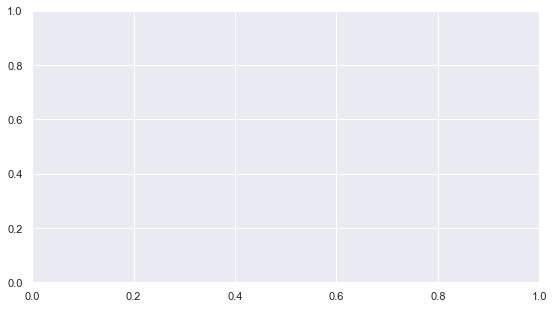

In [102]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('TARGET').CODE_GENDER.mean().index,y=data.groupby('TARGET').CODE_GENDER.mean().values);
plt.title('Média de Renda');
plt.ylabel('Income');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.TARGET == 0].CODE_GENDER,label='Response 0',shade=True);
sns.kdeplot(data[data.TARGET == 1].CODE_GENDER,label='Response 1',shade=True);
plt.title('Distribuição da variável Renda')
plt.legend();

No gráfico à esquerda, podemos notar a média de renda em função dos grupos (Response = 0 e Response = 1). No gráfico à direita, notamos a distribuição para a variável `Income`.

Verificamos que:
* Notamos que o grupo que aceitou a última campanha teve maior renda que o outro grupo, indicando que provavelmente este possa ser um fator impactante em relação à receptividade à última campanha.

##### H6. Ter mais adolescentes em casa influencia na aceptibilidade à ultima campanha?


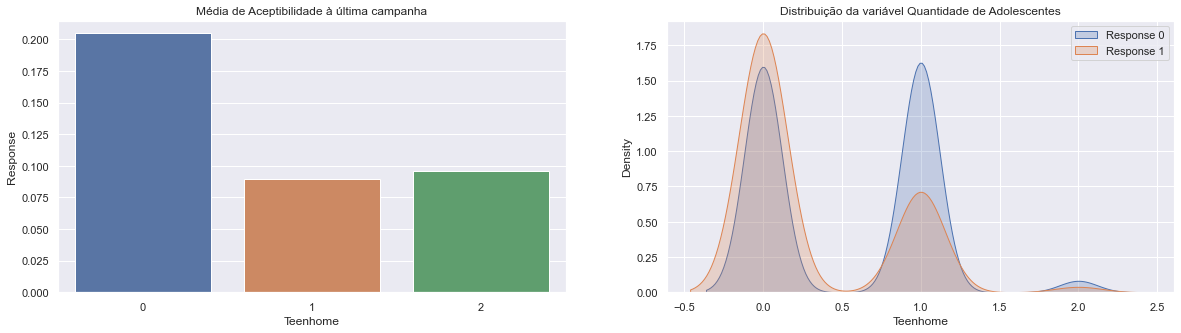

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Teenhome').Response.mean().index,y=data.groupby('Teenhome').Response.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('Response');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].Teenhome,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].Teenhome,label='Response 1',shade=True);
plt.title('Distribuição da variável Quantidade de Adolescentes')
plt.legend();

No gráfico à esquerda, podemos notar a média de aceptibilidade em função da quantidade de adolescentes em casa. No gráfico à direita, notamos a distribuição para a variável `Teenhome`.

Verificamos que:
* Notamos que o grupo que mais aceitou a última campanha foi aquele sem adolescentes em casa.

##### H7. Clientes com reclamações aderem menos a última campanha do que clientes sem reclamações?


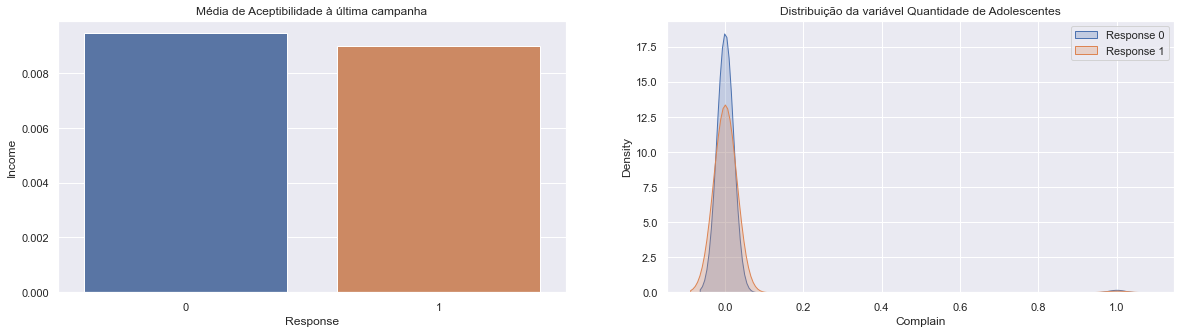

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').Complain.mean().index,y=data.groupby('Response').Complain.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('Complain');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].Complain,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].Complain,label='Response 1',shade=True);
plt.title('Distribuição da variável Reclamações')
plt.legend();

No gráfico à esquerda, podemos notar a média de aceptibilidade em função da quantidade de adolescentes em casa. No gráfico à direita, notamos a distribuição para a variável `Teenhome`.

Verificamos que:
* Notamos que o grupo que mais aceitou a última campanha foi aquele que não realizou reclamações. Entretanto, essa diferença não é tão grande.

##### H8. O estado civil influencia na aceptibilidade à última campanha?

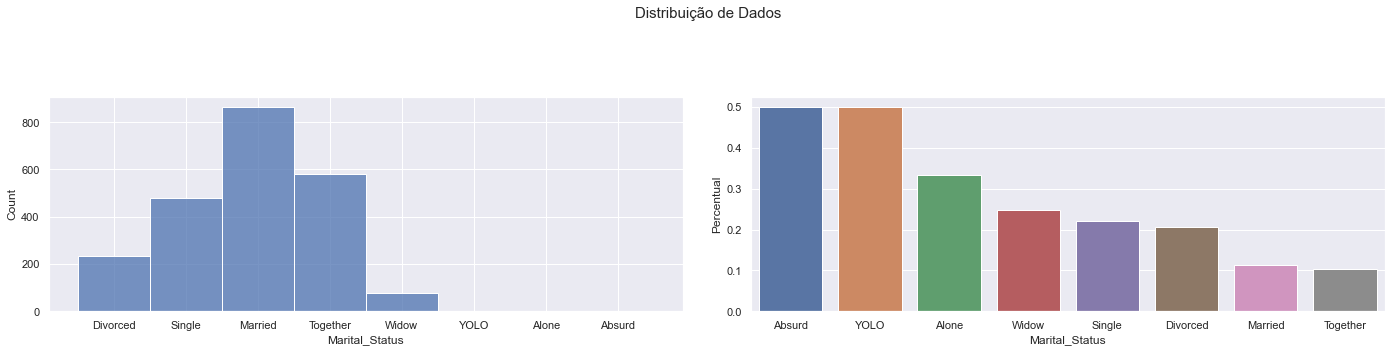

In [ ]:
# Gráfico para visualizar a distribuição dos dados para a variável Marital_Status
categorical_distribution_plot(data,'Marital_Status')

No gráfico à esquerda, podemos notar o histograma da variável `Marital_Status` enquanto no gráfico à direita, notamos o percentual de consumidores que aceitaram a oferta na última campanha agrupadas por categoria (Absurd, YOLO, Alone, Widow, Single, Divorced, Married e Together). 

Verificamos que:
* 38,57% dos consumidores são casados;
* 25,89% dos consumidores vivem juntos com seus parceiros;
* 21,43% dos consumidores são solteiros.

Além disso:
* As categorias que apresentaram maior aceitabilidade à última campanha foram: Absurd e YOLO. Essas categorias tiveram o mesmo percentual (50%);
* 33,33% dos consumidores que são solteiros aceitaram à oferta na última campanha;
* 24,68% dos consumidores que são viúvos aceitaram à oferta na última campanha.

### 4.2 Hipóteses Temporais

##### H9. O dia da semana que o cliente se vinculou à empresa possui alguma relação com a aceptibilidade à última campanha?

In [ ]:
# Criando um DataFrame temporário para armezenar as informações referente à análise da hipótese 9
df_week = pd.DataFrame(data.groupby('Weekday').Response.mean()).reset_index()

# Definindo ordenador 
sorter = ['Domingo','Segunda-Feira','Terça-Feira','Quarta-Feira','Quinta-Feira','Sexta-Feira','Sábado']
df_week.Weekday = df_week.Weekday.astype("category")
df_week.Weekday = df_week.Weekday.cat.set_categories(sorter)

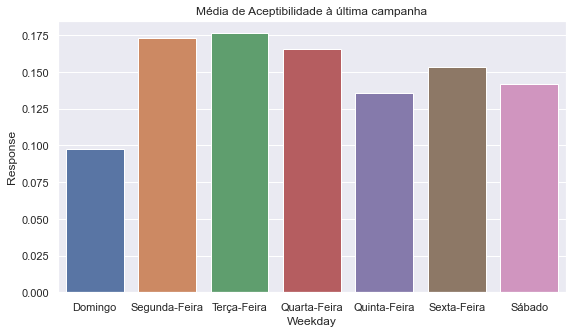

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
# DataFrame ordenado corretamente em função do ordenador df_week.sort_values(["Weekday"])
sns.barplot(x=df_week.sort_values(["Weekday"]).Weekday,y=df_week.sort_values(["Weekday"]).Response);
plt.title('Média de Aceptibilidade à última campanha');

No gráfico acima, podemos notar a média de aceptibilidade em função do dia da semana em que o cliente se vinculou a empresa. 

Verificamos que:
* Segunda, terça e quarta-feira foram os dias da semana que geraram maior conversão em aceitabilidade à última campanha.

##### H10. O mês que o cliente se vinculou à empresa possui alguma relação com a aceptibilidade à última campanha?


In [ ]:
df_month = pd.DataFrame(data.groupby('Month').Response.mean()).reset_index()

# Definindo ordenador 
sorter = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df_month.Month = df_month.Month.astype("category")
df_month.Month = df_month.Month.cat.set_categories(sorter)

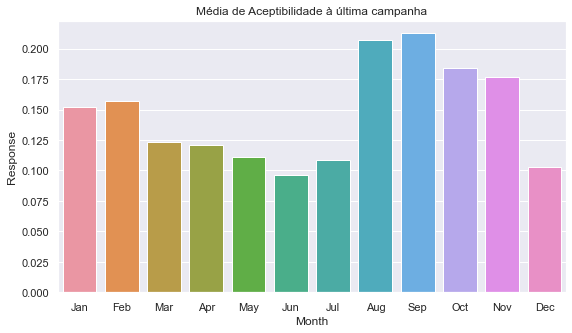

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
# DataFrame ordenado corretamente em função do ordenador df_month.sort_values(["Month"])
sns.barplot(x=df_month.sort_values(["Month"]).Month,y=df_month.sort_values(["Month"]).Response);
plt.title('Média de Aceptibilidade à última campanha');

No gráfico acima, podemos notar a média de aceptibilidade em função do mês em que o cliente se vinculou a empresa. 

Verificamos que:
* Após Fevereiro, há uma redução na conversão de clientes, após Julho há um grande aumento no percentual de conversões atingindo os 4 maiores percentuais do ano (Agosto, Setembro, Outubro e Novembro) reduzindo bastante no mês de dezembro.

##### H11. O ano que o cliente se vinculou à empresa possui alguma relação com a aceptibilidade à última campanha?

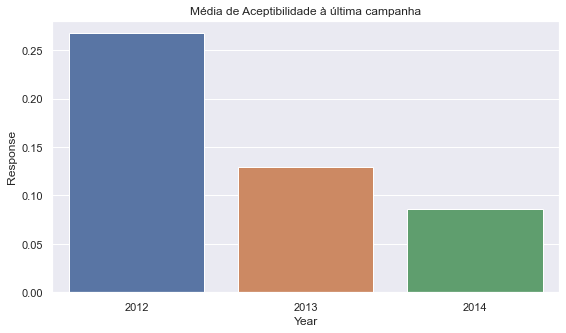

In [ ]:
df_year = pd.DataFrame(data.groupby('Year').Response.mean()).reset_index()
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
# DataFrame ordenado corretamente em função do ordenador df_year.sort_values(["Year"])
sns.barplot(x=df_year.sort_values(["Year"]).Year,y=df_year.sort_values(["Year"]).Response);
plt.title('Média de Aceptibilidade à última campanha');

No gráfico acima, podemos notar a média de aceptibilidade em função do ano em que o cliente se vinculou a empresa. 

Verificamos que:
* O maior percentual de conversão de clientes para a última campanha foi maior no grupo de clientes que se vincularam em 2012. Além disso, notamos a redução do percentual de conversão à medida que os anos foram passando. Indicando uma possível tendência de que clientes mais antigos são mais propensos a aceitarem a última campanha.

### 4.3 Hipóteses Lojas

##### H12. O número de visitantes no site da empresa no mês passado influencia a adesão à última campanha?


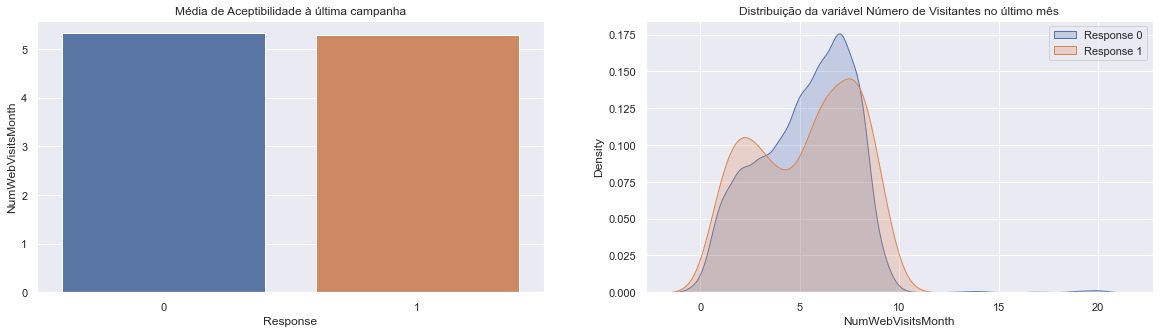

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').NumWebVisitsMonth.mean().index,y=data.groupby('Response').NumWebVisitsMonth.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('NumWebVisitsMonth');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].NumWebVisitsMonth,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].NumWebVisitsMonth,label='Response 1',shade=True);
plt.title('Distribuição da variável Número de Visitantes no último mês')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de visitantes no último mês (`NumWebVisitsMonth`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `NumWebVisitsMonth`.

Verificamos que:
* Aparentemente o número de visitantes no último mês não influenciou na adesão à última campanha.

##### H13. O número de compras feitas diretamente na loja influencia a adesão à última campanha?


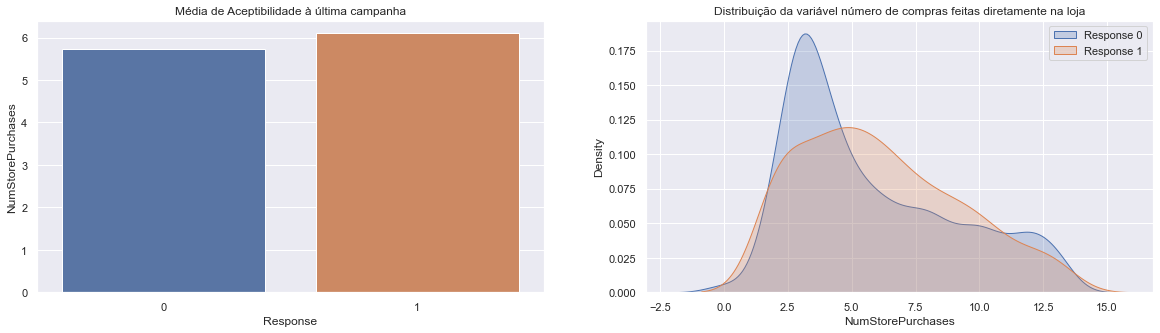

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').NumStorePurchases.mean().index,y=data.groupby('Response').NumStorePurchases.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('NumStorePurchases');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].NumStorePurchases,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].NumStorePurchases,label='Response 1',shade=True);
plt.title('Distribuição da variável número de compras feitas diretamente na loja')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`NumStorePurchases`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `NumStorePurchases`.

Verificamos que:
* Observamos uma tendência de maior número de compras feitas diretamente na loja para o grupo que aceitou a ùltima campanha.

##### H14. O número de compras feitas com desconto influencia a adesão à última campanha?


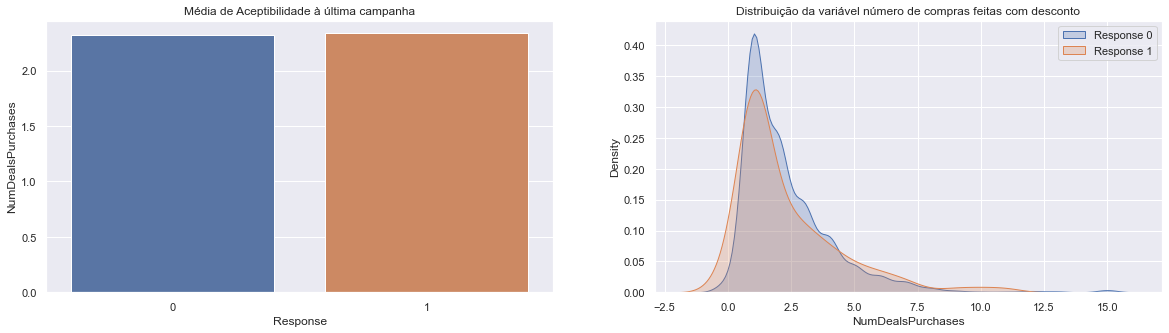

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').NumDealsPurchases.mean().index,y=data.groupby('Response').NumDealsPurchases.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('NumDealsPurchases');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].NumDealsPurchases,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].NumDealsPurchases,label='Response 1',shade=True);
plt.title('Distribuição da variável número de compras feitas com desconto')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`NumDealsPurchases`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `NumDealsPurchases`.

Verificamos que:
* Aparentemente o número de compras feitas com desconto não influenciou na adesão à última campanha.

##### H15. A quantidade de compras feitas utilizando o cardápio influencia a adesão à última campanha?


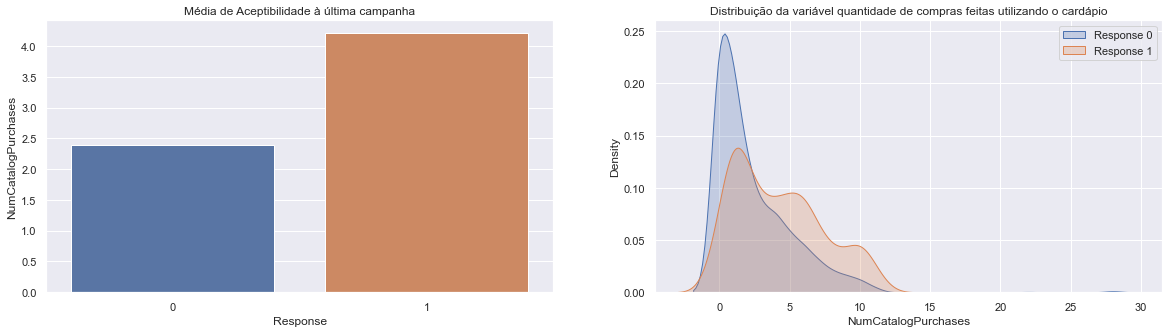

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').NumCatalogPurchases.mean().index,y=data.groupby('Response').NumCatalogPurchases.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('NumCatalogPurchases');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].NumCatalogPurchases,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].NumCatalogPurchases,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade de compras feitas utilizando o cardápio')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`NumStorePurchases`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `NumStorePurchases`.

Verificamos que:
* Observamos uma tendência de maior número de compras feitas diretamente na loja para o grupo que aceitou a ùltima campanha.

##### H16. A adesão à campanha 1 deveria impactar o aumento na adesão à última campanha; 


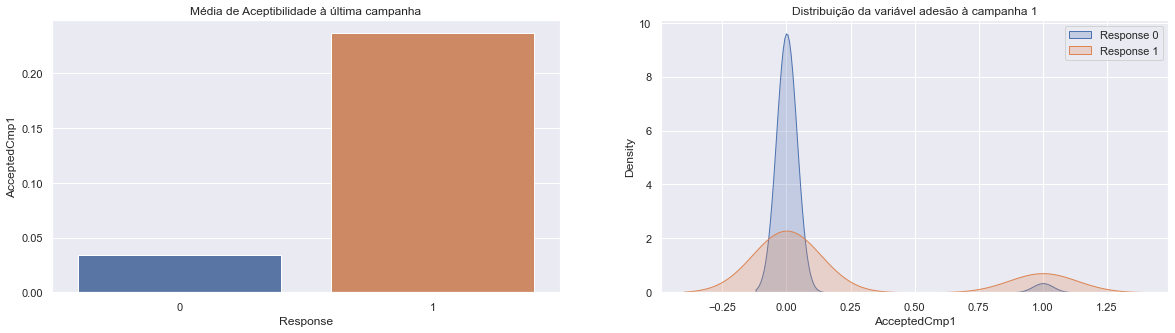

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').AcceptedCmp1.mean().index,y=data.groupby('Response').AcceptedCmp1.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('AcceptedCmp1');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].AcceptedCmp1,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].AcceptedCmp1,label='Response 1',shade=True);
plt.title('Distribuição da variável adesão à campanha 1')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`AcceptedCmp1`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `AcceptedCmp1`.

Verificamos que:
* Observamos uma tendência de maior número de adesão à primeira campanha para o grupo que aceitou a ùltima campanha.

##### H17. A adesão à campanha 2 deveria impactar o aumento na adesão à última campanha; 


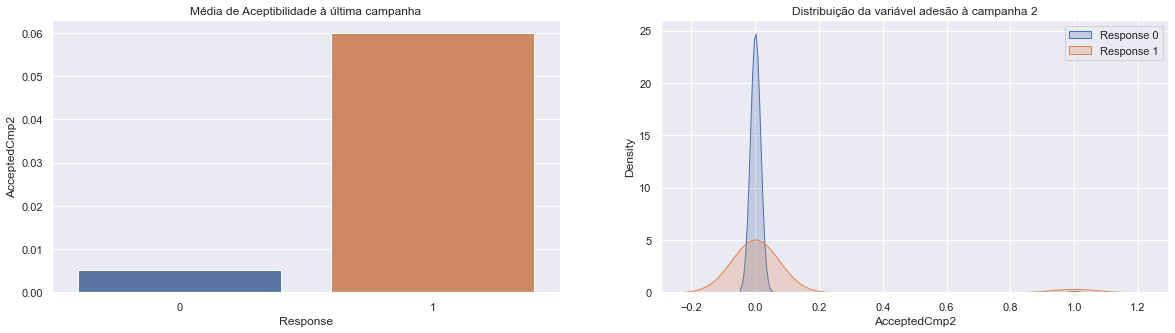

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').AcceptedCmp2.mean().index,y=data.groupby('Response').AcceptedCmp2.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('AcceptedCmp2');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].AcceptedCmp2,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].AcceptedCmp2,label='Response 1',shade=True);
plt.title('Distribuição da variável adesão à campanha 2')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`AcceptedCmp2`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `AcceptedCmp2`.

Verificamos que:
* Observamos uma tendência de maior número de adesão à segunda campanha para o grupo que aceitou a ùltima campanha.

##### H18. A adesão à campanha 3 deveria impactar o aumento na adesão à última campanha; 


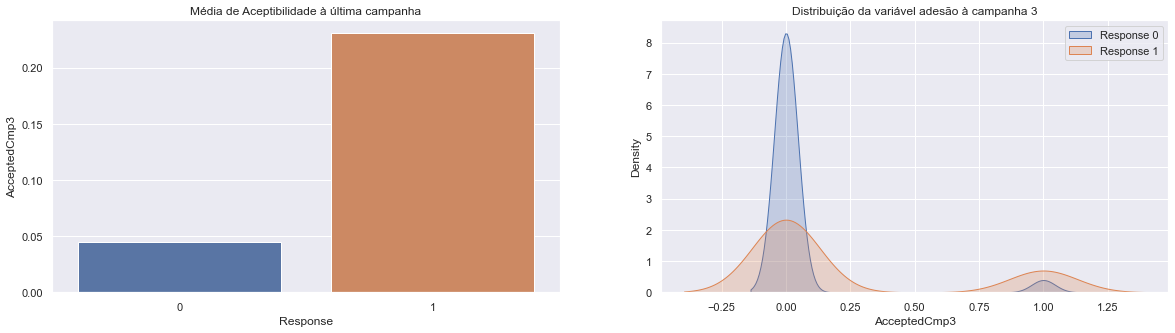

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').AcceptedCmp3.mean().index,y=data.groupby('Response').AcceptedCmp3.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('AcceptedCmp3');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].AcceptedCmp3,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].AcceptedCmp3,label='Response 1',shade=True);
plt.title('Distribuição da variável adesão à campanha 3')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`AcceptedCmp3`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `AcceptedCmp3`.

Verificamos que:
* Observamos uma tendência de maior número de adesão à terceira campanha para o grupo que aceitou a ùltima campanha.

##### H19. A adesão à campanha 4 deveria impactar o aumento na adesão à última campanha; 


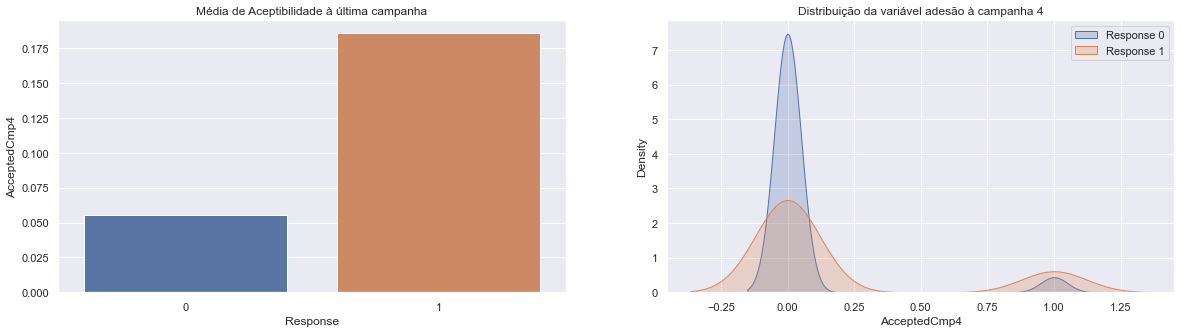

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').AcceptedCmp4.mean().index,y=data.groupby('Response').AcceptedCmp4.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('AcceptedCmp4');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].AcceptedCmp4,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].AcceptedCmp4,label='Response 1',shade=True);
plt.title('Distribuição da variável adesão à campanha 4')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`AcceptedCmp4`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `AcceptedCmp4`.

Verificamos que:
* Observamos uma tendência de maior número de adesão à quarta campanha para o grupo que aceitou a ùltima campanha.

##### H20. A adesão à campanha 5 deveria impactar o aumento na adesão à última campanha; 

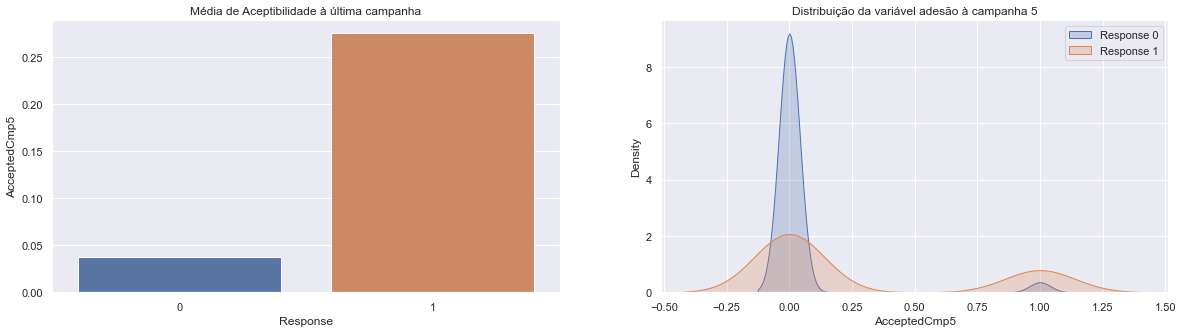

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').AcceptedCmp5.mean().index,y=data.groupby('Response').AcceptedCmp5.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('AcceptedCmp5');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].AcceptedCmp5,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].AcceptedCmp5,label='Response 1',shade=True);
plt.title('Distribuição da variável adesão à campanha 5')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`AcceptedCmp5`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `AcceptedCmp5`.

Verificamos que:
* Observamos uma tendência de maior número de adesão à quinta campanha para o grupo que aceitou a ùltima campanha.

### 4.4 Hipóteses Localização

##### H21. Algum dos países teve melhor receptibilidade à última campanha do que os demais?


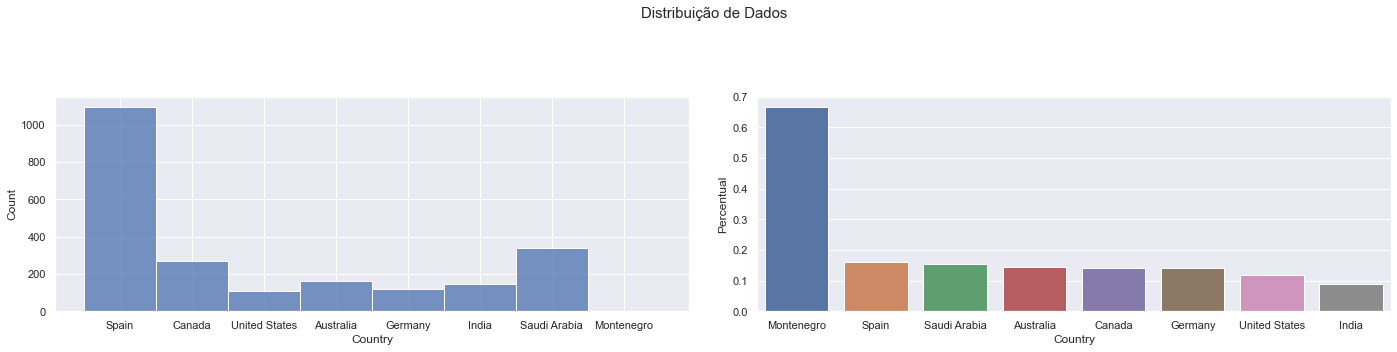

In [ ]:
# Gráfico para visualizar a distribuição dos dados para a variável Country
categorical_distribution_plot(data,'Country')

No gráfico à esquerda, podemos notar o histograma da variável `Country` enquanto no gráfico à direita, notamos o percentual de consumidores que aceitaram a oferta na última campanha agrupadas por categoria (ME, SP, SA, AUS, CA, GER, US e IND). 

Verificamos que:
* 38,57% dos consumidores são casados;
* 25,89% dos consumidores vivem juntos com seus parceiros;
* 21,43% dos consumidores são solteiros.

Além disso:
* O país que apresentou disparadamente maior aceitabilidade à última campanha foi: ME. 66,67% dos consumidores pertencentes a ME (Montenegro) aderiram a esta campanha;
* 16,07% dos consumidores pertencentes à SP (Espanha) aceitaram à oferta na última campanha;
* 15,43% dos consumidores pertencentes à SA (Árabia Saudita) aceitaram à oferta na última campanha.

##### H22. Algum continente teve melhor receptibilidade à última campanha do que os demais?

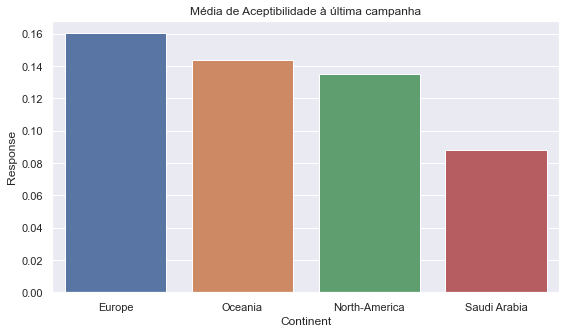

In [ ]:
df_continent = pd.DataFrame(data.groupby('Continent').Response.mean()).reset_index().sort_values(by='Response',ascending=False)
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=df_continent.Continent,y=df_continent.Response);
plt.title('Média de Aceptibilidade à última campanha');

No gráfico acima, podemos notar a média de aceptibilidade em função do continente do cliente. 

Verificamos que:
* O maior percentual de conversão de clientes para a última campanha foi maior continente europeu.

### 4.5 Hipóteses Produtos

##### H23. A quantidade gasta em frutas influencia na aceptibilidade à última campanha?

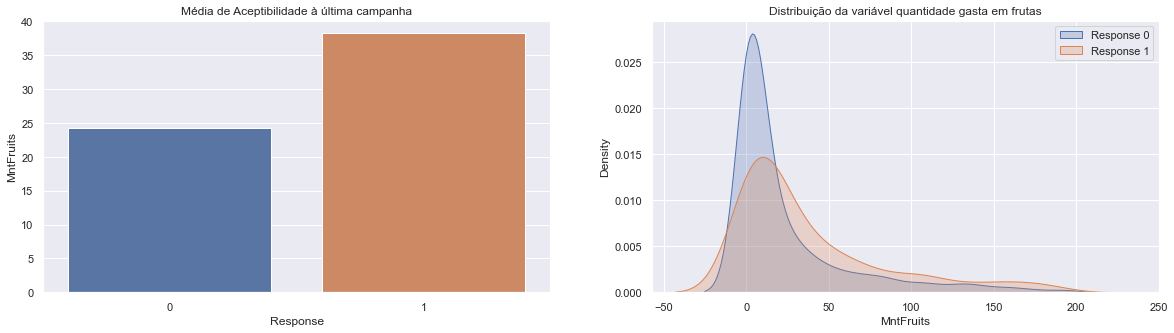

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').MntFruits.mean().index,y=data.groupby('Response').MntFruits.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('MntFruits');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].MntFruits,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].MntFruits,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade gasta em frutas')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`MntFruits`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `MntFruits`.

Verificamos que:
* Observamos uma tendência de o grupo que aceitou à última campanha tende a consumir mais frutas.

##### H24. A quantidade gasta em produtos de carne influencia na aceptibilidade à última campanha?


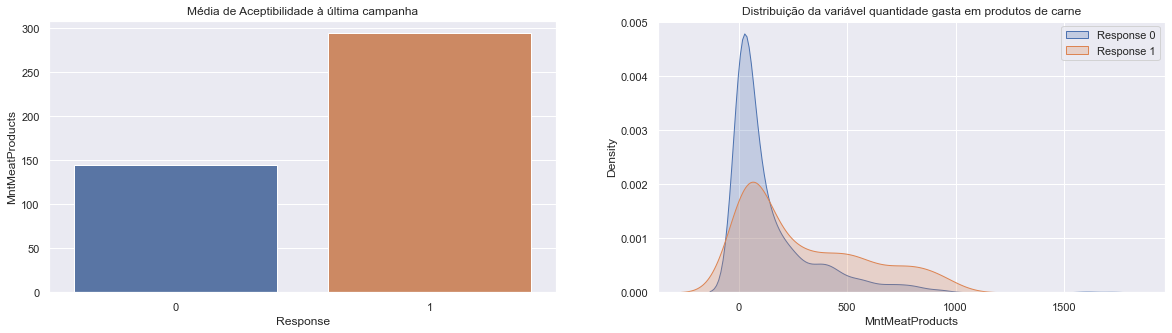

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').MntMeatProducts.mean().index,y=data.groupby('Response').MntMeatProducts.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('MntMeatProducts');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].MntMeatProducts,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].MntMeatProducts,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade gasta em produtos de carne')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`MntMeatProducts`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `MntMeatProducts`.

Verificamos que:
* Observamos uma tendência de o grupo que aceitou à última campanha tende a consumir mais carnes.

##### H25. A quantidade gasta em produtos pescados influencia na aceptibilidade à última campanha?


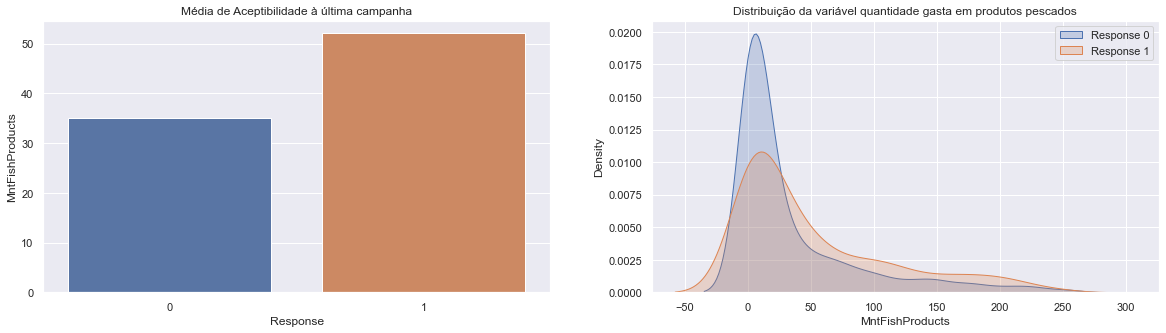

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').MntFishProducts.mean().index,y=data.groupby('Response').MntFishProducts.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('MntFishProducts');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].MntFishProducts,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].MntFishProducts,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade gasta em produtos pescados')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`MntFishProducts`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `MntFishProducts`.

Verificamos que:
* Observamos uma tendência de o grupo que aceitou à última campanha tende a consumir mais pescados.

##### H26. A quantidade gasta em produtos doces influencia na aceptibilidade à última campanha?


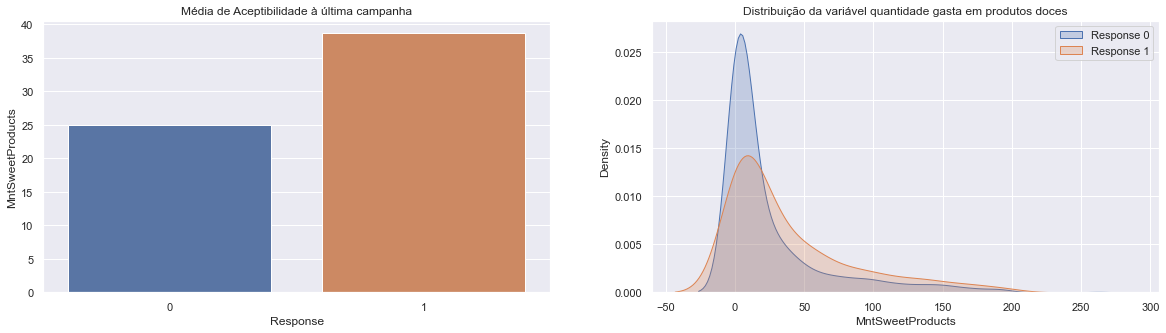

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').MntSweetProducts.mean().index,y=data.groupby('Response').MntSweetProducts.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('MntSweetProducts');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].MntSweetProducts,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].MntSweetProducts,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade gasta em produtos doces')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`MntSweetProducts`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `MntSweetProducts`.

Verificamos que:
* Observamos uma tendência de o grupo que aceitou à última campanha tende a consumir mais doces.

##### H27. A quantidade gasta em vinhos influencia na aceptibilidade à última campanha?


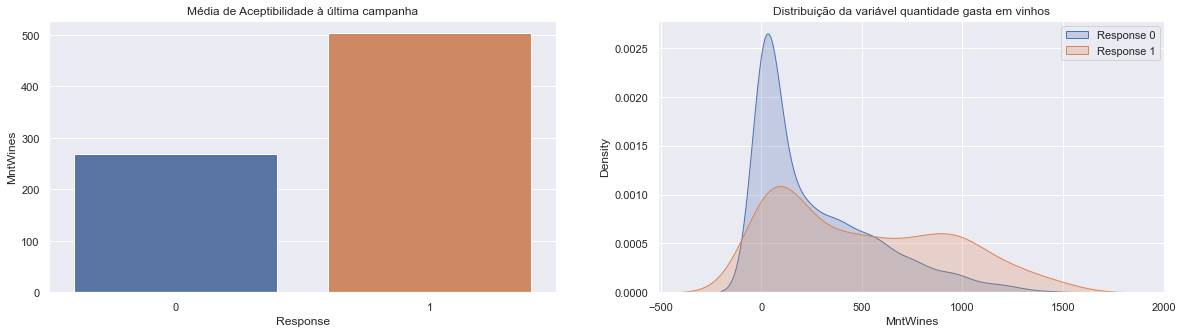

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').MntWines.mean().index,y=data.groupby('Response').MntWines.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('MntWines');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].MntWines,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].MntWines,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade gasta em vinhos')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`MntWines`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `MntWines`.

Verificamos que:
* Observamos uma tendência de o grupo que aceitou à última campanha tende a consumir mais vinhos.

##### H28. A quantidade gasta em produtos de ouro influencia na aceptibilidade à última campanha?

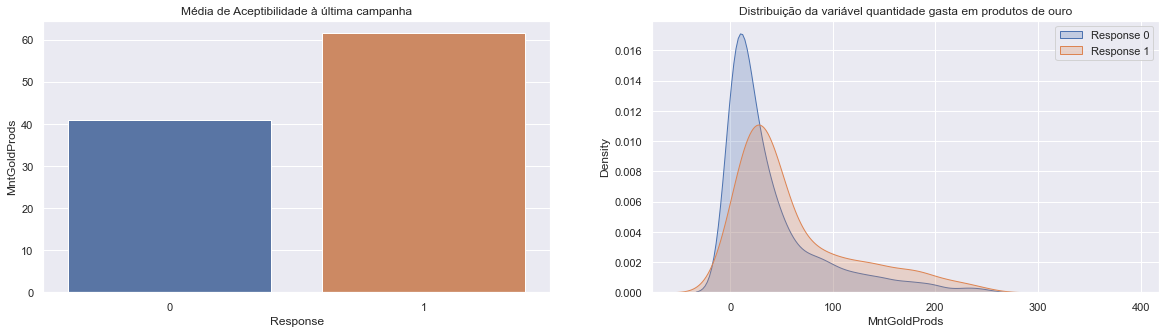

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('Response').MntGoldProds.mean().index,y=data.groupby('Response').MntGoldProds.mean().values);
plt.title('Média de Aceptibilidade à última campanha');
plt.ylabel('MntGoldProds');

plt.subplot(1, 2, 2)
sns.kdeplot(data[data.Response == 0].MntGoldProds,label='Response 0',shade=True);
sns.kdeplot(data[data.Response == 1].MntGoldProds,label='Response 1',shade=True);
plt.title('Distribuição da variável quantidade gasta em produtos de ouro')
plt.legend();

No gráfico à esquerda, podemos notar a média do número de compras feitas diretamente na loja (`MntGoldProds`) em função da variável `Response`. No gráfico à direita, notamos a distribuição para a variável `MntGoldProds`.

Verificamos que:
* Observamos uma tendência de o grupo que aceitou à última campanha tende a consumir mais produtos de ouro.

## Considerações Finais

Através desta análise exploratória de dados podemos chegar as seguintes conclusões a respeito do perfil de cliente que mais teve adesão à última campanha:
* Possuiam PhD ou mestrado;
* Haviam comprado recentemente;
* Não tinham crianças ou adolescentes em casa;
* Tinham renda mais elevada;
* Não possuem reclamações;
* Têm estado civil: absurd, yolo ou alone;
* Se vincularam à empresa em uma segunda-feira, terça-feira ou quarta-feira;
* Se vincularam à empresa em agosto, setembro, outubro ou novembro;
* Têm mais tempo de vínculo com a empresa (a adesão foi menor para clientes com menor quantidade de anos de vínculo);
* Realizaram mais compras diretamente na loja;
* Fizeram mais compras utilizando cardápio;
* Aceitaram as demais campanhas (Campanha 1, Campanha 2, Campanha 3, Campanha 4, Campanha 5);
* São pertencentes ao continente europeu (Montenegro se destacou bastante dentre os europeus);
* Possuem maiores gastos em todos os setores avaliados: frutas, carnes, pescados, doces, vinhos, produtos de ouro.